In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import minimize

import tensorflow as tf

#from tensorflow.keras.models import Sequential
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

from dqlagent import *
tf.keras.utils.disable_interactive_logging()


plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)

#os.environ['PYTHONHASHSEED'] = '0'
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

eps = np.finfo(np.float32).eps.item()

2025-04-02 12:29:15.587839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-02 12:29:15.587878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-02 12:29:15.618214: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 12:29:15.683704: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-02 12:29:16.693052: W tensorflow/compiler/tf2

In [2]:
class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        random.seed(seed)
    def sample(self):
        rn = np.random.random(self.n)
        return rn / rn.sum()     

In [6]:
train = pd.read_csv("data/train_portfolio4.csv")
train

date  federal_interest_rate  free_rate  price_BBVA  \
0    2022-01-01                   0.07   0.039667    5.896667   
1    2022-01-02                   0.07   0.046333    5.923333   
2    2022-01-03                   0.08   0.053000    5.950000   
3    2022-01-04                   0.08   0.080000    6.070000   
4    2022-01-05                   0.08   0.085000    5.970000   
..          ...                    ...        ...         ...   
969  2024-08-27                   5.33   4.968000   10.620000   
970  2024-08-28                   5.33   4.955000   10.560000   
971  2024-08-29                   5.33   4.965000   10.560000   
972  2024-08-30                   5.33   4.968000   10.650000   
973  2024-08-31                   5.33   4.968000   10.650000   

     BBVA_volatility7  BBVA_volatility30  BBVA_returns3  BBVA_returns7  \
0            0.004899           0.012587       0.001706       0.005567   
1            0.005047           0.011688      -0.002256       0.007116   
2            0.005178           0.011529       0.005659       0.008656   
3            0.005294           0.011345       0.013629       0.010187   
4            0.008000           0.011603       0.029395       0.035836   
..                ...                ...            ...            ...   
969          0.009808           0.016092      -0.005666       0.005731   
970          0.009369           0.016182       0.004730       0.022137   
971          0.009745           0.016200       0.000948       0.009560   
972          0.008958           0.016128       0.002849       0.017341   
973          0.005532           0.014746       0.002825       0.005666   

     BBVA_returns15  BBVA_returns30  ...  BABA_volatility7  BABA_volatility30  \
0          0.029825        0.113852  ...          0.043697           0.033703   
1          0.068237        0.087946  ...          0.043624           0.033708   
2          0.067267        0.100991  ...          0.043508           0.029931   
3          0.066308        0.090409  ...          0.043348           0.029321   
4          0.081996        0.096988  ...          0.042784           0.028731   
..              ...             ...  ...               ...                ...   
969        0.080369       -0.036890  ...          0.024414           0.016407   
970        0.090349       -0.025390  ...          0.020405           0.016386   
971        0.065590       -0.027624  ...          0.017080           0.016896   
972        0.067745       -0.034735  ...          0.019386           0.017096   
973        0.058648        0.010436  ...          0.019135           0.017731   

     BABA_returns3  BABA_returns7  BABA_returns15  BABA_returns30  \
0         0.034756       0.005481       -0.012141       -0.030207   
1         0.064502       0.014410       -0.022768       -0.021967   
2        -0.025531       0.023419        0.000974        0.070472   
3         0.013385       0.032507        0.025675        0.039192   
4         0.002011       0.041463        0.039652       -0.001336   
..             ...            ...             ...             ...   
969      -0.042735      -0.025623        0.014350        0.058702   
970      -0.032584       0.005059        0.006674        0.045258   
971      -0.040453      -0.046809       -0.018249        0.012719   
972      -0.009051      -0.023385        0.019504        0.038718   
973       0.023204      -0.024236        0.047775        0.056944   

     BABA_slope3  BABA_slope7  BABA_slope15  BABA_slope30  
0       3.350002     0.384286     -0.187226     -0.173611  
1      -1.834999     0.686697     -0.043458     -0.165689  
2       0.529999     0.911429      0.055869     -0.222396  
3       0.529999     1.021071      0.100410     -0.252436  
4      -0.145000     0.651786      0.046071     -0.263028  
..           ...          ...           ...           ...  
969    -1.216667     0.081667      0.218691      0.247066  
970    -0.763336    -0.395476      0.148548      0.235766  

In [3]:
test = pd.read_csv("data/test_portfolio4_v2.csv")
test

date  federal_interest_rate  free_rate  price_BBVA  \
0    2024-09-01                   5.33     4.9690   10.094539   
1    2024-09-02                   5.33     4.9695    9.980654   
2    2024-09-03                   5.33     4.9700    9.866770   
3    2024-09-04                   5.33     4.9480    9.672923   
4    2024-09-05                   5.33     4.9320    9.818308   
..          ...                    ...        ...         ...   
207  2025-03-27                   5.33     4.1880   14.140000   
208  2025-03-28                   5.33     4.1880   13.730000   
209  2025-03-29                   5.33     4.1880   13.730000   
210  2025-03-30                   5.33     4.1880   13.730000   
211  2025-03-31                   5.33     4.1880   13.730000   

     BBVA_volatility7  BBVA_volatility30  BBVA_returns3  BBVA_returns7  \
0            0.007128           0.009492      -0.002604      -0.003548   
1            0.008210           0.008696      -0.013731      -0.012796   
2            0.008959           0.008992      -0.033099      -0.022080   
3            0.007704           0.009278      -0.033468      -0.041431   
4            0.009257           0.010043      -0.041767      -0.054924   
..                ...                ...            ...            ...   
207          0.014924           0.017945       0.004710      -0.018634   
208          0.012428           0.017548      -0.001412      -0.002117   
209          0.016568           0.018312      -0.052450      -0.028996   
210          0.016548           0.018204      -0.034459      -0.029453   
211          0.016527           0.018173      -0.028996      -0.029911   

     BBVA_returns15  BBVA_returns30  ...  BABA_volatility7  BABA_volatility30  \
0          0.031587        0.063889  ...          0.018532           0.017589   
1          0.011492        0.075930  ...          0.017719           0.017538   
2         -0.008266        0.067467  ...          0.016655           0.017550   
3         -0.027698        0.058946  ...          0.016627           0.017561   
4         -0.039461        0.041754  ...          0.012872           0.017542   
..              ...             ...  ...               ...                ...   
207        0.034935        0.100619  ...          0.015305           0.026211   
208        0.012894        0.067976  ...          0.012918           0.025678   
209       -0.005073        0.023100  ...          0.014986           0.025057   
210       -0.042538        0.033108  ...          0.015019           0.024855   
211       -0.046528        0.037793  ...          0.015049           0.024250   

     BABA_returns3  BABA_returns7  BABA_returns15  BABA_returns30  \
0         0.043362      -0.013313       -0.001292        0.065305   
1         0.022032      -0.002069       -0.007412        0.069141   
2        -0.009629       0.009509       -0.013496        0.067848   
3        -0.009660       0.010068       -0.019545        0.066548   
4        -0.004046       0.035795        0.017646        0.071317   
..             ...            ...             ...             ...   
207      -0.018263      -0.076536       -0.048770        0.024799   
208       0.008552      -0.009349       -0.011011        0.012089   
209      -0.002411      -0.020053       -0.042790       -0.047814   
210       0.001437      -0.018455       -0.061446       -0.030172   
211      -0.023594      -0.016852       -0.075575       -0.000604   

      BABA_slope3  BABA_slope7  BABA_slope15  BABA_slope30  
0    1.026250e+00     0.107767     -0.127212      0.198465  
1   -2.674999e-01     0.360713     -0.107036      0.185021  
2   -2.674999e-01     0.417321     -0.084387      0.166388  
3   -2.674999e-01     0.373214     -0.057441      0.142616  
4   -3.374767e-02     0.059822     -0.101637      0.116769  
..            ...          ...           ...           ...  
207 -1.119995e+00    -0.686786     -0.704989      0.099161  
208  1.440002e+00    -0.208570     -0.824203      0

In [4]:
class Investing:
    def __init__(self, df, budget=1):
        self.initial_balance = budget
        self.portfolio_value = budget
        self.portfolio_value_new = budget
        self.retrieved = 0
        self.data = df
        self.portfolios = pd.DataFrame()
        self.episode = 0
        self.state_cols = [c for c in self.data.columns if (c != "date") and ("price" not in c) and ("returns" not in c)]
        self.price_cols = [c for c in self.data.columns if "price" in c]
        self.stocks = np.unique([c.split("_")[0] for c in self.data.columns if "returns" in c])
        self.num_stocks = len(self.stocks)

        self.observation_space = (len(self.state_cols) + self.num_stocks + 1,)
        self.osn = self.observation_space[0]
        self.action_space = action_space(self.num_stocks + 1)
        
    
    def _get_state(self):
        state = self.data[self.state_cols].iloc[self.i].values
        state = np.concatenate([state, self.curr_allocation])
        date = self.data.date[self.i]
        prices = self.data[self.price_cols].iloc[self.i].values
        return state, {'date': date, 'prices': prices}
        
    def seed(self, seed=None):
        if seed is not None:
            random.seed(seed)
            
    def reset(self):
        self.curr_allocation = np.zeros(self.num_stocks+1)
        self.i = 0
        self.treward = 0
        self.portfolio_value = self.initial_balance
        self.portfolio_value_new = self.initial_balance
        self.episode += 1
        self.state, info = self._get_state()
        self.prices = info['prices']
        return self.state, info

    def add_results(self, pl):
        df = pd.DataFrame({
                   'e': self.episode, 'date': self.date, 
                   'pv': self.portfolio_value, 'pv_new': self.portfolio_value_new,
                   'p&l[$]': pl, 'p&l[%]': pl / self.portfolio_value_new * 100}, index=[0])
        self.portfolios = pd.concat((self.portfolios, df), ignore_index=True)
        
    def step(self, action):
        self.i += 1
        self.new_state, info = self._get_state()
        self.date = info['date']
        self.curr_prices = info['prices']
        if self.i == 1:
            pl = 0.0
            reward = 0.0
            self.curr_allocation = action
            self.add_results(pl)
        else:
            self.portfolio_value_new = (sum([self.curr_allocation[k] * self.portfolio_value * self.curr_prices[k] / self.prices[k] for k in range(self.num_stocks)]))
            self.portfolio_value_new += self.curr_allocation[-1] * self.portfolio_value * (1.0 + 0.05 / 365)
                
            pl = self.portfolio_value_new - self.portfolio_value
            self.curr_allocation = action
            self.add_results(pl)
            ret = self.portfolios['p&l[%]'].iloc[-1] / 100 * 252
            vol = self.portfolios['p&l[%]'].rolling(20, min_periods=1).std().iloc[-1] * math.sqrt(252)
            sharpe = ret / vol
            reward = sharpe
            self.portfolio_value = self.portfolio_value_new
        if self.i == len(self.data) - 1:
            done = True
        else:
            done = False
        self.state = self.new_state
        self.prices  = self.curr_prices
        return self.state, reward, done, False, info

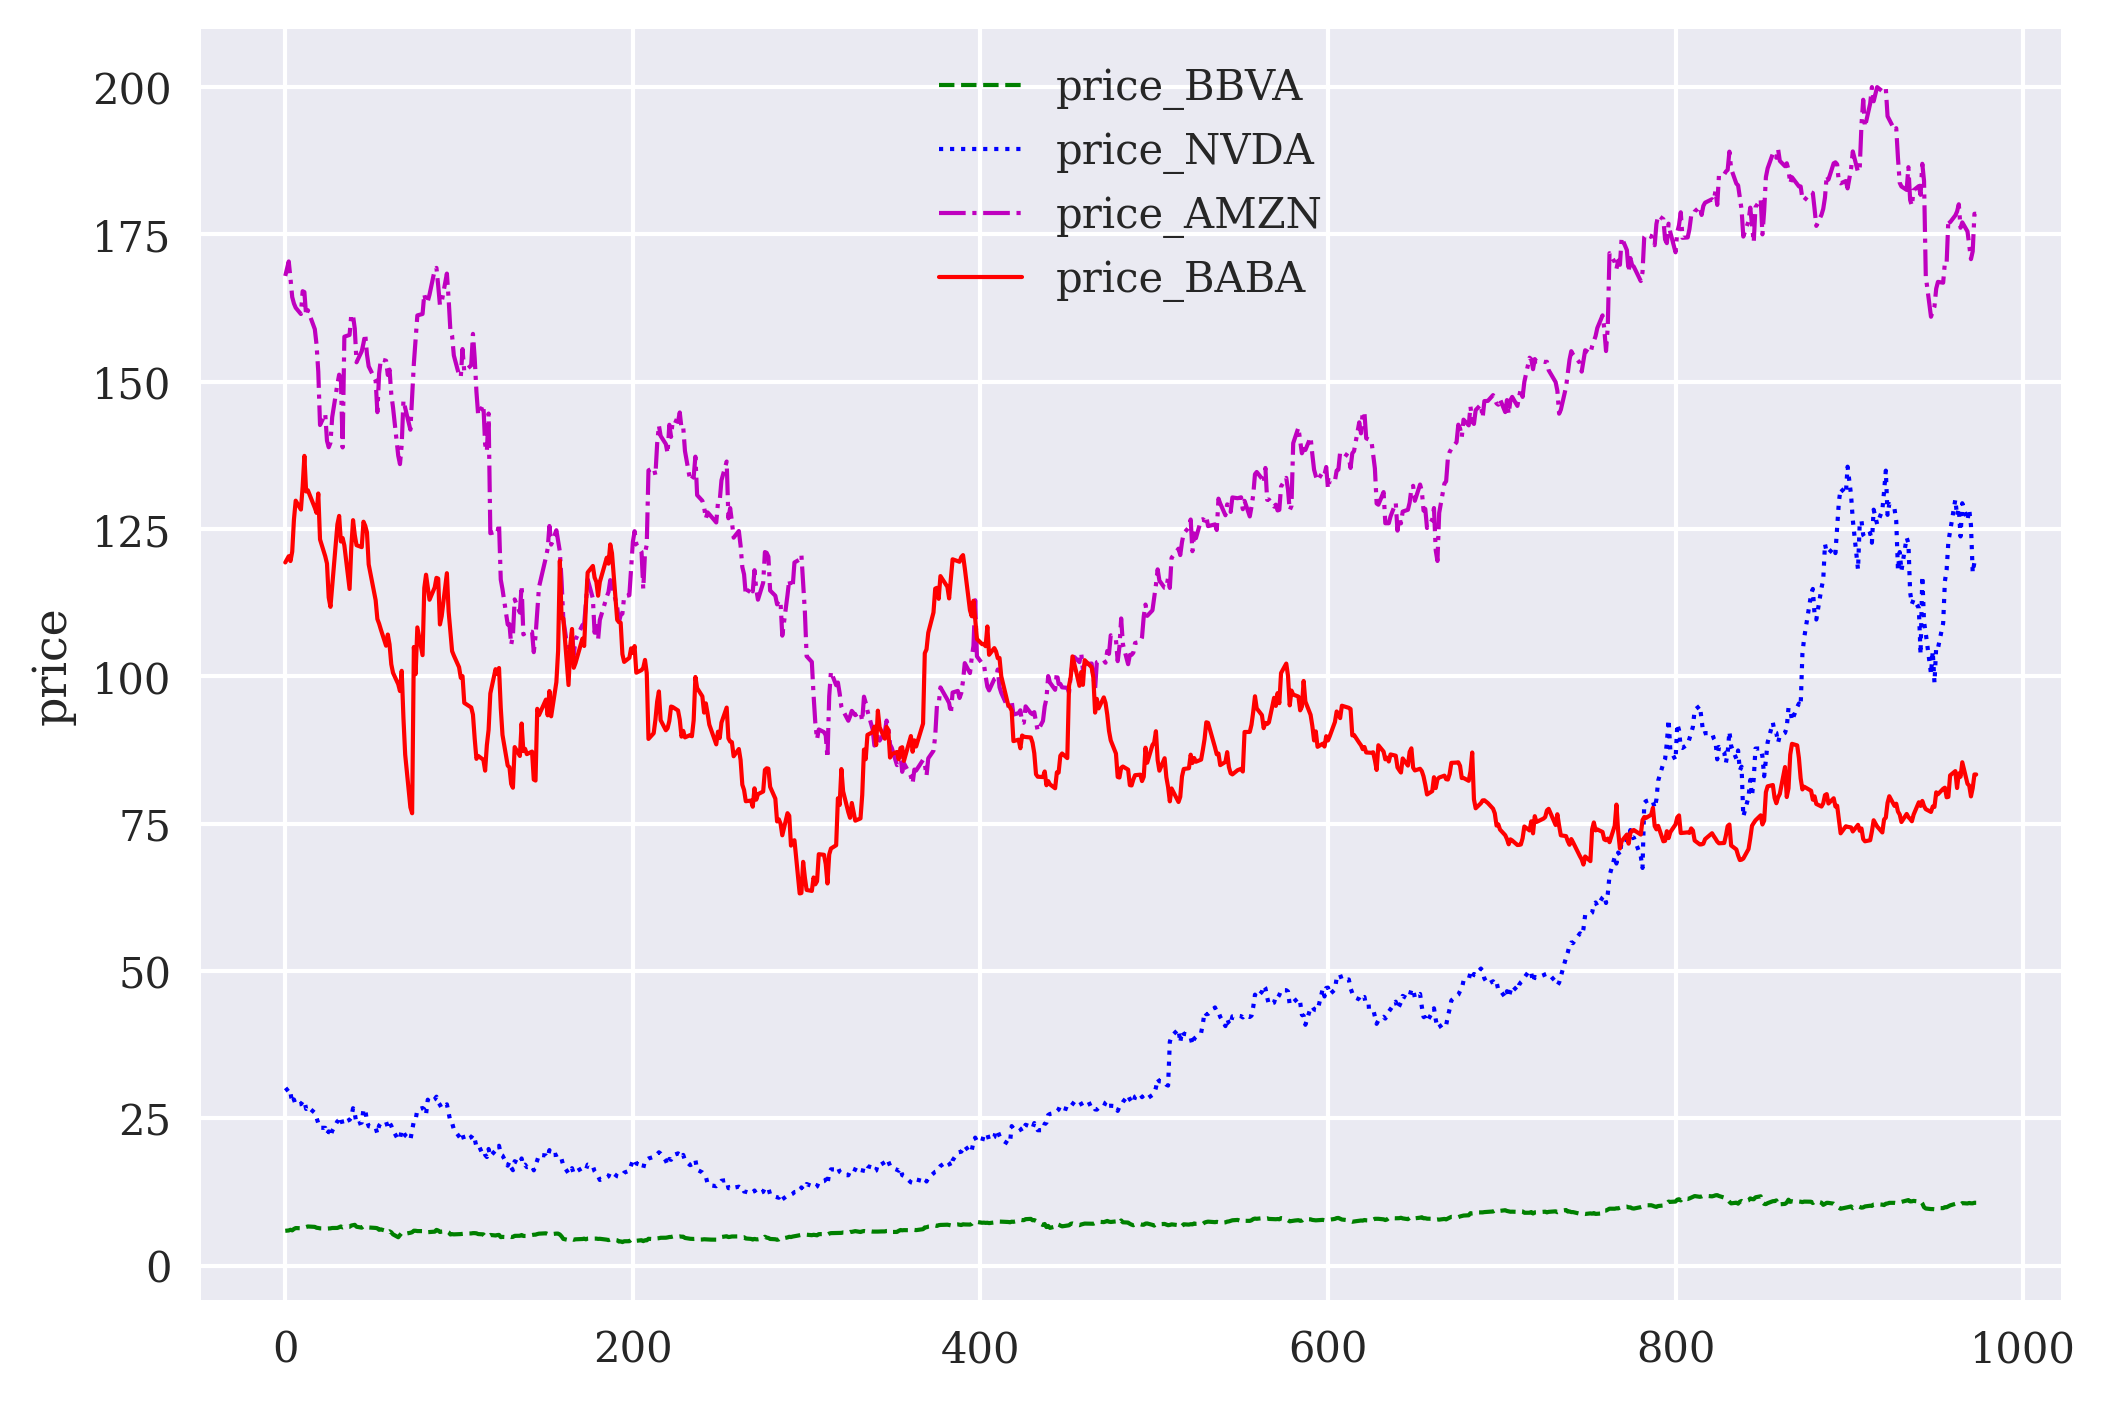

In [7]:
investing = Investing(train)

investing.data[investing.price_cols].plot(lw=1, style=['g--', 'b:', 'm-.', 'r-'])
plt.ylabel('price');

# Testing Environment

In [8]:
state, info = investing.reset()

In [9]:
investing.price_cols

['price_BBVA', 'price_NVDA', 'price_AMZN', 'price_BABA']

In [10]:
print("state", state)
print("info", info)

state [ 0.07        0.03966667  0.00489906  0.01258709 -0.01999998  0.00357141
  0.02921427  0.01211308  0.01319533  0.03059857 -0.29500008 -0.20192855
  0.18760472 -0.0421098   0.00550667  0.01088335 -1.24200439 -0.5062136
 -0.03714841 -0.12285186  0.04369664  0.03370276  3.35000229  0.38428579
 -0.18722625 -0.17361105  0.          0.          0.          0.
  0.        ]
info {'date': '2022-01-01', 'prices': array([  5.89666653,  29.6476663 , 167.94616191, 119.31999969])}


In [11]:
print("stocks:", investing.stocks)

stocks: ['AMZN' 'BABA' 'BBVA' 'NVDA']


In [12]:
action = investing.action_space.sample()
print("action:", action)

action: [0.23251201 0.58666908 0.0121857  0.00194057 0.16669265]


In [13]:
state, reward, done, _, info = investing.step(action)

In [14]:
print("state", state)
print("reward", reward)
print("done", done)
print("info", info)

state [ 0.07        0.04633333  0.00504695  0.01168843  0.00333333  0.00223213
  0.02561308  0.01136855  0.01274778  0.03033018  0.03083293 -0.23990182
  0.15061961 -0.02639605  0.00686679  0.01098881 -0.34916941 -0.50502654
 -0.06197816 -0.13106376  0.04362396  0.03370768 -1.83499908  0.68669673
 -0.04345843 -0.16568891  0.          0.          0.          0.
  0.        ]
reward 0.0
done False
info {'date': '2022-01-02', 'prices': array([  5.92333317,  29.88433329, 169.17532857, 119.84999847])}


In [15]:
action = investing.action_space.sample()
print("action:", action)

action: [0.30185046 0.26086106 0.15094018 0.25449118 0.03185712]


In [16]:
state, reward, done, _, info = investing.step(action)

In [17]:
print("state", state)
print("reward", reward)
print("done", done)
print("info", info)

state [ 0.08        0.053       0.00517801  0.01152907  0.02666664  0.00476188
  0.02219045  0.01030811  0.01228098  0.02929898  0.236667   -0.18288099
  0.11217499 -0.01793546  0.00772069  0.01079444  1.22916667 -0.33557765
 -0.07666688 -0.14600398  0.04350775  0.02993137  0.52999878  0.91142872
  0.05586889 -0.22239638  0.23251201  0.58666908  0.0121857   0.00194057
  0.16669265]
reward 0.2244994432064365
done False
info {'date': '2022-01-03', 'prices': array([  5.94999981,  30.12100029, 170.40449524, 120.37999725])}


# Standard Strategy

In [45]:
investing = Investing(test)

EPISODES = 1

for i in range(EPISODES):
    state, info = investing.reset()
    done = False
    while not done:
        action = np.ones(investing.num_stocks+1) / (investing.num_stocks+1)
        state, reward, done, _, info = investing.step(action)


In [46]:
action

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [47]:
investing.portfolios

e        date        pv    pv_new    p&l[$]    p&l[%]
0    1  2024-09-02  1.000000  1.000000  0.000000  0.000000
1    1  2024-09-03  1.000000  0.991332 -0.008668 -0.874386
2    1  2024-09-04  0.991332  0.981375 -0.009957 -1.014586
3    1  2024-09-05  0.981375  0.991268  0.009893  0.998049
4    1  2024-09-06  0.991268  0.967857 -0.023411 -2.418879
..  ..         ...       ...       ...       ...       ...
206  1  2025-03-27  1.249753  1.249955  0.000202  0.016159
207  1  2025-03-28  1.249955  1.222167 -0.027788 -2.273654
208  1  2025-03-29  1.222167  1.222201  0.000033  0.002740
209  1  2025-03-30  1.222201  1.222234  0.000033  0.002740
210  1  2025-03-31  1.222234  1.222268  0.000033  0.002740

[211 rows x 6 columns]

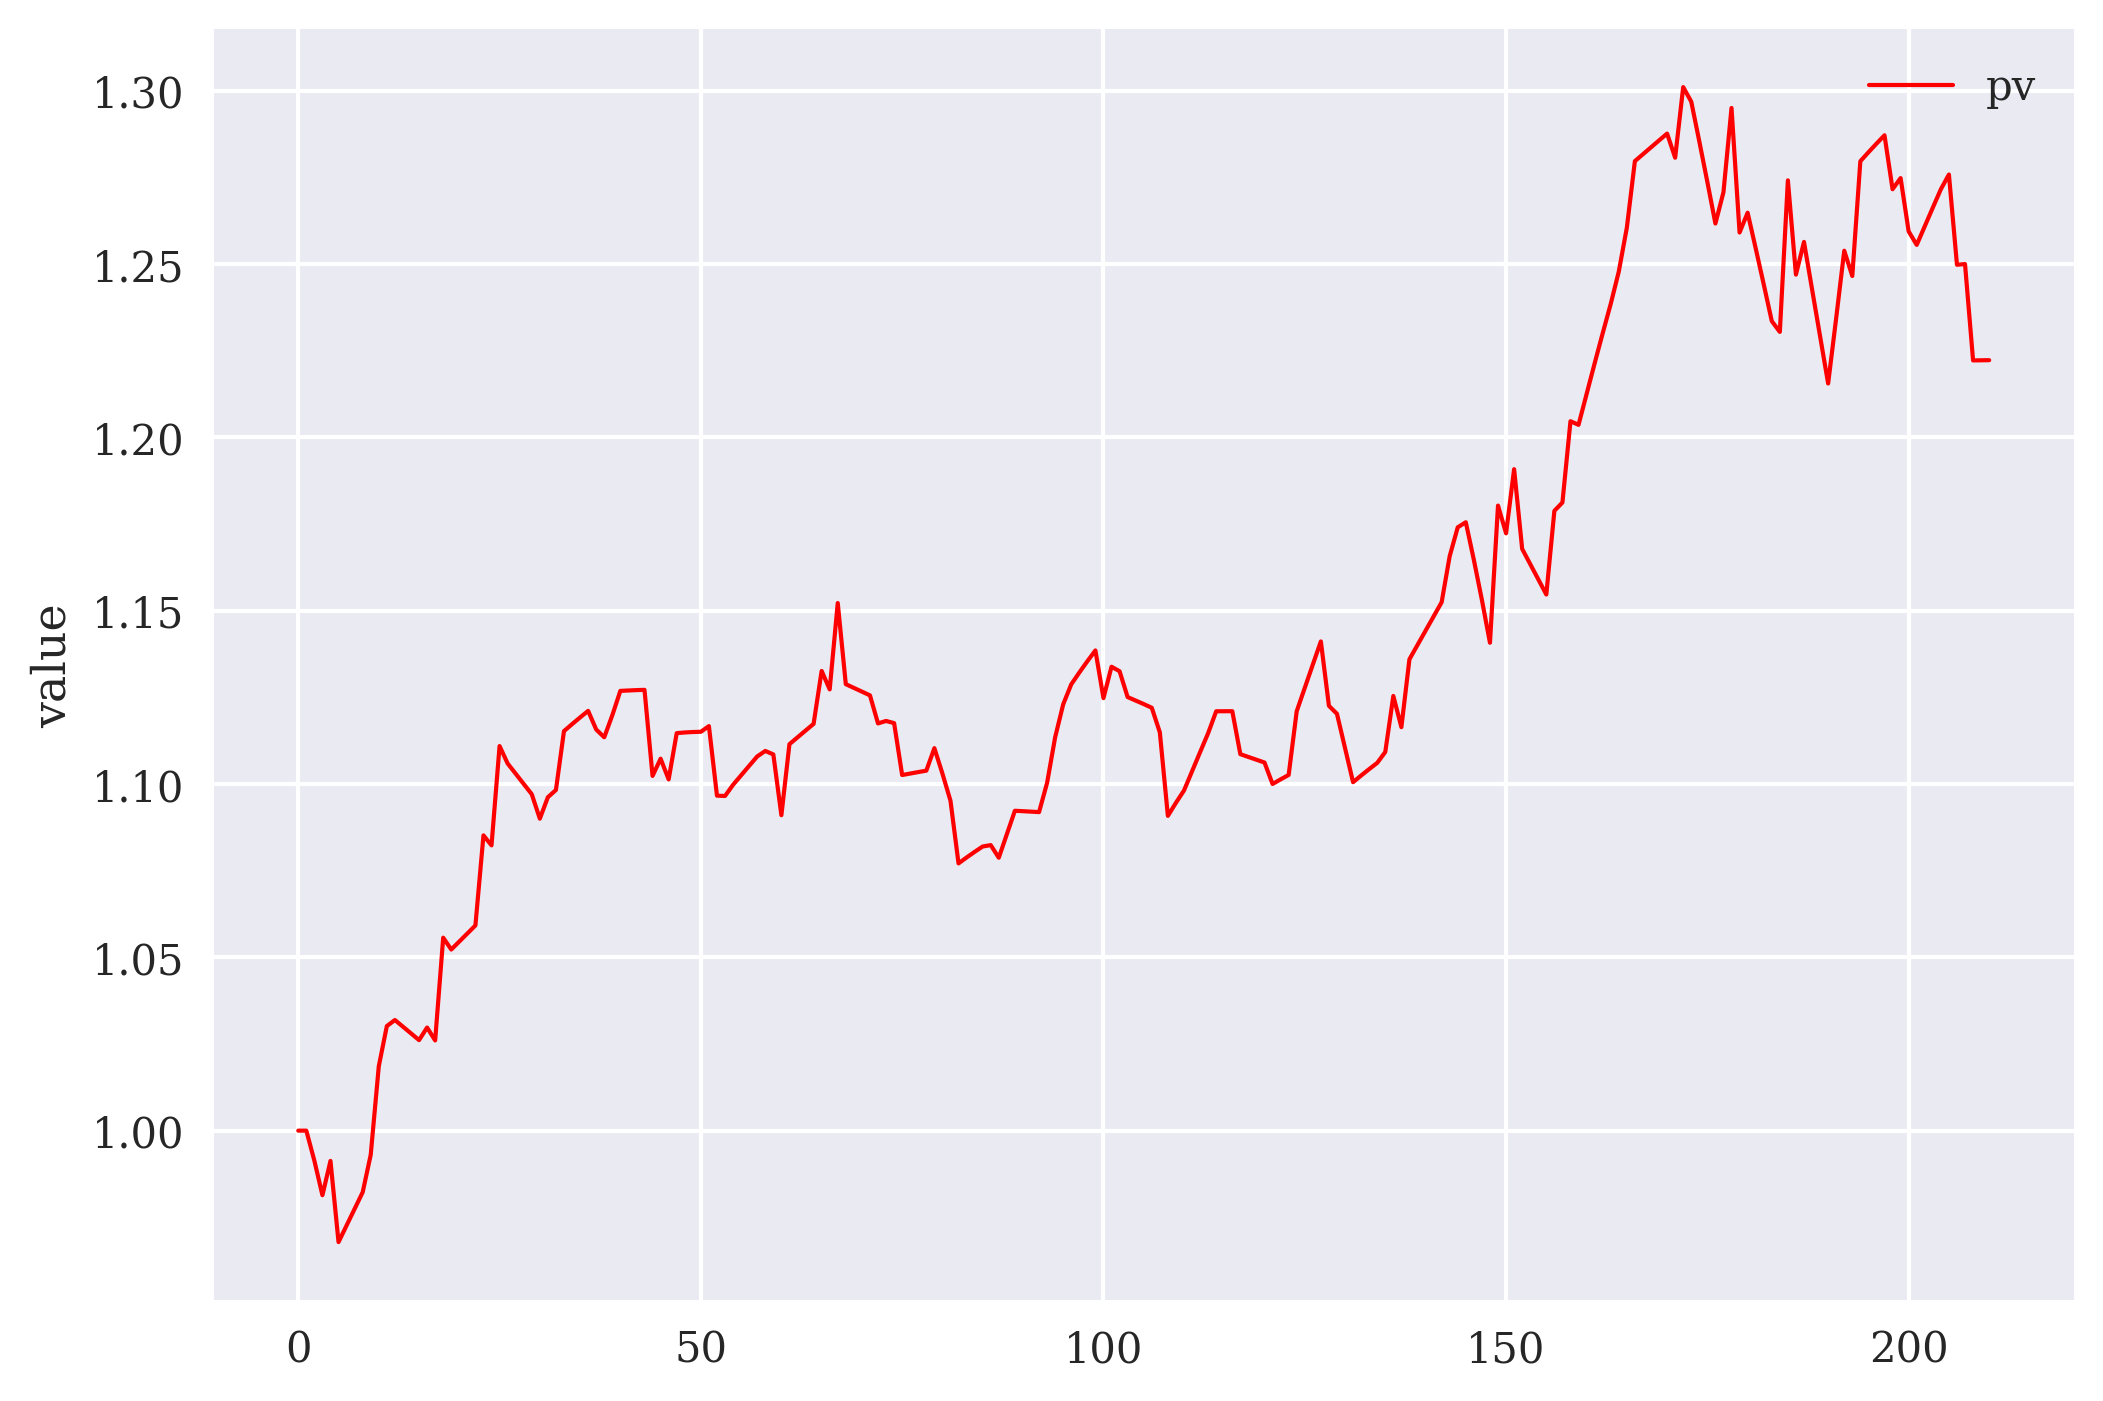

In [48]:
investing.portfolios[["pv"]].plot(style=['r-'], lw=1)
plt.ylabel('value');

In [49]:
investing.portfolios[["date", "pv"]].to_csv("data/_standard_portfolio_value.csv", index=False)

In [26]:
class InvestingAgent(DQLAgent):
    def _create_model(self, hu, lr):
        self.model = Sequential()
        self.model.add(Dense(hu, input_dim=self.n_features, activation='relu'))
        self.model.add(Dense(hu, activation='relu'))
        self.model.add(Dense(1, activation='linear'))
        
        model_path = 'models/portfolio_opt_4_asset_model_v2.h5'
        #if os.path.isfile(model_path):
        #    self.model.load_weights(model_path)

        self.huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
        self.optimizer = Adam(learning_rate=lr)
        #self.model.compile(loss='mse', optimizer=Adam(learning_rate=lr))       
       
    def opt_action(self, state):
        num_stocks = 5
        bnds = num_stocks * [(0.0, 1.)]
        cons = [{'type': 'eq', 'fun': lambda x: x.sum() - 1}]
        def f(state, x):
            s = state.copy()
            s[0,-num_stocks:] = x
            pen = np.mean((state[0, -num_stocks:] - x) ** 2)
            return self.model(s)[0, 0] - pen
        try:
            state = self._reshape(state)
            self.action = minimize(lambda x: -f(state, x),
                                   num_stocks * [1 / num_stocks],
                                   bounds=bnds,
                                   constraints=cons,
                                   options={
                                       'eps': 1e-4,
                                        },
                                   method='SLSQP'
                                  )['x']
        except:
            #self.action = self.env.action_space.sample()
            print("-----------------------------------------------")
            print("No solution!")
            print("-----------------------------------------------")
        return self.action
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return self.env.action_space.sample()
        action = self.opt_action(state)
        return action

    def get_discounted_return(self, rewards, standardize = True):
          
        n = tf.shape(rewards)[0]
        G = tf.TensorArray(dtype=tf.float32, size=n)
        
        # Start from the end of `rewards` and accumulate reward sums
        # into the `returns` array
        rewards = tf.cast(rewards[::-1], dtype=tf.float32)
        discounted_sum = tf.constant(0.0)
        discounted_sum_shape = discounted_sum.shape
        for i in tf.range(n):
            reward = rewards[i]
            discounted_sum = reward + self.gamma * discounted_sum
            discounted_sum.set_shape(discounted_sum_shape)
            G = G.write(i, discounted_sum)
        G = G.stack()[::-1]
        
        if standardize:
            G = ((G - tf.math.reduce_mean(G)) / (tf.math.reduce_std(G) + eps))
        
        return G
    
    def replay(self):
        #batch = random.sample(self.memory, self.batch_size)
        
        states, actions, next_states, rewards, dones = [],[],[],[],[]
        
        for state, action, next_state, reward, done in self.memory:
            states.append(state[0,:])
            actions.append(action[0])
            next_states.append(next_state[0,:])
            rewards.append(reward)
            dones.append(done)
                    
        states = tf.convert_to_tensor(np.array(states),dtype=tf.float32)
        actions = tf.convert_to_tensor(np.array(actions), dtype=tf.float32)
        next_states = tf.convert_to_tensor(np.array(next_states), dtype=tf.float32)
        rewards = tf.convert_to_tensor(np.array(rewards),dtype=tf.float32)
        dones = tf.convert_to_tensor(np.array(dones).astype(np.uint8),dtype=tf.float32) 
        indices = tf.range(start=0, limit=tf.shape(rewards)[0], dtype=tf.int32)
       
        with tf.GradientTape() as tape:
            values = tf.squeeze(self.model(states))
            G = self.get_discounted_return(rewards)
            idx = tf.random.shuffle(indices)[:self.batch_size]
            values = tf.gather(values, idx)
            G = tf.gather(G, idx)
            loss =  self.huber_loss(G, values)
            
        gradients = tape.gradient(loss, self.model.trainable_variables)        
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.model.save('models/portfolio_opt_4_asset_model_v2.h5')
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def test(self, episodes, verbose=True):
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for _ in range(1, len(self.env.data) + 1):
                action = self.opt_action(state)
                state, reward, done, trunc, _ = self.env.step(action)
                state = self._reshape(state)
                treward += reward
                if done:
                    templ = f'episode={e} | '
                    templ += f'total reward={treward:4.2f}'
                    if verbose:
                        print(templ, end='\r')
                    break
        print()

In [27]:
#agent.get_discounted_return([0,0,0,10], standardize=False)

In [28]:
agent = InvestingAgent('3AC', feature=None, n_features=investing.osn, env=investing, hu=256, lr=0.0001)
#agent.epsilon = 0.1
agent.gamma = 0.99

2025-04-02 12:30:44.638301: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-02 12:30:45.010232: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-02 12:30:45.010675: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Train agent

In [24]:
%%time
episodes = 2_000

agent.learn(episodes)

  0%|                                                                                                                                                                                                                         | 0/2000 [00:00<?, ?it/s]

episode=   1 | epsilon=  1.000 | treward=  0.617 | max=  0.617


  0%|▏                                                                                                                                                                                                                | 2/2000 [00:02<30:21,  1.10it/s]

episode=   2 | epsilon=  0.995 | treward=  0.726 | max=  0.726


  0%|▎                                                                                                                                                                                                                | 3/2000 [00:02<21:44,  1.53it/s]

episode=   3 | epsilon=  0.990 | treward=  0.878 | max=  0.878


  0%|▍                                                                                                                                                                                                                | 4/2000 [00:02<15:46,  2.11it/s]

episode=   4 | epsilon=  0.985 | treward=  2.215 | max=  2.215


  0%|▌                                                                                                                                                                                                                | 5/2000 [00:03<16:23,  2.03it/s]

episode=   5 | epsilon=  0.980 | treward=  1.234 | max=  2.215


  0%|▋                                                                                                                                                                                                                | 6/2000 [00:03<14:27,  2.30it/s]

episode=   6 | epsilon=  0.975 | treward=  1.642 | max=  2.215


  0%|▋                                                                                                                                                                                                                | 7/2000 [00:03<14:52,  2.23it/s]

episode=   7 | epsilon=  0.970 | treward=  0.352 | max=  2.215


  0%|▊                                                                                                                                                                                                                | 8/2000 [00:04<13:41,  2.43it/s]

episode=   8 | epsilon=  0.966 | treward=  0.847 | max=  2.215


  0%|▉                                                                                                                                                                                                                | 9/2000 [00:04<16:56,  1.96it/s]

episode=   9 | epsilon=  0.961 | treward=  1.146 | max=  2.215


  0%|█                                                                                                                                                                                                               | 10/2000 [00:06<23:56,  1.39it/s]

episode=  10 | epsilon=  0.956 | treward=  1.190 | max=  2.215


  1%|█▏                                                                                                                                                                                                              | 11/2000 [00:07<27:32,  1.20it/s]

episode=  11 | epsilon=  0.951 | treward=  0.824 | max=  2.215


  1%|█▏                                                                                                                                                                                                              | 12/2000 [00:08<32:49,  1.01it/s]

episode=  12 | epsilon=  0.946 | treward=  0.883 | max=  2.215


  1%|█▎                                                                                                                                                                                                              | 13/2000 [00:09<34:28,  1.04s/it]

episode=  13 | epsilon=  0.942 | treward=  0.205 | max=  2.215


  1%|█▍                                                                                                                                                                                                              | 14/2000 [00:10<28:10,  1.17it/s]

episode=  14 | epsilon=  0.937 | treward=  0.829 | max=  2.215


  1%|█▌                                                                                                                                                                                                              | 15/2000 [00:10<25:53,  1.28it/s]

episode=  15 | epsilon=  0.932 | treward=  0.947 | max=  2.215


  1%|█▋                                                                                                                                                                                                              | 16/2000 [00:12<31:21,  1.05it/s]

episode=  16 | epsilon=  0.928 | treward=  0.254 | max=  2.215


  1%|█▊                                                                                                                                                                                                              | 17/2000 [00:13<36:48,  1.11s/it]

episode=  17 | epsilon=  0.923 | treward=  0.859 | max=  2.215


  1%|█▊                                                                                                                                                                                                              | 18/2000 [00:15<40:09,  1.22s/it]

episode=  18 | epsilon=  0.918 | treward=  0.635 | max=  2.215


  1%|█▉                                                                                                                                                                                                              | 19/2000 [00:15<35:00,  1.06s/it]

episode=  19 | epsilon=  0.914 | treward=  1.876 | max=  2.215


  1%|██                                                                                                                                                                                                              | 20/2000 [00:18<48:04,  1.46s/it]

episode=  20 | epsilon=  0.909 | treward=  0.212 | max=  2.215


  1%|██▏                                                                                                                                                                                                             | 21/2000 [00:19<48:11,  1.46s/it]

episode=  21 | epsilon=  0.905 | treward=  0.922 | max=  2.215


  1%|██▎                                                                                                                                                                                                             | 22/2000 [00:21<47:39,  1.45s/it]

episode=  22 | epsilon=  0.900 | treward=  0.972 | max=  2.215


  1%|██▍                                                                                                                                                                                                             | 23/2000 [00:21<39:59,  1.21s/it]

episode=  23 | epsilon=  0.896 | treward= -0.053 | max=  2.215


  1%|██▍                                                                                                                                                                                                             | 24/2000 [00:22<39:01,  1.18s/it]

episode=  24 | epsilon=  0.891 | treward=  0.475 | max=  2.215


  1%|██▌                                                                                                                                                                                                             | 25/2000 [00:23<38:34,  1.17s/it]

episode=  25 | epsilon=  0.887 | treward= -0.014 | max=  2.215


  1%|██▋                                                                                                                                                                                                             | 26/2000 [00:25<43:53,  1.33s/it]

episode=  26 | epsilon=  0.882 | treward=  1.211 | max=  2.215


  1%|██▊                                                                                                                                                                                                             | 27/2000 [00:28<57:10,  1.74s/it]

episode=  27 | epsilon=  0.878 | treward=  1.694 | max=  2.215


  1%|██▉                                                                                                                                                                                                             | 28/2000 [00:29<47:06,  1.43s/it]

episode=  28 | epsilon=  0.873 | treward=  0.235 | max=  2.215


  1%|███                                                                                                                                                                                                             | 29/2000 [00:31<52:20,  1.59s/it]

episode=  29 | epsilon=  0.869 | treward=  1.653 | max=  2.215


  2%|███                                                                                                                                                                                                             | 30/2000 [00:33<58:45,  1.79s/it]

episode=  30 | epsilon=  0.865 | treward= -0.759 | max=  2.215


  2%|███▏                                                                                                                                                                                                            | 31/2000 [00:34<54:29,  1.66s/it]

episode=  31 | epsilon=  0.860 | treward=  1.292 | max=  2.215


  2%|███▎                                                                                                                                                                                                            | 32/2000 [00:36<51:16,  1.56s/it]

episode=  32 | epsilon=  0.856 | treward=  0.921 | max=  2.215


  2%|███▍                                                                                                                                                                                                            | 33/2000 [00:36<45:28,  1.39s/it]

episode=  33 | epsilon=  0.852 | treward=  1.069 | max=  2.215


  2%|███▌                                                                                                                                                                                                            | 34/2000 [00:39<52:43,  1.61s/it]

episode=  34 | epsilon=  0.848 | treward=  1.508 | max=  2.215


  2%|███▌                                                                                                                                                                                                          | 35/2000 [00:42<1:10:39,  2.16s/it]

episode=  35 | epsilon=  0.843 | treward=  1.787 | max=  2.215


  2%|███▋                                                                                                                                                                                                          | 36/2000 [00:44<1:06:44,  2.04s/it]

episode=  36 | epsilon=  0.839 | treward=  0.670 | max=  2.215


  2%|███▊                                                                                                                                                                                                          | 37/2000 [00:46<1:04:01,  1.96s/it]

episode=  37 | epsilon=  0.835 | treward=  0.103 | max=  2.215


  2%|███▉                                                                                                                                                                                                          | 38/2000 [00:48<1:11:37,  2.19s/it]

episode=  38 | epsilon=  0.831 | treward=  1.617 | max=  2.215


  2%|████                                                                                                                                                                                                          | 39/2000 [00:50<1:07:45,  2.07s/it]

episode=  39 | epsilon=  0.827 | treward=  0.860 | max=  2.215


  2%|████                                                                                                                                                                                                          | 40/2000 [00:53<1:12:21,  2.22s/it]

episode=  40 | epsilon=  0.822 | treward=  0.364 | max=  2.215


  2%|████▏                                                                                                                                                                                                         | 41/2000 [00:55<1:11:21,  2.19s/it]

episode=  41 | epsilon=  0.818 | treward=  0.437 | max=  2.215


  2%|████▎                                                                                                                                                                                                         | 42/2000 [00:58<1:17:33,  2.38s/it]

episode=  42 | epsilon=  0.814 | treward=  1.074 | max=  2.215


  2%|████▍                                                                                                                                                                                                         | 43/2000 [01:00<1:22:01,  2.51s/it]

episode=  43 | epsilon=  0.810 | treward=  1.002 | max=  2.215


  2%|████▌                                                                                                                                                                                                         | 44/2000 [01:03<1:22:05,  2.52s/it]

episode=  44 | epsilon=  0.806 | treward=  0.748 | max=  2.215


  2%|████▋                                                                                                                                                                                                         | 45/2000 [01:05<1:21:33,  2.50s/it]

episode=  45 | epsilon=  0.802 | treward=  0.792 | max=  2.215


  2%|████▋                                                                                                                                                                                                         | 46/2000 [01:07<1:17:12,  2.37s/it]

episode=  46 | epsilon=  0.798 | treward= -0.060 | max=  2.215


  2%|████▊                                                                                                                                                                                                         | 47/2000 [01:10<1:15:01,  2.30s/it]

episode=  47 | epsilon=  0.794 | treward=  0.664 | max=  2.215


  2%|████▉                                                                                                                                                                                                         | 48/2000 [01:12<1:14:33,  2.29s/it]

episode=  48 | epsilon=  0.790 | treward= -0.159 | max=  2.215


  2%|█████                                                                                                                                                                                                         | 49/2000 [01:15<1:22:44,  2.54s/it]

episode=  49 | epsilon=  0.786 | treward=  0.860 | max=  2.215


  2%|█████▏                                                                                                                                                                                                        | 50/2000 [01:18<1:28:52,  2.73s/it]

episode=  50 | epsilon=  0.782 | treward=  0.875 | max=  2.215


  3%|█████▎                                                                                                                                                                                                        | 51/2000 [01:22<1:39:18,  3.06s/it]

episode=  51 | epsilon=  0.778 | treward= -0.507 | max=  2.215


  3%|█████▎                                                                                                                                                                                                        | 52/2000 [01:25<1:40:46,  3.10s/it]

episode=  52 | epsilon=  0.774 | treward= -0.123 | max=  2.215


  3%|█████▍                                                                                                                                                                                                        | 53/2000 [01:29<1:43:33,  3.19s/it]

episode=  53 | epsilon=  0.771 | treward=  1.616 | max=  2.215


  3%|█████▌                                                                                                                                                                                                        | 54/2000 [01:32<1:48:18,  3.34s/it]

episode=  54 | epsilon=  0.767 | treward=  1.255 | max=  2.215


  3%|█████▋                                                                                                                                                                                                        | 55/2000 [01:35<1:45:28,  3.25s/it]

episode=  55 | epsilon=  0.763 | treward=  0.708 | max=  2.215


  3%|█████▊                                                                                                                                                                                                        | 56/2000 [01:38<1:42:52,  3.18s/it]

episode=  56 | epsilon=  0.759 | treward=  0.223 | max=  2.215


  3%|█████▊                                                                                                                                                                                                        | 57/2000 [01:41<1:42:17,  3.16s/it]

episode=  57 | epsilon=  0.755 | treward=  0.564 | max=  2.215


  3%|█████▉                                                                                                                                                                                                        | 58/2000 [01:45<1:44:23,  3.23s/it]

episode=  58 | epsilon=  0.751 | treward=  1.828 | max=  2.215


  3%|██████                                                                                                                                                                                                        | 59/2000 [01:49<1:50:32,  3.42s/it]

episode=  59 | epsilon=  0.748 | treward=  0.975 | max=  2.215


  3%|██████▏                                                                                                                                                                                                       | 60/2000 [01:51<1:44:03,  3.22s/it]

episode=  60 | epsilon=  0.744 | treward=  0.426 | max=  2.215


  3%|██████▎                                                                                                                                                                                                       | 61/2000 [01:54<1:36:37,  2.99s/it]

episode=  61 | epsilon=  0.740 | treward=  1.258 | max=  2.215


  3%|██████▍                                                                                                                                                                                                       | 62/2000 [01:58<1:42:27,  3.17s/it]

episode=  62 | epsilon=  0.737 | treward=  1.315 | max=  2.215


  3%|██████▍                                                                                                                                                                                                       | 63/2000 [02:01<1:44:59,  3.25s/it]

episode=  63 | epsilon=  0.733 | treward=  0.799 | max=  2.215


  3%|██████▌                                                                                                                                                                                                       | 64/2000 [02:04<1:42:09,  3.17s/it]

episode=  64 | epsilon=  0.729 | treward=  1.131 | max=  2.215


  3%|██████▋                                                                                                                                                                                                       | 65/2000 [02:08<1:48:53,  3.38s/it]

episode=  65 | epsilon=  0.726 | treward=  0.472 | max=  2.215


  3%|██████▊                                                                                                                                                                                                       | 66/2000 [02:11<1:46:53,  3.32s/it]

episode=  66 | epsilon=  0.722 | treward=  1.246 | max=  2.215


  3%|██████▉                                                                                                                                                                                                       | 67/2000 [02:15<1:58:11,  3.67s/it]

episode=  67 | epsilon=  0.718 | treward=  0.866 | max=  2.215


  3%|███████                                                                                                                                                                                                       | 68/2000 [02:19<1:55:49,  3.60s/it]

episode=  68 | epsilon=  0.715 | treward=  0.558 | max=  2.215


  3%|███████                                                                                                                                                                                                       | 69/2000 [02:22<1:51:35,  3.47s/it]

episode=  69 | epsilon=  0.711 | treward= -0.011 | max=  2.215


  4%|███████▏                                                                                                                                                                                                      | 70/2000 [02:27<2:02:38,  3.81s/it]

episode=  70 | epsilon=  0.708 | treward= -0.604 | max=  2.215


  4%|███████▎                                                                                                                                                                                                      | 71/2000 [02:32<2:13:43,  4.16s/it]

episode=  71 | epsilon=  0.704 | treward=  0.524 | max=  2.215


  4%|███████▍                                                                                                                                                                                                      | 72/2000 [02:37<2:20:27,  4.37s/it]

episode=  72 | epsilon=  0.701 | treward=  1.563 | max=  2.215


  4%|███████▌                                                                                                                                                                                                      | 73/2000 [02:41<2:21:21,  4.40s/it]

episode=  73 | epsilon=  0.697 | treward=  0.414 | max=  2.215


  4%|███████▌                                                                                                                                                                                                      | 74/2000 [02:45<2:13:47,  4.17s/it]

episode=  74 | epsilon=  0.694 | treward= -0.253 | max=  2.215


  4%|███████▋                                                                                                                                                                                                      | 75/2000 [02:48<2:06:08,  3.93s/it]

episode=  75 | epsilon=  0.690 | treward=  0.588 | max=  2.215


  4%|███████▊                                                                                                                                                                                                      | 76/2000 [02:53<2:16:09,  4.25s/it]

episode=  76 | epsilon=  0.687 | treward=  0.262 | max=  2.215


  4%|███████▉                                                                                                                                                                                                      | 77/2000 [02:58<2:24:43,  4.52s/it]

episode=  77 | epsilon=  0.683 | treward=  0.063 | max=  2.215


  4%|████████                                                                                                                                                                                                      | 78/2000 [03:02<2:17:30,  4.29s/it]

episode=  78 | epsilon=  0.680 | treward=  0.228 | max=  2.215


  4%|████████▏                                                                                                                                                                                                     | 79/2000 [03:07<2:21:34,  4.42s/it]

episode=  79 | epsilon=  0.676 | treward=  1.041 | max=  2.215


  4%|████████▏                                                                                                                                                                                                     | 80/2000 [03:10<2:13:32,  4.17s/it]

episode=  80 | epsilon=  0.673 | treward=  1.579 | max=  2.215


  4%|████████▎                                                                                                                                                                                                     | 81/2000 [03:15<2:22:21,  4.45s/it]

episode=  81 | epsilon=  0.670 | treward=  0.010 | max=  2.215


  4%|████████▍                                                                                                                                                                                                     | 82/2000 [03:19<2:16:47,  4.28s/it]

episode=  82 | epsilon=  0.666 | treward=  0.132 | max=  2.215


  4%|████████▌                                                                                                                                                                                                     | 83/2000 [03:24<2:17:42,  4.31s/it]

episode=  83 | epsilon=  0.663 | treward=  0.236 | max=  2.215


  4%|████████▋                                                                                                                                                                                                     | 84/2000 [03:27<2:09:07,  4.04s/it]

episode=  84 | epsilon=  0.660 | treward=  1.155 | max=  2.215


  4%|████████▊                                                                                                                                                                                                     | 85/2000 [03:33<2:27:37,  4.63s/it]

episode=  85 | epsilon=  0.656 | treward=  0.013 | max=  2.215


  4%|████████▊                                                                                                                                                                                                     | 86/2000 [03:38<2:35:03,  4.86s/it]

episode=  86 | epsilon=  0.653 | treward=  0.033 | max=  2.215


  4%|████████▉                                                                                                                                                                                                     | 87/2000 [03:44<2:39:05,  4.99s/it]

episode=  87 | epsilon=  0.650 | treward=  0.953 | max=  2.215


  4%|█████████                                                                                                                                                                                                     | 88/2000 [03:48<2:36:51,  4.92s/it]

episode=  88 | epsilon=  0.647 | treward=  0.425 | max=  2.215


  4%|█████████▏                                                                                                                                                                                                    | 89/2000 [03:53<2:36:52,  4.93s/it]

episode=  89 | epsilon=  0.643 | treward=  0.980 | max=  2.215


  4%|█████████▎                                                                                                                                                                                                    | 90/2000 [03:58<2:33:53,  4.83s/it]

episode=  90 | epsilon=  0.640 | treward=  0.815 | max=  2.215


  5%|█████████▎                                                                                                                                                                                                    | 91/2000 [04:03<2:32:09,  4.78s/it]

episode=  91 | epsilon=  0.637 | treward=  0.348 | max=  2.215


  5%|█████████▍                                                                                                                                                                                                    | 92/2000 [04:06<2:22:36,  4.48s/it]

episode=  92 | epsilon=  0.634 | treward=  0.912 | max=  2.215


  5%|█████████▌                                                                                                                                                                                                    | 93/2000 [04:12<2:28:12,  4.66s/it]

episode=  93 | epsilon=  0.631 | treward= -0.007 | max=  2.215


  5%|█████████▋                                                                                                                                                                                                    | 94/2000 [04:17<2:33:03,  4.82s/it]

episode=  94 | epsilon=  0.627 | treward=  0.268 | max=  2.215


  5%|█████████▊                                                                                                                                                                                                    | 95/2000 [04:22<2:38:18,  4.99s/it]

episode=  95 | epsilon=  0.624 | treward=  0.835 | max=  2.215


  5%|█████████▉                                                                                                                                                                                                    | 96/2000 [04:27<2:35:52,  4.91s/it]

episode=  96 | epsilon=  0.621 | treward=  0.836 | max=  2.215


  5%|█████████▉                                                                                                                                                                                                    | 97/2000 [04:31<2:32:19,  4.80s/it]

episode=  97 | epsilon=  0.618 | treward=  0.906 | max=  2.215


  5%|██████████                                                                                                                                                                                                    | 98/2000 [04:37<2:43:55,  5.17s/it]

episode=  98 | epsilon=  0.615 | treward=  0.222 | max=  2.215


  5%|██████████▏                                                                                                                                                                                                   | 99/2000 [04:42<2:34:19,  4.87s/it]

episode=  99 | epsilon=  0.612 | treward= -0.295 | max=  2.215


  5%|██████████▎                                                                                                                                                                                                  | 100/2000 [04:45<2:24:14,  4.55s/it]

episode= 100 | epsilon=  0.609 | treward=  0.386 | max=  2.215


  5%|██████████▎                                                                                                                                                                                                  | 101/2000 [04:51<2:32:58,  4.83s/it]

episode= 101 | epsilon=  0.606 | treward=  0.572 | max=  2.215


  5%|██████████▍                                                                                                                                                                                                  | 102/2000 [04:56<2:37:42,  4.99s/it]

episode= 102 | epsilon=  0.603 | treward= -0.008 | max=  2.215


  5%|██████████▌                                                                                                                                                                                                  | 103/2000 [05:00<2:23:45,  4.55s/it]

episode= 103 | epsilon=  0.600 | treward=  0.880 | max=  2.215


  5%|██████████▋                                                                                                                                                                                                  | 104/2000 [05:07<2:49:43,  5.37s/it]

episode= 104 | epsilon=  0.597 | treward=  0.762 | max=  2.215


  5%|██████████▊                                                                                                                                                                                                  | 105/2000 [05:12<2:47:11,  5.29s/it]

episode= 105 | epsilon=  0.594 | treward= -0.220 | max=  2.215


  5%|██████████▊                                                                                                                                                                                                  | 106/2000 [05:17<2:47:20,  5.30s/it]

episode= 106 | epsilon=  0.591 | treward=  1.127 | max=  2.215


  5%|██████████▉                                                                                                                                                                                                  | 107/2000 [05:23<2:46:57,  5.29s/it]

episode= 107 | epsilon=  0.588 | treward=  0.751 | max=  2.215


  5%|███████████                                                                                                                                                                                                  | 108/2000 [05:28<2:46:07,  5.27s/it]

episode= 108 | epsilon=  0.585 | treward=  1.668 | max=  2.215


  5%|███████████▏                                                                                                                                                                                                 | 109/2000 [05:33<2:43:58,  5.20s/it]

episode= 109 | epsilon=  0.582 | treward=  0.871 | max=  2.215


  6%|███████████▎                                                                                                                                                                                                 | 110/2000 [05:39<2:48:45,  5.36s/it]

episode= 110 | epsilon=  0.579 | treward= -0.976 | max=  2.215


  6%|███████████▍                                                                                                                                                                                                 | 111/2000 [05:44<2:51:00,  5.43s/it]

episode= 111 | epsilon=  0.576 | treward=  0.258 | max=  2.215


  6%|███████████▍                                                                                                                                                                                                 | 112/2000 [05:49<2:45:12,  5.25s/it]

episode= 112 | epsilon=  0.573 | treward=  0.099 | max=  2.215


  6%|███████████▌                                                                                                                                                                                                 | 113/2000 [05:55<2:48:15,  5.35s/it]

episode= 113 | epsilon=  0.570 | treward=  0.426 | max=  2.215


  6%|███████████▋                                                                                                                                                                                                 | 114/2000 [06:01<2:58:47,  5.69s/it]

episode= 114 | epsilon=  0.568 | treward=  0.433 | max=  2.215


  6%|███████████▊                                                                                                                                                                                                 | 115/2000 [06:07<2:57:54,  5.66s/it]

episode= 115 | epsilon=  0.565 | treward=  0.498 | max=  2.215


  6%|███████████▉                                                                                                                                                                                                 | 116/2000 [06:12<2:55:57,  5.60s/it]

episode= 116 | epsilon=  0.562 | treward=  0.858 | max=  2.215


  6%|███████████▉                                                                                                                                                                                                 | 117/2000 [06:18<2:58:45,  5.70s/it]

episode= 117 | epsilon=  0.559 | treward=  0.852 | max=  2.215


  6%|████████████                                                                                                                                                                                                 | 118/2000 [06:25<3:05:31,  5.91s/it]

episode= 118 | epsilon=  0.556 | treward= -0.025 | max=  2.215


  6%|████████████▏                                                                                                                                                                                                | 119/2000 [06:32<3:17:13,  6.29s/it]

episode= 119 | epsilon=  0.554 | treward= -0.518 | max=  2.215


  6%|████████████▎                                                                                                                                                                                                | 120/2000 [06:37<3:09:48,  6.06s/it]

episode= 120 | epsilon=  0.551 | treward=  0.400 | max=  2.215


  6%|████████████▍                                                                                                                                                                                                | 121/2000 [06:42<2:57:40,  5.67s/it]

episode= 121 | epsilon=  0.548 | treward=  1.494 | max=  2.215


  6%|████████████▌                                                                                                                                                                                                | 122/2000 [06:47<2:49:59,  5.43s/it]

episode= 122 | epsilon=  0.545 | treward=  0.506 | max=  2.215


  6%|████████████▌                                                                                                                                                                                                | 123/2000 [06:53<2:58:35,  5.71s/it]

episode= 123 | epsilon=  0.543 | treward=  1.139 | max=  2.215


  6%|████████████▋                                                                                                                                                                                                | 124/2000 [06:58<2:53:19,  5.54s/it]

episode= 124 | epsilon=  0.540 | treward=  0.505 | max=  2.215


  6%|████████████▊                                                                                                                                                                                                | 125/2000 [07:04<2:57:51,  5.69s/it]

episode= 125 | epsilon=  0.537 | treward= -0.188 | max=  2.215


  6%|████████████▉                                                                                                                                                                                                | 126/2000 [07:09<2:43:48,  5.24s/it]

episode= 126 | epsilon=  0.534 | treward=  0.913 | max=  2.215


  6%|█████████████                                                                                                                                                                                                | 127/2000 [07:15<2:57:03,  5.67s/it]

episode= 127 | epsilon=  0.532 | treward=  0.385 | max=  2.215


  6%|█████████████                                                                                                                                                                                                | 128/2000 [07:21<2:57:10,  5.68s/it]

episode= 128 | epsilon=  0.529 | treward=  0.311 | max=  2.215


  6%|█████████████▏                                                                                                                                                                                               | 129/2000 [07:27<3:04:09,  5.91s/it]

episode= 129 | epsilon=  0.526 | treward=  2.206 | max=  2.215


  6%|█████████████▎                                                                                                                                                                                               | 130/2000 [07:33<3:01:32,  5.82s/it]

episode= 130 | epsilon=  0.524 | treward=  0.890 | max=  2.215


  7%|█████████████▍                                                                                                                                                                                               | 131/2000 [07:38<2:49:34,  5.44s/it]

episode= 131 | epsilon=  0.521 | treward=  0.612 | max=  2.215


  7%|█████████████▌                                                                                                                                                                                               | 132/2000 [07:43<2:49:34,  5.45s/it]

episode= 132 | epsilon=  0.519 | treward=  0.042 | max=  2.215


  7%|█████████████▋                                                                                                                                                                                               | 133/2000 [07:50<3:05:14,  5.95s/it]

episode= 133 | epsilon=  0.516 | treward=  0.773 | max=  2.215


  7%|█████████████▋                                                                                                                                                                                               | 134/2000 [07:56<3:00:36,  5.81s/it]

episode= 134 | epsilon=  0.513 | treward=  0.839 | max=  2.215


  7%|█████████████▊                                                                                                                                                                                               | 135/2000 [08:01<2:51:13,  5.51s/it]

episode= 135 | epsilon=  0.511 | treward=  1.517 | max=  2.215


  7%|█████████████▉                                                                                                                                                                                               | 136/2000 [08:06<2:47:22,  5.39s/it]

episode= 136 | epsilon=  0.508 | treward=  0.524 | max=  2.215


  7%|██████████████                                                                                                                                                                                               | 137/2000 [08:12<3:00:41,  5.82s/it]

episode= 137 | epsilon=  0.506 | treward=  0.781 | max=  2.215


  7%|██████████████▏                                                                                                                                                                                              | 138/2000 [08:19<3:02:45,  5.89s/it]

episode= 138 | epsilon=  0.503 | treward=  0.435 | max=  2.215


  7%|██████████████▏                                                                                                                                                                                              | 139/2000 [08:24<3:02:38,  5.89s/it]

episode= 139 | epsilon=  0.501 | treward=  0.507 | max=  2.215


  7%|██████████████▎                                                                                                                                                                                              | 140/2000 [08:31<3:05:27,  5.98s/it]

episode= 140 | epsilon=  0.498 | treward=  0.051 | max=  2.215


  7%|██████████████▍                                                                                                                                                                                              | 141/2000 [08:38<3:13:54,  6.26s/it]

episode= 141 | epsilon=  0.496 | treward=  0.347 | max=  2.215


  7%|██████████████▌                                                                                                                                                                                              | 142/2000 [08:44<3:12:38,  6.22s/it]

episode= 142 | epsilon=  0.493 | treward=  0.270 | max=  2.215


  7%|██████████████▋                                                                                                                                                                                              | 143/2000 [08:50<3:15:21,  6.31s/it]

episode= 143 | epsilon=  0.491 | treward=  0.069 | max=  2.215


  7%|██████████████▊                                                                                                                                                                                              | 144/2000 [08:55<3:03:28,  5.93s/it]

episode= 144 | epsilon=  0.488 | treward= -0.126 | max=  2.215


  7%|██████████████▊                                                                                                                                                                                              | 145/2000 [09:02<3:09:30,  6.13s/it]

episode= 145 | epsilon=  0.486 | treward=  0.796 | max=  2.215


  7%|██████████████▉                                                                                                                                                                                              | 146/2000 [09:09<3:22:46,  6.56s/it]

episode= 146 | epsilon=  0.483 | treward=  0.667 | max=  2.215


  7%|███████████████                                                                                                                                                                                              | 147/2000 [09:16<3:21:33,  6.53s/it]

episode= 147 | epsilon=  0.481 | treward=  0.007 | max=  2.215


  7%|███████████████▏                                                                                                                                                                                             | 148/2000 [09:23<3:28:30,  6.75s/it]

episode= 148 | epsilon=  0.479 | treward=  0.116 | max=  2.215


  7%|███████████████▎                                                                                                                                                                                             | 149/2000 [09:30<3:26:42,  6.70s/it]

episode= 149 | epsilon=  0.476 | treward= -0.041 | max=  2.215


  8%|███████████████▍                                                                                                                                                                                             | 150/2000 [09:35<3:16:57,  6.39s/it]

episode= 150 | epsilon=  0.474 | treward=  0.840 | max=  2.215


  8%|███████████████▍                                                                                                                                                                                             | 151/2000 [09:43<3:26:12,  6.69s/it]

episode= 151 | epsilon=  0.471 | treward= -0.393 | max=  2.215


  8%|███████████████▌                                                                                                                                                                                             | 152/2000 [09:49<3:20:41,  6.52s/it]

episode= 152 | epsilon=  0.469 | treward= -0.903 | max=  2.215


  8%|███████████████▋                                                                                                                                                                                             | 153/2000 [09:56<3:22:54,  6.59s/it]

episode= 153 | epsilon=  0.467 | treward=  1.055 | max=  2.215


  8%|███████████████▊                                                                                                                                                                                             | 154/2000 [10:02<3:20:19,  6.51s/it]

episode= 154 | epsilon=  0.464 | treward=  1.654 | max=  2.215


  8%|███████████████▉                                                                                                                                                                                             | 155/2000 [10:08<3:16:43,  6.40s/it]

episode= 155 | epsilon=  0.462 | treward=  0.069 | max=  2.215


  8%|███████████████▉                                                                                                                                                                                             | 156/2000 [10:16<3:27:22,  6.75s/it]

episode= 156 | epsilon=  0.460 | treward= -0.381 | max=  2.215


  8%|████████████████                                                                                                                                                                                             | 157/2000 [10:23<3:34:34,  6.99s/it]

episode= 157 | epsilon=  0.458 | treward=  0.625 | max=  2.215


  8%|████████████████▏                                                                                                                                                                                            | 158/2000 [10:31<3:38:21,  7.11s/it]

episode= 158 | epsilon=  0.455 | treward=  0.311 | max=  2.215


  8%|████████████████▎                                                                                                                                                                                            | 159/2000 [10:38<3:43:21,  7.28s/it]

episode= 159 | epsilon=  0.453 | treward=  0.879 | max=  2.215


  8%|████████████████▍                                                                                                                                                                                            | 160/2000 [10:45<3:36:41,  7.07s/it]

episode= 160 | epsilon=  0.451 | treward=  1.180 | max=  2.215


  8%|████████████████▌                                                                                                                                                                                            | 161/2000 [10:52<3:37:36,  7.10s/it]

episode= 161 | epsilon=  0.448 | treward= -0.017 | max=  2.215


  8%|████████████████▌                                                                                                                                                                                            | 162/2000 [10:59<3:32:40,  6.94s/it]

episode= 162 | epsilon=  0.446 | treward=  0.606 | max=  2.215


  8%|████████████████▋                                                                                                                                                                                            | 163/2000 [11:06<3:34:50,  7.02s/it]

episode= 163 | epsilon=  0.444 | treward= -0.310 | max=  2.215


  8%|████████████████▊                                                                                                                                                                                            | 164/2000 [11:13<3:37:47,  7.12s/it]

episode= 164 | epsilon=  0.442 | treward=  0.109 | max=  2.215


  8%|████████████████▉                                                                                                                                                                                            | 165/2000 [11:20<3:34:38,  7.02s/it]

episode= 165 | epsilon=  0.440 | treward=  1.143 | max=  2.215


  8%|█████████████████                                                                                                                                                                                            | 166/2000 [11:27<3:36:38,  7.09s/it]

episode= 166 | epsilon=  0.437 | treward=  0.947 | max=  2.215


  8%|█████████████████                                                                                                                                                                                            | 167/2000 [11:33<3:26:51,  6.77s/it]

episode= 167 | epsilon=  0.435 | treward=  0.797 | max=  2.215


  8%|█████████████████▏                                                                                                                                                                                           | 168/2000 [11:40<3:25:00,  6.71s/it]

episode= 168 | epsilon=  0.433 | treward=  0.677 | max=  2.215


  8%|█████████████████▎                                                                                                                                                                                           | 169/2000 [11:47<3:31:33,  6.93s/it]

episode= 169 | epsilon=  0.431 | treward=  0.777 | max=  2.215


  8%|█████████████████▍                                                                                                                                                                                           | 170/2000 [11:54<3:25:48,  6.75s/it]

episode= 170 | epsilon=  0.429 | treward=  0.927 | max=  2.215


  9%|█████████████████▌                                                                                                                                                                                           | 171/2000 [12:00<3:26:52,  6.79s/it]

episode= 171 | epsilon=  0.427 | treward=  1.772 | max=  2.215


  9%|█████████████████▋                                                                                                                                                                                           | 172/2000 [12:07<3:25:01,  6.73s/it]

episode= 172 | epsilon=  0.424 | treward=  0.075 | max=  2.215


  9%|█████████████████▋                                                                                                                                                                                           | 173/2000 [12:14<3:31:48,  6.96s/it]

episode= 173 | epsilon=  0.422 | treward=  0.736 | max=  2.215


  9%|█████████████████▊                                                                                                                                                                                           | 174/2000 [12:21<3:23:17,  6.68s/it]

episode= 174 | epsilon=  0.420 | treward= -0.681 | max=  2.215


  9%|█████████████████▉                                                                                                                                                                                           | 175/2000 [12:27<3:24:23,  6.72s/it]

episode= 175 | epsilon=  0.418 | treward= -0.205 | max=  2.215


  9%|██████████████████                                                                                                                                                                                           | 176/2000 [12:35<3:31:16,  6.95s/it]

episode= 176 | epsilon=  0.416 | treward= -0.042 | max=  2.215


  9%|██████████████████▏                                                                                                                                                                                          | 177/2000 [12:43<3:38:54,  7.20s/it]

episode= 177 | epsilon=  0.414 | treward=  0.777 | max=  2.215


  9%|██████████████████▏                                                                                                                                                                                          | 178/2000 [12:50<3:40:03,  7.25s/it]

episode= 178 | epsilon=  0.412 | treward=  0.845 | max=  2.215


  9%|██████████████████▎                                                                                                                                                                                          | 179/2000 [12:57<3:34:29,  7.07s/it]

episode= 179 | epsilon=  0.410 | treward= -0.047 | max=  2.215


  9%|██████████████████▍                                                                                                                                                                                          | 180/2000 [13:04<3:36:44,  7.15s/it]

episode= 180 | epsilon=  0.408 | treward=  1.086 | max=  2.215


  9%|██████████████████▌                                                                                                                                                                                          | 181/2000 [13:12<3:49:00,  7.55s/it]

episode= 181 | epsilon=  0.406 | treward= -0.063 | max=  2.215


  9%|██████████████████▋                                                                                                                                                                                          | 182/2000 [13:19<3:37:37,  7.18s/it]

episode= 182 | epsilon=  0.404 | treward=  1.135 | max=  2.215


  9%|██████████████████▊                                                                                                                                                                                          | 183/2000 [13:25<3:25:57,  6.80s/it]

episode= 183 | epsilon=  0.402 | treward=  1.207 | max=  2.215


  9%|██████████████████▊                                                                                                                                                                                          | 184/2000 [13:33<3:35:19,  7.11s/it]

episode= 184 | epsilon=  0.400 | treward=  1.146 | max=  2.215


  9%|██████████████████▉                                                                                                                                                                                          | 185/2000 [13:39<3:32:44,  7.03s/it]

episode= 185 | epsilon=  0.398 | treward=  0.695 | max=  2.215


  9%|███████████████████                                                                                                                                                                                          | 186/2000 [13:47<3:34:12,  7.08s/it]

episode= 186 | epsilon=  0.396 | treward=  0.450 | max=  2.215


  9%|███████████████████▏                                                                                                                                                                                         | 187/2000 [13:54<3:35:43,  7.14s/it]

episode= 187 | epsilon=  0.394 | treward=  0.403 | max=  2.215


  9%|███████████████████▎                                                                                                                                                                                         | 188/2000 [14:01<3:38:58,  7.25s/it]

episode= 188 | epsilon=  0.392 | treward=  0.776 | max=  2.215


  9%|███████████████████▎                                                                                                                                                                                         | 189/2000 [14:09<3:42:00,  7.36s/it]

episode= 189 | epsilon=  0.390 | treward=  1.307 | max=  2.215


 10%|███████████████████▍                                                                                                                                                                                         | 190/2000 [14:17<3:46:14,  7.50s/it]

episode= 190 | epsilon=  0.388 | treward= -0.282 | max=  2.215


 10%|███████████████████▌                                                                                                                                                                                         | 191/2000 [14:25<3:48:31,  7.58s/it]

episode= 191 | epsilon=  0.386 | treward=  0.458 | max=  2.215


 10%|███████████████████▋                                                                                                                                                                                         | 192/2000 [14:32<3:51:12,  7.67s/it]

episode= 192 | epsilon=  0.384 | treward=  0.368 | max=  2.215


 10%|███████████████████▊                                                                                                                                                                                         | 193/2000 [14:39<3:43:34,  7.42s/it]

episode= 193 | epsilon=  0.382 | treward= -0.434 | max=  2.215


 10%|███████████████████▉                                                                                                                                                                                         | 194/2000 [14:46<3:37:58,  7.24s/it]

episode= 194 | epsilon=  0.380 | treward=  0.267 | max=  2.215


 10%|███████████████████▉                                                                                                                                                                                         | 195/2000 [14:53<3:37:19,  7.22s/it]

episode= 195 | epsilon=  0.378 | treward=  0.176 | max=  2.215


 10%|████████████████████                                                                                                                                                                                         | 196/2000 [15:01<3:46:02,  7.52s/it]

episode= 196 | epsilon=  0.376 | treward=  1.327 | max=  2.215


 10%|████████████████████▏                                                                                                                                                                                        | 197/2000 [15:10<3:52:43,  7.74s/it]

episode= 197 | epsilon=  0.374 | treward=  0.583 | max=  2.215


 10%|████████████████████▎                                                                                                                                                                                        | 198/2000 [15:17<3:44:08,  7.46s/it]

episode= 198 | epsilon=  0.373 | treward=  0.825 | max=  2.215


 10%|████████████████████▍                                                                                                                                                                                        | 199/2000 [15:25<3:54:24,  7.81s/it]

episode= 199 | epsilon=  0.371 | treward= -0.129 | max=  2.215


 10%|████████████████████▌                                                                                                                                                                                        | 200/2000 [15:34<3:59:18,  7.98s/it]

episode= 200 | epsilon=  0.369 | treward= -0.028 | max=  2.215


 10%|████████████████████▌                                                                                                                                                                                        | 201/2000 [15:42<3:59:02,  7.97s/it]

episode= 201 | epsilon=  0.367 | treward=  0.764 | max=  2.215


 10%|████████████████████▋                                                                                                                                                                                        | 202/2000 [15:49<3:58:36,  7.96s/it]

episode= 202 | epsilon=  0.365 | treward=  0.302 | max=  2.215


 10%|████████████████████▊                                                                                                                                                                                        | 203/2000 [15:57<3:53:09,  7.78s/it]

episode= 203 | epsilon=  0.363 | treward= -0.312 | max=  2.215


 10%|████████████████████▉                                                                                                                                                                                        | 204/2000 [16:05<3:57:18,  7.93s/it]

episode= 204 | epsilon=  0.361 | treward=  0.188 | max=  2.215


 10%|█████████████████████                                                                                                                                                                                        | 205/2000 [16:13<3:59:11,  8.00s/it]

episode= 205 | epsilon=  0.360 | treward=  1.364 | max=  2.215


 10%|█████████████████████                                                                                                                                                                                        | 206/2000 [16:21<4:00:03,  8.03s/it]

episode= 206 | epsilon=  0.358 | treward=  0.884 | max=  2.215


 10%|█████████████████████▏                                                                                                                                                                                       | 207/2000 [16:29<3:55:23,  7.88s/it]

episode= 207 | epsilon=  0.356 | treward=  0.478 | max=  2.215


 10%|█████████████████████▎                                                                                                                                                                                       | 208/2000 [16:38<4:05:05,  8.21s/it]

episode= 208 | epsilon=  0.354 | treward= -0.264 | max=  2.215


 10%|█████████████████████▍                                                                                                                                                                                       | 209/2000 [16:46<4:07:11,  8.28s/it]

episode= 209 | epsilon=  0.353 | treward=  0.628 | max=  2.215


 10%|█████████████████████▌                                                                                                                                                                                       | 210/2000 [16:55<4:12:16,  8.46s/it]

episode= 210 | epsilon=  0.351 | treward=  0.659 | max=  2.215


 11%|█████████████████████▋                                                                                                                                                                                       | 211/2000 [17:02<4:01:50,  8.11s/it]

episode= 211 | epsilon=  0.349 | treward= -0.031 | max=  2.215


 11%|█████████████████████▋                                                                                                                                                                                       | 212/2000 [17:10<3:58:31,  8.00s/it]

episode= 212 | epsilon=  0.347 | treward=  0.238 | max=  2.215


 11%|█████████████████████▊                                                                                                                                                                                       | 213/2000 [17:19<4:01:22,  8.10s/it]

episode= 213 | epsilon=  0.346 | treward=  0.717 | max=  2.215


 11%|█████████████████████▉                                                                                                                                                                                       | 214/2000 [17:25<3:48:11,  7.67s/it]

episode= 214 | epsilon=  0.344 | treward=  0.572 | max=  2.215


 11%|██████████████████████                                                                                                                                                                                       | 215/2000 [17:33<3:47:03,  7.63s/it]

episode= 215 | epsilon=  0.342 | treward= -0.044 | max=  2.215


 11%|██████████████████████▏                                                                                                                                                                                      | 216/2000 [17:41<3:52:28,  7.82s/it]

episode= 216 | epsilon=  0.340 | treward=  0.452 | max=  2.215


 11%|██████████████████████▏                                                                                                                                                                                      | 217/2000 [17:48<3:48:11,  7.68s/it]

episode= 217 | epsilon=  0.339 | treward=  0.245 | max=  2.215


 11%|██████████████████████▎                                                                                                                                                                                      | 218/2000 [17:57<3:54:30,  7.90s/it]

episode= 218 | epsilon=  0.337 | treward=  0.533 | max=  2.215


 11%|██████████████████████▍                                                                                                                                                                                      | 219/2000 [18:05<3:56:39,  7.97s/it]

episode= 219 | epsilon=  0.335 | treward= -0.778 | max=  2.215


 11%|██████████████████████▌                                                                                                                                                                                      | 220/2000 [18:14<4:05:00,  8.26s/it]

episode= 220 | epsilon=  0.334 | treward=  1.357 | max=  2.215


 11%|██████████████████████▋                                                                                                                                                                                      | 221/2000 [18:22<4:04:26,  8.24s/it]

episode= 221 | epsilon=  0.332 | treward= -0.211 | max=  2.215


 11%|██████████████████████▊                                                                                                                                                                                      | 222/2000 [18:30<4:04:08,  8.24s/it]

episode= 222 | epsilon=  0.330 | treward= -0.439 | max=  2.215


 11%|██████████████████████▊                                                                                                                                                                                      | 223/2000 [18:39<4:04:01,  8.24s/it]

episode= 223 | epsilon=  0.329 | treward=  0.015 | max=  2.215


 11%|██████████████████████▉                                                                                                                                                                                      | 224/2000 [18:47<4:04:32,  8.26s/it]

episode= 224 | epsilon=  0.327 | treward=  0.854 | max=  2.215


 11%|███████████████████████                                                                                                                                                                                      | 225/2000 [18:55<4:01:44,  8.17s/it]

episode= 225 | epsilon=  0.325 | treward= -0.446 | max=  2.215


 11%|███████████████████████▏                                                                                                                                                                                     | 226/2000 [19:02<3:51:59,  7.85s/it]

episode= 226 | epsilon=  0.324 | treward=  0.182 | max=  2.215


 11%|███████████████████████▎                                                                                                                                                                                     | 227/2000 [19:10<3:56:17,  8.00s/it]

episode= 227 | epsilon=  0.322 | treward=  0.151 | max=  2.215


 11%|███████████████████████▎                                                                                                                                                                                     | 228/2000 [19:18<3:55:49,  7.98s/it]

episode= 228 | epsilon=  0.321 | treward=  0.455 | max=  2.215


 11%|███████████████████████▍                                                                                                                                                                                     | 229/2000 [19:26<3:50:04,  7.79s/it]

episode= 229 | epsilon=  0.319 | treward=  0.766 | max=  2.215


 12%|███████████████████████▌                                                                                                                                                                                     | 230/2000 [19:33<3:44:06,  7.60s/it]

episode= 230 | epsilon=  0.317 | treward=  0.092 | max=  2.215


 12%|███████████████████████▋                                                                                                                                                                                     | 231/2000 [19:41<3:51:38,  7.86s/it]

episode= 231 | epsilon=  0.316 | treward=  0.501 | max=  2.215


 12%|███████████████████████▊                                                                                                                                                                                     | 232/2000 [19:49<3:51:22,  7.85s/it]

episode= 232 | epsilon=  0.314 | treward= -0.058 | max=  2.215


 12%|███████████████████████▉                                                                                                                                                                                     | 233/2000 [19:57<3:55:57,  8.01s/it]

episode= 233 | epsilon=  0.313 | treward=  0.415 | max=  2.215


 12%|███████████████████████▉                                                                                                                                                                                     | 234/2000 [20:06<4:01:14,  8.20s/it]

episode= 234 | epsilon=  0.311 | treward=  0.005 | max=  2.215


 12%|████████████████████████                                                                                                                                                                                     | 235/2000 [20:14<4:03:23,  8.27s/it]

episode= 235 | epsilon=  0.309 | treward=  0.179 | max=  2.215


 12%|████████████████████████▏                                                                                                                                                                                    | 236/2000 [20:23<4:06:37,  8.39s/it]

episode= 236 | epsilon=  0.308 | treward= -0.016 | max=  2.215


 12%|████████████████████████▎                                                                                                                                                                                    | 237/2000 [20:32<4:10:44,  8.53s/it]

episode= 237 | epsilon=  0.306 | treward=  0.066 | max=  2.215


 12%|████████████████████████▍                                                                                                                                                                                    | 238/2000 [20:40<4:09:21,  8.49s/it]

episode= 238 | epsilon=  0.305 | treward=  0.474 | max=  2.215


 12%|████████████████████████▍                                                                                                                                                                                    | 239/2000 [20:48<4:03:10,  8.29s/it]

episode= 239 | epsilon=  0.303 | treward=  0.216 | max=  2.215


 12%|████████████████████████▌                                                                                                                                                                                    | 240/2000 [20:57<4:06:49,  8.41s/it]

episode= 240 | epsilon=  0.302 | treward=  0.362 | max=  2.215


 12%|████████████████████████▋                                                                                                                                                                                    | 241/2000 [21:05<4:00:10,  8.19s/it]

episode= 241 | epsilon=  0.300 | treward=  0.248 | max=  2.215


 12%|████████████████████████▊                                                                                                                                                                                    | 242/2000 [21:12<3:55:29,  8.04s/it]

episode= 242 | epsilon=  0.299 | treward=  0.138 | max=  2.215


 12%|████████████████████████▉                                                                                                                                                                                    | 243/2000 [21:21<4:02:39,  8.29s/it]

episode= 243 | epsilon=  0.297 | treward=  0.263 | max=  2.215


 12%|█████████████████████████                                                                                                                                                                                    | 244/2000 [21:30<4:06:48,  8.43s/it]

episode= 244 | epsilon=  0.296 | treward=  0.471 | max=  2.215


 12%|█████████████████████████                                                                                                                                                                                    | 245/2000 [21:38<4:04:38,  8.36s/it]

episode= 245 | epsilon=  0.294 | treward=  0.140 | max=  2.215


 12%|█████████████████████████▏                                                                                                                                                                                   | 246/2000 [21:47<4:13:40,  8.68s/it]

episode= 246 | epsilon=  0.293 | treward=  0.013 | max=  2.215


 12%|█████████████████████████▎                                                                                                                                                                                   | 247/2000 [21:55<4:05:01,  8.39s/it]

episode= 247 | epsilon=  0.291 | treward=  0.192 | max=  2.215


 12%|█████████████████████████▍                                                                                                                                                                                   | 248/2000 [22:05<4:17:17,  8.81s/it]

episode= 248 | epsilon=  0.290 | treward= -0.793 | max=  2.215


 12%|█████████████████████████▌                                                                                                                                                                                   | 249/2000 [22:13<4:10:28,  8.58s/it]

episode= 249 | epsilon=  0.288 | treward=  1.171 | max=  2.215


 12%|█████████████████████████▋                                                                                                                                                                                   | 250/2000 [22:22<4:11:42,  8.63s/it]

episode= 250 | epsilon=  0.287 | treward=  0.087 | max=  2.215


 13%|█████████████████████████▋                                                                                                                                                                                   | 251/2000 [22:30<4:09:06,  8.55s/it]

episode= 251 | epsilon=  0.286 | treward=  0.294 | max=  2.215


 13%|█████████████████████████▊                                                                                                                                                                                   | 252/2000 [22:38<4:06:51,  8.47s/it]

episode= 252 | epsilon=  0.284 | treward= -0.343 | max=  2.215


 13%|█████████████████████████▉                                                                                                                                                                                   | 253/2000 [22:47<4:09:54,  8.58s/it]

episode= 253 | epsilon=  0.283 | treward=  1.354 | max=  2.215


 13%|██████████████████████████                                                                                                                                                                                   | 254/2000 [22:56<4:12:04,  8.66s/it]

episode= 254 | epsilon=  0.281 | treward= -0.604 | max=  2.215


 13%|██████████████████████████▏                                                                                                                                                                                  | 255/2000 [23:04<4:07:09,  8.50s/it]

episode= 255 | epsilon=  0.280 | treward=  0.086 | max=  2.215


 13%|██████████████████████████▏                                                                                                                                                                                  | 256/2000 [23:12<4:01:19,  8.30s/it]

episode= 256 | epsilon=  0.279 | treward=  1.015 | max=  2.215


 13%|██████████████████████████▎                                                                                                                                                                                  | 257/2000 [23:20<3:57:35,  8.18s/it]

episode= 257 | epsilon=  0.277 | treward=  0.366 | max=  2.215


 13%|██████████████████████████▍                                                                                                                                                                                  | 258/2000 [23:29<4:03:45,  8.40s/it]

episode= 258 | epsilon=  0.276 | treward=  0.523 | max=  2.215


 13%|██████████████████████████▌                                                                                                                                                                                  | 259/2000 [23:38<4:08:09,  8.55s/it]

episode= 259 | epsilon=  0.274 | treward=  0.113 | max=  2.215


 13%|██████████████████████████▋                                                                                                                                                                                  | 260/2000 [23:46<4:01:41,  8.33s/it]

episode= 260 | epsilon=  0.273 | treward= -0.018 | max=  2.215


 13%|██████████████████████████▊                                                                                                                                                                                  | 261/2000 [23:54<4:02:25,  8.36s/it]

episode= 261 | epsilon=  0.272 | treward= -0.601 | max=  2.215


 13%|██████████████████████████▊                                                                                                                                                                                  | 262/2000 [24:03<4:03:05,  8.39s/it]

episode= 262 | epsilon=  0.270 | treward= -0.061 | max=  2.215


 13%|██████████████████████████▉                                                                                                                                                                                  | 263/2000 [24:11<4:01:24,  8.34s/it]

episode= 263 | epsilon=  0.269 | treward=  0.929 | max=  2.215


 13%|███████████████████████████                                                                                                                                                                                  | 264/2000 [24:19<4:02:19,  8.38s/it]

episode= 264 | epsilon=  0.268 | treward=  1.952 | max=  2.215


 13%|███████████████████████████▏                                                                                                                                                                                 | 265/2000 [24:28<4:02:16,  8.38s/it]

episode= 265 | epsilon=  0.266 | treward=  0.590 | max=  2.215


 13%|███████████████████████████▎                                                                                                                                                                                 | 266/2000 [24:35<3:54:06,  8.10s/it]

episode= 266 | epsilon=  0.265 | treward= -0.203 | max=  2.215


 13%|███████████████████████████▎                                                                                                                                                                                 | 267/2000 [24:43<3:55:45,  8.16s/it]

episode= 267 | epsilon=  0.264 | treward=  0.287 | max=  2.215


 13%|███████████████████████████▍                                                                                                                                                                                 | 268/2000 [24:52<4:00:09,  8.32s/it]

episode= 268 | epsilon=  0.262 | treward=  0.320 | max=  2.215


 13%|███████████████████████████▌                                                                                                                                                                                 | 269/2000 [24:59<3:44:38,  7.79s/it]

episode= 269 | epsilon=  0.261 | treward=  0.442 | max=  2.215


 14%|███████████████████████████▋                                                                                                                                                                                 | 270/2000 [25:07<3:53:02,  8.08s/it]

episode= 270 | epsilon=  0.260 | treward= -0.465 | max=  2.215


 14%|███████████████████████████▊                                                                                                                                                                                 | 271/2000 [25:16<3:58:04,  8.26s/it]

episode= 271 | epsilon=  0.258 | treward=  0.038 | max=  2.215


 14%|███████████████████████████▉                                                                                                                                                                                 | 272/2000 [25:25<4:02:49,  8.43s/it]

episode= 272 | epsilon=  0.257 | treward=  0.455 | max=  2.215


 14%|███████████████████████████▉                                                                                                                                                                                 | 273/2000 [25:34<4:09:18,  8.66s/it]

episode= 273 | epsilon=  0.256 | treward=  0.205 | max=  2.215


 14%|████████████████████████████                                                                                                                                                                                 | 274/2000 [25:42<4:04:57,  8.52s/it]

episode= 274 | epsilon=  0.255 | treward=  1.444 | max=  2.215


 14%|████████████████████████████▏                                                                                                                                                                                | 275/2000 [25:51<4:06:05,  8.56s/it]

episode= 275 | epsilon=  0.253 | treward= -0.483 | max=  2.215


 14%|████████████████████████████▎                                                                                                                                                                                | 276/2000 [26:00<4:07:06,  8.60s/it]

episode= 276 | epsilon=  0.252 | treward= -0.142 | max=  2.215


 14%|████████████████████████████▍                                                                                                                                                                                | 277/2000 [26:09<4:15:25,  8.89s/it]

episode= 277 | epsilon=  0.251 | treward=  0.836 | max=  2.215


 14%|████████████████████████████▍                                                                                                                                                                                | 278/2000 [26:17<4:08:20,  8.65s/it]

episode= 278 | epsilon=  0.249 | treward=  0.122 | max=  2.215


 14%|████████████████████████████▌                                                                                                                                                                                | 279/2000 [26:26<4:12:05,  8.79s/it]

episode= 279 | epsilon=  0.248 | treward=  0.375 | max=  2.215


 14%|████████████████████████████▋                                                                                                                                                                                | 280/2000 [26:36<4:17:39,  8.99s/it]

episode= 280 | epsilon=  0.247 | treward=  0.671 | max=  2.215


 14%|████████████████████████████▊                                                                                                                                                                                | 281/2000 [26:45<4:17:35,  8.99s/it]

episode= 281 | epsilon=  0.246 | treward=  0.331 | max=  2.215


 14%|████████████████████████████▉                                                                                                                                                                                | 282/2000 [26:54<4:17:59,  9.01s/it]

episode= 282 | epsilon=  0.245 | treward= -0.250 | max=  2.215


 14%|█████████████████████████████                                                                                                                                                                                | 283/2000 [27:02<4:09:41,  8.73s/it]

episode= 283 | epsilon=  0.243 | treward=  0.649 | max=  2.215


 14%|█████████████████████████████                                                                                                                                                                                | 284/2000 [27:11<4:16:03,  8.95s/it]

episode= 284 | epsilon=  0.242 | treward=  0.254 | max=  2.215


 14%|█████████████████████████████▏                                                                                                                                                                               | 285/2000 [27:20<4:13:05,  8.85s/it]

episode= 285 | epsilon=  0.241 | treward= -0.512 | max=  2.215


 14%|█████████████████████████████▎                                                                                                                                                                               | 286/2000 [27:29<4:15:51,  8.96s/it]

episode= 286 | epsilon=  0.240 | treward=  0.026 | max=  2.215


 14%|█████████████████████████████▍                                                                                                                                                                               | 287/2000 [27:38<4:16:50,  9.00s/it]

episode= 287 | epsilon=  0.238 | treward=  0.032 | max=  2.215


 14%|█████████████████████████████▌                                                                                                                                                                               | 288/2000 [27:47<4:11:57,  8.83s/it]

episode= 288 | epsilon=  0.237 | treward= -0.414 | max=  2.215


 14%|█████████████████████████████▌                                                                                                                                                                               | 289/2000 [27:55<4:03:37,  8.54s/it]

episode= 289 | epsilon=  0.236 | treward=  0.879 | max=  2.215


 14%|█████████████████████████████▋                                                                                                                                                                               | 290/2000 [28:03<3:59:28,  8.40s/it]

episode= 290 | epsilon=  0.235 | treward= -0.388 | max=  2.215


 15%|█████████████████████████████▊                                                                                                                                                                               | 291/2000 [28:12<4:09:18,  8.75s/it]

episode= 291 | epsilon=  0.234 | treward=  0.122 | max=  2.215


 15%|█████████████████████████████▉                                                                                                                                                                               | 292/2000 [28:21<4:13:06,  8.89s/it]

episode= 292 | epsilon=  0.233 | treward=  0.082 | max=  2.215


 15%|██████████████████████████████                                                                                                                                                                               | 293/2000 [28:30<4:06:36,  8.67s/it]

episode= 293 | epsilon=  0.231 | treward=  0.982 | max=  2.215


 15%|██████████████████████████████▏                                                                                                                                                                              | 294/2000 [28:39<4:12:49,  8.89s/it]

episode= 294 | epsilon=  0.230 | treward=  0.398 | max=  2.215


 15%|██████████████████████████████▏                                                                                                                                                                              | 295/2000 [28:49<4:17:40,  9.07s/it]

episode= 295 | epsilon=  0.229 | treward=  0.521 | max=  2.215


 15%|██████████████████████████████▎                                                                                                                                                                              | 296/2000 [28:58<4:20:37,  9.18s/it]

episode= 296 | epsilon=  0.228 | treward= -1.251 | max=  2.215


 15%|██████████████████████████████▍                                                                                                                                                                              | 297/2000 [29:07<4:18:56,  9.12s/it]

episode= 297 | epsilon=  0.227 | treward=  0.817 | max=  2.215


 15%|██████████████████████████████▌                                                                                                                                                                              | 298/2000 [29:16<4:20:32,  9.18s/it]

episode= 298 | epsilon=  0.226 | treward=  0.567 | max=  2.215


 15%|██████████████████████████████▋                                                                                                                                                                              | 299/2000 [29:26<4:20:57,  9.20s/it]

episode= 299 | epsilon=  0.225 | treward= -0.138 | max=  2.215


 15%|██████████████████████████████▊                                                                                                                                                                              | 300/2000 [29:35<4:18:43,  9.13s/it]

episode= 300 | epsilon=  0.223 | treward= -0.224 | max=  2.215


 15%|██████████████████████████████▊                                                                                                                                                                              | 301/2000 [29:43<4:16:58,  9.07s/it]

episode= 301 | epsilon=  0.222 | treward= -0.316 | max=  2.215


 15%|██████████████████████████████▉                                                                                                                                                                              | 302/2000 [29:52<4:12:42,  8.93s/it]

episode= 302 | epsilon=  0.221 | treward=  0.179 | max=  2.215


 15%|███████████████████████████████                                                                                                                                                                              | 303/2000 [30:00<4:07:06,  8.74s/it]

episode= 303 | epsilon=  0.220 | treward=  0.078 | max=  2.215


 15%|███████████████████████████████▏                                                                                                                                                                             | 304/2000 [30:09<4:08:50,  8.80s/it]

episode= 304 | epsilon=  0.219 | treward= -0.318 | max=  2.215


 15%|███████████████████████████████▎                                                                                                                                                                             | 305/2000 [30:18<4:11:51,  8.92s/it]

episode= 305 | epsilon=  0.218 | treward= -0.254 | max=  2.215


 15%|███████████████████████████████▎                                                                                                                                                                             | 306/2000 [30:26<4:04:01,  8.64s/it]

episode= 306 | epsilon=  0.217 | treward=  1.865 | max=  2.215


 15%|███████████████████████████████▍                                                                                                                                                                             | 307/2000 [30:36<4:07:33,  8.77s/it]

episode= 307 | epsilon=  0.216 | treward= -0.123 | max=  2.215


 15%|███████████████████████████████▌                                                                                                                                                                             | 308/2000 [30:44<4:06:46,  8.75s/it]

episode= 308 | epsilon=  0.215 | treward=  1.062 | max=  2.215


 15%|███████████████████████████████▋                                                                                                                                                                             | 309/2000 [30:53<4:05:53,  8.72s/it]

episode= 309 | epsilon=  0.214 | treward=  1.235 | max=  2.215


 16%|███████████████████████████████▊                                                                                                                                                                             | 310/2000 [31:01<4:03:43,  8.65s/it]

episode= 310 | epsilon=  0.212 | treward= -1.080 | max=  2.215


 16%|███████████████████████████████▉                                                                                                                                                                             | 311/2000 [31:11<4:09:27,  8.86s/it]

episode= 311 | epsilon=  0.211 | treward=  1.436 | max=  2.215


 16%|███████████████████████████████▉                                                                                                                                                                             | 312/2000 [31:20<4:12:30,  8.98s/it]

episode= 312 | epsilon=  0.210 | treward= -0.073 | max=  2.215


 16%|████████████████████████████████                                                                                                                                                                             | 313/2000 [31:29<4:11:11,  8.93s/it]

episode= 313 | epsilon=  0.209 | treward= -0.420 | max=  2.215


 16%|████████████████████████████████▏                                                                                                                                                                            | 314/2000 [31:38<4:13:46,  9.03s/it]

episode= 314 | epsilon=  0.208 | treward=  0.774 | max=  2.215


 16%|████████████████████████████████▎                                                                                                                                                                            | 315/2000 [31:46<4:07:08,  8.80s/it]

episode= 315 | epsilon=  0.207 | treward=  0.450 | max=  2.215


 16%|████████████████████████████████▍                                                                                                                                                                            | 316/2000 [31:55<4:06:07,  8.77s/it]

episode= 316 | epsilon=  0.206 | treward=  0.898 | max=  2.215


 16%|████████████████████████████████▍                                                                                                                                                                            | 317/2000 [32:04<4:06:52,  8.80s/it]

episode= 317 | epsilon=  0.205 | treward=  1.564 | max=  2.215


 16%|████████████████████████████████▌                                                                                                                                                                            | 318/2000 [32:13<4:05:38,  8.76s/it]

episode= 318 | epsilon=  0.204 | treward= -0.622 | max=  2.215


 16%|████████████████████████████████▋                                                                                                                                                                            | 319/2000 [32:22<4:07:55,  8.85s/it]

episode= 319 | epsilon=  0.203 | treward=  1.982 | max=  2.215


 16%|████████████████████████████████▊                                                                                                                                                                            | 320/2000 [32:30<4:00:40,  8.60s/it]

episode= 320 | epsilon=  0.202 | treward=  0.010 | max=  2.215


 16%|████████████████████████████████▉                                                                                                                                                                            | 321/2000 [32:38<3:58:43,  8.53s/it]

episode= 321 | epsilon=  0.201 | treward=  1.073 | max=  2.215


 16%|█████████████████████████████████                                                                                                                                                                            | 322/2000 [32:47<4:01:33,  8.64s/it]

episode= 322 | epsilon=  0.200 | treward=  0.403 | max=  2.215


 16%|█████████████████████████████████                                                                                                                                                                            | 323/2000 [32:55<3:57:40,  8.50s/it]

episode= 323 | epsilon=  0.199 | treward= -0.005 | max=  2.215


 16%|█████████████████████████████████▏                                                                                                                                                                           | 324/2000 [33:04<3:58:50,  8.55s/it]

episode= 324 | epsilon=  0.198 | treward= -0.237 | max=  2.215


 16%|█████████████████████████████████▎                                                                                                                                                                           | 325/2000 [33:12<3:58:55,  8.56s/it]

episode= 325 | epsilon=  0.197 | treward= -0.389 | max=  2.215


 16%|█████████████████████████████████▍                                                                                                                                                                           | 326/2000 [33:21<4:00:34,  8.62s/it]

episode= 326 | epsilon=  0.196 | treward=  0.855 | max=  2.215


 16%|█████████████████████████████████▌                                                                                                                                                                           | 327/2000 [33:30<4:05:47,  8.82s/it]

episode= 327 | epsilon=  0.195 | treward=  0.477 | max=  2.215


 16%|█████████████████████████████████▌                                                                                                                                                                           | 328/2000 [33:38<3:59:48,  8.61s/it]

episode= 328 | epsilon=  0.194 | treward=  0.424 | max=  2.215


 16%|█████████████████████████████████▋                                                                                                                                                                           | 329/2000 [33:48<4:03:44,  8.75s/it]

episode= 329 | epsilon=  0.193 | treward=  1.566 | max=  2.215


 16%|█████████████████████████████████▊                                                                                                                                                                           | 330/2000 [33:55<3:56:11,  8.49s/it]

episode= 330 | epsilon=  0.192 | treward=  0.347 | max=  2.215


 17%|█████████████████████████████████▉                                                                                                                                                                           | 331/2000 [34:04<3:59:18,  8.60s/it]

episode= 331 | epsilon=  0.191 | treward=  0.380 | max=  2.215


 17%|██████████████████████████████████                                                                                                                                                                           | 332/2000 [34:14<4:05:04,  8.82s/it]

episode= 332 | epsilon=  0.190 | treward=  1.461 | max=  2.215


 17%|██████████████████████████████████▏                                                                                                                                                                          | 333/2000 [34:23<4:08:59,  8.96s/it]

episode= 333 | epsilon=  0.189 | treward=  0.829 | max=  2.215


 17%|██████████████████████████████████▏                                                                                                                                                                          | 334/2000 [34:32<4:07:24,  8.91s/it]

episode= 334 | epsilon=  0.188 | treward=  0.840 | max=  2.215


 17%|██████████████████████████████████▎                                                                                                                                                                          | 335/2000 [34:41<4:08:53,  8.97s/it]

episode= 335 | epsilon=  0.187 | treward=  1.908 | max=  2.215


 17%|██████████████████████████████████▍                                                                                                                                                                          | 336/2000 [34:50<4:11:10,  9.06s/it]

episode= 336 | epsilon=  0.187 | treward=  0.550 | max=  2.215


 17%|██████████████████████████████████▌                                                                                                                                                                          | 337/2000 [35:00<4:16:07,  9.24s/it]

episode= 337 | epsilon=  0.186 | treward= -0.579 | max=  2.215


 17%|██████████████████████████████████▋                                                                                                                                                                          | 338/2000 [35:09<4:17:55,  9.31s/it]

episode= 338 | epsilon=  0.185 | treward=  0.677 | max=  2.215


 17%|██████████████████████████████████▋                                                                                                                                                                          | 339/2000 [35:18<4:14:50,  9.21s/it]

episode= 339 | epsilon=  0.184 | treward=  0.729 | max=  2.215


 17%|██████████████████████████████████▊                                                                                                                                                                          | 340/2000 [35:28<4:17:49,  9.32s/it]

episode= 340 | epsilon=  0.183 | treward=  0.809 | max=  2.215


 17%|██████████████████████████████████▉                                                                                                                                                                          | 341/2000 [35:37<4:15:13,  9.23s/it]

episode= 341 | epsilon=  0.182 | treward=  0.439 | max=  2.215


 17%|███████████████████████████████████                                                                                                                                                                          | 342/2000 [35:46<4:13:54,  9.19s/it]

episode= 342 | epsilon=  0.181 | treward=  0.029 | max=  2.215


 17%|███████████████████████████████████▏                                                                                                                                                                         | 343/2000 [35:55<4:11:09,  9.09s/it]

episode= 343 | epsilon=  0.180 | treward=  0.166 | max=  2.215


 17%|███████████████████████████████████▎                                                                                                                                                                         | 344/2000 [36:04<4:15:07,  9.24s/it]

episode= 344 | epsilon=  0.179 | treward=  1.208 | max=  2.215


 17%|███████████████████████████████████▎                                                                                                                                                                         | 345/2000 [36:14<4:14:30,  9.23s/it]

episode= 345 | epsilon=  0.178 | treward= -0.115 | max=  2.215


 17%|███████████████████████████████████▍                                                                                                                                                                         | 346/2000 [36:24<4:24:26,  9.59s/it]

episode= 346 | epsilon=  0.177 | treward=  0.155 | max=  2.215


 17%|███████████████████████████████████▌                                                                                                                                                                         | 347/2000 [36:33<4:19:21,  9.41s/it]

episode= 347 | epsilon=  0.177 | treward=  0.186 | max=  2.215


 17%|███████████████████████████████████▋                                                                                                                                                                         | 348/2000 [36:42<4:16:59,  9.33s/it]

episode= 348 | epsilon=  0.176 | treward= -0.504 | max=  2.215


 17%|███████████████████████████████████▊                                                                                                                                                                         | 349/2000 [36:51<4:16:10,  9.31s/it]

episode= 349 | epsilon=  0.175 | treward=  0.586 | max=  2.215


 18%|███████████████████████████████████▉                                                                                                                                                                         | 350/2000 [37:01<4:15:26,  9.29s/it]

episode= 350 | epsilon=  0.174 | treward= -0.080 | max=  2.215


 18%|███████████████████████████████████▉                                                                                                                                                                         | 351/2000 [37:11<4:20:09,  9.47s/it]

episode= 351 | epsilon=  0.173 | treward=  0.428 | max=  2.215


 18%|████████████████████████████████████                                                                                                                                                                         | 352/2000 [37:19<4:14:13,  9.26s/it]

episode= 352 | epsilon=  0.172 | treward=  0.953 | max=  2.215


 18%|████████████████████████████████████▏                                                                                                                                                                        | 353/2000 [37:29<4:19:41,  9.46s/it]

episode= 353 | epsilon=  0.171 | treward=  1.061 | max=  2.215


 18%|████████████████████████████████████▎                                                                                                                                                                        | 354/2000 [37:39<4:20:58,  9.51s/it]

episode= 354 | epsilon=  0.170 | treward= -0.560 | max=  2.215


 18%|████████████████████████████████████▍                                                                                                                                                                        | 355/2000 [37:48<4:17:40,  9.40s/it]

episode= 355 | epsilon=  0.170 | treward=  0.382 | max=  2.215


 18%|████████████████████████████████████▍                                                                                                                                                                        | 356/2000 [37:57<4:15:14,  9.32s/it]

episode= 356 | epsilon=  0.169 | treward=  0.172 | max=  2.215


 18%|████████████████████████████████████▌                                                                                                                                                                        | 357/2000 [38:06<4:15:25,  9.33s/it]

episode= 357 | epsilon=  0.168 | treward=  0.353 | max=  2.215


 18%|████████████████████████████████████▋                                                                                                                                                                        | 358/2000 [38:16<4:19:00,  9.46s/it]

episode= 358 | epsilon=  0.167 | treward=  0.072 | max=  2.215


 18%|████████████████████████████████████▊                                                                                                                                                                        | 359/2000 [38:25<4:14:01,  9.29s/it]

episode= 359 | epsilon=  0.166 | treward=  0.117 | max=  2.215


 18%|████████████████████████████████████▉                                                                                                                                                                        | 360/2000 [38:34<4:14:10,  9.30s/it]

episode= 360 | epsilon=  0.165 | treward=  0.089 | max=  2.215


 18%|█████████████████████████████████████                                                                                                                                                                        | 361/2000 [38:43<4:07:59,  9.08s/it]

episode= 361 | epsilon=  0.165 | treward=  0.095 | max=  2.215


 18%|█████████████████████████████████████                                                                                                                                                                        | 362/2000 [38:51<4:02:05,  8.87s/it]

episode= 362 | epsilon=  0.164 | treward=  1.120 | max=  2.215


 18%|█████████████████████████████████████▏                                                                                                                                                                       | 363/2000 [39:00<4:01:07,  8.84s/it]

episode= 363 | epsilon=  0.163 | treward= -0.117 | max=  2.215


 18%|█████████████████████████████████████▎                                                                                                                                                                       | 364/2000 [39:10<4:09:11,  9.14s/it]

episode= 364 | epsilon=  0.162 | treward=  1.166 | max=  2.215


 18%|█████████████████████████████████████▍                                                                                                                                                                       | 365/2000 [39:19<4:11:08,  9.22s/it]

episode= 365 | epsilon=  0.161 | treward=  0.560 | max=  2.215


 18%|█████████████████████████████████████▌                                                                                                                                                                       | 366/2000 [39:28<4:08:55,  9.14s/it]

episode= 366 | epsilon=  0.160 | treward= -0.150 | max=  2.215


 18%|█████████████████████████████████████▌                                                                                                                                                                       | 367/2000 [39:38<4:09:30,  9.17s/it]

episode= 367 | epsilon=  0.160 | treward=  1.078 | max=  2.215


 18%|█████████████████████████████████████▋                                                                                                                                                                       | 368/2000 [39:47<4:11:31,  9.25s/it]

episode= 368 | epsilon=  0.159 | treward= -0.119 | max=  2.215


 18%|█████████████████████████████████████▊                                                                                                                                                                       | 369/2000 [39:57<4:18:04,  9.49s/it]

episode= 369 | epsilon=  0.158 | treward=  1.078 | max=  2.215


 18%|█████████████████████████████████████▉                                                                                                                                                                       | 370/2000 [40:06<4:15:35,  9.41s/it]

episode= 370 | epsilon=  0.157 | treward= -0.142 | max=  2.215


 19%|██████████████████████████████████████                                                                                                                                                                       | 371/2000 [40:16<4:14:56,  9.39s/it]

episode= 371 | epsilon=  0.157 | treward=  0.373 | max=  2.215


 19%|██████████████████████████████████████▏                                                                                                                                                                      | 372/2000 [40:25<4:13:49,  9.35s/it]

episode= 372 | epsilon=  0.156 | treward=  0.492 | max=  2.215


 19%|██████████████████████████████████████▏                                                                                                                                                                      | 373/2000 [40:34<4:14:02,  9.37s/it]

episode= 373 | epsilon=  0.155 | treward=  0.781 | max=  2.215


 19%|██████████████████████████████████████▎                                                                                                                                                                      | 374/2000 [40:44<4:13:46,  9.36s/it]

episode= 374 | epsilon=  0.154 | treward=  0.203 | max=  2.215


 19%|██████████████████████████████████████▍                                                                                                                                                                      | 375/2000 [40:53<4:14:57,  9.41s/it]

episode= 375 | epsilon=  0.153 | treward=  0.676 | max=  2.215


 19%|██████████████████████████████████████▌                                                                                                                                                                      | 376/2000 [41:03<4:13:58,  9.38s/it]

episode= 376 | epsilon=  0.153 | treward= -0.028 | max=  2.215


 19%|██████████████████████████████████████▋                                                                                                                                                                      | 377/2000 [41:12<4:12:22,  9.33s/it]

episode= 377 | epsilon=  0.152 | treward= -0.035 | max=  2.215


 19%|██████████████████████████████████████▋                                                                                                                                                                      | 378/2000 [41:21<4:12:05,  9.33s/it]

episode= 378 | epsilon=  0.151 | treward= -0.502 | max=  2.215


 19%|██████████████████████████████████████▊                                                                                                                                                                      | 379/2000 [41:30<4:09:26,  9.23s/it]

episode= 379 | epsilon=  0.150 | treward=  0.108 | max=  2.215


 19%|██████████████████████████████████████▉                                                                                                                                                                      | 380/2000 [41:40<4:15:45,  9.47s/it]

episode= 380 | epsilon=  0.150 | treward=  0.590 | max=  2.215


 19%|███████████████████████████████████████                                                                                                                                                                      | 381/2000 [41:49<4:13:55,  9.41s/it]

episode= 381 | epsilon=  0.149 | treward=  1.080 | max=  2.215


 19%|███████████████████████████████████████▏                                                                                                                                                                     | 382/2000 [41:58<4:11:00,  9.31s/it]

episode= 382 | epsilon=  0.148 | treward=  1.028 | max=  2.215


 19%|███████████████████████████████████████▎                                                                                                                                                                     | 383/2000 [42:08<4:09:36,  9.26s/it]

episode= 383 | epsilon=  0.147 | treward= -0.278 | max=  2.215


 19%|███████████████████████████████████████▎                                                                                                                                                                     | 384/2000 [42:17<4:11:37,  9.34s/it]

episode= 384 | epsilon=  0.147 | treward=  0.086 | max=  2.215


 19%|███████████████████████████████████████▍                                                                                                                                                                     | 385/2000 [42:27<4:13:18,  9.41s/it]

episode= 385 | epsilon=  0.146 | treward= -0.600 | max=  2.215


 19%|███████████████████████████████████████▌                                                                                                                                                                     | 386/2000 [42:36<4:12:20,  9.38s/it]

episode= 386 | epsilon=  0.145 | treward=  0.677 | max=  2.215


 19%|███████████████████████████████████████▋                                                                                                                                                                     | 387/2000 [42:45<4:11:54,  9.37s/it]

episode= 387 | epsilon=  0.144 | treward=  0.318 | max=  2.215


 19%|███████████████████████████████████████▊                                                                                                                                                                     | 388/2000 [42:54<4:10:03,  9.31s/it]

episode= 388 | epsilon=  0.144 | treward=  0.605 | max=  2.215


 19%|███████████████████████████████████████▊                                                                                                                                                                     | 389/2000 [43:04<4:12:45,  9.41s/it]

episode= 389 | epsilon=  0.143 | treward=  0.964 | max=  2.215


 20%|███████████████████████████████████████▉                                                                                                                                                                     | 390/2000 [43:14<4:15:07,  9.51s/it]

episode= 390 | epsilon=  0.142 | treward=  1.056 | max=  2.215


 20%|████████████████████████████████████████                                                                                                                                                                     | 391/2000 [43:23<4:11:02,  9.36s/it]

episode= 391 | epsilon=  0.142 | treward=  0.810 | max=  2.215


 20%|████████████████████████████████████████▏                                                                                                                                                                    | 392/2000 [43:32<4:12:20,  9.42s/it]

episode= 392 | epsilon=  0.141 | treward=  0.621 | max=  2.215


 20%|████████████████████████████████████████▎                                                                                                                                                                    | 393/2000 [43:42<4:10:32,  9.35s/it]

episode= 393 | epsilon=  0.140 | treward=  0.184 | max=  2.215


 20%|████████████████████████████████████████▍                                                                                                                                                                    | 394/2000 [43:51<4:08:50,  9.30s/it]

episode= 394 | epsilon=  0.139 | treward=  1.396 | max=  2.215


 20%|████████████████████████████████████████▍                                                                                                                                                                    | 395/2000 [44:01<4:12:47,  9.45s/it]

episode= 395 | epsilon=  0.139 | treward=  0.968 | max=  2.215


 20%|████████████████████████████████████████▌                                                                                                                                                                    | 396/2000 [44:09<4:06:33,  9.22s/it]

episode= 396 | epsilon=  0.138 | treward=  0.393 | max=  2.215


 20%|████████████████████████████████████████▋                                                                                                                                                                    | 397/2000 [44:18<4:01:23,  9.04s/it]

episode= 397 | epsilon=  0.137 | treward=  1.309 | max=  2.215


 20%|████████████████████████████████████████▊                                                                                                                                                                    | 398/2000 [44:27<4:01:12,  9.03s/it]

episode= 398 | epsilon=  0.137 | treward=  0.725 | max=  2.215


 20%|████████████████████████████████████████▉                                                                                                                                                                    | 399/2000 [44:36<4:01:35,  9.05s/it]

episode= 399 | epsilon=  0.136 | treward=  0.017 | max=  2.215


 20%|█████████████████████████████████████████                                                                                                                                                                    | 400/2000 [44:46<4:08:46,  9.33s/it]

episode= 400 | epsilon=  0.135 | treward= -0.537 | max=  2.215


 20%|█████████████████████████████████████████                                                                                                                                                                    | 401/2000 [44:56<4:12:36,  9.48s/it]

episode= 401 | epsilon=  0.135 | treward= -0.078 | max=  2.215


 20%|█████████████████████████████████████████▏                                                                                                                                                                   | 402/2000 [45:05<4:07:58,  9.31s/it]

episode= 402 | epsilon=  0.134 | treward= -0.177 | max=  2.215


 20%|█████████████████████████████████████████▎                                                                                                                                                                   | 403/2000 [45:14<4:03:30,  9.15s/it]

episode= 403 | epsilon=  0.133 | treward=  0.490 | max=  2.215


 20%|█████████████████████████████████████████▍                                                                                                                                                                   | 404/2000 [45:23<4:07:51,  9.32s/it]

episode= 404 | epsilon=  0.133 | treward=  0.895 | max=  2.215


 20%|█████████████████████████████████████████▌                                                                                                                                                                   | 405/2000 [45:32<4:05:30,  9.24s/it]

episode= 405 | epsilon=  0.132 | treward=  0.777 | max=  2.215


 20%|█████████████████████████████████████████▌                                                                                                                                                                   | 406/2000 [45:42<4:08:24,  9.35s/it]

episode= 406 | epsilon=  0.131 | treward=  0.591 | max=  2.215


 20%|█████████████████████████████████████████▋                                                                                                                                                                   | 407/2000 [45:51<4:08:19,  9.35s/it]

episode= 407 | epsilon=  0.131 | treward=  0.884 | max=  2.215


 20%|█████████████████████████████████████████▊                                                                                                                                                                   | 408/2000 [46:00<4:03:36,  9.18s/it]

episode= 408 | epsilon=  0.130 | treward=  1.460 | max=  2.215


 20%|█████████████████████████████████████████▉                                                                                                                                                                   | 409/2000 [46:09<4:01:45,  9.12s/it]

episode= 409 | epsilon=  0.129 | treward= -0.062 | max=  2.215


 20%|██████████████████████████████████████████                                                                                                                                                                   | 410/2000 [46:18<4:02:00,  9.13s/it]

episode= 410 | epsilon=  0.129 | treward=  0.785 | max=  2.215


 21%|██████████████████████████████████████████▏                                                                                                                                                                  | 411/2000 [46:28<4:04:41,  9.24s/it]

episode= 411 | epsilon=  0.128 | treward=  1.275 | max=  2.215


 21%|██████████████████████████████████████████▏                                                                                                                                                                  | 412/2000 [46:37<4:06:07,  9.30s/it]

episode= 412 | epsilon=  0.127 | treward=  0.312 | max=  2.215


 21%|██████████████████████████████████████████▎                                                                                                                                                                  | 413/2000 [46:47<4:08:43,  9.40s/it]

episode= 413 | epsilon=  0.127 | treward= -0.401 | max=  2.215


 21%|██████████████████████████████████████████▍                                                                                                                                                                  | 414/2000 [46:55<4:02:57,  9.19s/it]

episode= 414 | epsilon=  0.126 | treward= -0.436 | max=  2.215


 21%|██████████████████████████████████████████▌                                                                                                                                                                  | 415/2000 [47:05<4:06:43,  9.34s/it]

episode= 415 | epsilon=  0.126 | treward=  0.231 | max=  2.215


 21%|██████████████████████████████████████████▋                                                                                                                                                                  | 416/2000 [47:15<4:07:08,  9.36s/it]

episode= 416 | epsilon=  0.125 | treward=  0.945 | max=  2.215


 21%|██████████████████████████████████████████▋                                                                                                                                                                  | 417/2000 [47:24<4:04:48,  9.28s/it]

episode= 417 | epsilon=  0.124 | treward= -0.240 | max=  2.215


 21%|██████████████████████████████████████████▊                                                                                                                                                                  | 418/2000 [47:33<4:03:50,  9.25s/it]

episode= 418 | epsilon=  0.124 | treward=  1.692 | max=  2.215


 21%|██████████████████████████████████████████▉                                                                                                                                                                  | 419/2000 [47:43<4:08:22,  9.43s/it]

episode= 419 | epsilon=  0.123 | treward=  0.567 | max=  2.215


 21%|███████████████████████████████████████████                                                                                                                                                                  | 420/2000 [47:53<4:14:42,  9.67s/it]

episode= 420 | epsilon=  0.122 | treward=  0.866 | max=  2.215


 21%|███████████████████████████████████████████▏                                                                                                                                                                 | 421/2000 [48:02<4:12:10,  9.58s/it]

episode= 421 | epsilon=  0.122 | treward=  0.722 | max=  2.215


 21%|███████████████████████████████████████████▎                                                                                                                                                                 | 422/2000 [48:12<4:13:56,  9.66s/it]

episode= 422 | epsilon=  0.121 | treward= -0.123 | max=  2.215


 21%|███████████████████████████████████████████▎                                                                                                                                                                 | 423/2000 [48:22<4:12:47,  9.62s/it]

episode= 423 | epsilon=  0.121 | treward=  0.446 | max=  2.215


 21%|███████████████████████████████████████████▍                                                                                                                                                                 | 424/2000 [48:32<4:16:36,  9.77s/it]

episode= 424 | epsilon=  0.120 | treward=  0.373 | max=  2.215


 21%|███████████████████████████████████████████▌                                                                                                                                                                 | 425/2000 [48:41<4:13:29,  9.66s/it]

episode= 425 | epsilon=  0.119 | treward=  0.117 | max=  2.215


 21%|███████████████████████████████████████████▋                                                                                                                                                                 | 426/2000 [48:51<4:15:20,  9.73s/it]

episode= 426 | epsilon=  0.119 | treward=  0.721 | max=  2.215


 21%|███████████████████████████████████████████▊                                                                                                                                                                 | 427/2000 [49:00<4:09:22,  9.51s/it]

episode= 427 | epsilon=  0.118 | treward=  0.676 | max=  2.215


 21%|███████████████████████████████████████████▊                                                                                                                                                                 | 428/2000 [49:10<4:12:58,  9.66s/it]

episode= 428 | epsilon=  0.118 | treward=  0.832 | max=  2.215


 21%|███████████████████████████████████████████▉                                                                                                                                                                 | 429/2000 [49:20<4:13:14,  9.67s/it]

episode= 429 | epsilon=  0.117 | treward=  0.449 | max=  2.215


 22%|████████████████████████████████████████████                                                                                                                                                                 | 430/2000 [49:29<4:12:39,  9.66s/it]

episode= 430 | epsilon=  0.116 | treward=  1.620 | max=  2.215


 22%|████████████████████████████████████████████▏                                                                                                                                                                | 431/2000 [49:40<4:16:38,  9.81s/it]

episode= 431 | epsilon=  0.116 | treward=  1.011 | max=  2.215


 22%|████████████████████████████████████████████▎                                                                                                                                                                | 432/2000 [49:49<4:11:14,  9.61s/it]

episode= 432 | epsilon=  0.115 | treward=  1.069 | max=  2.215


 22%|████████████████████████████████████████████▍                                                                                                                                                                | 433/2000 [49:58<4:07:09,  9.46s/it]

episode= 433 | epsilon=  0.115 | treward=  0.269 | max=  2.215


 22%|████████████████████████████████████████████▍                                                                                                                                                                | 434/2000 [50:08<4:14:04,  9.73s/it]

episode= 434 | epsilon=  0.114 | treward=  0.220 | max=  2.215


 22%|████████████████████████████████████████████▌                                                                                                                                                                | 435/2000 [50:18<4:15:04,  9.78s/it]

episode= 435 | epsilon=  0.114 | treward=  0.258 | max=  2.215


 22%|████████████████████████████████████████████▋                                                                                                                                                                | 436/2000 [50:29<4:22:57, 10.09s/it]

episode= 436 | epsilon=  0.113 | treward=  0.216 | max=  2.215


 22%|████████████████████████████████████████████▊                                                                                                                                                                | 437/2000 [50:38<4:18:04,  9.91s/it]

episode= 437 | epsilon=  0.112 | treward= -0.119 | max=  2.215


 22%|████████████████████████████████████████████▉                                                                                                                                                                | 438/2000 [50:49<4:24:56, 10.18s/it]

episode= 438 | epsilon=  0.112 | treward=  0.438 | max=  2.215


 22%|████████████████████████████████████████████▉                                                                                                                                                                | 439/2000 [50:59<4:21:21, 10.05s/it]

episode= 439 | epsilon=  0.111 | treward=  0.526 | max=  2.215


 22%|█████████████████████████████████████████████                                                                                                                                                                | 440/2000 [51:09<4:17:39,  9.91s/it]

episode= 440 | epsilon=  0.111 | treward=  1.141 | max=  2.215


 22%|█████████████████████████████████████████████▏                                                                                                                                                               | 441/2000 [51:18<4:12:25,  9.72s/it]

episode= 441 | epsilon=  0.110 | treward=  0.606 | max=  2.215


 22%|█████████████████████████████████████████████▎                                                                                                                                                               | 442/2000 [51:27<4:11:31,  9.69s/it]

episode= 442 | epsilon=  0.110 | treward=  1.154 | max=  2.215


 22%|█████████████████████████████████████████████▍                                                                                                                                                               | 443/2000 [51:38<4:15:28,  9.84s/it]

episode= 443 | epsilon=  0.109 | treward=  0.840 | max=  2.215


 22%|█████████████████████████████████████████████▌                                                                                                                                                               | 444/2000 [51:48<4:18:35,  9.97s/it]

episode= 444 | epsilon=  0.109 | treward=  0.405 | max=  2.215


 22%|█████████████████████████████████████████████▌                                                                                                                                                               | 445/2000 [51:57<4:13:54,  9.80s/it]

episode= 445 | epsilon=  0.108 | treward= -0.110 | max=  2.215


 22%|█████████████████████████████████████████████▋                                                                                                                                                               | 446/2000 [52:07<4:16:09,  9.89s/it]

episode= 446 | epsilon=  0.107 | treward=  0.698 | max=  2.215


 22%|█████████████████████████████████████████████▊                                                                                                                                                               | 447/2000 [52:18<4:18:03,  9.97s/it]

episode= 447 | epsilon=  0.107 | treward=  0.564 | max=  2.215


 22%|█████████████████████████████████████████████▉                                                                                                                                                               | 448/2000 [52:28<4:25:35, 10.27s/it]

episode= 448 | epsilon=  0.106 | treward=  0.282 | max=  2.215


 22%|██████████████████████████████████████████████                                                                                                                                                               | 449/2000 [52:39<4:25:08, 10.26s/it]

episode= 449 | epsilon=  0.106 | treward=  0.472 | max=  2.215


 22%|██████████████████████████████████████████████▏                                                                                                                                                              | 450/2000 [52:49<4:24:57, 10.26s/it]

episode= 450 | epsilon=  0.105 | treward=  0.209 | max=  2.215


 23%|██████████████████████████████████████████████▏                                                                                                                                                              | 451/2000 [52:59<4:23:25, 10.20s/it]

episode= 451 | epsilon=  0.105 | treward=  1.045 | max=  2.215


 23%|██████████████████████████████████████████████▎                                                                                                                                                              | 452/2000 [53:09<4:21:32, 10.14s/it]

episode= 452 | epsilon=  0.104 | treward= -0.010 | max=  2.215


 23%|██████████████████████████████████████████████▍                                                                                                                                                              | 453/2000 [53:20<4:24:09, 10.25s/it]

episode= 453 | epsilon=  0.104 | treward=  1.066 | max=  2.215


 23%|██████████████████████████████████████████████▌                                                                                                                                                              | 454/2000 [53:30<4:24:45, 10.28s/it]

episode= 454 | epsilon=  0.103 | treward=  0.423 | max=  2.215


 23%|██████████████████████████████████████████████▋                                                                                                                                                              | 455/2000 [53:41<4:28:27, 10.43s/it]

episode= 455 | epsilon=  0.103 | treward=  1.620 | max=  2.215


 23%|██████████████████████████████████████████████▋                                                                                                                                                              | 456/2000 [53:51<4:24:35, 10.28s/it]

episode= 456 | epsilon=  0.102 | treward=  0.559 | max=  2.215


 23%|██████████████████████████████████████████████▊                                                                                                                                                              | 457/2000 [54:01<4:22:54, 10.22s/it]

episode= 457 | epsilon=  0.102 | treward=  0.888 | max=  2.215


 23%|██████████████████████████████████████████████▉                                                                                                                                                              | 458/2000 [54:11<4:27:02, 10.39s/it]

episode= 458 | epsilon=  0.101 | treward=  0.399 | max=  2.215


 23%|███████████████████████████████████████████████                                                                                                                                                              | 459/2000 [54:22<4:24:56, 10.32s/it]

episode= 459 | epsilon=  0.101 | treward= -0.048 | max=  2.215


 23%|███████████████████████████████████████████████▏                                                                                                                                                             | 460/2000 [54:32<4:24:37, 10.31s/it]

episode= 460 | epsilon=  0.100 | treward= -0.345 | max=  2.215


 23%|███████████████████████████████████████████████▎                                                                                                                                                             | 461/2000 [54:43<4:29:54, 10.52s/it]

episode= 461 | epsilon=  0.100 | treward=  0.774 | max=  2.215


 23%|███████████████████████████████████████████████▎                                                                                                                                                             | 462/2000 [54:53<4:27:38, 10.44s/it]

episode= 462 | epsilon=  0.100 | treward=  0.687 | max=  2.215


 23%|███████████████████████████████████████████████▍                                                                                                                                                             | 463/2000 [55:03<4:19:19, 10.12s/it]

episode= 463 | epsilon=  0.100 | treward=  0.386 | max=  2.215


 23%|███████████████████████████████████████████████▌                                                                                                                                                             | 464/2000 [55:13<4:22:28, 10.25s/it]

episode= 464 | epsilon=  0.100 | treward=  0.447 | max=  2.215


 23%|███████████████████████████████████████████████▋                                                                                                                                                             | 465/2000 [55:23<4:21:17, 10.21s/it]

episode= 465 | epsilon=  0.100 | treward=  0.914 | max=  2.215


 23%|███████████████████████████████████████████████▊                                                                                                                                                             | 466/2000 [55:33<4:19:11, 10.14s/it]

episode= 466 | epsilon=  0.100 | treward=  0.429 | max=  2.215


 23%|███████████████████████████████████████████████▊                                                                                                                                                             | 467/2000 [55:43<4:13:49,  9.93s/it]

episode= 467 | epsilon=  0.100 | treward=  1.111 | max=  2.215


 23%|███████████████████████████████████████████████▉                                                                                                                                                             | 468/2000 [55:53<4:14:26,  9.97s/it]

episode= 468 | epsilon=  0.100 | treward=  0.327 | max=  2.215


 23%|████████████████████████████████████████████████                                                                                                                                                             | 469/2000 [56:02<4:10:15,  9.81s/it]

episode= 469 | epsilon=  0.100 | treward=  0.522 | max=  2.215


 24%|████████████████████████████████████████████████▏                                                                                                                                                            | 470/2000 [56:12<4:08:41,  9.75s/it]

episode= 470 | epsilon=  0.100 | treward= -0.133 | max=  2.215


 24%|████████████████████████████████████████████████▎                                                                                                                                                            | 471/2000 [56:22<4:08:59,  9.77s/it]

episode= 471 | epsilon=  0.100 | treward= -0.303 | max=  2.215


 24%|████████████████████████████████████████████████▍                                                                                                                                                            | 472/2000 [56:32<4:12:34,  9.92s/it]

episode= 472 | epsilon=  0.100 | treward=  0.761 | max=  2.215


 24%|████████████████████████████████████████████████▍                                                                                                                                                            | 473/2000 [56:42<4:12:34,  9.92s/it]

episode= 473 | epsilon=  0.100 | treward=  0.514 | max=  2.215


 24%|████████████████████████████████████████████████▌                                                                                                                                                            | 474/2000 [56:52<4:13:02,  9.95s/it]

episode= 474 | epsilon=  0.100 | treward=  0.640 | max=  2.215


 24%|████████████████████████████████████████████████▋                                                                                                                                                            | 475/2000 [57:02<4:12:24,  9.93s/it]

episode= 475 | epsilon=  0.100 | treward=  1.189 | max=  2.215


 24%|████████████████████████████████████████████████▊                                                                                                                                                            | 476/2000 [57:12<4:13:17,  9.97s/it]

episode= 476 | epsilon=  0.100 | treward=  0.510 | max=  2.215


 24%|████████████████████████████████████████████████▉                                                                                                                                                            | 477/2000 [57:21<4:07:40,  9.76s/it]

episode= 477 | epsilon=  0.100 | treward= -0.048 | max=  2.215


 24%|████████████████████████████████████████████████▉                                                                                                                                                            | 478/2000 [57:31<4:07:49,  9.77s/it]

episode= 478 | epsilon=  0.100 | treward=  0.367 | max=  2.215


 24%|█████████████████████████████████████████████████                                                                                                                                                            | 479/2000 [57:40<4:04:19,  9.64s/it]

episode= 479 | epsilon=  0.100 | treward=  0.201 | max=  2.215


 24%|█████████████████████████████████████████████████▏                                                                                                                                                           | 480/2000 [57:51<4:10:53,  9.90s/it]

episode= 480 | epsilon=  0.100 | treward=  0.644 | max=  2.215


 24%|█████████████████████████████████████████████████▎                                                                                                                                                           | 481/2000 [58:00<4:03:41,  9.63s/it]

episode= 481 | epsilon=  0.100 | treward= -0.022 | max=  2.215


 24%|█████████████████████████████████████████████████▍                                                                                                                                                           | 482/2000 [58:09<4:04:02,  9.65s/it]

episode= 482 | epsilon=  0.100 | treward=  0.379 | max=  2.215


 24%|█████████████████████████████████████████████████▌                                                                                                                                                           | 483/2000 [58:20<4:11:49,  9.96s/it]

episode= 483 | epsilon=  0.100 | treward=  0.612 | max=  2.215


 24%|█████████████████████████████████████████████████▌                                                                                                                                                           | 484/2000 [58:30<4:11:01,  9.93s/it]

episode= 484 | epsilon=  0.100 | treward=  0.525 | max=  2.215


 24%|█████████████████████████████████████████████████▋                                                                                                                                                           | 485/2000 [58:41<4:17:54, 10.21s/it]

episode= 485 | epsilon=  0.100 | treward=  0.692 | max=  2.215


 24%|█████████████████████████████████████████████████▊                                                                                                                                                           | 486/2000 [58:51<4:14:44, 10.10s/it]

episode= 486 | epsilon=  0.100 | treward=  0.066 | max=  2.215


 24%|█████████████████████████████████████████████████▉                                                                                                                                                           | 487/2000 [59:01<4:17:29, 10.21s/it]

episode= 487 | epsilon=  0.100 | treward=  0.160 | max=  2.215


 24%|██████████████████████████████████████████████████                                                                                                                                                           | 488/2000 [59:11<4:12:53, 10.04s/it]

episode= 488 | epsilon=  0.100 | treward=  0.218 | max=  2.215


 24%|██████████████████████████████████████████████████                                                                                                                                                           | 489/2000 [59:21<4:16:28, 10.18s/it]

episode= 489 | epsilon=  0.100 | treward=  0.281 | max=  2.215


 24%|██████████████████████████████████████████████████▏                                                                                                                                                          | 490/2000 [59:31<4:15:54, 10.17s/it]

episode= 490 | epsilon=  0.100 | treward= -0.251 | max=  2.215


 25%|██████████████████████████████████████████████████▎                                                                                                                                                          | 491/2000 [59:41<4:09:15,  9.91s/it]

episode= 491 | epsilon=  0.100 | treward=  0.939 | max=  2.215


 25%|██████████████████████████████████████████████████▍                                                                                                                                                          | 492/2000 [59:50<4:03:19,  9.68s/it]

episode= 492 | epsilon=  0.100 | treward=  1.593 | max=  2.215


 25%|██████████████████████████████████████████████████▌                                                                                                                                                          | 493/2000 [59:59<4:01:21,  9.61s/it]

episode= 493 | epsilon=  0.100 | treward=  1.167 | max=  2.215


 25%|██████████████████████████████████████████████████▏                                                                                                                                                        | 494/2000 [1:00:09<4:06:05,  9.80s/it]

episode= 494 | epsilon=  0.100 | treward=  0.723 | max=  2.215


 25%|██████████████████████████████████████████████████▏                                                                                                                                                        | 495/2000 [1:00:20<4:07:41,  9.88s/it]

episode= 495 | epsilon=  0.100 | treward=  0.418 | max=  2.215


 25%|██████████████████████████████████████████████████▎                                                                                                                                                        | 496/2000 [1:00:30<4:11:42, 10.04s/it]

episode= 496 | epsilon=  0.100 | treward=  1.203 | max=  2.215


 25%|██████████████████████████████████████████████████▍                                                                                                                                                        | 497/2000 [1:00:40<4:08:14,  9.91s/it]

episode= 497 | epsilon=  0.100 | treward=  1.170 | max=  2.215


 25%|██████████████████████████████████████████████████▌                                                                                                                                                        | 498/2000 [1:00:49<4:06:02,  9.83s/it]

episode= 498 | epsilon=  0.100 | treward=  1.441 | max=  2.215


 25%|██████████████████████████████████████████████████▋                                                                                                                                                        | 499/2000 [1:01:00<4:12:29, 10.09s/it]

episode= 499 | epsilon=  0.100 | treward=  0.956 | max=  2.215


 25%|██████████████████████████████████████████████████▊                                                                                                                                                        | 500/2000 [1:01:10<4:13:05, 10.12s/it]

episode= 500 | epsilon=  0.100 | treward=  0.530 | max=  2.215


 25%|██████████████████████████████████████████████████▊                                                                                                                                                        | 501/2000 [1:01:20<4:09:02,  9.97s/it]

episode= 501 | epsilon=  0.100 | treward=  0.468 | max=  2.215


 25%|██████████████████████████████████████████████████▉                                                                                                                                                        | 502/2000 [1:01:30<4:12:45, 10.12s/it]

episode= 502 | epsilon=  0.100 | treward=  2.047 | max=  2.215


 25%|███████████████████████████████████████████████████                                                                                                                                                        | 503/2000 [1:01:40<4:12:42, 10.13s/it]

episode= 503 | epsilon=  0.100 | treward=  0.178 | max=  2.215


 25%|███████████████████████████████████████████████████▏                                                                                                                                                       | 504/2000 [1:01:50<4:09:49, 10.02s/it]

episode= 504 | epsilon=  0.100 | treward=  0.793 | max=  2.215


 25%|███████████████████████████████████████████████████▎                                                                                                                                                       | 505/2000 [1:02:00<4:11:09, 10.08s/it]

episode= 505 | epsilon=  0.100 | treward=  1.769 | max=  2.215


 25%|███████████████████████████████████████████████████▎                                                                                                                                                       | 506/2000 [1:02:11<4:14:43, 10.23s/it]

episode= 506 | epsilon=  0.100 | treward=  0.293 | max=  2.215


 25%|███████████████████████████████████████████████████▍                                                                                                                                                       | 507/2000 [1:02:21<4:11:03, 10.09s/it]

episode= 507 | epsilon=  0.100 | treward=  0.577 | max=  2.215


 25%|███████████████████████████████████████████████████▌                                                                                                                                                       | 508/2000 [1:02:32<4:20:09, 10.46s/it]

episode= 508 | epsilon=  0.100 | treward=  0.867 | max=  2.215


 25%|███████████████████████████████████████████████████▋                                                                                                                                                       | 509/2000 [1:02:43<4:20:30, 10.48s/it]

episode= 509 | epsilon=  0.100 | treward=  1.198 | max=  2.215


 26%|███████████████████████████████████████████████████▊                                                                                                                                                       | 510/2000 [1:02:54<4:24:40, 10.66s/it]

episode= 510 | epsilon=  0.100 | treward=  0.882 | max=  2.215


 26%|███████████████████████████████████████████████████▊                                                                                                                                                       | 511/2000 [1:03:03<4:18:05, 10.40s/it]

episode= 511 | epsilon=  0.100 | treward=  0.148 | max=  2.215


 26%|███████████████████████████████████████████████████▉                                                                                                                                                       | 512/2000 [1:03:14<4:19:03, 10.45s/it]

episode= 512 | epsilon=  0.100 | treward=  1.238 | max=  2.215


 26%|████████████████████████████████████████████████████                                                                                                                                                       | 513/2000 [1:03:23<4:10:39, 10.11s/it]

episode= 513 | epsilon=  0.100 | treward=  0.678 | max=  2.215


 26%|████████████████████████████████████████████████████▏                                                                                                                                                      | 514/2000 [1:03:34<4:16:46, 10.37s/it]

episode= 514 | epsilon=  0.100 | treward=  0.561 | max=  2.215


 26%|████████████████████████████████████████████████████▎                                                                                                                                                      | 515/2000 [1:03:44<4:14:53, 10.30s/it]

episode= 515 | epsilon=  0.100 | treward=  0.724 | max=  2.215


 26%|████████████████████████████████████████████████████▎                                                                                                                                                      | 516/2000 [1:03:55<4:19:10, 10.48s/it]

episode= 516 | epsilon=  0.100 | treward=  0.320 | max=  2.215


 26%|████████████████████████████████████████████████████▍                                                                                                                                                      | 517/2000 [1:04:06<4:20:09, 10.53s/it]

episode= 517 | epsilon=  0.100 | treward=  0.399 | max=  2.215


 26%|████████████████████████████████████████████████████▌                                                                                                                                                      | 518/2000 [1:04:17<4:23:02, 10.65s/it]

episode= 518 | epsilon=  0.100 | treward=  0.456 | max=  2.215


 26%|████████████████████████████████████████████████████▋                                                                                                                                                      | 519/2000 [1:04:28<4:23:32, 10.68s/it]

episode= 519 | epsilon=  0.100 | treward= -0.041 | max=  2.215


 26%|████████████████████████████████████████████████████▊                                                                                                                                                      | 520/2000 [1:04:38<4:22:14, 10.63s/it]

episode= 520 | epsilon=  0.100 | treward=  1.075 | max=  2.215


 26%|████████████████████████████████████████████████████▉                                                                                                                                                      | 521/2000 [1:04:49<4:22:04, 10.63s/it]

episode= 521 | epsilon=  0.100 | treward=  0.534 | max=  2.215


 26%|████████████████████████████████████████████████████▉                                                                                                                                                      | 522/2000 [1:04:59<4:19:00, 10.51s/it]

episode= 522 | epsilon=  0.100 | treward=  1.266 | max=  2.215


 26%|█████████████████████████████████████████████████████                                                                                                                                                      | 523/2000 [1:05:09<4:18:15, 10.49s/it]

episode= 523 | epsilon=  0.100 | treward=  1.120 | max=  2.215


 26%|█████████████████████████████████████████████████████▏                                                                                                                                                     | 524/2000 [1:05:20<4:19:14, 10.54s/it]

episode= 524 | epsilon=  0.100 | treward=  1.031 | max=  2.215


 26%|█████████████████████████████████████████████████████▎                                                                                                                                                     | 525/2000 [1:05:30<4:18:10, 10.50s/it]

episode= 525 | epsilon=  0.100 | treward=  0.300 | max=  2.215


 26%|█████████████████████████████████████████████████████▍                                                                                                                                                     | 526/2000 [1:05:41<4:21:08, 10.63s/it]

episode= 526 | epsilon=  0.100 | treward=  0.807 | max=  2.215


 26%|█████████████████████████████████████████████████████▍                                                                                                                                                     | 527/2000 [1:05:52<4:19:21, 10.56s/it]

episode= 527 | epsilon=  0.100 | treward=  0.961 | max=  2.215


 26%|█████████████████████████████████████████████████████▌                                                                                                                                                     | 528/2000 [1:06:02<4:19:41, 10.59s/it]

episode= 528 | epsilon=  0.100 | treward=  0.521 | max=  2.215


 26%|█████████████████████████████████████████████████████▋                                                                                                                                                     | 529/2000 [1:06:13<4:17:43, 10.51s/it]

episode= 529 | epsilon=  0.100 | treward=  1.724 | max=  2.215


 26%|█████████████████████████████████████████████████████▊                                                                                                                                                     | 530/2000 [1:06:23<4:16:42, 10.48s/it]

episode= 530 | epsilon=  0.100 | treward=  0.996 | max=  2.215


 27%|█████████████████████████████████████████████████████▉                                                                                                                                                     | 531/2000 [1:06:34<4:17:08, 10.50s/it]

episode= 531 | epsilon=  0.100 | treward=  1.324 | max=  2.215


 27%|█████████████████████████████████████████████████████▉                                                                                                                                                     | 532/2000 [1:06:45<4:22:08, 10.71s/it]

episode= 532 | epsilon=  0.100 | treward=  1.294 | max=  2.215


 27%|██████████████████████████████████████████████████████                                                                                                                                                     | 533/2000 [1:06:55<4:17:34, 10.54s/it]

episode= 533 | epsilon=  0.100 | treward=  0.795 | max=  2.215


 27%|██████████████████████████████████████████████████████▏                                                                                                                                                    | 534/2000 [1:07:06<4:21:23, 10.70s/it]

episode= 534 | epsilon=  0.100 | treward=  0.975 | max=  2.215


 27%|██████████████████████████████████████████████████████▎                                                                                                                                                    | 535/2000 [1:07:17<4:20:57, 10.69s/it]

episode= 535 | epsilon=  0.100 | treward=  1.443 | max=  2.215


 27%|██████████████████████████████████████████████████████▍                                                                                                                                                    | 536/2000 [1:07:27<4:18:32, 10.60s/it]

episode= 536 | epsilon=  0.100 | treward=  1.198 | max=  2.215


 27%|██████████████████████████████████████████████████████▌                                                                                                                                                    | 537/2000 [1:07:39<4:24:49, 10.86s/it]

episode= 537 | epsilon=  0.100 | treward= -0.329 | max=  2.215


 27%|██████████████████████████████████████████████████████▌                                                                                                                                                    | 538/2000 [1:07:50<4:25:41, 10.90s/it]

episode= 538 | epsilon=  0.100 | treward=  0.625 | max=  2.215


 27%|██████████████████████████████████████████████████████▋                                                                                                                                                    | 539/2000 [1:08:01<4:26:17, 10.94s/it]

episode= 539 | epsilon=  0.100 | treward=  1.367 | max=  2.215


 27%|██████████████████████████████████████████████████████▊                                                                                                                                                    | 540/2000 [1:08:11<4:22:33, 10.79s/it]

episode= 540 | epsilon=  0.100 | treward=  0.642 | max=  2.215


 27%|██████████████████████████████████████████████████████▉                                                                                                                                                    | 541/2000 [1:08:21<4:18:12, 10.62s/it]

episode= 541 | epsilon=  0.100 | treward=  1.067 | max=  2.215


 27%|███████████████████████████████████████████████████████                                                                                                                                                    | 542/2000 [1:08:33<4:21:53, 10.78s/it]

episode= 542 | epsilon=  0.100 | treward=  1.098 | max=  2.215


 27%|███████████████████████████████████████████████████████                                                                                                                                                    | 543/2000 [1:08:44<4:25:18, 10.93s/it]

episode= 543 | epsilon=  0.100 | treward=  0.378 | max=  2.215


 27%|███████████████████████████████████████████████████████▏                                                                                                                                                   | 544/2000 [1:08:54<4:21:05, 10.76s/it]

episode= 544 | epsilon=  0.100 | treward=  0.737 | max=  2.215


 27%|███████████████████████████████████████████████████████▎                                                                                                                                                   | 545/2000 [1:09:05<4:23:47, 10.88s/it]

episode= 545 | epsilon=  0.100 | treward=  0.591 | max=  2.215


 27%|███████████████████████████████████████████████████████▍                                                                                                                                                   | 546/2000 [1:09:16<4:23:56, 10.89s/it]

episode= 546 | epsilon=  0.100 | treward=  0.245 | max=  2.215


 27%|███████████████████████████████████████████████████████▌                                                                                                                                                   | 547/2000 [1:09:27<4:22:15, 10.83s/it]

episode= 547 | epsilon=  0.100 | treward=  0.453 | max=  2.215


 27%|███████████████████████████████████████████████████████▌                                                                                                                                                   | 548/2000 [1:09:37<4:19:04, 10.71s/it]

episode= 548 | epsilon=  0.100 | treward=  1.354 | max=  2.215


 27%|███████████████████████████████████████████████████████▋                                                                                                                                                   | 549/2000 [1:09:48<4:18:21, 10.68s/it]

episode= 549 | epsilon=  0.100 | treward=  0.528 | max=  2.215


 28%|███████████████████████████████████████████████████████▊                                                                                                                                                   | 550/2000 [1:09:59<4:18:01, 10.68s/it]

episode= 550 | epsilon=  0.100 | treward=  0.140 | max=  2.215


 28%|███████████████████████████████████████████████████████▉                                                                                                                                                   | 551/2000 [1:10:09<4:18:55, 10.72s/it]

episode= 551 | epsilon=  0.100 | treward=  1.728 | max=  2.215


 28%|████████████████████████████████████████████████████████                                                                                                                                                   | 552/2000 [1:10:20<4:18:12, 10.70s/it]

episode= 552 | epsilon=  0.100 | treward=  0.963 | max=  2.215


 28%|████████████████████████████████████████████████████████▏                                                                                                                                                  | 553/2000 [1:10:31<4:17:02, 10.66s/it]

episode= 553 | epsilon=  0.100 | treward=  0.946 | max=  2.215


 28%|████████████████████████████████████████████████████████▏                                                                                                                                                  | 554/2000 [1:10:42<4:21:26, 10.85s/it]

episode= 554 | epsilon=  0.100 | treward=  1.995 | max=  2.215


 28%|████████████████████████████████████████████████████████▎                                                                                                                                                  | 555/2000 [1:10:52<4:11:50, 10.46s/it]

episode= 555 | epsilon=  0.100 | treward=  1.122 | max=  2.215


 28%|████████████████████████████████████████████████████████▍                                                                                                                                                  | 556/2000 [1:11:02<4:12:44, 10.50s/it]

episode= 556 | epsilon=  0.100 | treward=  0.672 | max=  2.215


 28%|████████████████████████████████████████████████████████▌                                                                                                                                                  | 557/2000 [1:11:12<4:07:11, 10.28s/it]

episode= 557 | epsilon=  0.100 | treward=  1.424 | max=  2.215


 28%|████████████████████████████████████████████████████████▋                                                                                                                                                  | 558/2000 [1:11:23<4:15:22, 10.63s/it]

episode= 558 | epsilon=  0.100 | treward=  0.728 | max=  2.215


 28%|████████████████████████████████████████████████████████▋                                                                                                                                                  | 559/2000 [1:11:34<4:12:12, 10.50s/it]

episode= 559 | epsilon=  0.100 | treward=  1.271 | max=  2.215


 28%|████████████████████████████████████████████████████████▊                                                                                                                                                  | 560/2000 [1:11:45<4:15:29, 10.65s/it]

episode= 560 | epsilon=  0.100 | treward=  0.925 | max=  2.215


 28%|████████████████████████████████████████████████████████▉                                                                                                                                                  | 561/2000 [1:11:55<4:14:00, 10.59s/it]

episode= 561 | epsilon=  0.100 | treward=  1.146 | max=  2.215


 28%|█████████████████████████████████████████████████████████                                                                                                                                                  | 562/2000 [1:12:05<4:09:17, 10.40s/it]

episode= 562 | epsilon=  0.100 | treward=  1.209 | max=  2.215


 28%|█████████████████████████████████████████████████████████▏                                                                                                                                                 | 563/2000 [1:12:16<4:16:07, 10.69s/it]

episode= 563 | epsilon=  0.100 | treward=  1.055 | max=  2.215


 28%|█████████████████████████████████████████████████████████▏                                                                                                                                                 | 564/2000 [1:12:27<4:14:20, 10.63s/it]

episode= 564 | epsilon=  0.100 | treward=  1.171 | max=  2.215


 28%|█████████████████████████████████████████████████████████▎                                                                                                                                                 | 565/2000 [1:12:38<4:21:12, 10.92s/it]

episode= 565 | epsilon=  0.100 | treward=  1.584 | max=  2.215


 28%|█████████████████████████████████████████████████████████▍                                                                                                                                                 | 566/2000 [1:12:50<4:27:12, 11.18s/it]

episode= 566 | epsilon=  0.100 | treward=  1.108 | max=  2.215


 28%|█████████████████████████████████████████████████████████▌                                                                                                                                                 | 567/2000 [1:13:01<4:23:43, 11.04s/it]

episode= 567 | epsilon=  0.100 | treward=  1.072 | max=  2.215


 28%|█████████████████████████████████████████████████████████▋                                                                                                                                                 | 568/2000 [1:13:12<4:21:42, 10.97s/it]

episode= 568 | epsilon=  0.100 | treward=  0.977 | max=  2.215


 28%|█████████████████████████████████████████████████████████▊                                                                                                                                                 | 569/2000 [1:13:22<4:19:58, 10.90s/it]

episode= 569 | epsilon=  0.100 | treward=  0.701 | max=  2.215


 28%|█████████████████████████████████████████████████████████▊                                                                                                                                                 | 570/2000 [1:13:34<4:26:46, 11.19s/it]

episode= 570 | epsilon=  0.100 | treward=  1.070 | max=  2.215


 29%|█████████████████████████████████████████████████████████▉                                                                                                                                                 | 571/2000 [1:13:45<4:24:03, 11.09s/it]

episode= 571 | epsilon=  0.100 | treward=  1.169 | max=  2.215


 29%|██████████████████████████████████████████████████████████                                                                                                                                                 | 572/2000 [1:13:56<4:22:17, 11.02s/it]

episode= 572 | epsilon=  0.100 | treward=  1.137 | max=  2.215


 29%|██████████████████████████████████████████████████████████▏                                                                                                                                                | 573/2000 [1:14:08<4:27:12, 11.24s/it]

episode= 573 | epsilon=  0.100 | treward=  1.051 | max=  2.215


 29%|██████████████████████████████████████████████████████████▎                                                                                                                                                | 574/2000 [1:14:18<4:22:10, 11.03s/it]

episode= 574 | epsilon=  0.100 | treward=  0.650 | max=  2.215


 29%|██████████████████████████████████████████████████████████▎                                                                                                                                                | 575/2000 [1:14:29<4:18:54, 10.90s/it]

episode= 575 | epsilon=  0.100 | treward=  1.255 | max=  2.215


 29%|██████████████████████████████████████████████████████████▍                                                                                                                                                | 576/2000 [1:14:40<4:19:56, 10.95s/it]

episode= 576 | epsilon=  0.100 | treward=  0.281 | max=  2.215


 29%|██████████████████████████████████████████████████████████▌                                                                                                                                                | 577/2000 [1:14:51<4:20:17, 10.97s/it]

episode= 577 | epsilon=  0.100 | treward=  1.817 | max=  2.215


 29%|██████████████████████████████████████████████████████████▋                                                                                                                                                | 578/2000 [1:15:03<4:25:52, 11.22s/it]

episode= 578 | epsilon=  0.100 | treward=  0.964 | max=  2.215


 29%|██████████████████████████████████████████████████████████▊                                                                                                                                                | 579/2000 [1:15:15<4:30:04, 11.40s/it]

episode= 579 | epsilon=  0.100 | treward=  0.914 | max=  2.215


 29%|██████████████████████████████████████████████████████████▊                                                                                                                                                | 580/2000 [1:15:25<4:23:17, 11.13s/it]

episode= 580 | epsilon=  0.100 | treward=  0.801 | max=  2.215


 29%|██████████████████████████████████████████████████████████▉                                                                                                                                                | 581/2000 [1:15:36<4:18:36, 10.93s/it]

episode= 581 | epsilon=  0.100 | treward=  0.631 | max=  2.215


 29%|███████████████████████████████████████████████████████████                                                                                                                                                | 582/2000 [1:15:47<4:18:57, 10.96s/it]

episode= 582 | epsilon=  0.100 | treward=  1.163 | max=  2.215


 29%|███████████████████████████████████████████████████████████▏                                                                                                                                               | 583/2000 [1:15:58<4:25:23, 11.24s/it]

episode= 583 | epsilon=  0.100 | treward=  0.660 | max=  2.215


 29%|███████████████████████████████████████████████████████████▎                                                                                                                                               | 584/2000 [1:16:10<4:27:38, 11.34s/it]

episode= 584 | epsilon=  0.100 | treward=  1.223 | max=  2.215


 29%|███████████████████████████████████████████████████████████▍                                                                                                                                               | 585/2000 [1:16:21<4:27:23, 11.34s/it]

episode= 585 | epsilon=  0.100 | treward=  0.541 | max=  2.215


 29%|███████████████████████████████████████████████████████████▍                                                                                                                                               | 586/2000 [1:16:32<4:22:12, 11.13s/it]

episode= 586 | epsilon=  0.100 | treward=  1.619 | max=  2.215


 29%|███████████████████████████████████████████████████████████▌                                                                                                                                               | 587/2000 [1:16:43<4:23:48, 11.20s/it]

episode= 587 | epsilon=  0.100 | treward=  1.150 | max=  2.215


 29%|███████████████████████████████████████████████████████████▋                                                                                                                                               | 588/2000 [1:16:55<4:25:35, 11.29s/it]

episode= 588 | epsilon=  0.100 | treward=  1.992 | max=  2.215


 29%|███████████████████████████████████████████████████████████▊                                                                                                                                               | 589/2000 [1:17:07<4:28:25, 11.41s/it]

episode= 589 | epsilon=  0.100 | treward= -0.062 | max=  2.215


 30%|███████████████████████████████████████████████████████████▉                                                                                                                                               | 590/2000 [1:17:17<4:22:17, 11.16s/it]

episode= 590 | epsilon=  0.100 | treward=  0.997 | max=  2.215


 30%|███████████████████████████████████████████████████████████▉                                                                                                                                               | 591/2000 [1:17:28<4:20:47, 11.11s/it]

episode= 591 | epsilon=  0.100 | treward=  0.479 | max=  2.215


 30%|████████████████████████████████████████████████████████████                                                                                                                                               | 592/2000 [1:17:39<4:16:08, 10.92s/it]

episode= 592 | epsilon=  0.100 | treward=  1.402 | max=  2.215


 30%|████████████████████████████████████████████████████████████▏                                                                                                                                              | 593/2000 [1:17:50<4:21:15, 11.14s/it]

episode= 593 | epsilon=  0.100 | treward=  1.560 | max=  2.215


 30%|████████████████████████████████████████████████████████████▎                                                                                                                                              | 594/2000 [1:18:02<4:26:39, 11.38s/it]

episode= 594 | epsilon=  0.100 | treward=  1.306 | max=  2.215


 30%|████████████████████████████████████████████████████████████▍                                                                                                                                              | 595/2000 [1:18:13<4:25:40, 11.35s/it]

episode= 595 | epsilon=  0.100 | treward=  0.939 | max=  2.215


 30%|████████████████████████████████████████████████████████████▍                                                                                                                                              | 596/2000 [1:18:25<4:26:25, 11.39s/it]

episode= 596 | epsilon=  0.100 | treward=  0.766 | max=  2.215


 30%|████████████████████████████████████████████████████████████▌                                                                                                                                              | 597/2000 [1:18:36<4:26:19, 11.39s/it]

episode= 597 | epsilon=  0.100 | treward=  0.929 | max=  2.215


 30%|████████████████████████████████████████████████████████████▋                                                                                                                                              | 598/2000 [1:18:48<4:28:18, 11.48s/it]

episode= 598 | epsilon=  0.100 | treward=  0.619 | max=  2.215


 30%|████████████████████████████████████████████████████████████▊                                                                                                                                              | 599/2000 [1:18:59<4:25:34, 11.37s/it]

episode= 599 | epsilon=  0.100 | treward=  0.057 | max=  2.215


 30%|████████████████████████████████████████████████████████████▉                                                                                                                                              | 600/2000 [1:19:11<4:26:37, 11.43s/it]

episode= 600 | epsilon=  0.100 | treward=  0.224 | max=  2.215


 30%|█████████████████████████████████████████████████████████████                                                                                                                                              | 601/2000 [1:19:23<4:28:53, 11.53s/it]

episode= 601 | epsilon=  0.100 | treward=  2.023 | max=  2.215


 30%|█████████████████████████████████████████████████████████████                                                                                                                                              | 602/2000 [1:19:35<4:32:08, 11.68s/it]

episode= 602 | epsilon=  0.100 | treward=  1.203 | max=  2.215


 30%|█████████████████████████████████████████████████████████████▏                                                                                                                                             | 603/2000 [1:19:47<4:34:06, 11.77s/it]

episode= 603 | epsilon=  0.100 | treward=  1.304 | max=  2.215


 30%|█████████████████████████████████████████████████████████████▎                                                                                                                                             | 604/2000 [1:19:58<4:32:19, 11.70s/it]

episode= 604 | epsilon=  0.100 | treward=  0.863 | max=  2.215


 30%|█████████████████████████████████████████████████████████████▍                                                                                                                                             | 605/2000 [1:20:10<4:31:24, 11.67s/it]

episode= 605 | epsilon=  0.100 | treward=  0.508 | max=  2.215


 30%|█████████████████████████████████████████████████████████████▌                                                                                                                                             | 606/2000 [1:20:21<4:28:46, 11.57s/it]

episode= 606 | epsilon=  0.100 | treward=  1.076 | max=  2.215


 30%|█████████████████████████████████████████████████████████████▌                                                                                                                                             | 607/2000 [1:20:33<4:28:51, 11.58s/it]

episode= 607 | epsilon=  0.100 | treward=  1.190 | max=  2.215


 30%|█████████████████████████████████████████████████████████████▋                                                                                                                                             | 608/2000 [1:20:45<4:31:45, 11.71s/it]

episode= 608 | epsilon=  0.100 | treward=  1.137 | max=  2.215


 30%|█████████████████████████████████████████████████████████████▊                                                                                                                                             | 609/2000 [1:20:57<4:34:07, 11.82s/it]

episode= 609 | epsilon=  0.100 | treward=  0.851 | max=  2.215


 30%|█████████████████████████████████████████████████████████████▉                                                                                                                                             | 610/2000 [1:21:08<4:29:52, 11.65s/it]

episode= 610 | epsilon=  0.100 | treward=  0.488 | max=  2.215


 31%|██████████████████████████████████████████████████████████████                                                                                                                                             | 611/2000 [1:21:18<4:20:55, 11.27s/it]

episode= 611 | epsilon=  0.100 | treward=  0.525 | max=  2.215


 31%|██████████████████████████████████████████████████████████████                                                                                                                                             | 612/2000 [1:21:30<4:23:20, 11.38s/it]

episode= 612 | epsilon=  0.100 | treward=  1.098 | max=  2.215


 31%|██████████████████████████████████████████████████████████████▏                                                                                                                                            | 613/2000 [1:21:40<4:16:55, 11.11s/it]

episode= 613 | epsilon=  0.100 | treward= -0.081 | max=  2.215


 31%|██████████████████████████████████████████████████████████████▎                                                                                                                                            | 614/2000 [1:21:51<4:12:46, 10.94s/it]

episode= 614 | epsilon=  0.100 | treward=  1.003 | max=  2.215


 31%|██████████████████████████████████████████████████████████████▍                                                                                                                                            | 615/2000 [1:22:03<4:18:22, 11.19s/it]

episode= 615 | epsilon=  0.100 | treward=  1.034 | max=  2.215


 31%|██████████████████████████████████████████████████████████████▌                                                                                                                                            | 616/2000 [1:22:14<4:17:22, 11.16s/it]

episode= 616 | epsilon=  0.100 | treward=  0.806 | max=  2.215


 31%|██████████████████████████████████████████████████████████████▋                                                                                                                                            | 617/2000 [1:22:24<4:12:44, 10.96s/it]

episode= 617 | epsilon=  0.100 | treward=  1.017 | max=  2.215


 31%|██████████████████████████████████████████████████████████████▋                                                                                                                                            | 618/2000 [1:22:35<4:08:44, 10.80s/it]

episode= 618 | epsilon=  0.100 | treward=  0.882 | max=  2.215


 31%|██████████████████████████████████████████████████████████████▊                                                                                                                                            | 619/2000 [1:22:46<4:08:25, 10.79s/it]

episode= 619 | epsilon=  0.100 | treward=  1.058 | max=  2.215


 31%|██████████████████████████████████████████████████████████████▉                                                                                                                                            | 620/2000 [1:22:56<4:07:31, 10.76s/it]

episode= 620 | epsilon=  0.100 | treward=  0.675 | max=  2.215


 31%|███████████████████████████████████████████████████████████████                                                                                                                                            | 621/2000 [1:23:08<4:16:29, 11.16s/it]

episode= 621 | epsilon=  0.100 | treward=  1.130 | max=  2.215


 31%|███████████████████████████████████████████████████████████████▏                                                                                                                                           | 622/2000 [1:23:20<4:21:41, 11.39s/it]

episode= 622 | epsilon=  0.100 | treward=  1.502 | max=  2.215


 31%|███████████████████████████████████████████████████████████████▏                                                                                                                                           | 623/2000 [1:23:31<4:16:33, 11.18s/it]

episode= 623 | epsilon=  0.100 | treward=  0.501 | max=  2.215


 31%|███████████████████████████████████████████████████████████████▎                                                                                                                                           | 624/2000 [1:23:42<4:15:24, 11.14s/it]

episode= 624 | epsilon=  0.100 | treward=  1.053 | max=  2.215


 31%|███████████████████████████████████████████████████████████████▍                                                                                                                                           | 625/2000 [1:23:53<4:17:34, 11.24s/it]

episode= 625 | epsilon=  0.100 | treward=  0.266 | max=  2.215


 31%|███████████████████████████████████████████████████████████████▌                                                                                                                                           | 626/2000 [1:24:04<4:13:06, 11.05s/it]

episode= 626 | epsilon=  0.100 | treward=  0.954 | max=  2.215


 31%|███████████████████████████████████████████████████████████████▋                                                                                                                                           | 627/2000 [1:24:14<4:06:26, 10.77s/it]

episode= 627 | epsilon=  0.100 | treward=  0.923 | max=  2.215


 31%|███████████████████████████████████████████████████████████████▋                                                                                                                                           | 628/2000 [1:24:25<4:08:14, 10.86s/it]

episode= 628 | epsilon=  0.100 | treward=  1.162 | max=  2.215


 31%|███████████████████████████████████████████████████████████████▊                                                                                                                                           | 629/2000 [1:24:36<4:07:45, 10.84s/it]

episode= 629 | epsilon=  0.100 | treward=  1.073 | max=  2.215


 32%|███████████████████████████████████████████████████████████████▉                                                                                                                                           | 630/2000 [1:24:48<4:12:42, 11.07s/it]

episode= 630 | epsilon=  0.100 | treward=  1.421 | max=  2.215


 32%|████████████████████████████████████████████████████████████████                                                                                                                                           | 631/2000 [1:24:58<4:05:26, 10.76s/it]

episode= 631 | epsilon=  0.100 | treward=  0.802 | max=  2.215


 32%|████████████████████████████████████████████████████████████████▏                                                                                                                                          | 632/2000 [1:25:08<4:03:40, 10.69s/it]

episode= 632 | epsilon=  0.100 | treward=  0.685 | max=  2.215


 32%|████████████████████████████████████████████████████████████████▏                                                                                                                                          | 633/2000 [1:25:19<4:05:52, 10.79s/it]

episode= 633 | epsilon=  0.100 | treward=  0.937 | max=  2.215


 32%|████████████████████████████████████████████████████████████████▎                                                                                                                                          | 634/2000 [1:25:30<4:06:09, 10.81s/it]

episode= 634 | epsilon=  0.100 | treward=  0.759 | max=  2.215


 32%|████████████████████████████████████████████████████████████████▍                                                                                                                                          | 635/2000 [1:25:41<4:08:16, 10.91s/it]

episode= 635 | epsilon=  0.100 | treward=  1.154 | max=  2.215


 32%|████████████████████████████████████████████████████████████████▌                                                                                                                                          | 636/2000 [1:25:53<4:13:58, 11.17s/it]

episode= 636 | epsilon=  0.100 | treward=  0.588 | max=  2.215


 32%|████████████████████████████████████████████████████████████████▋                                                                                                                                          | 637/2000 [1:26:04<4:11:46, 11.08s/it]

episode= 637 | epsilon=  0.100 | treward=  1.293 | max=  2.215


 32%|████████████████████████████████████████████████████████████████▊                                                                                                                                          | 638/2000 [1:26:14<4:07:58, 10.92s/it]

episode= 638 | epsilon=  0.100 | treward=  0.815 | max=  2.215


 32%|████████████████████████████████████████████████████████████████▊                                                                                                                                          | 639/2000 [1:26:25<4:01:54, 10.66s/it]

episode= 639 | epsilon=  0.100 | treward=  0.491 | max=  2.215


 32%|████████████████████████████████████████████████████████████████▉                                                                                                                                          | 640/2000 [1:26:35<4:02:49, 10.71s/it]

episode= 640 | epsilon=  0.100 | treward=  1.101 | max=  2.215


 32%|█████████████████████████████████████████████████████████████████                                                                                                                                          | 641/2000 [1:26:46<4:04:47, 10.81s/it]

episode= 641 | epsilon=  0.100 | treward=  0.737 | max=  2.215


 32%|█████████████████████████████████████████████████████████████████▏                                                                                                                                         | 642/2000 [1:26:58<4:06:42, 10.90s/it]

episode= 642 | epsilon=  0.100 | treward=  0.264 | max=  2.215


 32%|█████████████████████████████████████████████████████████████████▎                                                                                                                                         | 643/2000 [1:27:08<4:03:33, 10.77s/it]

episode= 643 | epsilon=  0.100 | treward=  1.868 | max=  2.215


 32%|█████████████████████████████████████████████████████████████████▎                                                                                                                                         | 644/2000 [1:27:19<4:04:45, 10.83s/it]

episode= 644 | epsilon=  0.100 | treward=  0.435 | max=  2.215


 32%|█████████████████████████████████████████████████████████████████▍                                                                                                                                         | 645/2000 [1:27:30<4:07:13, 10.95s/it]

episode= 645 | epsilon=  0.100 | treward=  0.464 | max=  2.215


 32%|█████████████████████████████████████████████████████████████████▌                                                                                                                                         | 646/2000 [1:27:40<4:02:44, 10.76s/it]

episode= 646 | epsilon=  0.100 | treward=  0.647 | max=  2.215


 32%|█████████████████████████████████████████████████████████████████▋                                                                                                                                         | 647/2000 [1:27:51<4:01:26, 10.71s/it]

episode= 647 | epsilon=  0.100 | treward=  1.298 | max=  2.215


 32%|█████████████████████████████████████████████████████████████████▊                                                                                                                                         | 648/2000 [1:28:03<4:09:53, 11.09s/it]

episode= 648 | epsilon=  0.100 | treward=  0.676 | max=  2.215


 32%|█████████████████████████████████████████████████████████████████▊                                                                                                                                         | 649/2000 [1:28:15<4:13:04, 11.24s/it]

episode= 649 | epsilon=  0.100 | treward=  1.186 | max=  2.215


 32%|█████████████████████████████████████████████████████████████████▉                                                                                                                                         | 650/2000 [1:28:26<4:15:05, 11.34s/it]

episode= 650 | epsilon=  0.100 | treward=  0.641 | max=  2.215


 33%|██████████████████████████████████████████████████████████████████                                                                                                                                         | 651/2000 [1:28:39<4:24:43, 11.77s/it]

episode= 651 | epsilon=  0.100 | treward=  1.227 | max=  2.215


 33%|██████████████████████████████████████████████████████████████████▏                                                                                                                                        | 652/2000 [1:28:51<4:23:18, 11.72s/it]

episode= 652 | epsilon=  0.100 | treward=  1.478 | max=  2.215


 33%|██████████████████████████████████████████████████████████████████▎                                                                                                                                        | 653/2000 [1:29:02<4:22:10, 11.68s/it]

episode= 653 | epsilon=  0.100 | treward=  1.393 | max=  2.215


 33%|██████████████████████████████████████████████████████████████████▍                                                                                                                                        | 654/2000 [1:29:14<4:21:19, 11.65s/it]

episode= 654 | epsilon=  0.100 | treward=  1.483 | max=  2.215


 33%|██████████████████████████████████████████████████████████████████▍                                                                                                                                        | 655/2000 [1:29:25<4:19:44, 11.59s/it]

episode= 655 | epsilon=  0.100 | treward=  1.400 | max=  2.215


 33%|██████████████████████████████████████████████████████████████████▌                                                                                                                                        | 656/2000 [1:29:38<4:27:19, 11.93s/it]

episode= 656 | epsilon=  0.100 | treward=  1.036 | max=  2.215


 33%|██████████████████████████████████████████████████████████████████▋                                                                                                                                        | 657/2000 [1:29:49<4:23:12, 11.76s/it]

episode= 657 | epsilon=  0.100 | treward= -0.035 | max=  2.215


 33%|██████████████████████████████████████████████████████████████████▊                                                                                                                                        | 658/2000 [1:30:01<4:21:04, 11.67s/it]

episode= 658 | epsilon=  0.100 | treward=  0.642 | max=  2.215


 33%|██████████████████████████████████████████████████████████████████▉                                                                                                                                        | 659/2000 [1:30:12<4:18:57, 11.59s/it]

episode= 659 | epsilon=  0.100 | treward=  1.090 | max=  2.215


 33%|██████████████████████████████████████████████████████████████████▉                                                                                                                                        | 660/2000 [1:30:24<4:18:23, 11.57s/it]

episode= 660 | epsilon=  0.100 | treward=  0.867 | max=  2.215


 33%|███████████████████████████████████████████████████████████████████                                                                                                                                        | 661/2000 [1:30:35<4:18:49, 11.60s/it]

episode= 661 | epsilon=  0.100 | treward=  0.613 | max=  2.215


 33%|███████████████████████████████████████████████████████████████████▏                                                                                                                                       | 662/2000 [1:30:48<4:23:06, 11.80s/it]

episode= 662 | epsilon=  0.100 | treward=  1.192 | max=  2.215


 33%|███████████████████████████████████████████████████████████████████▎                                                                                                                                       | 663/2000 [1:30:59<4:21:25, 11.73s/it]

episode= 663 | epsilon=  0.100 | treward=  0.247 | max=  2.215


 33%|███████████████████████████████████████████████████████████████████▍                                                                                                                                       | 664/2000 [1:31:09<4:08:53, 11.18s/it]

episode= 664 | epsilon=  0.100 | treward=  0.326 | max=  2.215


 33%|███████████████████████████████████████████████████████████████████▍                                                                                                                                       | 665/2000 [1:31:20<4:09:39, 11.22s/it]

episode= 665 | epsilon=  0.100 | treward=  0.642 | max=  2.215


 33%|███████████████████████████████████████████████████████████████████▌                                                                                                                                       | 666/2000 [1:31:31<4:07:21, 11.13s/it]

episode= 666 | epsilon=  0.100 | treward=  0.709 | max=  2.215


 33%|███████████████████████████████████████████████████████████████████▋                                                                                                                                       | 667/2000 [1:31:42<4:05:01, 11.03s/it]

episode= 667 | epsilon=  0.100 | treward=  1.512 | max=  2.215


 33%|███████████████████████████████████████████████████████████████████▊                                                                                                                                       | 668/2000 [1:31:53<4:04:14, 11.00s/it]

episode= 668 | epsilon=  0.100 | treward=  1.242 | max=  2.215


 33%|███████████████████████████████████████████████████████████████████▉                                                                                                                                       | 669/2000 [1:32:04<4:05:29, 11.07s/it]

episode= 669 | epsilon=  0.100 | treward=  1.475 | max=  2.215


 34%|████████████████████████████████████████████████████████████████████                                                                                                                                       | 670/2000 [1:32:16<4:08:30, 11.21s/it]

episode= 670 | epsilon=  0.100 | treward=  1.241 | max=  2.215


 34%|████████████████████████████████████████████████████████████████████                                                                                                                                       | 671/2000 [1:32:27<4:08:07, 11.20s/it]

episode= 671 | epsilon=  0.100 | treward=  1.007 | max=  2.215


 34%|████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 672/2000 [1:32:38<4:06:22, 11.13s/it]

episode= 672 | epsilon=  0.100 | treward= -0.057 | max=  2.215


 34%|████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 673/2000 [1:32:49<4:05:05, 11.08s/it]

episode= 673 | epsilon=  0.100 | treward=  2.198 | max=  2.215


 34%|████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 674/2000 [1:32:59<3:57:28, 10.75s/it]

episode= 674 | epsilon=  0.100 | treward=  2.611 | max=  2.611


 34%|████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 675/2000 [1:33:10<4:00:19, 10.88s/it]

episode= 675 | epsilon=  0.100 | treward=  0.825 | max=  2.611


 34%|████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 676/2000 [1:33:21<3:59:01, 10.83s/it]

episode= 676 | epsilon=  0.100 | treward=  1.609 | max=  2.611


 34%|████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 677/2000 [1:33:32<4:02:46, 11.01s/it]

episode= 677 | epsilon=  0.100 | treward=  0.425 | max=  2.611


 34%|████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 678/2000 [1:33:44<4:10:49, 11.38s/it]

episode= 678 | epsilon=  0.100 | treward=  0.658 | max=  2.611


 34%|████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 679/2000 [1:33:55<4:07:49, 11.26s/it]

episode= 679 | epsilon=  0.100 | treward=  1.147 | max=  2.611


 34%|█████████████████████████████████████████████████████████████████████                                                                                                                                      | 680/2000 [1:34:07<4:06:45, 11.22s/it]

episode= 680 | epsilon=  0.100 | treward=  1.211 | max=  2.611


 34%|█████████████████████████████████████████████████████████████████████                                                                                                                                      | 681/2000 [1:34:18<4:08:49, 11.32s/it]

episode= 681 | epsilon=  0.100 | treward=  0.965 | max=  2.611


 34%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 682/2000 [1:34:29<4:07:10, 11.25s/it]

episode= 682 | epsilon=  0.100 | treward=  1.293 | max=  2.611


 34%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 683/2000 [1:34:41<4:07:11, 11.26s/it]

episode= 683 | epsilon=  0.100 | treward=  1.008 | max=  2.611


 34%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 684/2000 [1:34:53<4:12:30, 11.51s/it]

episode= 684 | epsilon=  0.100 | treward=  1.084 | max=  2.611


 34%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 685/2000 [1:35:04<4:08:22, 11.33s/it]

episode= 685 | epsilon=  0.100 | treward=  1.104 | max=  2.611


 34%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 686/2000 [1:35:15<4:07:33, 11.30s/it]

episode= 686 | epsilon=  0.100 | treward=  0.791 | max=  2.611


 34%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 687/2000 [1:35:26<4:08:59, 11.38s/it]

episode= 687 | epsilon=  0.100 | treward=  1.036 | max=  2.611


 34%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 688/2000 [1:35:38<4:08:01, 11.34s/it]

episode= 688 | epsilon=  0.100 | treward=  0.875 | max=  2.611


 34%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 689/2000 [1:35:50<4:11:58, 11.53s/it]

episode= 689 | epsilon=  0.100 | treward=  1.420 | max=  2.611


 34%|██████████████████████████████████████████████████████████████████████                                                                                                                                     | 690/2000 [1:36:01<4:09:17, 11.42s/it]

episode= 690 | epsilon=  0.100 | treward=  1.324 | max=  2.611


 35%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 691/2000 [1:36:12<4:08:04, 11.37s/it]

episode= 691 | epsilon=  0.100 | treward=  0.901 | max=  2.611


 35%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 692/2000 [1:36:23<4:02:59, 11.15s/it]

episode= 692 | epsilon=  0.100 | treward=  1.158 | max=  2.611


 35%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 693/2000 [1:36:34<4:03:17, 11.17s/it]

episode= 693 | epsilon=  0.100 | treward=  1.158 | max=  2.611


 35%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 694/2000 [1:36:45<4:03:22, 11.18s/it]

episode= 694 | epsilon=  0.100 | treward=  1.050 | max=  2.611


 35%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 695/2000 [1:36:56<3:59:40, 11.02s/it]

episode= 695 | epsilon=  0.100 | treward=  1.178 | max=  2.611


 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 696/2000 [1:37:07<3:58:47, 10.99s/it]

episode= 696 | epsilon=  0.100 | treward=  0.778 | max=  2.611


 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 697/2000 [1:37:18<4:04:20, 11.25s/it]

episode= 697 | epsilon=  0.100 | treward=  1.156 | max=  2.611


 35%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 698/2000 [1:37:29<4:02:35, 11.18s/it]

episode= 698 | epsilon=  0.100 | treward=  1.152 | max=  2.611


 35%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 699/2000 [1:37:40<3:59:19, 11.04s/it]

episode= 699 | epsilon=  0.100 | treward=  0.724 | max=  2.611


 35%|███████████████████████████████████████████████████████████████████████                                                                                                                                    | 700/2000 [1:37:51<4:00:10, 11.09s/it]

episode= 700 | epsilon=  0.100 | treward=  0.995 | max=  2.611


 35%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 701/2000 [1:38:04<4:07:04, 11.41s/it]

episode= 701 | epsilon=  0.100 | treward=  0.914 | max=  2.611


 35%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 702/2000 [1:38:15<4:09:19, 11.53s/it]

episode= 702 | epsilon=  0.100 | treward=  1.198 | max=  2.611


 35%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 703/2000 [1:38:26<4:04:56, 11.33s/it]

episode= 703 | epsilon=  0.100 | treward=  0.632 | max=  2.611


 35%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 704/2000 [1:38:38<4:07:04, 11.44s/it]

episode= 704 | epsilon=  0.100 | treward=  0.419 | max=  2.611


 35%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 705/2000 [1:38:49<4:06:36, 11.43s/it]

episode= 705 | epsilon=  0.100 | treward=  0.902 | max=  2.611


 35%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 706/2000 [1:39:00<4:04:47, 11.35s/it]

episode= 706 | epsilon=  0.100 | treward=  1.737 | max=  2.611


 35%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 707/2000 [1:39:12<4:04:42, 11.36s/it]

episode= 707 | epsilon=  0.100 | treward=  1.402 | max=  2.611


 35%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 708/2000 [1:39:23<4:00:25, 11.16s/it]

episode= 708 | epsilon=  0.100 | treward=  0.212 | max=  2.611


 35%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 709/2000 [1:39:34<4:02:12, 11.26s/it]

episode= 709 | epsilon=  0.100 | treward=  1.246 | max=  2.611


 36%|████████████████████████████████████████████████████████████████████████                                                                                                                                   | 710/2000 [1:39:46<4:07:11, 11.50s/it]

episode= 710 | epsilon=  0.100 | treward=  1.556 | max=  2.611


 36%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 711/2000 [1:39:58<4:08:26, 11.56s/it]

episode= 711 | epsilon=  0.100 | treward=  0.574 | max=  2.611


 36%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 712/2000 [1:40:09<4:03:56, 11.36s/it]

episode= 712 | epsilon=  0.100 | treward=  1.250 | max=  2.611


 36%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 713/2000 [1:40:20<4:04:04, 11.38s/it]

episode= 713 | epsilon=  0.100 | treward=  1.203 | max=  2.611


 36%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 714/2000 [1:40:31<4:02:47, 11.33s/it]

episode= 714 | epsilon=  0.100 | treward=  0.795 | max=  2.611


 36%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 715/2000 [1:40:42<3:56:37, 11.05s/it]

episode= 715 | epsilon=  0.100 | treward=  0.853 | max=  2.611


 36%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 716/2000 [1:40:53<3:56:57, 11.07s/it]

episode= 716 | epsilon=  0.100 | treward=  1.522 | max=  2.611


 36%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 717/2000 [1:41:04<3:58:13, 11.14s/it]

episode= 717 | epsilon=  0.100 | treward=  1.281 | max=  2.611


 36%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 718/2000 [1:41:16<4:02:30, 11.35s/it]

episode= 718 | epsilon=  0.100 | treward=  0.850 | max=  2.611


 36%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 719/2000 [1:41:27<4:02:39, 11.37s/it]

episode= 719 | epsilon=  0.100 | treward=  0.475 | max=  2.611


 36%|█████████████████████████████████████████████████████████████████████████                                                                                                                                  | 720/2000 [1:41:39<4:04:49, 11.48s/it]

episode= 720 | epsilon=  0.100 | treward=  1.079 | max=  2.611


 36%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 721/2000 [1:41:51<4:07:58, 11.63s/it]

episode= 721 | epsilon=  0.100 | treward=  0.260 | max=  2.611


 36%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 722/2000 [1:42:03<4:06:21, 11.57s/it]

episode= 722 | epsilon=  0.100 | treward=  1.223 | max=  2.611


 36%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 723/2000 [1:42:14<4:04:58, 11.51s/it]

episode= 723 | epsilon=  0.100 | treward=  1.152 | max=  2.611


 36%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 724/2000 [1:42:24<3:54:23, 11.02s/it]

episode= 724 | epsilon=  0.100 | treward=  1.305 | max=  2.611


 36%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 725/2000 [1:42:34<3:50:17, 10.84s/it]

episode= 725 | epsilon=  0.100 | treward=  1.240 | max=  2.611


 36%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 726/2000 [1:42:45<3:47:55, 10.73s/it]

episode= 726 | epsilon=  0.100 | treward=  1.148 | max=  2.611


 36%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 727/2000 [1:42:57<3:55:29, 11.10s/it]

episode= 727 | epsilon=  0.100 | treward=  0.567 | max=  2.611


 36%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 728/2000 [1:43:08<3:59:38, 11.30s/it]

episode= 728 | epsilon=  0.100 | treward=  0.883 | max=  2.611


 36%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 729/2000 [1:43:19<3:52:54, 10.99s/it]

episode= 729 | epsilon=  0.100 | treward=  1.353 | max=  2.611


 36%|██████████████████████████████████████████████████████████████████████████                                                                                                                                 | 730/2000 [1:43:30<3:56:37, 11.18s/it]

episode= 730 | epsilon=  0.100 | treward=  0.674 | max=  2.611


 37%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 731/2000 [1:43:41<3:52:30, 10.99s/it]

episode= 731 | epsilon=  0.100 | treward=  1.135 | max=  2.611


 37%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 732/2000 [1:43:53<4:01:50, 11.44s/it]

episode= 732 | epsilon=  0.100 | treward=  0.569 | max=  2.611


 37%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 733/2000 [1:44:05<4:01:15, 11.42s/it]

episode= 733 | epsilon=  0.100 | treward=  0.140 | max=  2.611


 37%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 734/2000 [1:44:16<3:59:29, 11.35s/it]

episode= 734 | epsilon=  0.100 | treward=  0.788 | max=  2.611


 37%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 735/2000 [1:44:27<3:59:39, 11.37s/it]

episode= 735 | epsilon=  0.100 | treward= -0.306 | max=  2.611


 37%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 736/2000 [1:44:40<4:09:43, 11.85s/it]

episode= 736 | epsilon=  0.100 | treward=  1.115 | max=  2.611


 37%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 737/2000 [1:44:51<4:02:02, 11.50s/it]

episode= 737 | epsilon=  0.100 | treward=  0.148 | max=  2.611


 37%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 738/2000 [1:45:03<4:05:54, 11.69s/it]

episode= 738 | epsilon=  0.100 | treward=  0.730 | max=  2.611


 37%|███████████████████████████████████████████████████████████████████████████                                                                                                                                | 739/2000 [1:45:15<4:04:15, 11.62s/it]

episode= 739 | epsilon=  0.100 | treward=  0.423 | max=  2.611


 37%|███████████████████████████████████████████████████████████████████████████                                                                                                                                | 740/2000 [1:45:26<4:05:05, 11.67s/it]

episode= 740 | epsilon=  0.100 | treward=  0.301 | max=  2.611


 37%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 741/2000 [1:45:37<3:57:09, 11.30s/it]

episode= 741 | epsilon=  0.100 | treward=  0.532 | max=  2.611


 37%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 742/2000 [1:45:49<4:02:09, 11.55s/it]

episode= 742 | epsilon=  0.100 | treward=  0.533 | max=  2.611


 37%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 743/2000 [1:46:01<4:02:36, 11.58s/it]

episode= 743 | epsilon=  0.100 | treward=  1.114 | max=  2.611


 37%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 744/2000 [1:46:12<4:03:14, 11.62s/it]

episode= 744 | epsilon=  0.100 | treward=  1.001 | max=  2.611


 37%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 745/2000 [1:46:24<4:04:50, 11.71s/it]

episode= 745 | epsilon=  0.100 | treward=  0.897 | max=  2.611


 37%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 746/2000 [1:46:36<4:05:41, 11.76s/it]

episode= 746 | epsilon=  0.100 | treward=  0.730 | max=  2.611


 37%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 747/2000 [1:46:48<4:07:18, 11.84s/it]

episode= 747 | epsilon=  0.100 | treward=  0.616 | max=  2.611


 37%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 748/2000 [1:47:01<4:11:32, 12.05s/it]

episode= 748 | epsilon=  0.100 | treward=  0.933 | max=  2.611


 37%|████████████████████████████████████████████████████████████████████████████                                                                                                                               | 749/2000 [1:47:12<4:04:37, 11.73s/it]

episode= 749 | epsilon=  0.100 | treward=  1.425 | max=  2.611


 38%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 750/2000 [1:47:23<4:04:00, 11.71s/it]

episode= 750 | epsilon=  0.100 | treward= -0.045 | max=  2.611


 38%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 751/2000 [1:47:35<4:01:32, 11.60s/it]

episode= 751 | epsilon=  0.100 | treward=  1.403 | max=  2.611


 38%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 752/2000 [1:47:46<4:02:16, 11.65s/it]

episode= 752 | epsilon=  0.100 | treward=  0.712 | max=  2.611


 38%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 753/2000 [1:47:57<3:57:11, 11.41s/it]

episode= 753 | epsilon=  0.100 | treward=  0.613 | max=  2.611


 38%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 754/2000 [1:48:09<4:02:03, 11.66s/it]

episode= 754 | epsilon=  0.100 | treward=  0.871 | max=  2.611


 38%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 755/2000 [1:48:22<4:07:54, 11.95s/it]

episode= 755 | epsilon=  0.100 | treward=  0.634 | max=  2.611


 38%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 756/2000 [1:48:34<4:04:55, 11.81s/it]

episode= 756 | epsilon=  0.100 | treward=  0.934 | max=  2.611


 38%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 757/2000 [1:48:45<4:02:17, 11.70s/it]

episode= 757 | epsilon=  0.100 | treward=  1.089 | max=  2.611


 38%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 758/2000 [1:48:57<4:04:26, 11.81s/it]

episode= 758 | epsilon=  0.100 | treward=  0.906 | max=  2.611


 38%|█████████████████████████████████████████████████████████████████████████████                                                                                                                              | 759/2000 [1:49:09<4:05:13, 11.86s/it]

episode= 759 | epsilon=  0.100 | treward=  1.160 | max=  2.611


 38%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 760/2000 [1:49:21<4:06:32, 11.93s/it]

episode= 760 | epsilon=  0.100 | treward=  0.909 | max=  2.611


 38%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 761/2000 [1:49:33<4:06:10, 11.92s/it]

episode= 761 | epsilon=  0.100 | treward=  0.455 | max=  2.611


 38%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 762/2000 [1:49:44<4:02:29, 11.75s/it]

episode= 762 | epsilon=  0.100 | treward=  0.080 | max=  2.611


 38%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 763/2000 [1:49:56<3:58:17, 11.56s/it]

episode= 763 | epsilon=  0.100 | treward=  0.018 | max=  2.611


 38%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 764/2000 [1:50:07<3:54:44, 11.40s/it]

episode= 764 | epsilon=  0.100 | treward=  0.850 | max=  2.611


 38%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 765/2000 [1:50:17<3:51:02, 11.22s/it]

episode= 765 | epsilon=  0.100 | treward=  0.884 | max=  2.611


 38%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 766/2000 [1:50:29<3:51:48, 11.27s/it]

episode= 766 | epsilon=  0.100 | treward=  0.468 | max=  2.611


 38%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 767/2000 [1:50:40<3:51:52, 11.28s/it]

episode= 767 | epsilon=  0.100 | treward=  0.574 | max=  2.611


 38%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 768/2000 [1:50:51<3:47:43, 11.09s/it]

episode= 768 | epsilon=  0.100 | treward=  1.359 | max=  2.611


 38%|██████████████████████████████████████████████████████████████████████████████                                                                                                                             | 769/2000 [1:51:03<3:54:09, 11.41s/it]

episode= 769 | epsilon=  0.100 | treward=  0.574 | max=  2.611


 38%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 770/2000 [1:51:14<3:51:04, 11.27s/it]

episode= 770 | epsilon=  0.100 | treward=  0.696 | max=  2.611


 39%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 771/2000 [1:51:25<3:51:22, 11.30s/it]

episode= 771 | epsilon=  0.100 | treward=  1.729 | max=  2.611


 39%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 772/2000 [1:51:37<3:52:46, 11.37s/it]

episode= 772 | epsilon=  0.100 | treward=  1.415 | max=  2.611


 39%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 773/2000 [1:51:49<3:59:38, 11.72s/it]

episode= 773 | epsilon=  0.100 | treward=  0.929 | max=  2.611


 39%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 774/2000 [1:52:02<4:06:11, 12.05s/it]

episode= 774 | epsilon=  0.100 | treward=  0.338 | max=  2.611


 39%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 775/2000 [1:52:14<4:05:56, 12.05s/it]

episode= 775 | epsilon=  0.100 | treward=  0.108 | max=  2.611


 39%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 776/2000 [1:52:27<4:11:27, 12.33s/it]

episode= 776 | epsilon=  0.100 | treward=  1.271 | max=  2.611


 39%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 777/2000 [1:52:41<4:20:43, 12.79s/it]

episode= 777 | epsilon=  0.100 | treward=  0.241 | max=  2.611


 39%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 778/2000 [1:52:53<4:18:20, 12.68s/it]

episode= 778 | epsilon=  0.100 | treward=  0.641 | max=  2.611


 39%|███████████████████████████████████████████████████████████████████████████████                                                                                                                            | 779/2000 [1:53:06<4:18:45, 12.72s/it]

episode= 779 | epsilon=  0.100 | treward=  1.175 | max=  2.611


 39%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 780/2000 [1:53:18<4:11:52, 12.39s/it]

episode= 780 | epsilon=  0.100 | treward=  0.665 | max=  2.611


 39%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 781/2000 [1:53:29<4:02:08, 11.92s/it]

episode= 781 | epsilon=  0.100 | treward=  1.285 | max=  2.611


 39%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 782/2000 [1:53:40<3:56:53, 11.67s/it]

episode= 782 | epsilon=  0.100 | treward=  1.121 | max=  2.611


 39%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 783/2000 [1:53:53<4:05:18, 12.09s/it]

episode= 783 | epsilon=  0.100 | treward=  0.887 | max=  2.611


 39%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 784/2000 [1:54:05<4:03:31, 12.02s/it]

episode= 784 | epsilon=  0.100 | treward=  0.727 | max=  2.611


 39%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 785/2000 [1:54:17<4:03:23, 12.02s/it]

episode= 785 | epsilon=  0.100 | treward=  0.485 | max=  2.611


 39%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 786/2000 [1:54:30<4:08:48, 12.30s/it]

episode= 786 | epsilon=  0.100 | treward=  0.838 | max=  2.611


 39%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 787/2000 [1:54:41<4:04:11, 12.08s/it]

episode= 787 | epsilon=  0.100 | treward=  1.809 | max=  2.611


 39%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 788/2000 [1:54:54<4:07:46, 12.27s/it]

episode= 788 | epsilon=  0.100 | treward=  1.629 | max=  2.611


 39%|████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 789/2000 [1:55:06<4:06:11, 12.20s/it]

episode= 789 | epsilon=  0.100 | treward=  0.919 | max=  2.611


 40%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 790/2000 [1:55:18<4:02:43, 12.04s/it]

episode= 790 | epsilon=  0.100 | treward=  0.682 | max=  2.611


 40%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 791/2000 [1:55:29<4:01:41, 11.99s/it]

episode= 791 | epsilon=  0.100 | treward=  0.901 | max=  2.611


 40%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 792/2000 [1:55:41<4:01:35, 12.00s/it]

episode= 792 | epsilon=  0.100 | treward=  0.306 | max=  2.611


 40%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 793/2000 [1:55:53<4:00:33, 11.96s/it]

episode= 793 | epsilon=  0.100 | treward=  1.303 | max=  2.611


 40%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 794/2000 [1:56:06<4:02:16, 12.05s/it]

episode= 794 | epsilon=  0.100 | treward=  1.317 | max=  2.611


 40%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 795/2000 [1:56:18<4:06:08, 12.26s/it]

episode= 795 | epsilon=  0.100 | treward=  1.559 | max=  2.611


 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 796/2000 [1:56:30<3:59:13, 11.92s/it]

episode= 796 | epsilon=  0.100 | treward=  1.174 | max=  2.611


 40%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 797/2000 [1:56:41<3:58:24, 11.89s/it]

episode= 797 | epsilon=  0.100 | treward=  2.776 | max=  2.776


 40%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 798/2000 [1:56:53<3:57:51, 11.87s/it]

episode= 798 | epsilon=  0.100 | treward=  1.908 | max=  2.776


 40%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 799/2000 [1:57:05<3:57:00, 11.84s/it]

episode= 799 | epsilon=  0.100 | treward=  1.706 | max=  2.776


 40%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 800/2000 [1:57:17<3:58:04, 11.90s/it]

episode= 800 | epsilon=  0.100 | treward=  1.274 | max=  2.776


 40%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 801/2000 [1:57:29<4:00:13, 12.02s/it]

episode= 801 | epsilon=  0.100 | treward=  2.004 | max=  2.776


 40%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 802/2000 [1:57:42<4:01:45, 12.11s/it]

episode= 802 | epsilon=  0.100 | treward=  2.647 | max=  2.776


 40%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 803/2000 [1:57:54<4:02:06, 12.14s/it]

episode= 803 | epsilon=  0.100 | treward=  1.958 | max=  2.776


 40%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 804/2000 [1:58:05<3:58:38, 11.97s/it]

episode= 804 | epsilon=  0.100 | treward=  0.381 | max=  2.776


 40%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 805/2000 [1:58:17<3:53:56, 11.75s/it]

episode= 805 | epsilon=  0.100 | treward=  2.110 | max=  2.776


 40%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 806/2000 [1:58:28<3:53:02, 11.71s/it]

episode= 806 | epsilon=  0.100 | treward=  1.985 | max=  2.776


 40%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 807/2000 [1:58:40<3:53:01, 11.72s/it]

episode= 807 | epsilon=  0.100 | treward=  2.559 | max=  2.776


 40%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 808/2000 [1:58:51<3:48:04, 11.48s/it]

episode= 808 | epsilon=  0.100 | treward=  0.226 | max=  2.776


 40%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 809/2000 [1:59:03<3:49:40, 11.57s/it]

episode= 809 | epsilon=  0.100 | treward=  1.585 | max=  2.776


 40%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 810/2000 [1:59:14<3:47:53, 11.49s/it]

episode= 810 | epsilon=  0.100 | treward=  2.978 | max=  2.978


 41%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 811/2000 [1:59:27<3:54:12, 11.82s/it]

episode= 811 | epsilon=  0.100 | treward=  1.541 | max=  2.978


 41%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 812/2000 [1:59:38<3:51:25, 11.69s/it]

episode= 812 | epsilon=  0.100 | treward=  2.961 | max=  2.978


 41%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 813/2000 [1:59:50<3:50:33, 11.65s/it]

episode= 813 | epsilon=  0.100 | treward=  2.375 | max=  2.978


 41%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 814/2000 [2:00:01<3:47:41, 11.52s/it]

episode= 814 | epsilon=  0.100 | treward=  2.889 | max=  2.978


 41%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 815/2000 [2:00:12<3:43:13, 11.30s/it]

episode= 815 | epsilon=  0.100 | treward=  3.224 | max=  3.224


 41%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 816/2000 [2:00:23<3:42:16, 11.26s/it]

episode= 816 | epsilon=  0.100 | treward=  2.976 | max=  3.224


 41%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 817/2000 [2:00:34<3:42:53, 11.30s/it]

episode= 817 | epsilon=  0.100 | treward=  1.780 | max=  3.224


 41%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 818/2000 [2:00:45<3:41:01, 11.22s/it]

episode= 818 | epsilon=  0.100 | treward=  1.883 | max=  3.224


 41%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 819/2000 [2:00:56<3:41:36, 11.26s/it]

episode= 819 | epsilon=  0.100 | treward=  2.662 | max=  3.224


 41%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 820/2000 [2:01:08<3:40:34, 11.22s/it]

episode= 820 | epsilon=  0.100 | treward=  2.271 | max=  3.224


 41%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 821/2000 [2:01:19<3:40:21, 11.21s/it]

episode= 821 | epsilon=  0.100 | treward=  1.899 | max=  3.224


 41%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 822/2000 [2:01:30<3:38:51, 11.15s/it]

episode= 822 | epsilon=  0.100 | treward=  2.584 | max=  3.224


 41%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 823/2000 [2:01:41<3:36:55, 11.06s/it]

episode= 823 | epsilon=  0.100 | treward=  2.935 | max=  3.224


 41%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 824/2000 [2:01:51<3:31:50, 10.81s/it]

episode= 824 | epsilon=  0.100 | treward=  0.489 | max=  3.224


 41%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 825/2000 [2:02:02<3:31:45, 10.81s/it]

episode= 825 | epsilon=  0.100 | treward=  4.023 | max=  4.023


 41%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 826/2000 [2:02:13<3:32:05, 10.84s/it]

episode= 826 | epsilon=  0.100 | treward=  2.320 | max=  4.023


 41%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 827/2000 [2:02:25<3:38:55, 11.20s/it]

episode= 827 | epsilon=  0.100 | treward=  2.194 | max=  4.023


 41%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 828/2000 [2:02:35<3:33:04, 10.91s/it]

episode= 828 | epsilon=  0.100 | treward=  1.335 | max=  4.023


 41%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 829/2000 [2:02:46<3:33:19, 10.93s/it]

episode= 829 | epsilon=  0.100 | treward=  2.923 | max=  4.023


 42%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 830/2000 [2:02:57<3:34:19, 10.99s/it]

episode= 830 | epsilon=  0.100 | treward=  2.696 | max=  4.023


 42%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 831/2000 [2:03:08<3:32:01, 10.88s/it]

episode= 831 | epsilon=  0.100 | treward=  1.788 | max=  4.023


 42%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 832/2000 [2:03:18<3:31:54, 10.89s/it]

episode= 832 | epsilon=  0.100 | treward=  2.761 | max=  4.023


 42%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 833/2000 [2:03:30<3:34:08, 11.01s/it]

episode= 833 | epsilon=  0.100 | treward=  2.374 | max=  4.023


 42%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 834/2000 [2:03:41<3:34:02, 11.01s/it]

episode= 834 | epsilon=  0.100 | treward=  3.745 | max=  4.023


 42%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 835/2000 [2:03:52<3:34:12, 11.03s/it]

episode= 835 | epsilon=  0.100 | treward=  1.990 | max=  4.023


 42%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 836/2000 [2:04:03<3:32:56, 10.98s/it]

episode= 836 | epsilon=  0.100 | treward=  2.435 | max=  4.023


 42%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 837/2000 [2:04:14<3:31:46, 10.93s/it]

episode= 837 | epsilon=  0.100 | treward=  2.425 | max=  4.023


 42%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 838/2000 [2:04:24<3:30:40, 10.88s/it]

episode= 838 | epsilon=  0.100 | treward=  1.768 | max=  4.023


 42%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 839/2000 [2:04:35<3:31:13, 10.92s/it]

episode= 839 | epsilon=  0.100 | treward=  2.386 | max=  4.023


 42%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 840/2000 [2:04:46<3:30:41, 10.90s/it]

episode= 840 | epsilon=  0.100 | treward=  2.631 | max=  4.023


 42%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 841/2000 [2:04:57<3:29:51, 10.86s/it]

episode= 841 | epsilon=  0.100 | treward=  2.760 | max=  4.023


 42%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 842/2000 [2:05:08<3:28:40, 10.81s/it]

episode= 842 | epsilon=  0.100 | treward=  2.424 | max=  4.023


 42%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 843/2000 [2:05:18<3:26:21, 10.70s/it]

episode= 843 | epsilon=  0.100 | treward=  1.986 | max=  4.023


 42%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 844/2000 [2:05:29<3:24:58, 10.64s/it]

episode= 844 | epsilon=  0.100 | treward=  2.635 | max=  4.023


 42%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 845/2000 [2:05:39<3:25:16, 10.66s/it]

episode= 845 | epsilon=  0.100 | treward=  1.538 | max=  4.023


 42%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 846/2000 [2:05:50<3:23:02, 10.56s/it]

episode= 846 | epsilon=  0.100 | treward=  2.318 | max=  4.023


 42%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 847/2000 [2:06:00<3:22:36, 10.54s/it]

episode= 847 | epsilon=  0.100 | treward=  2.431 | max=  4.023


 42%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 848/2000 [2:06:10<3:18:56, 10.36s/it]

episode= 848 | epsilon=  0.100 | treward=  1.935 | max=  4.023


 42%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 849/2000 [2:06:20<3:16:37, 10.25s/it]

episode= 849 | epsilon=  0.100 | treward=  2.040 | max=  4.023


 42%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 850/2000 [2:06:31<3:18:49, 10.37s/it]

episode= 850 | epsilon=  0.100 | treward=  2.841 | max=  4.023


 43%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 851/2000 [2:06:41<3:18:37, 10.37s/it]

episode= 851 | epsilon=  0.100 | treward=  1.747 | max=  4.023


 43%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 852/2000 [2:06:51<3:18:03, 10.35s/it]

episode= 852 | epsilon=  0.100 | treward=  2.777 | max=  4.023


 43%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 853/2000 [2:07:01<3:14:58, 10.20s/it]

episode= 853 | epsilon=  0.100 | treward=  2.487 | max=  4.023


 43%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 854/2000 [2:07:11<3:13:10, 10.11s/it]

episode= 854 | epsilon=  0.100 | treward=  2.113 | max=  4.023


 43%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 855/2000 [2:07:22<3:17:21, 10.34s/it]

episode= 855 | epsilon=  0.100 | treward=  1.711 | max=  4.023


 43%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 856/2000 [2:07:33<3:19:25, 10.46s/it]

episode= 856 | epsilon=  0.100 | treward=  2.269 | max=  4.023


 43%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 857/2000 [2:07:43<3:19:27, 10.47s/it]

episode= 857 | epsilon=  0.100 | treward=  2.389 | max=  4.023


 43%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 858/2000 [2:07:54<3:20:55, 10.56s/it]

episode= 858 | epsilon=  0.100 | treward=  2.664 | max=  4.023


 43%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 859/2000 [2:08:04<3:16:25, 10.33s/it]

episode= 859 | epsilon=  0.100 | treward=  1.553 | max=  4.023


 43%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 860/2000 [2:08:14<3:16:46, 10.36s/it]

episode= 860 | epsilon=  0.100 | treward=  1.935 | max=  4.023


 43%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 861/2000 [2:08:25<3:18:18, 10.45s/it]

episode= 861 | epsilon=  0.100 | treward=  1.957 | max=  4.023


 43%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 862/2000 [2:08:35<3:19:03, 10.50s/it]

episode= 862 | epsilon=  0.100 | treward=  1.492 | max=  4.023


 43%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 863/2000 [2:08:45<3:14:08, 10.24s/it]

episode= 863 | epsilon=  0.100 | treward=  1.555 | max=  4.023


 43%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 864/2000 [2:08:55<3:13:24, 10.21s/it]

episode= 864 | epsilon=  0.100 | treward=  2.245 | max=  4.023


 43%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 865/2000 [2:09:06<3:16:50, 10.41s/it]

episode= 865 | epsilon=  0.100 | treward=  2.061 | max=  4.023


 43%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 866/2000 [2:09:17<3:18:02, 10.48s/it]

episode= 866 | epsilon=  0.100 | treward=  2.872 | max=  4.023


 43%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 867/2000 [2:09:27<3:16:59, 10.43s/it]

episode= 867 | epsilon=  0.100 | treward=  1.705 | max=  4.023


 43%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 868/2000 [2:09:37<3:13:00, 10.23s/it]

episode= 868 | epsilon=  0.100 | treward=  2.564 | max=  4.023


 43%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 869/2000 [2:09:48<3:16:27, 10.42s/it]

episode= 869 | epsilon=  0.100 | treward=  2.188 | max=  4.023


 44%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 870/2000 [2:09:57<3:11:32, 10.17s/it]

episode= 870 | epsilon=  0.100 | treward=  1.939 | max=  4.023


 44%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 871/2000 [2:10:07<3:10:33, 10.13s/it]

episode= 871 | epsilon=  0.100 | treward=  2.573 | max=  4.023


 44%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 872/2000 [2:10:17<3:09:30, 10.08s/it]

episode= 872 | epsilon=  0.100 | treward=  2.096 | max=  4.023


 44%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 873/2000 [2:10:27<3:09:11, 10.07s/it]

episode= 873 | epsilon=  0.100 | treward=  2.236 | max=  4.023


 44%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 874/2000 [2:10:38<3:10:19, 10.14s/it]

episode= 874 | epsilon=  0.100 | treward=  2.149 | max=  4.023


 44%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 875/2000 [2:10:48<3:14:02, 10.35s/it]

episode= 875 | epsilon=  0.100 | treward=  1.636 | max=  4.023


 44%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 876/2000 [2:10:59<3:12:09, 10.26s/it]

episode= 876 | epsilon=  0.100 | treward=  2.247 | max=  4.023


 44%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 877/2000 [2:11:08<3:09:18, 10.11s/it]

episode= 877 | epsilon=  0.100 | treward=  2.560 | max=  4.023


 44%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 878/2000 [2:11:19<3:10:35, 10.19s/it]

episode= 878 | epsilon=  0.100 | treward=  2.933 | max=  4.023


 44%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 879/2000 [2:11:29<3:11:52, 10.27s/it]

episode= 879 | epsilon=  0.100 | treward=  2.539 | max=  4.023


 44%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 880/2000 [2:11:40<3:13:39, 10.37s/it]

episode= 880 | epsilon=  0.100 | treward=  3.341 | max=  4.023


 44%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 881/2000 [2:11:50<3:12:33, 10.32s/it]

episode= 881 | epsilon=  0.100 | treward=  2.470 | max=  4.023


 44%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 882/2000 [2:12:00<3:11:15, 10.26s/it]

episode= 882 | epsilon=  0.100 | treward=  2.197 | max=  4.023


 44%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 883/2000 [2:12:11<3:16:40, 10.56s/it]

episode= 883 | epsilon=  0.100 | treward=  1.627 | max=  4.023


 44%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 884/2000 [2:12:22<3:14:27, 10.45s/it]

episode= 884 | epsilon=  0.100 | treward=  0.600 | max=  4.023


 44%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 885/2000 [2:12:32<3:15:25, 10.52s/it]

episode= 885 | epsilon=  0.100 | treward=  3.056 | max=  4.023


 44%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 886/2000 [2:12:44<3:20:09, 10.78s/it]

episode= 886 | epsilon=  0.100 | treward=  1.813 | max=  4.023


 44%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 887/2000 [2:12:54<3:20:04, 10.79s/it]

episode= 887 | epsilon=  0.100 | treward=  2.507 | max=  4.023


 44%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 888/2000 [2:13:06<3:24:30, 11.03s/it]

episode= 888 | epsilon=  0.100 | treward=  1.363 | max=  4.023


 44%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 889/2000 [2:13:16<3:20:06, 10.81s/it]

episode= 889 | epsilon=  0.100 | treward=  2.181 | max=  4.023


 44%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 890/2000 [2:13:27<3:19:46, 10.80s/it]

episode= 890 | epsilon=  0.100 | treward=  2.444 | max=  4.023


 45%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 891/2000 [2:13:38<3:17:42, 10.70s/it]

episode= 891 | epsilon=  0.100 | treward=  2.132 | max=  4.023


 45%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 892/2000 [2:13:48<3:15:23, 10.58s/it]

episode= 892 | epsilon=  0.100 | treward=  1.458 | max=  4.023


 45%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 893/2000 [2:13:58<3:15:19, 10.59s/it]

episode= 893 | epsilon=  0.100 | treward=  2.409 | max=  4.023


 45%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 894/2000 [2:14:10<3:18:59, 10.79s/it]

episode= 894 | epsilon=  0.100 | treward=  1.796 | max=  4.023


 45%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 895/2000 [2:14:20<3:17:05, 10.70s/it]

episode= 895 | epsilon=  0.100 | treward=  2.701 | max=  4.023


 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 896/2000 [2:14:31<3:17:37, 10.74s/it]

episode= 896 | epsilon=  0.100 | treward=  1.879 | max=  4.023


 45%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 897/2000 [2:14:42<3:21:19, 10.95s/it]

episode= 897 | epsilon=  0.100 | treward=  2.636 | max=  4.023


 45%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 898/2000 [2:14:53<3:17:38, 10.76s/it]

episode= 898 | epsilon=  0.100 | treward=  2.591 | max=  4.023


 45%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 899/2000 [2:15:04<3:18:00, 10.79s/it]

episode= 899 | epsilon=  0.100 | treward=  2.086 | max=  4.023


 45%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 900/2000 [2:15:14<3:16:23, 10.71s/it]

episode= 900 | epsilon=  0.100 | treward=  3.407 | max=  4.023


 45%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 901/2000 [2:15:25<3:16:50, 10.75s/it]

episode= 901 | epsilon=  0.100 | treward=  3.009 | max=  4.023


 45%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 902/2000 [2:15:36<3:16:08, 10.72s/it]

episode= 902 | epsilon=  0.100 | treward=  2.569 | max=  4.023


 45%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 903/2000 [2:15:47<3:18:09, 10.84s/it]

episode= 903 | epsilon=  0.100 | treward=  2.084 | max=  4.023


 45%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 904/2000 [2:15:57<3:12:10, 10.52s/it]

episode= 904 | epsilon=  0.100 | treward=  1.503 | max=  4.023


 45%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 905/2000 [2:16:08<3:16:44, 10.78s/it]

episode= 905 | epsilon=  0.100 | treward=  1.709 | max=  4.023


 45%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 906/2000 [2:16:19<3:18:23, 10.88s/it]

episode= 906 | epsilon=  0.100 | treward=  1.668 | max=  4.023


 45%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 907/2000 [2:16:30<3:16:29, 10.79s/it]

episode= 907 | epsilon=  0.100 | treward=  1.778 | max=  4.023


 45%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 908/2000 [2:16:40<3:16:22, 10.79s/it]

episode= 908 | epsilon=  0.100 | treward=  2.525 | max=  4.023


 45%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 909/2000 [2:16:51<3:12:29, 10.59s/it]

episode= 909 | epsilon=  0.100 | treward=  2.154 | max=  4.023


 46%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 910/2000 [2:17:02<3:14:46, 10.72s/it]

episode= 910 | epsilon=  0.100 | treward=  2.549 | max=  4.023


 46%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 911/2000 [2:17:12<3:14:40, 10.73s/it]

episode= 911 | epsilon=  0.100 | treward=  2.202 | max=  4.023


 46%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 912/2000 [2:17:23<3:14:21, 10.72s/it]

episode= 912 | epsilon=  0.100 | treward=  2.105 | max=  4.023


 46%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 913/2000 [2:17:34<3:16:50, 10.86s/it]

episode= 913 | epsilon=  0.100 | treward=  1.530 | max=  4.023


 46%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 914/2000 [2:17:46<3:22:15, 11.17s/it]

episode= 914 | epsilon=  0.100 | treward=  1.762 | max=  4.023


 46%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 915/2000 [2:17:57<3:18:38, 10.99s/it]

episode= 915 | epsilon=  0.100 | treward=  1.966 | max=  4.023


 46%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 916/2000 [2:18:08<3:20:06, 11.08s/it]

episode= 916 | epsilon=  0.100 | treward=  1.916 | max=  4.023


 46%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 917/2000 [2:18:19<3:19:20, 11.04s/it]

episode= 917 | epsilon=  0.100 | treward=  1.377 | max=  4.023


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 918/2000 [2:18:29<3:15:07, 10.82s/it]

episode= 918 | epsilon=  0.100 | treward=  2.059 | max=  4.023


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 919/2000 [2:18:40<3:16:20, 10.90s/it]

episode= 919 | epsilon=  0.100 | treward=  2.510 | max=  4.023


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 920/2000 [2:18:52<3:19:06, 11.06s/it]

episode= 920 | epsilon=  0.100 | treward=  1.532 | max=  4.023


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 921/2000 [2:19:02<3:15:32, 10.87s/it]

episode= 921 | epsilon=  0.100 | treward=  1.524 | max=  4.023


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 922/2000 [2:19:13<3:17:34, 11.00s/it]

episode= 922 | epsilon=  0.100 | treward=  3.751 | max=  4.023


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 923/2000 [2:19:25<3:20:43, 11.18s/it]

episode= 923 | epsilon=  0.100 | treward=  1.175 | max=  4.023


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 924/2000 [2:19:36<3:17:41, 11.02s/it]

episode= 924 | epsilon=  0.100 | treward=  1.992 | max=  4.023


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 925/2000 [2:19:46<3:14:09, 10.84s/it]

episode= 925 | epsilon=  0.100 | treward=  2.997 | max=  4.023


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 926/2000 [2:19:57<3:12:44, 10.77s/it]

episode= 926 | epsilon=  0.100 | treward=  2.834 | max=  4.023


 46%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 927/2000 [2:20:08<3:14:36, 10.88s/it]

episode= 927 | epsilon=  0.100 | treward=  2.851 | max=  4.023


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 928/2000 [2:20:18<3:11:50, 10.74s/it]

episode= 928 | epsilon=  0.100 | treward=  3.144 | max=  4.023


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 929/2000 [2:20:30<3:14:14, 10.88s/it]

episode= 929 | epsilon=  0.100 | treward=  2.232 | max=  4.023


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 930/2000 [2:20:41<3:16:02, 10.99s/it]

episode= 930 | epsilon=  0.100 | treward=  2.404 | max=  4.023


 47%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 931/2000 [2:20:51<3:14:16, 10.90s/it]

episode= 931 | epsilon=  0.100 | treward=  2.966 | max=  4.023


 47%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 932/2000 [2:21:01<3:05:36, 10.43s/it]

episode= 932 | epsilon=  0.100 | treward=  1.714 | max=  4.023


 47%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 933/2000 [2:21:12<3:08:29, 10.60s/it]

episode= 933 | epsilon=  0.100 | treward=  2.644 | max=  4.023


 47%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 934/2000 [2:21:22<3:08:48, 10.63s/it]

episode= 934 | epsilon=  0.100 | treward=  2.914 | max=  4.023


 47%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 935/2000 [2:21:33<3:09:37, 10.68s/it]

episode= 935 | epsilon=  0.100 | treward=  2.188 | max=  4.023


 47%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 936/2000 [2:21:45<3:12:46, 10.87s/it]

episode= 936 | epsilon=  0.100 | treward=  2.751 | max=  4.023


 47%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 937/2000 [2:21:56<3:15:33, 11.04s/it]

episode= 937 | epsilon=  0.100 | treward=  2.475 | max=  4.023


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 938/2000 [2:22:08<3:18:27, 11.21s/it]

episode= 938 | epsilon=  0.100 | treward=  2.673 | max=  4.023


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 939/2000 [2:22:19<3:20:21, 11.33s/it]

episode= 939 | epsilon=  0.100 | treward=  0.932 | max=  4.023


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 940/2000 [2:22:31<3:21:57, 11.43s/it]

episode= 940 | epsilon=  0.100 | treward=  2.230 | max=  4.023


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 941/2000 [2:22:42<3:19:28, 11.30s/it]

episode= 941 | epsilon=  0.100 | treward=  2.883 | max=  4.023


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 942/2000 [2:22:53<3:18:29, 11.26s/it]

episode= 942 | epsilon=  0.100 | treward=  1.775 | max=  4.023


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 943/2000 [2:23:05<3:21:46, 11.45s/it]

episode= 943 | epsilon=  0.100 | treward=  3.299 | max=  4.023


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 944/2000 [2:23:16<3:20:02, 11.37s/it]

episode= 944 | epsilon=  0.100 | treward=  2.175 | max=  4.023


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 945/2000 [2:23:28<3:22:28, 11.52s/it]

episode= 945 | epsilon=  0.100 | treward=  2.154 | max=  4.023


 47%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 946/2000 [2:23:39<3:21:03, 11.45s/it]

episode= 946 | epsilon=  0.100 | treward=  3.147 | max=  4.023


 47%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 947/2000 [2:23:50<3:18:51, 11.33s/it]

episode= 947 | epsilon=  0.100 | treward=  2.438 | max=  4.023


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 948/2000 [2:24:01<3:15:50, 11.17s/it]

episode= 948 | epsilon=  0.100 | treward=  3.383 | max=  4.023


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 949/2000 [2:24:13<3:16:51, 11.24s/it]

episode= 949 | epsilon=  0.100 | treward=  2.283 | max=  4.023


 48%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 950/2000 [2:24:24<3:15:58, 11.20s/it]

episode= 950 | epsilon=  0.100 | treward=  1.937 | max=  4.023


 48%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 951/2000 [2:24:35<3:15:22, 11.17s/it]

episode= 951 | epsilon=  0.100 | treward=  2.590 | max=  4.023


 48%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 952/2000 [2:24:46<3:15:10, 11.17s/it]

episode= 952 | epsilon=  0.100 | treward=  3.916 | max=  4.023


 48%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 953/2000 [2:24:57<3:14:51, 11.17s/it]

episode= 953 | epsilon=  0.100 | treward=  1.168 | max=  4.023


 48%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 954/2000 [2:25:08<3:11:56, 11.01s/it]

episode= 954 | epsilon=  0.100 | treward=  2.812 | max=  4.023


 48%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 955/2000 [2:25:19<3:11:08, 10.98s/it]

episode= 955 | epsilon=  0.100 | treward=  2.410 | max=  4.023


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 956/2000 [2:25:30<3:12:55, 11.09s/it]

episode= 956 | epsilon=  0.100 | treward=  2.634 | max=  4.023


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 957/2000 [2:25:41<3:12:22, 11.07s/it]

episode= 957 | epsilon=  0.100 | treward=  2.683 | max=  4.023


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 958/2000 [2:25:52<3:10:17, 10.96s/it]

episode= 958 | epsilon=  0.100 | treward=  2.945 | max=  4.023


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 959/2000 [2:26:03<3:11:56, 11.06s/it]

episode= 959 | epsilon=  0.100 | treward=  2.630 | max=  4.023


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 960/2000 [2:26:14<3:11:58, 11.08s/it]

episode= 960 | epsilon=  0.100 | treward=  2.338 | max=  4.023


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 961/2000 [2:26:25<3:10:40, 11.01s/it]

episode= 961 | epsilon=  0.100 | treward=  1.722 | max=  4.023


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 962/2000 [2:26:37<3:13:26, 11.18s/it]

episode= 962 | epsilon=  0.100 | treward=  2.173 | max=  4.023


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 963/2000 [2:26:48<3:14:32, 11.26s/it]

episode= 963 | epsilon=  0.100 | treward=  2.028 | max=  4.023


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 964/2000 [2:27:00<3:18:09, 11.48s/it]

episode= 964 | epsilon=  0.100 | treward=  3.063 | max=  4.023


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 965/2000 [2:27:12<3:20:32, 11.63s/it]

episode= 965 | epsilon=  0.100 | treward=  1.377 | max=  4.023


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 966/2000 [2:27:24<3:23:15, 11.79s/it]

episode= 966 | epsilon=  0.100 | treward=  2.415 | max=  4.023


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 967/2000 [2:27:36<3:21:01, 11.68s/it]

episode= 967 | epsilon=  0.100 | treward=  2.520 | max=  4.023


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 968/2000 [2:27:47<3:21:38, 11.72s/it]

episode= 968 | epsilon=  0.100 | treward=  2.120 | max=  4.023


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 969/2000 [2:27:59<3:20:35, 11.67s/it]

episode= 969 | epsilon=  0.100 | treward=  0.530 | max=  4.023


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 970/2000 [2:28:10<3:17:20, 11.50s/it]

episode= 970 | epsilon=  0.100 | treward=  2.248 | max=  4.023


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 971/2000 [2:28:21<3:13:07, 11.26s/it]

episode= 971 | epsilon=  0.100 | treward=  2.282 | max=  4.023


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 972/2000 [2:28:33<3:18:18, 11.57s/it]

episode= 972 | epsilon=  0.100 | treward=  2.106 | max=  4.023


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 973/2000 [2:28:45<3:20:40, 11.72s/it]

episode= 973 | epsilon=  0.100 | treward=  2.226 | max=  4.023


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 974/2000 [2:28:56<3:18:48, 11.63s/it]

episode= 974 | epsilon=  0.100 | treward=  1.761 | max=  4.023


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 975/2000 [2:29:08<3:16:58, 11.53s/it]

episode= 975 | epsilon=  0.100 | treward=  1.077 | max=  4.023


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 976/2000 [2:29:19<3:15:33, 11.46s/it]

episode= 976 | epsilon=  0.100 | treward=  0.388 | max=  4.023


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 977/2000 [2:29:30<3:12:12, 11.27s/it]

episode= 977 | epsilon=  0.100 | treward=  1.743 | max=  4.023


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 978/2000 [2:29:41<3:08:26, 11.06s/it]

episode= 978 | epsilon=  0.100 | treward=  2.928 | max=  4.023


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 979/2000 [2:29:51<3:05:51, 10.92s/it]

episode= 979 | epsilon=  0.100 | treward=  2.848 | max=  4.023


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 980/2000 [2:30:02<3:05:32, 10.91s/it]

episode= 980 | epsilon=  0.100 | treward=  2.184 | max=  4.023


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 981/2000 [2:30:13<3:05:19, 10.91s/it]

episode= 981 | epsilon=  0.100 | treward=  2.400 | max=  4.023


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 982/2000 [2:30:24<3:06:20, 10.98s/it]

episode= 982 | epsilon=  0.100 | treward=  3.184 | max=  4.023


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 983/2000 [2:30:35<3:04:15, 10.87s/it]

episode= 983 | epsilon=  0.100 | treward=  2.080 | max=  4.023


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 984/2000 [2:30:46<3:07:48, 11.09s/it]

episode= 984 | epsilon=  0.100 | treward=  2.479 | max=  4.023


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 985/2000 [2:30:57<3:08:12, 11.13s/it]

episode= 985 | epsilon=  0.100 | treward=  1.573 | max=  4.023


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 986/2000 [2:31:09<3:10:20, 11.26s/it]

episode= 986 | epsilon=  0.100 | treward=  2.399 | max=  4.023


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 987/2000 [2:31:20<3:08:53, 11.19s/it]

episode= 987 | epsilon=  0.100 | treward=  1.951 | max=  4.023


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 988/2000 [2:31:30<3:04:45, 10.95s/it]

episode= 988 | epsilon=  0.100 | treward=  1.534 | max=  4.023


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 989/2000 [2:31:42<3:06:26, 11.06s/it]

episode= 989 | epsilon=  0.100 | treward=  2.376 | max=  4.023


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 990/2000 [2:31:53<3:06:31, 11.08s/it]

episode= 990 | epsilon=  0.100 | treward=  2.196 | max=  4.023


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 991/2000 [2:32:04<3:05:29, 11.03s/it]

episode= 991 | epsilon=  0.100 | treward=  3.058 | max=  4.023


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 992/2000 [2:32:14<3:01:14, 10.79s/it]

episode= 992 | epsilon=  0.100 | treward=  1.702 | max=  4.023


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 993/2000 [2:32:25<3:01:21, 10.81s/it]

episode= 993 | epsilon=  0.100 | treward=  1.749 | max=  4.023


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 994/2000 [2:32:36<3:03:45, 10.96s/it]

episode= 994 | epsilon=  0.100 | treward=  2.267 | max=  4.023


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 995/2000 [2:32:47<3:01:04, 10.81s/it]

episode= 995 | epsilon=  0.100 | treward=  1.768 | max=  4.023


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 996/2000 [2:32:58<3:03:56, 10.99s/it]

episode= 996 | epsilon=  0.100 | treward=  2.691 | max=  4.023


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 997/2000 [2:33:09<3:03:21, 10.97s/it]

episode= 997 | epsilon=  0.100 | treward=  1.446 | max=  4.023


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 998/2000 [2:33:20<3:02:11, 10.91s/it]

episode= 998 | epsilon=  0.100 | treward=  2.612 | max=  4.023


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 999/2000 [2:33:31<3:03:48, 11.02s/it]

episode= 999 | epsilon=  0.100 | treward=  2.307 | max=  4.023


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 1000/2000 [2:33:43<3:08:26, 11.31s/it]

episode=1000 | epsilon=  0.100 | treward=  2.603 | max=  4.023


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 1001/2000 [2:33:54<3:08:07, 11.30s/it]

episode=1001 | epsilon=  0.100 | treward=  1.933 | max=  4.023


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 1002/2000 [2:34:06<3:10:32, 11.46s/it]

episode=1002 | epsilon=  0.100 | treward=  3.072 | max=  4.023


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 1003/2000 [2:34:17<3:09:48, 11.42s/it]

episode=1003 | epsilon=  0.100 | treward=  1.393 | max=  4.023


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 1004/2000 [2:34:29<3:08:17, 11.34s/it]

episode=1004 | epsilon=  0.100 | treward=  2.603 | max=  4.023


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 1005/2000 [2:34:40<3:09:06, 11.40s/it]

episode=1005 | epsilon=  0.100 | treward=  3.068 | max=  4.023


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 1006/2000 [2:34:52<3:09:13, 11.42s/it]

episode=1006 | epsilon=  0.100 | treward=  2.172 | max=  4.023


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 1007/2000 [2:35:02<3:04:12, 11.13s/it]

episode=1007 | epsilon=  0.100 | treward=  3.238 | max=  4.023


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 1008/2000 [2:35:13<3:04:25, 11.15s/it]

episode=1008 | epsilon=  0.100 | treward=  2.079 | max=  4.023


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 1009/2000 [2:35:25<3:04:31, 11.17s/it]

episode=1009 | epsilon=  0.100 | treward=  2.326 | max=  4.023


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 1010/2000 [2:35:37<3:08:21, 11.42s/it]

episode=1010 | epsilon=  0.100 | treward=  1.653 | max=  4.023


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 1011/2000 [2:35:49<3:11:05, 11.59s/it]

episode=1011 | epsilon=  0.100 | treward=  1.912 | max=  4.023


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 1012/2000 [2:36:00<3:11:52, 11.65s/it]

episode=1012 | epsilon=  0.100 | treward=  2.622 | max=  4.023


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 1013/2000 [2:36:11<3:09:13, 11.50s/it]

episode=1013 | epsilon=  0.100 | treward=  3.067 | max=  4.023


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 1014/2000 [2:36:24<3:11:42, 11.67s/it]

episode=1014 | epsilon=  0.100 | treward=  2.429 | max=  4.023


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1015/2000 [2:36:36<3:15:23, 11.90s/it]

episode=1015 | epsilon=  0.100 | treward=  2.888 | max=  4.023


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1016/2000 [2:36:47<3:11:26, 11.67s/it]

episode=1016 | epsilon=  0.100 | treward=  2.592 | max=  4.023


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 1017/2000 [2:36:58<3:08:19, 11.49s/it]

episode=1017 | epsilon=  0.100 | treward=  2.130 | max=  4.023


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 1018/2000 [2:37:10<3:10:46, 11.66s/it]

episode=1018 | epsilon=  0.100 | treward=  2.521 | max=  4.023


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 1019/2000 [2:37:21<3:08:01, 11.50s/it]

episode=1019 | epsilon=  0.100 | treward=  2.451 | max=  4.023


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1020/2000 [2:37:32<3:04:21, 11.29s/it]

episode=1020 | epsilon=  0.100 | treward=  2.340 | max=  4.023


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1021/2000 [2:37:44<3:06:03, 11.40s/it]

episode=1021 | epsilon=  0.100 | treward=  3.300 | max=  4.023


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 1022/2000 [2:37:55<3:04:12, 11.30s/it]

episode=1022 | epsilon=  0.100 | treward=  2.673 | max=  4.023


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1023/2000 [2:38:05<3:00:08, 11.06s/it]

episode=1023 | epsilon=  0.100 | treward=  2.598 | max=  4.023


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 1024/2000 [2:38:17<3:03:39, 11.29s/it]

episode=1024 | epsilon=  0.100 | treward=  2.543 | max=  4.023


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1025/2000 [2:38:29<3:03:47, 11.31s/it]

episode=1025 | epsilon=  0.100 | treward=  3.146 | max=  4.023


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 1026/2000 [2:38:40<3:02:58, 11.27s/it]

episode=1026 | epsilon=  0.100 | treward=  1.712 | max=  4.023


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 1027/2000 [2:38:51<3:02:29, 11.25s/it]

episode=1027 | epsilon=  0.100 | treward=  2.585 | max=  4.023


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 1028/2000 [2:39:03<3:05:17, 11.44s/it]

episode=1028 | epsilon=  0.100 | treward=  3.061 | max=  4.023


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 1029/2000 [2:39:15<3:06:21, 11.52s/it]

episode=1029 | epsilon=  0.100 | treward=  1.587 | max=  4.023


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 1030/2000 [2:39:25<2:59:25, 11.10s/it]

episode=1030 | epsilon=  0.100 | treward=  2.720 | max=  4.023


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1031/2000 [2:39:36<3:00:45, 11.19s/it]

episode=1031 | epsilon=  0.100 | treward=  2.289 | max=  4.023


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1032/2000 [2:39:48<3:02:42, 11.33s/it]

episode=1032 | epsilon=  0.100 | treward=  3.388 | max=  4.023


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 1033/2000 [2:40:00<3:06:19, 11.56s/it]

episode=1033 | epsilon=  0.100 | treward=  2.053 | max=  4.023


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1034/2000 [2:40:11<3:04:15, 11.44s/it]

episode=1034 | epsilon=  0.100 | treward=  1.832 | max=  4.023


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1035/2000 [2:40:22<3:01:06, 11.26s/it]

episode=1035 | epsilon=  0.100 | treward=  2.713 | max=  4.023


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 1036/2000 [2:40:33<3:01:35, 11.30s/it]

episode=1036 | epsilon=  0.100 | treward=  2.076 | max=  4.023


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 1037/2000 [2:40:45<3:03:40, 11.44s/it]

episode=1037 | epsilon=  0.100 | treward=  3.104 | max=  4.023


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 1038/2000 [2:40:57<3:05:46, 11.59s/it]

episode=1038 | epsilon=  0.100 | treward=  2.155 | max=  4.023


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1039/2000 [2:41:07<2:59:06, 11.18s/it]

episode=1039 | epsilon=  0.100 | treward=  2.594 | max=  4.023


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 1040/2000 [2:41:19<3:01:07, 11.32s/it]

episode=1040 | epsilon=  0.100 | treward=  2.144 | max=  4.023


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 1041/2000 [2:41:30<3:00:40, 11.30s/it]

episode=1041 | epsilon=  0.100 | treward=  2.055 | max=  4.023


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 1042/2000 [2:41:41<3:00:17, 11.29s/it]

episode=1042 | epsilon=  0.100 | treward=  2.364 | max=  4.023


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1043/2000 [2:41:53<3:00:31, 11.32s/it]

episode=1043 | epsilon=  0.100 | treward=  1.349 | max=  4.023


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 1044/2000 [2:42:05<3:04:15, 11.56s/it]

episode=1044 | epsilon=  0.100 | treward=  2.240 | max=  4.023


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1045/2000 [2:42:17<3:07:56, 11.81s/it]

episode=1045 | epsilon=  0.100 | treward=  2.851 | max=  4.023


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 1046/2000 [2:42:29<3:07:28, 11.79s/it]

episode=1046 | epsilon=  0.100 | treward=  2.015 | max=  4.023


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 1047/2000 [2:42:41<3:08:40, 11.88s/it]

episode=1047 | epsilon=  0.100 | treward=  2.548 | max=  4.023


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 1048/2000 [2:42:52<3:04:26, 11.62s/it]

episode=1048 | epsilon=  0.100 | treward=  2.594 | max=  4.023


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 1049/2000 [2:43:03<3:02:08, 11.49s/it]

episode=1049 | epsilon=  0.100 | treward=  2.310 | max=  4.023


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 1050/2000 [2:43:14<3:00:44, 11.42s/it]

episode=1050 | epsilon=  0.100 | treward=  2.372 | max=  4.023


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 1051/2000 [2:43:26<3:02:33, 11.54s/it]

episode=1051 | epsilon=  0.100 | treward=  2.694 | max=  4.023


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1052/2000 [2:43:38<3:01:34, 11.49s/it]

episode=1052 | epsilon=  0.100 | treward=  2.775 | max=  4.023


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1053/2000 [2:43:48<2:58:05, 11.28s/it]

episode=1053 | epsilon=  0.100 | treward=  2.597 | max=  4.023


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 1054/2000 [2:44:00<3:00:50, 11.47s/it]

episode=1054 | epsilon=  0.100 | treward=  1.953 | max=  4.023


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 1055/2000 [2:44:12<3:02:25, 11.58s/it]

episode=1055 | epsilon=  0.100 | treward=  2.071 | max=  4.023


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 1056/2000 [2:44:22<2:55:29, 11.15s/it]

episode=1056 | epsilon=  0.100 | treward=  1.837 | max=  4.023


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1057/2000 [2:44:34<2:56:06, 11.21s/it]

episode=1057 | epsilon=  0.100 | treward=  2.263 | max=  4.023


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1058/2000 [2:44:45<2:57:51, 11.33s/it]

episode=1058 | epsilon=  0.100 | treward=  2.455 | max=  4.023


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 1059/2000 [2:44:57<2:57:49, 11.34s/it]

episode=1059 | epsilon=  0.100 | treward=  2.376 | max=  4.023


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 1060/2000 [2:45:08<2:57:40, 11.34s/it]

episode=1060 | epsilon=  0.100 | treward=  2.561 | max=  4.023


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 1061/2000 [2:45:19<2:57:02, 11.31s/it]

episode=1061 | epsilon=  0.100 | treward=  2.576 | max=  4.023


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1062/2000 [2:45:30<2:51:47, 10.99s/it]

episode=1062 | epsilon=  0.100 | treward=  1.889 | max=  4.023


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1063/2000 [2:45:42<2:57:58, 11.40s/it]

episode=1063 | epsilon=  0.100 | treward=  1.722 | max=  4.023


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 1064/2000 [2:45:53<2:57:32, 11.38s/it]

episode=1064 | epsilon=  0.100 | treward=  3.043 | max=  4.023


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 1065/2000 [2:46:05<2:59:04, 11.49s/it]

episode=1065 | epsilon=  0.100 | treward=  2.266 | max=  4.023


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 1066/2000 [2:46:15<2:54:09, 11.19s/it]

episode=1066 | epsilon=  0.100 | treward=  2.990 | max=  4.023


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1067/2000 [2:46:27<2:56:05, 11.32s/it]

episode=1067 | epsilon=  0.100 | treward=  1.466 | max=  4.023


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1068/2000 [2:46:39<3:00:57, 11.65s/it]

episode=1068 | epsilon=  0.100 | treward=  2.815 | max=  4.023


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 1069/2000 [2:46:51<3:00:01, 11.60s/it]

episode=1069 | epsilon=  0.100 | treward=  2.290 | max=  4.023


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 1070/2000 [2:47:03<3:02:17, 11.76s/it]

episode=1070 | epsilon=  0.100 | treward=  2.012 | max=  4.023


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1071/2000 [2:47:15<3:01:43, 11.74s/it]

episode=1071 | epsilon=  0.100 | treward=  2.148 | max=  4.023


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1072/2000 [2:47:27<3:02:26, 11.80s/it]

episode=1072 | epsilon=  0.100 | treward=  1.438 | max=  4.023


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1073/2000 [2:47:39<3:06:31, 12.07s/it]

episode=1073 | epsilon=  0.100 | treward=  2.215 | max=  4.023


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 1074/2000 [2:47:51<3:04:53, 11.98s/it]

episode=1074 | epsilon=  0.100 | treward=  2.075 | max=  4.023


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 1075/2000 [2:48:03<3:05:03, 12.00s/it]

episode=1075 | epsilon=  0.100 | treward=  2.481 | max=  4.023


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 1076/2000 [2:48:16<3:07:15, 12.16s/it]

episode=1076 | epsilon=  0.100 | treward=  2.401 | max=  4.023


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 1077/2000 [2:48:28<3:07:25, 12.18s/it]

episode=1077 | epsilon=  0.100 | treward=  1.538 | max=  4.023


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 1078/2000 [2:48:40<3:04:23, 12.00s/it]

episode=1078 | epsilon=  0.100 | treward=  1.771 | max=  4.023


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 1079/2000 [2:48:51<3:01:45, 11.84s/it]

episode=1079 | epsilon=  0.100 | treward=  1.858 | max=  4.023


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 1080/2000 [2:49:03<3:00:54, 11.80s/it]

episode=1080 | epsilon=  0.100 | treward=  1.936 | max=  4.023


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 1081/2000 [2:49:15<3:00:36, 11.79s/it]

episode=1081 | epsilon=  0.100 | treward=  1.717 | max=  4.023


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1082/2000 [2:49:27<3:01:21, 11.85s/it]

episode=1082 | epsilon=  0.100 | treward=  2.081 | max=  4.023


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1083/2000 [2:49:38<2:57:32, 11.62s/it]

episode=1083 | epsilon=  0.100 | treward=  1.923 | max=  4.023


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1084/2000 [2:49:49<2:56:21, 11.55s/it]

episode=1084 | epsilon=  0.100 | treward=  2.986 | max=  4.023


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 1085/2000 [2:50:01<2:58:10, 11.68s/it]

episode=1085 | epsilon=  0.100 | treward=  0.676 | max=  4.023


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1086/2000 [2:50:13<2:58:55, 11.75s/it]

episode=1086 | epsilon=  0.100 | treward=  2.759 | max=  4.023


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1087/2000 [2:50:24<2:57:26, 11.66s/it]

episode=1087 | epsilon=  0.100 | treward=  2.778 | max=  4.023


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1088/2000 [2:50:37<2:59:42, 11.82s/it]

episode=1088 | epsilon=  0.100 | treward=  1.929 | max=  4.023


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1089/2000 [2:50:48<2:59:28, 11.82s/it]

episode=1089 | epsilon=  0.100 | treward=  2.498 | max=  4.023


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 1090/2000 [2:51:01<3:00:44, 11.92s/it]

episode=1090 | epsilon=  0.100 | treward=  2.400 | max=  4.023


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1091/2000 [2:51:12<2:59:26, 11.84s/it]

episode=1091 | epsilon=  0.100 | treward=  1.498 | max=  4.023


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1092/2000 [2:51:24<3:01:11, 11.97s/it]

episode=1092 | epsilon=  0.100 | treward=  2.780 | max=  4.023


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1093/2000 [2:51:36<2:57:33, 11.75s/it]

episode=1093 | epsilon=  0.100 | treward=  2.206 | max=  4.023


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1094/2000 [2:51:48<2:59:30, 11.89s/it]

episode=1094 | epsilon=  0.100 | treward=  2.544 | max=  4.023


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1095/2000 [2:52:00<2:58:28, 11.83s/it]

episode=1095 | epsilon=  0.100 | treward=  2.363 | max=  4.023


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1096/2000 [2:52:12<3:01:32, 12.05s/it]

episode=1096 | epsilon=  0.100 | treward=  2.651 | max=  4.023


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1097/2000 [2:52:24<3:01:42, 12.07s/it]

episode=1097 | epsilon=  0.100 | treward=  2.149 | max=  4.023


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1098/2000 [2:52:37<3:04:50, 12.30s/it]

episode=1098 | epsilon=  0.100 | treward=  2.574 | max=  4.023


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1099/2000 [2:52:49<3:04:32, 12.29s/it]

episode=1099 | epsilon=  0.100 | treward=  3.354 | max=  4.023


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 1100/2000 [2:53:00<2:57:11, 11.81s/it]

episode=1100 | epsilon=  0.100 | treward=  3.044 | max=  4.023


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1101/2000 [2:53:12<2:56:26, 11.78s/it]

episode=1101 | epsilon=  0.100 | treward=  2.581 | max=  4.023


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1102/2000 [2:53:23<2:55:53, 11.75s/it]

episode=1102 | epsilon=  0.100 | treward=  3.094 | max=  4.023


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1103/2000 [2:53:34<2:51:44, 11.49s/it]

episode=1103 | epsilon=  0.100 | treward=  2.855 | max=  4.023


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1104/2000 [2:53:46<2:52:13, 11.53s/it]

episode=1104 | epsilon=  0.100 | treward=  1.934 | max=  4.023


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1105/2000 [2:53:59<2:58:21, 11.96s/it]

episode=1105 | epsilon=  0.100 | treward=  1.824 | max=  4.023


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1106/2000 [2:54:10<2:52:51, 11.60s/it]

episode=1106 | epsilon=  0.100 | treward=  2.261 | max=  4.023


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1107/2000 [2:54:21<2:53:15, 11.64s/it]

episode=1107 | epsilon=  0.100 | treward=  2.438 | max=  4.023


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1108/2000 [2:54:33<2:52:56, 11.63s/it]

episode=1108 | epsilon=  0.100 | treward=  2.530 | max=  4.023


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1109/2000 [2:54:45<2:52:59, 11.65s/it]

episode=1109 | epsilon=  0.100 | treward=  2.683 | max=  4.023


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1110/2000 [2:54:56<2:51:04, 11.53s/it]

episode=1110 | epsilon=  0.100 | treward=  1.200 | max=  4.023


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1111/2000 [2:55:07<2:48:55, 11.40s/it]

episode=1111 | epsilon=  0.100 | treward=  1.302 | max=  4.023


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1112/2000 [2:55:19<2:50:26, 11.52s/it]

episode=1112 | epsilon=  0.100 | treward=  3.001 | max=  4.023


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1113/2000 [2:55:31<2:53:11, 11.72s/it]

episode=1113 | epsilon=  0.100 | treward=  2.649 | max=  4.023


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1114/2000 [2:55:43<2:51:58, 11.65s/it]

episode=1114 | epsilon=  0.100 | treward=  2.228 | max=  4.023


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1115/2000 [2:55:54<2:53:05, 11.74s/it]

episode=1115 | epsilon=  0.100 | treward=  2.278 | max=  4.023


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1116/2000 [2:56:05<2:49:24, 11.50s/it]

episode=1116 | epsilon=  0.100 | treward=  2.937 | max=  4.023


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1117/2000 [2:56:17<2:51:15, 11.64s/it]

episode=1117 | epsilon=  0.100 | treward=  1.862 | max=  4.023


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1118/2000 [2:56:30<2:54:02, 11.84s/it]

episode=1118 | epsilon=  0.100 | treward=  2.356 | max=  4.023


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1119/2000 [2:56:41<2:52:31, 11.75s/it]

episode=1119 | epsilon=  0.100 | treward=  3.335 | max=  4.023


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1120/2000 [2:56:54<2:54:45, 11.91s/it]

episode=1120 | epsilon=  0.100 | treward=  2.619 | max=  4.023


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1121/2000 [2:57:05<2:53:16, 11.83s/it]

episode=1121 | epsilon=  0.100 | treward=  2.867 | max=  4.023


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1122/2000 [2:57:17<2:53:31, 11.86s/it]

episode=1122 | epsilon=  0.100 | treward=  1.249 | max=  4.023


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1123/2000 [2:57:28<2:50:23, 11.66s/it]

episode=1123 | epsilon=  0.100 | treward=  2.395 | max=  4.023


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1124/2000 [2:57:39<2:47:48, 11.49s/it]

episode=1124 | epsilon=  0.100 | treward=  2.036 | max=  4.023


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1125/2000 [2:57:51<2:47:14, 11.47s/it]

episode=1125 | epsilon=  0.100 | treward=  2.266 | max=  4.023


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1126/2000 [2:58:02<2:46:36, 11.44s/it]

episode=1126 | epsilon=  0.100 | treward=  2.102 | max=  4.023


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1127/2000 [2:58:13<2:43:21, 11.23s/it]

episode=1127 | epsilon=  0.100 | treward=  2.770 | max=  4.023


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1128/2000 [2:58:25<2:48:26, 11.59s/it]

episode=1128 | epsilon=  0.100 | treward=  2.382 | max=  4.023


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1129/2000 [2:58:37<2:47:28, 11.54s/it]

episode=1129 | epsilon=  0.100 | treward=  1.931 | max=  4.023


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1130/2000 [2:58:48<2:44:37, 11.35s/it]

episode=1130 | epsilon=  0.100 | treward=  3.077 | max=  4.023


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1131/2000 [2:59:00<2:46:50, 11.52s/it]

episode=1131 | epsilon=  0.100 | treward=  2.287 | max=  4.023


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1132/2000 [2:59:12<2:52:28, 11.92s/it]

episode=1132 | epsilon=  0.100 | treward=  3.078 | max=  4.023


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1133/2000 [2:59:25<2:53:03, 11.98s/it]

episode=1133 | epsilon=  0.100 | treward=  2.702 | max=  4.023


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1134/2000 [2:59:37<2:53:15, 12.00s/it]

episode=1134 | epsilon=  0.100 | treward=  3.194 | max=  4.023


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1135/2000 [2:59:49<2:56:40, 12.25s/it]

episode=1135 | epsilon=  0.100 | treward=  2.649 | max=  4.023


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1136/2000 [3:00:00<2:50:49, 11.86s/it]

episode=1136 | epsilon=  0.100 | treward=  1.721 | max=  4.023


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1137/2000 [3:00:12<2:50:54, 11.88s/it]

episode=1137 | epsilon=  0.100 | treward=  2.360 | max=  4.023


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1138/2000 [3:00:24<2:51:52, 11.96s/it]

episode=1138 | epsilon=  0.100 | treward=  2.625 | max=  4.023


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 1139/2000 [3:00:36<2:49:31, 11.81s/it]

episode=1139 | epsilon=  0.100 | treward=  2.923 | max=  4.023


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1140/2000 [3:00:48<2:52:11, 12.01s/it]

episode=1140 | epsilon=  0.100 | treward=  2.208 | max=  4.023


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1141/2000 [3:01:01<2:52:19, 12.04s/it]

episode=1141 | epsilon=  0.100 | treward=  2.494 | max=  4.023


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1142/2000 [3:01:13<2:55:02, 12.24s/it]

episode=1142 | epsilon=  0.100 | treward=  2.963 | max=  4.023


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1143/2000 [3:01:24<2:49:53, 11.89s/it]

episode=1143 | epsilon=  0.100 | treward=  1.092 | max=  4.023


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1144/2000 [3:01:37<2:51:24, 12.01s/it]

episode=1144 | epsilon=  0.100 | treward=  1.740 | max=  4.023


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1145/2000 [3:01:48<2:49:53, 11.92s/it]

episode=1145 | epsilon=  0.100 | treward=  2.291 | max=  4.023


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1146/2000 [3:02:00<2:47:23, 11.76s/it]

episode=1146 | epsilon=  0.100 | treward=  1.743 | max=  4.023


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1147/2000 [3:02:12<2:47:48, 11.80s/it]

episode=1147 | epsilon=  0.100 | treward=  2.893 | max=  4.023


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1148/2000 [3:02:23<2:45:57, 11.69s/it]

episode=1148 | epsilon=  0.100 | treward=  0.905 | max=  4.023


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 1149/2000 [3:02:35<2:45:38, 11.68s/it]

episode=1149 | epsilon=  0.100 | treward=  2.607 | max=  4.023


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1150/2000 [3:02:47<2:46:12, 11.73s/it]

episode=1150 | epsilon=  0.100 | treward=  2.692 | max=  4.023


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1151/2000 [3:02:59<2:47:46, 11.86s/it]

episode=1151 | epsilon=  0.100 | treward=  1.874 | max=  4.023


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1152/2000 [3:03:11<2:48:36, 11.93s/it]

episode=1152 | epsilon=  0.100 | treward=  2.287 | max=  4.023


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1153/2000 [3:03:24<2:52:54, 12.25s/it]

episode=1153 | epsilon=  0.100 | treward=  2.560 | max=  4.023


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1154/2000 [3:03:35<2:49:04, 11.99s/it]

episode=1154 | epsilon=  0.100 | treward=  2.264 | max=  4.023


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1155/2000 [3:03:47<2:49:09, 12.01s/it]

episode=1155 | epsilon=  0.100 | treward=  3.317 | max=  4.023


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1156/2000 [3:03:58<2:42:30, 11.55s/it]

episode=1156 | epsilon=  0.100 | treward=  2.364 | max=  4.023


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1157/2000 [3:04:09<2:42:52, 11.59s/it]

episode=1157 | epsilon=  0.100 | treward=  2.771 | max=  4.023


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1158/2000 [3:04:21<2:43:11, 11.63s/it]

episode=1158 | epsilon=  0.100 | treward=  3.266 | max=  4.023


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1159/2000 [3:04:33<2:45:54, 11.84s/it]

episode=1159 | epsilon=  0.100 | treward=  2.958 | max=  4.023


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1160/2000 [3:04:45<2:46:32, 11.90s/it]

episode=1160 | epsilon=  0.100 | treward=  2.551 | max=  4.023


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1161/2000 [3:04:58<2:46:56, 11.94s/it]

episode=1161 | epsilon=  0.100 | treward=  2.676 | max=  4.023


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1162/2000 [3:05:10<2:47:27, 11.99s/it]

episode=1162 | epsilon=  0.100 | treward=  2.720 | max=  4.023


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1163/2000 [3:05:22<2:47:41, 12.02s/it]

episode=1163 | epsilon=  0.100 | treward=  2.845 | max=  4.023


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1164/2000 [3:05:33<2:43:26, 11.73s/it]

episode=1164 | epsilon=  0.100 | treward=  2.549 | max=  4.023


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1165/2000 [3:05:45<2:43:39, 11.76s/it]

episode=1165 | epsilon=  0.100 | treward=  2.263 | max=  4.023


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1166/2000 [3:05:56<2:42:42, 11.71s/it]

episode=1166 | epsilon=  0.100 | treward=  2.153 | max=  4.023


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1167/2000 [3:06:08<2:41:59, 11.67s/it]

episode=1167 | epsilon=  0.100 | treward=  1.429 | max=  4.023


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1168/2000 [3:06:19<2:39:12, 11.48s/it]

episode=1168 | epsilon=  0.100 | treward=  2.329 | max=  4.023


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 1169/2000 [3:06:31<2:41:28, 11.66s/it]

episode=1169 | epsilon=  0.100 | treward=  2.757 | max=  4.023


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1170/2000 [3:06:43<2:41:16, 11.66s/it]

episode=1170 | epsilon=  0.100 | treward=  2.528 | max=  4.023


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1171/2000 [3:06:54<2:39:45, 11.56s/it]

episode=1171 | epsilon=  0.100 | treward=  2.439 | max=  4.023


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1172/2000 [3:07:06<2:40:06, 11.60s/it]

episode=1172 | epsilon=  0.100 | treward=  2.283 | max=  4.023


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1173/2000 [3:07:17<2:40:59, 11.68s/it]

episode=1173 | epsilon=  0.100 | treward=  3.000 | max=  4.023


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1174/2000 [3:07:29<2:42:07, 11.78s/it]

episode=1174 | epsilon=  0.100 | treward=  2.897 | max=  4.023


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1175/2000 [3:07:40<2:38:46, 11.55s/it]

episode=1175 | epsilon=  0.100 | treward=  1.529 | max=  4.023


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1176/2000 [3:07:53<2:41:47, 11.78s/it]

episode=1176 | epsilon=  0.100 | treward=  2.781 | max=  4.023


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1177/2000 [3:08:05<2:45:20, 12.05s/it]

episode=1177 | epsilon=  0.100 | treward=  3.217 | max=  4.023


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1178/2000 [3:08:17<2:44:31, 12.01s/it]

episode=1178 | epsilon=  0.100 | treward=  2.277 | max=  4.023


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 1179/2000 [3:08:29<2:44:43, 12.04s/it]

episode=1179 | epsilon=  0.100 | treward=  1.693 | max=  4.023


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1180/2000 [3:08:41<2:43:16, 11.95s/it]

episode=1180 | epsilon=  0.100 | treward=  2.668 | max=  4.023


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1181/2000 [3:08:53<2:42:33, 11.91s/it]

episode=1181 | epsilon=  0.100 | treward=  1.246 | max=  4.023


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1182/2000 [3:09:05<2:40:59, 11.81s/it]

episode=1182 | epsilon=  0.100 | treward=  2.907 | max=  4.023


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1183/2000 [3:09:16<2:40:25, 11.78s/it]

episode=1183 | epsilon=  0.100 | treward=  2.520 | max=  4.023


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1184/2000 [3:09:28<2:39:48, 11.75s/it]

episode=1184 | epsilon=  0.100 | treward=  2.745 | max=  4.023


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1185/2000 [3:09:38<2:34:21, 11.36s/it]

episode=1185 | epsilon=  0.100 | treward=  2.754 | max=  4.023


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1186/2000 [3:09:50<2:36:41, 11.55s/it]

episode=1186 | epsilon=  0.100 | treward=  2.500 | max=  4.023


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1187/2000 [3:10:02<2:36:08, 11.52s/it]

episode=1187 | epsilon=  0.100 | treward=  1.929 | max=  4.023


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1188/2000 [3:10:15<2:42:11, 11.98s/it]

episode=1188 | epsilon=  0.100 | treward=  2.591 | max=  4.023


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1189/2000 [3:10:25<2:33:40, 11.37s/it]

episode=1189 | epsilon=  0.100 | treward=  2.483 | max=  4.023


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1190/2000 [3:10:37<2:35:06, 11.49s/it]

episode=1190 | epsilon=  0.100 | treward=  2.517 | max=  4.023


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1191/2000 [3:10:49<2:40:18, 11.89s/it]

episode=1191 | epsilon=  0.100 | treward=  2.362 | max=  4.023


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1192/2000 [3:11:02<2:42:04, 12.04s/it]

episode=1192 | epsilon=  0.100 | treward=  2.469 | max=  4.023


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1193/2000 [3:11:14<2:41:04, 11.98s/it]

episode=1193 | epsilon=  0.100 | treward=  2.303 | max=  4.023


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1194/2000 [3:11:26<2:40:13, 11.93s/it]

episode=1194 | epsilon=  0.100 | treward=  2.445 | max=  4.023


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1195/2000 [3:11:37<2:37:24, 11.73s/it]

episode=1195 | epsilon=  0.100 | treward=  1.129 | max=  4.023


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1196/2000 [3:11:48<2:34:40, 11.54s/it]

episode=1196 | epsilon=  0.100 | treward=  2.759 | max=  4.023


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1197/2000 [3:11:59<2:33:38, 11.48s/it]

episode=1197 | epsilon=  0.100 | treward=  3.043 | max=  4.023


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1198/2000 [3:12:11<2:33:28, 11.48s/it]

episode=1198 | epsilon=  0.100 | treward=  2.963 | max=  4.023


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1199/2000 [3:12:23<2:37:54, 11.83s/it]

episode=1199 | epsilon=  0.100 | treward=  2.365 | max=  4.023


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1200/2000 [3:12:35<2:37:05, 11.78s/it]

episode=1200 | epsilon=  0.100 | treward=  2.945 | max=  4.023


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1201/2000 [3:12:47<2:38:21, 11.89s/it]

episode=1201 | epsilon=  0.100 | treward=  2.953 | max=  4.023


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1202/2000 [3:12:59<2:39:30, 11.99s/it]

episode=1202 | epsilon=  0.100 | treward=  3.512 | max=  4.023


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1203/2000 [3:13:11<2:37:32, 11.86s/it]

episode=1203 | epsilon=  0.100 | treward=  2.511 | max=  4.023


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1204/2000 [3:13:22<2:35:12, 11.70s/it]

episode=1204 | epsilon=  0.100 | treward=  1.910 | max=  4.023


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1205/2000 [3:13:33<2:31:32, 11.44s/it]

episode=1205 | epsilon=  0.100 | treward=  2.440 | max=  4.023


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1206/2000 [3:13:45<2:34:41, 11.69s/it]

episode=1206 | epsilon=  0.100 | treward=  2.795 | max=  4.023


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1207/2000 [3:13:57<2:35:55, 11.80s/it]

episode=1207 | epsilon=  0.100 | treward=  1.360 | max=  4.023


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1208/2000 [3:14:08<2:32:07, 11.52s/it]

episode=1208 | epsilon=  0.100 | treward=  2.506 | max=  4.023


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1209/2000 [3:14:21<2:35:37, 11.80s/it]

episode=1209 | epsilon=  0.100 | treward=  2.833 | max=  4.023


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1210/2000 [3:14:32<2:34:59, 11.77s/it]

episode=1210 | epsilon=  0.100 | treward=  2.826 | max=  4.023


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1211/2000 [3:14:44<2:35:33, 11.83s/it]

episode=1211 | epsilon=  0.100 | treward=  2.262 | max=  4.023


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1212/2000 [3:14:56<2:34:21, 11.75s/it]

episode=1212 | epsilon=  0.100 | treward=  2.521 | max=  4.023


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1213/2000 [3:15:07<2:32:50, 11.65s/it]

episode=1213 | epsilon=  0.100 | treward=  2.704 | max=  4.023


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1214/2000 [3:15:20<2:34:48, 11.82s/it]

episode=1214 | epsilon=  0.100 | treward=  3.125 | max=  4.023


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1215/2000 [3:15:31<2:31:50, 11.61s/it]

episode=1215 | epsilon=  0.100 | treward=  2.079 | max=  4.023


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1216/2000 [3:15:43<2:33:03, 11.71s/it]

episode=1216 | epsilon=  0.100 | treward=  2.932 | max=  4.023


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1217/2000 [3:15:54<2:31:17, 11.59s/it]

episode=1217 | epsilon=  0.100 | treward=  2.578 | max=  4.023


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1218/2000 [3:16:05<2:29:07, 11.44s/it]

episode=1218 | epsilon=  0.100 | treward=  3.058 | max=  4.023


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1219/2000 [3:16:16<2:28:00, 11.37s/it]

episode=1219 | epsilon=  0.100 | treward=  2.387 | max=  4.023


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1220/2000 [3:16:27<2:24:59, 11.15s/it]

episode=1220 | epsilon=  0.100 | treward=  1.878 | max=  4.023


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1221/2000 [3:16:39<2:27:30, 11.36s/it]

episode=1221 | epsilon=  0.100 | treward=  3.273 | max=  4.023


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1222/2000 [3:16:51<2:29:59, 11.57s/it]

episode=1222 | epsilon=  0.100 | treward=  3.437 | max=  4.023


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1223/2000 [3:17:03<2:33:13, 11.83s/it]

episode=1223 | epsilon=  0.100 | treward=  3.168 | max=  4.023


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1224/2000 [3:17:15<2:31:28, 11.71s/it]

episode=1224 | epsilon=  0.100 | treward=  3.005 | max=  4.023


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1225/2000 [3:17:27<2:34:04, 11.93s/it]

episode=1225 | epsilon=  0.100 | treward=  3.349 | max=  4.023


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1226/2000 [3:17:40<2:35:29, 12.05s/it]

episode=1226 | epsilon=  0.100 | treward=  2.204 | max=  4.023


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1227/2000 [3:17:52<2:36:06, 12.12s/it]

episode=1227 | epsilon=  0.100 | treward=  2.796 | max=  4.023


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1228/2000 [3:18:04<2:37:56, 12.28s/it]

episode=1228 | epsilon=  0.100 | treward=  2.684 | max=  4.023


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1229/2000 [3:18:17<2:37:29, 12.26s/it]

episode=1229 | epsilon=  0.100 | treward=  1.741 | max=  4.023


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1230/2000 [3:18:27<2:31:51, 11.83s/it]

episode=1230 | epsilon=  0.100 | treward=  3.125 | max=  4.023


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1231/2000 [3:18:40<2:34:31, 12.06s/it]

episode=1231 | epsilon=  0.100 | treward=  1.812 | max=  4.023


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1232/2000 [3:18:52<2:33:22, 11.98s/it]

episode=1232 | epsilon=  0.100 | treward=  2.613 | max=  4.023


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1233/2000 [3:19:04<2:34:02, 12.05s/it]

episode=1233 | epsilon=  0.100 | treward=  2.168 | max=  4.023


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1234/2000 [3:19:16<2:34:49, 12.13s/it]

episode=1234 | epsilon=  0.100 | treward=  3.210 | max=  4.023


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1235/2000 [3:19:27<2:30:11, 11.78s/it]

episode=1235 | epsilon=  0.100 | treward=  2.869 | max=  4.023


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1236/2000 [3:19:39<2:28:25, 11.66s/it]

episode=1236 | epsilon=  0.100 | treward=  2.697 | max=  4.023


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1237/2000 [3:19:51<2:28:42, 11.69s/it]

episode=1237 | epsilon=  0.100 | treward=  2.511 | max=  4.023


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1238/2000 [3:20:03<2:30:16, 11.83s/it]

episode=1238 | epsilon=  0.100 | treward=  3.231 | max=  4.023


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1239/2000 [3:20:15<2:31:34, 11.95s/it]

episode=1239 | epsilon=  0.100 | treward=  2.564 | max=  4.023


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1240/2000 [3:20:26<2:29:09, 11.78s/it]

episode=1240 | epsilon=  0.100 | treward=  3.642 | max=  4.023


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1241/2000 [3:20:38<2:28:44, 11.76s/it]

episode=1241 | epsilon=  0.100 | treward=  2.573 | max=  4.023


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1242/2000 [3:20:50<2:30:05, 11.88s/it]

episode=1242 | epsilon=  0.100 | treward=  3.285 | max=  4.023


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1243/2000 [3:21:02<2:29:19, 11.84s/it]

episode=1243 | epsilon=  0.100 | treward=  0.880 | max=  4.023


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1244/2000 [3:21:14<2:28:23, 11.78s/it]

episode=1244 | epsilon=  0.100 | treward=  2.399 | max=  4.023


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1245/2000 [3:21:26<2:29:59, 11.92s/it]

episode=1245 | epsilon=  0.100 | treward=  2.838 | max=  4.023


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1246/2000 [3:21:37<2:28:05, 11.78s/it]

episode=1246 | epsilon=  0.100 | treward=  2.211 | max=  4.023


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1247/2000 [3:21:49<2:29:31, 11.91s/it]

episode=1247 | epsilon=  0.100 | treward=  2.226 | max=  4.023


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1248/2000 [3:22:02<2:30:42, 12.02s/it]

episode=1248 | epsilon=  0.100 | treward=  3.143 | max=  4.023


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1249/2000 [3:22:13<2:28:40, 11.88s/it]

episode=1249 | epsilon=  0.100 | treward=  2.461 | max=  4.023


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1250/2000 [3:22:25<2:28:19, 11.87s/it]

episode=1250 | epsilon=  0.100 | treward=  1.354 | max=  4.023


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1251/2000 [3:22:37<2:28:06, 11.86s/it]

episode=1251 | epsilon=  0.100 | treward=  3.012 | max=  4.023


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1252/2000 [3:22:49<2:29:08, 11.96s/it]

episode=1252 | epsilon=  0.100 | treward=  2.653 | max=  4.023


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1253/2000 [3:23:01<2:26:39, 11.78s/it]

episode=1253 | epsilon=  0.100 | treward=  3.146 | max=  4.023


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1254/2000 [3:23:11<2:23:28, 11.54s/it]

episode=1254 | epsilon=  0.100 | treward=  1.563 | max=  4.023


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1255/2000 [3:23:22<2:21:18, 11.38s/it]

episode=1255 | epsilon=  0.100 | treward=  3.061 | max=  4.023


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1256/2000 [3:23:35<2:25:48, 11.76s/it]

episode=1256 | epsilon=  0.100 | treward=  1.658 | max=  4.023


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1257/2000 [3:23:46<2:23:42, 11.61s/it]

episode=1257 | epsilon=  0.100 | treward=  2.770 | max=  4.023


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1258/2000 [3:23:58<2:23:06, 11.57s/it]

episode=1258 | epsilon=  0.100 | treward=  2.942 | max=  4.023


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1259/2000 [3:24:10<2:25:41, 11.80s/it]

episode=1259 | epsilon=  0.100 | treward=  2.444 | max=  4.023


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1260/2000 [3:24:21<2:23:19, 11.62s/it]

episode=1260 | epsilon=  0.100 | treward=  2.388 | max=  4.023


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1261/2000 [3:24:33<2:22:51, 11.60s/it]

episode=1261 | epsilon=  0.100 | treward=  1.548 | max=  4.023


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1262/2000 [3:24:44<2:22:21, 11.57s/it]

episode=1262 | epsilon=  0.100 | treward=  2.987 | max=  4.023


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1263/2000 [3:24:57<2:24:09, 11.74s/it]

episode=1263 | epsilon=  0.100 | treward=  3.439 | max=  4.023


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1264/2000 [3:25:08<2:24:09, 11.75s/it]

episode=1264 | epsilon=  0.100 | treward=  2.790 | max=  4.023


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1265/2000 [3:25:20<2:23:47, 11.74s/it]

episode=1265 | epsilon=  0.100 | treward=  1.993 | max=  4.023


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1266/2000 [3:25:33<2:26:49, 12.00s/it]

episode=1266 | epsilon=  0.100 | treward=  2.745 | max=  4.023


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1267/2000 [3:25:45<2:28:24, 12.15s/it]

episode=1267 | epsilon=  0.100 | treward=  2.697 | max=  4.023


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1268/2000 [3:25:57<2:26:53, 12.04s/it]

episode=1268 | epsilon=  0.100 | treward=  3.319 | max=  4.023


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1269/2000 [3:26:09<2:25:36, 11.95s/it]

episode=1269 | epsilon=  0.100 | treward=  1.918 | max=  4.023


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1270/2000 [3:26:20<2:24:11, 11.85s/it]

episode=1270 | epsilon=  0.100 | treward=  3.414 | max=  4.023


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1271/2000 [3:26:32<2:24:48, 11.92s/it]

episode=1271 | epsilon=  0.100 | treward=  2.832 | max=  4.023


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1272/2000 [3:26:44<2:22:17, 11.73s/it]

episode=1272 | epsilon=  0.100 | treward=  2.046 | max=  4.023


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1273/2000 [3:26:56<2:24:29, 11.92s/it]

episode=1273 | epsilon=  0.100 | treward=  2.385 | max=  4.023


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1274/2000 [3:27:08<2:24:06, 11.91s/it]

episode=1274 | epsilon=  0.100 | treward=  3.829 | max=  4.023


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1275/2000 [3:27:21<2:27:30, 12.21s/it]

episode=1275 | epsilon=  0.100 | treward=  3.058 | max=  4.023


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1276/2000 [3:27:33<2:28:33, 12.31s/it]

episode=1276 | epsilon=  0.100 | treward=  2.132 | max=  4.023


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1277/2000 [3:27:45<2:26:22, 12.15s/it]

episode=1277 | epsilon=  0.100 | treward=  3.018 | max=  4.023


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1278/2000 [3:27:57<2:23:32, 11.93s/it]

episode=1278 | epsilon=  0.100 | treward=  3.216 | max=  4.023


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1279/2000 [3:28:08<2:20:21, 11.68s/it]

episode=1279 | epsilon=  0.100 | treward=  3.086 | max=  4.023


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1280/2000 [3:28:19<2:17:04, 11.42s/it]

episode=1280 | epsilon=  0.100 | treward=  3.096 | max=  4.023


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1281/2000 [3:28:30<2:17:10, 11.45s/it]

episode=1281 | epsilon=  0.100 | treward=  2.855 | max=  4.023


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1282/2000 [3:28:42<2:17:50, 11.52s/it]

episode=1282 | epsilon=  0.100 | treward=  2.761 | max=  4.023


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1283/2000 [3:28:53<2:15:10, 11.31s/it]

episode=1283 | epsilon=  0.100 | treward=  2.838 | max=  4.023


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1284/2000 [3:29:03<2:13:37, 11.20s/it]

episode=1284 | epsilon=  0.100 | treward=  2.785 | max=  4.023


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1285/2000 [3:29:14<2:12:36, 11.13s/it]

episode=1285 | epsilon=  0.100 | treward=  2.741 | max=  4.023


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1286/2000 [3:29:26<2:14:21, 11.29s/it]

episode=1286 | epsilon=  0.100 | treward=  2.550 | max=  4.023


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1287/2000 [3:29:38<2:16:04, 11.45s/it]

episode=1287 | epsilon=  0.100 | treward=  3.862 | max=  4.023


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1288/2000 [3:29:49<2:12:51, 11.20s/it]

episode=1288 | epsilon=  0.100 | treward=  2.449 | max=  4.023


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1289/2000 [3:30:00<2:14:30, 11.35s/it]

episode=1289 | epsilon=  0.100 | treward=  3.279 | max=  4.023


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1290/2000 [3:30:12<2:16:05, 11.50s/it]

episode=1290 | epsilon=  0.100 | treward=  2.790 | max=  4.023


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1291/2000 [3:30:24<2:17:25, 11.63s/it]

episode=1291 | epsilon=  0.100 | treward=  2.326 | max=  4.023


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1292/2000 [3:30:36<2:18:47, 11.76s/it]

episode=1292 | epsilon=  0.100 | treward=  2.199 | max=  4.023


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1293/2000 [3:30:48<2:18:11, 11.73s/it]

episode=1293 | epsilon=  0.100 | treward=  3.275 | max=  4.023


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1294/2000 [3:30:59<2:17:35, 11.69s/it]

episode=1294 | epsilon=  0.100 | treward=  2.896 | max=  4.023


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1295/2000 [3:31:10<2:14:09, 11.42s/it]

episode=1295 | epsilon=  0.100 | treward=  2.856 | max=  4.023


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1296/2000 [3:31:21<2:11:58, 11.25s/it]

episode=1296 | epsilon=  0.100 | treward=  2.660 | max=  4.023


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1297/2000 [3:31:34<2:16:35, 11.66s/it]

episode=1297 | epsilon=  0.100 | treward=  1.856 | max=  4.023


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1298/2000 [3:31:45<2:15:07, 11.55s/it]

episode=1298 | epsilon=  0.100 | treward=  1.896 | max=  4.023


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1299/2000 [3:31:57<2:15:49, 11.63s/it]

episode=1299 | epsilon=  0.100 | treward=  4.088 | max=  4.088


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1300/2000 [3:32:08<2:13:36, 11.45s/it]

episode=1300 | epsilon=  0.100 | treward=  3.229 | max=  4.088


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1301/2000 [3:32:20<2:15:33, 11.64s/it]

episode=1301 | epsilon=  0.100 | treward=  2.814 | max=  4.088


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1302/2000 [3:32:31<2:13:33, 11.48s/it]

episode=1302 | epsilon=  0.100 | treward=  3.305 | max=  4.088


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1303/2000 [3:32:43<2:16:35, 11.76s/it]

episode=1303 | epsilon=  0.100 | treward=  1.405 | max=  4.088


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1304/2000 [3:32:55<2:15:32, 11.68s/it]

episode=1304 | epsilon=  0.100 | treward=  2.798 | max=  4.088


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1305/2000 [3:33:07<2:18:10, 11.93s/it]

episode=1305 | epsilon=  0.100 | treward=  2.000 | max=  4.088


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1306/2000 [3:33:18<2:14:48, 11.65s/it]

episode=1306 | epsilon=  0.100 | treward=  1.723 | max=  4.088


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1307/2000 [3:33:30<2:15:58, 11.77s/it]

episode=1307 | epsilon=  0.100 | treward=  2.190 | max=  4.088


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1308/2000 [3:33:42<2:16:20, 11.82s/it]

episode=1308 | epsilon=  0.100 | treward=  1.784 | max=  4.088


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1309/2000 [3:33:54<2:15:49, 11.79s/it]

episode=1309 | epsilon=  0.100 | treward=  2.942 | max=  4.088


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1310/2000 [3:34:05<2:12:07, 11.49s/it]

episode=1310 | epsilon=  0.100 | treward=  1.740 | max=  4.088


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1311/2000 [3:34:16<2:09:39, 11.29s/it]

episode=1311 | epsilon=  0.100 | treward=  1.555 | max=  4.088


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1312/2000 [3:34:28<2:13:47, 11.67s/it]

episode=1312 | epsilon=  0.100 | treward=  2.515 | max=  4.088


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1313/2000 [3:34:40<2:15:06, 11.80s/it]

episode=1313 | epsilon=  0.100 | treward=  2.729 | max=  4.088


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1314/2000 [3:34:52<2:15:35, 11.86s/it]

episode=1314 | epsilon=  0.100 | treward=  2.233 | max=  4.088


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1315/2000 [3:35:04<2:16:12, 11.93s/it]

episode=1315 | epsilon=  0.100 | treward=  2.599 | max=  4.088


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1316/2000 [3:35:16<2:13:40, 11.73s/it]

episode=1316 | epsilon=  0.100 | treward=  2.645 | max=  4.088


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1317/2000 [3:35:27<2:11:24, 11.54s/it]

episode=1317 | epsilon=  0.100 | treward=  2.432 | max=  4.088


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1318/2000 [3:35:39<2:13:21, 11.73s/it]

episode=1318 | epsilon=  0.100 | treward=  2.378 | max=  4.088


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1319/2000 [3:35:51<2:13:36, 11.77s/it]

episode=1319 | epsilon=  0.100 | treward=  2.066 | max=  4.088


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1320/2000 [3:36:02<2:12:57, 11.73s/it]

episode=1320 | epsilon=  0.100 | treward=  1.305 | max=  4.088


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1321/2000 [3:36:15<2:17:02, 12.11s/it]

episode=1321 | epsilon=  0.100 | treward=  2.266 | max=  4.088


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1322/2000 [3:36:27<2:14:30, 11.90s/it]

episode=1322 | epsilon=  0.100 | treward=  2.086 | max=  4.088


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1323/2000 [3:36:39<2:13:52, 11.86s/it]

episode=1323 | epsilon=  0.100 | treward=  2.250 | max=  4.088


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1324/2000 [3:36:51<2:16:24, 12.11s/it]

episode=1324 | epsilon=  0.100 | treward=  2.804 | max=  4.088


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1325/2000 [3:37:03<2:14:47, 11.98s/it]

episode=1325 | epsilon=  0.100 | treward=  3.590 | max=  4.088


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1326/2000 [3:37:15<2:15:35, 12.07s/it]

episode=1326 | epsilon=  0.100 | treward=  2.380 | max=  4.088


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1327/2000 [3:37:27<2:12:46, 11.84s/it]

episode=1327 | epsilon=  0.100 | treward=  1.758 | max=  4.088


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1328/2000 [3:37:38<2:10:39, 11.67s/it]

episode=1328 | epsilon=  0.100 | treward=  2.122 | max=  4.088


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1329/2000 [3:37:50<2:11:30, 11.76s/it]

episode=1329 | epsilon=  0.100 | treward=  2.989 | max=  4.088


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1330/2000 [3:38:01<2:10:16, 11.67s/it]

episode=1330 | epsilon=  0.100 | treward=  2.712 | max=  4.088


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1331/2000 [3:38:13<2:10:25, 11.70s/it]

episode=1331 | epsilon=  0.100 | treward=  1.693 | max=  4.088


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1332/2000 [3:38:25<2:10:49, 11.75s/it]

episode=1332 | epsilon=  0.100 | treward=  2.951 | max=  4.088


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1333/2000 [3:38:37<2:11:05, 11.79s/it]

episode=1333 | epsilon=  0.100 | treward=  1.978 | max=  4.088


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1334/2000 [3:38:48<2:10:01, 11.71s/it]

episode=1334 | epsilon=  0.100 | treward=  3.124 | max=  4.088


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1335/2000 [3:39:00<2:10:03, 11.73s/it]

episode=1335 | epsilon=  0.100 | treward=  2.779 | max=  4.088


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1336/2000 [3:39:11<2:07:53, 11.56s/it]

episode=1336 | epsilon=  0.100 | treward=  2.018 | max=  4.088


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1337/2000 [3:39:22<2:05:25, 11.35s/it]

episode=1337 | epsilon=  0.100 | treward=  2.024 | max=  4.088


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1338/2000 [3:39:33<2:04:56, 11.32s/it]

episode=1338 | epsilon=  0.100 | treward=  2.622 | max=  4.088


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1339/2000 [3:39:44<2:03:40, 11.23s/it]

episode=1339 | epsilon=  0.100 | treward=  3.004 | max=  4.088


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1340/2000 [3:39:56<2:04:17, 11.30s/it]

episode=1340 | epsilon=  0.100 | treward=  2.419 | max=  4.088


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1341/2000 [3:40:08<2:06:29, 11.52s/it]

episode=1341 | epsilon=  0.100 | treward=  3.053 | max=  4.088


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1342/2000 [3:40:19<2:03:25, 11.25s/it]

episode=1342 | epsilon=  0.100 | treward=  2.629 | max=  4.088


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1343/2000 [3:40:29<2:01:57, 11.14s/it]

episode=1343 | epsilon=  0.100 | treward=  2.572 | max=  4.088


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1344/2000 [3:40:42<2:06:01, 11.53s/it]

episode=1344 | epsilon=  0.100 | treward=  3.164 | max=  4.088


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1345/2000 [3:40:53<2:03:55, 11.35s/it]

episode=1345 | epsilon=  0.100 | treward=  3.763 | max=  4.088


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1346/2000 [3:41:04<2:04:47, 11.45s/it]

episode=1346 | epsilon=  0.100 | treward=  2.209 | max=  4.088


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1347/2000 [3:41:16<2:05:47, 11.56s/it]

episode=1347 | epsilon=  0.100 | treward=  0.506 | max=  4.088


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1348/2000 [3:41:28<2:05:33, 11.55s/it]

episode=1348 | epsilon=  0.100 | treward=  0.157 | max=  4.088


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1349/2000 [3:41:39<2:02:40, 11.31s/it]

episode=1349 | epsilon=  0.100 | treward=  2.800 | max=  4.088


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1350/2000 [3:41:50<2:03:46, 11.43s/it]

episode=1350 | epsilon=  0.100 | treward=  2.703 | max=  4.088


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1351/2000 [3:42:02<2:04:52, 11.54s/it]

episode=1351 | epsilon=  0.100 | treward=  2.679 | max=  4.088


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1352/2000 [3:42:14<2:07:26, 11.80s/it]

episode=1352 | epsilon=  0.100 | treward=  2.548 | max=  4.088


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1353/2000 [3:42:26<2:05:07, 11.60s/it]

episode=1353 | epsilon=  0.100 | treward=  1.155 | max=  4.088


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1354/2000 [3:42:37<2:05:10, 11.63s/it]

episode=1354 | epsilon=  0.100 | treward=  3.204 | max=  4.088


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1355/2000 [3:42:49<2:04:55, 11.62s/it]

episode=1355 | epsilon=  0.100 | treward=  2.728 | max=  4.088


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1356/2000 [3:43:00<2:02:05, 11.37s/it]

episode=1356 | epsilon=  0.100 | treward=  1.741 | max=  4.088


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1357/2000 [3:43:11<2:01:56, 11.38s/it]

episode=1357 | epsilon=  0.100 | treward=  2.812 | max=  4.088


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1358/2000 [3:43:23<2:04:11, 11.61s/it]

episode=1358 | epsilon=  0.100 | treward=  2.676 | max=  4.088


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1359/2000 [3:43:35<2:05:24, 11.74s/it]

episode=1359 | epsilon=  0.100 | treward=  2.840 | max=  4.088


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1360/2000 [3:43:48<2:07:14, 11.93s/it]

episode=1360 | epsilon=  0.100 | treward=  2.176 | max=  4.088


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1361/2000 [3:43:59<2:04:57, 11.73s/it]

episode=1361 | epsilon=  0.100 | treward=  3.741 | max=  4.088


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1362/2000 [3:44:10<2:01:50, 11.46s/it]

episode=1362 | epsilon=  0.100 | treward=  2.048 | max=  4.088


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1363/2000 [3:44:21<2:01:35, 11.45s/it]

episode=1363 | epsilon=  0.100 | treward=  1.437 | max=  4.088


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 1364/2000 [3:44:33<2:04:06, 11.71s/it]

episode=1364 | epsilon=  0.100 | treward=  2.570 | max=  4.088


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 1365/2000 [3:44:45<2:04:27, 11.76s/it]

episode=1365 | epsilon=  0.100 | treward=  0.965 | max=  4.088


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1366/2000 [3:44:58<2:05:58, 11.92s/it]

episode=1366 | epsilon=  0.100 | treward=  2.262 | max=  4.088


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 1367/2000 [3:45:09<2:02:25, 11.60s/it]

episode=1367 | epsilon=  0.100 | treward=  3.104 | max=  4.088


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1368/2000 [3:45:20<2:02:50, 11.66s/it]

episode=1368 | epsilon=  0.100 | treward=  2.504 | max=  4.088


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1369/2000 [3:45:32<2:02:48, 11.68s/it]

episode=1369 | epsilon=  0.100 | treward=  2.072 | max=  4.088


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1370/2000 [3:45:43<2:00:25, 11.47s/it]

episode=1370 | epsilon=  0.100 | treward=  1.942 | max=  4.088


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 1371/2000 [3:45:55<2:00:17, 11.47s/it]

episode=1371 | epsilon=  0.100 | treward=  2.630 | max=  4.088


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 1372/2000 [3:46:07<2:01:46, 11.63s/it]

episode=1372 | epsilon=  0.100 | treward=  2.105 | max=  4.088


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1373/2000 [3:46:18<2:02:26, 11.72s/it]

episode=1373 | epsilon=  0.100 | treward=  2.439 | max=  4.088


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1374/2000 [3:46:30<2:03:05, 11.80s/it]

episode=1374 | epsilon=  0.100 | treward=  2.976 | max=  4.088


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1375/2000 [3:46:42<2:03:01, 11.81s/it]

episode=1375 | epsilon=  0.100 | treward=  1.283 | max=  4.088


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1376/2000 [3:46:55<2:05:13, 12.04s/it]

episode=1376 | epsilon=  0.100 | treward=  2.032 | max=  4.088


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 1377/2000 [3:47:06<2:03:36, 11.90s/it]

episode=1377 | epsilon=  0.100 | treward=  2.870 | max=  4.088


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1378/2000 [3:47:18<2:01:19, 11.70s/it]

episode=1378 | epsilon=  0.100 | treward=  2.819 | max=  4.088


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1379/2000 [3:47:29<2:00:42, 11.66s/it]

episode=1379 | epsilon=  0.100 | treward=  2.300 | max=  4.088


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1380/2000 [3:47:42<2:02:39, 11.87s/it]

episode=1380 | epsilon=  0.100 | treward=  2.337 | max=  4.088


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1381/2000 [3:47:53<2:01:25, 11.77s/it]

episode=1381 | epsilon=  0.100 | treward=  2.787 | max=  4.088


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1382/2000 [3:48:06<2:04:03, 12.04s/it]

episode=1382 | epsilon=  0.100 | treward=  2.206 | max=  4.088


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1383/2000 [3:48:16<1:58:46, 11.55s/it]

episode=1383 | epsilon=  0.100 | treward=  1.804 | max=  4.088


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1384/2000 [3:48:28<1:58:23, 11.53s/it]

episode=1384 | epsilon=  0.100 | treward=  2.575 | max=  4.088


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1385/2000 [3:48:39<1:58:14, 11.54s/it]

episode=1385 | epsilon=  0.100 | treward=  1.246 | max=  4.088


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1386/2000 [3:48:51<1:57:50, 11.52s/it]

episode=1386 | epsilon=  0.100 | treward=  1.952 | max=  4.088


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 1387/2000 [3:49:03<1:58:51, 11.63s/it]

episode=1387 | epsilon=  0.100 | treward=  2.387 | max=  4.088


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1388/2000 [3:49:15<2:00:37, 11.83s/it]

episode=1388 | epsilon=  0.100 | treward=  2.402 | max=  4.088


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1389/2000 [3:49:27<2:01:10, 11.90s/it]

episode=1389 | epsilon=  0.100 | treward=  2.752 | max=  4.088


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1390/2000 [3:49:39<2:01:31, 11.95s/it]

episode=1390 | epsilon=  0.100 | treward=  2.722 | max=  4.088


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1391/2000 [3:49:52<2:03:01, 12.12s/it]

episode=1391 | epsilon=  0.100 | treward=  2.675 | max=  4.088


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1392/2000 [3:50:03<2:01:18, 11.97s/it]

episode=1392 | epsilon=  0.100 | treward=  1.479 | max=  4.088


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1393/2000 [3:50:15<1:59:40, 11.83s/it]

episode=1393 | epsilon=  0.100 | treward=  2.636 | max=  4.088


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1394/2000 [3:50:26<1:57:32, 11.64s/it]

episode=1394 | epsilon=  0.100 | treward=  2.949 | max=  4.088


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1395/2000 [3:50:39<2:01:18, 12.03s/it]

episode=1395 | epsilon=  0.100 | treward=  1.913 | max=  4.088


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1396/2000 [3:50:50<1:57:54, 11.71s/it]

episode=1396 | epsilon=  0.100 | treward=  2.097 | max=  4.088


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1397/2000 [3:51:01<1:55:12, 11.46s/it]

episode=1397 | epsilon=  0.100 | treward=  2.571 | max=  4.088


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1398/2000 [3:51:13<1:59:10, 11.88s/it]

episode=1398 | epsilon=  0.100 | treward=  2.257 | max=  4.088


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1399/2000 [3:51:24<1:56:20, 11.62s/it]

episode=1399 | epsilon=  0.100 | treward=  1.176 | max=  4.088


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1400/2000 [3:51:36<1:56:15, 11.63s/it]

episode=1400 | epsilon=  0.100 | treward=  2.482 | max=  4.088


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1401/2000 [3:51:48<1:56:03, 11.62s/it]

episode=1401 | epsilon=  0.100 | treward=  2.999 | max=  4.088


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1402/2000 [3:52:00<1:56:46, 11.72s/it]

episode=1402 | epsilon=  0.100 | treward=  2.174 | max=  4.088


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1403/2000 [3:52:12<1:58:22, 11.90s/it]

episode=1403 | epsilon=  0.100 | treward=  1.882 | max=  4.088


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1404/2000 [3:52:24<1:58:15, 11.91s/it]

episode=1404 | epsilon=  0.100 | treward=  3.589 | max=  4.088


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1405/2000 [3:52:36<1:59:35, 12.06s/it]

episode=1405 | epsilon=  0.100 | treward=  1.881 | max=  4.088


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1406/2000 [3:52:47<1:54:40, 11.58s/it]

episode=1406 | epsilon=  0.100 | treward=  2.308 | max=  4.088


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1407/2000 [3:52:59<1:55:41, 11.71s/it]

episode=1407 | epsilon=  0.100 | treward=  2.471 | max=  4.088


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1408/2000 [3:53:10<1:55:20, 11.69s/it]

episode=1408 | epsilon=  0.100 | treward=  2.072 | max=  4.088


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1409/2000 [3:53:22<1:53:41, 11.54s/it]

episode=1409 | epsilon=  0.100 | treward=  1.639 | max=  4.088


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1410/2000 [3:53:33<1:51:30, 11.34s/it]

episode=1410 | epsilon=  0.100 | treward=  1.941 | max=  4.088


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1411/2000 [3:53:43<1:49:42, 11.18s/it]

episode=1411 | epsilon=  0.100 | treward=  2.488 | max=  4.088


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1412/2000 [3:53:55<1:50:45, 11.30s/it]

episode=1412 | epsilon=  0.100 | treward=  2.352 | max=  4.088


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1413/2000 [3:54:07<1:51:46, 11.42s/it]

episode=1413 | epsilon=  0.100 | treward=  2.658 | max=  4.088


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1414/2000 [3:54:18<1:51:28, 11.41s/it]

episode=1414 | epsilon=  0.100 | treward=  3.039 | max=  4.088


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1415/2000 [3:54:30<1:53:26, 11.63s/it]

episode=1415 | epsilon=  0.100 | treward=  1.864 | max=  4.088


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1416/2000 [3:54:42<1:54:11, 11.73s/it]

episode=1416 | epsilon=  0.100 | treward=  1.230 | max=  4.088


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1417/2000 [3:54:54<1:55:01, 11.84s/it]

episode=1417 | epsilon=  0.100 | treward=  1.412 | max=  4.088


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1418/2000 [3:55:05<1:53:09, 11.67s/it]

episode=1418 | epsilon=  0.100 | treward=  3.064 | max=  4.088


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1419/2000 [3:55:17<1:51:28, 11.51s/it]

episode=1419 | epsilon=  0.100 | treward=  2.284 | max=  4.088


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1420/2000 [3:55:29<1:52:56, 11.68s/it]

episode=1420 | epsilon=  0.100 | treward=  2.269 | max=  4.088


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1421/2000 [3:55:39<1:49:40, 11.36s/it]

episode=1421 | epsilon=  0.100 | treward=  1.524 | max=  4.088


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1422/2000 [3:55:52<1:52:24, 11.67s/it]

episode=1422 | epsilon=  0.100 | treward=  1.921 | max=  4.088


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1423/2000 [3:56:03<1:51:59, 11.64s/it]

episode=1423 | epsilon=  0.100 | treward=  2.879 | max=  4.088


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1424/2000 [3:56:15<1:52:19, 11.70s/it]

episode=1424 | epsilon=  0.100 | treward=  1.660 | max=  4.088


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1425/2000 [3:56:27<1:52:53, 11.78s/it]

episode=1425 | epsilon=  0.100 | treward=  2.648 | max=  4.088


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1426/2000 [3:56:38<1:51:21, 11.64s/it]

episode=1426 | epsilon=  0.100 | treward=  2.444 | max=  4.088


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1427/2000 [3:56:51<1:53:55, 11.93s/it]

episode=1427 | epsilon=  0.100 | treward=  3.839 | max=  4.088


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1428/2000 [3:57:03<1:54:02, 11.96s/it]

episode=1428 | epsilon=  0.100 | treward=  1.914 | max=  4.088


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1429/2000 [3:57:15<1:53:30, 11.93s/it]

episode=1429 | epsilon=  0.100 | treward=  3.339 | max=  4.088


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1430/2000 [3:57:27<1:53:01, 11.90s/it]

episode=1430 | epsilon=  0.100 | treward=  2.134 | max=  4.088


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1431/2000 [3:57:38<1:51:08, 11.72s/it]

episode=1431 | epsilon=  0.100 | treward=  2.522 | max=  4.088


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1432/2000 [3:57:49<1:49:40, 11.59s/it]

episode=1432 | epsilon=  0.100 | treward=  1.643 | max=  4.088


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1433/2000 [3:58:01<1:49:03, 11.54s/it]

episode=1433 | epsilon=  0.100 | treward=  1.934 | max=  4.088


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1434/2000 [3:58:12<1:47:19, 11.38s/it]

episode=1434 | epsilon=  0.100 | treward=  0.448 | max=  4.088


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1435/2000 [3:58:23<1:47:06, 11.37s/it]

episode=1435 | epsilon=  0.100 | treward=  2.725 | max=  4.088


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1436/2000 [3:58:35<1:47:56, 11.48s/it]

episode=1436 | epsilon=  0.100 | treward=  2.890 | max=  4.088


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1437/2000 [3:58:46<1:47:53, 11.50s/it]

episode=1437 | epsilon=  0.100 | treward=  1.263 | max=  4.088


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1438/2000 [3:58:58<1:48:45, 11.61s/it]

episode=1438 | epsilon=  0.100 | treward=  1.966 | max=  4.088


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1439/2000 [3:59:09<1:47:00, 11.45s/it]

episode=1439 | epsilon=  0.100 | treward=  4.355 | max=  4.355


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1440/2000 [3:59:21<1:47:00, 11.46s/it]

episode=1440 | epsilon=  0.100 | treward=  1.085 | max=  4.355


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1441/2000 [3:59:33<1:48:25, 11.64s/it]

episode=1441 | epsilon=  0.100 | treward=  3.507 | max=  4.355


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1442/2000 [3:59:45<1:48:28, 11.66s/it]

episode=1442 | epsilon=  0.100 | treward=  2.351 | max=  4.355


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1443/2000 [3:59:56<1:47:51, 11.62s/it]

episode=1443 | epsilon=  0.100 | treward=  2.655 | max=  4.355


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1444/2000 [4:00:08<1:49:27, 11.81s/it]

episode=1444 | epsilon=  0.100 | treward=  1.840 | max=  4.355


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1445/2000 [4:00:20<1:48:44, 11.76s/it]

episode=1445 | epsilon=  0.100 | treward=  1.842 | max=  4.355


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1446/2000 [4:00:31<1:47:42, 11.67s/it]

episode=1446 | epsilon=  0.100 | treward=  2.239 | max=  4.355


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1447/2000 [4:00:43<1:47:47, 11.69s/it]

episode=1447 | epsilon=  0.100 | treward=  3.880 | max=  4.355


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1448/2000 [4:00:55<1:47:55, 11.73s/it]

episode=1448 | epsilon=  0.100 | treward=  2.802 | max=  4.355


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1449/2000 [4:01:06<1:45:38, 11.50s/it]

episode=1449 | epsilon=  0.100 | treward=  3.476 | max=  4.355


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1450/2000 [4:01:18<1:46:51, 11.66s/it]

episode=1450 | epsilon=  0.100 | treward=  3.086 | max=  4.355


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1451/2000 [4:01:29<1:45:03, 11.48s/it]

episode=1451 | epsilon=  0.100 | treward=  2.218 | max=  4.355


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1452/2000 [4:01:41<1:45:15, 11.52s/it]

episode=1452 | epsilon=  0.100 | treward=  3.945 | max=  4.355


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1453/2000 [4:01:53<1:47:06, 11.75s/it]

episode=1453 | epsilon=  0.100 | treward=  2.251 | max=  4.355


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1454/2000 [4:02:05<1:47:20, 11.80s/it]

episode=1454 | epsilon=  0.100 | treward=  2.121 | max=  4.355


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1455/2000 [4:02:17<1:47:44, 11.86s/it]

episode=1455 | epsilon=  0.100 | treward=  2.674 | max=  4.355


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1456/2000 [4:02:28<1:45:30, 11.64s/it]

episode=1456 | epsilon=  0.100 | treward=  2.295 | max=  4.355


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1457/2000 [4:02:39<1:43:59, 11.49s/it]

episode=1457 | epsilon=  0.100 | treward=  2.740 | max=  4.355


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1458/2000 [4:02:51<1:44:33, 11.58s/it]

episode=1458 | epsilon=  0.100 | treward=  2.522 | max=  4.355


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1459/2000 [4:03:03<1:44:51, 11.63s/it]

episode=1459 | epsilon=  0.100 | treward=  1.675 | max=  4.355


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1460/2000 [4:03:15<1:47:21, 11.93s/it]

episode=1460 | epsilon=  0.100 | treward=  2.895 | max=  4.355


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1461/2000 [4:03:26<1:44:59, 11.69s/it]

episode=1461 | epsilon=  0.100 | treward=  2.433 | max=  4.355


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1462/2000 [4:03:38<1:45:23, 11.75s/it]

episode=1462 | epsilon=  0.100 | treward=  2.974 | max=  4.355


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1463/2000 [4:03:50<1:44:30, 11.68s/it]

episode=1463 | epsilon=  0.100 | treward=  1.312 | max=  4.355


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1464/2000 [4:04:02<1:44:45, 11.73s/it]

episode=1464 | epsilon=  0.100 | treward=  2.768 | max=  4.355


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1465/2000 [4:04:13<1:44:43, 11.75s/it]

episode=1465 | epsilon=  0.100 | treward=  3.254 | max=  4.355


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1466/2000 [4:04:24<1:41:26, 11.40s/it]

episode=1466 | epsilon=  0.100 | treward=  2.215 | max=  4.355


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1467/2000 [4:04:36<1:42:09, 11.50s/it]

episode=1467 | epsilon=  0.100 | treward=  2.332 | max=  4.355


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1468/2000 [4:04:47<1:41:01, 11.39s/it]

episode=1468 | epsilon=  0.100 | treward=  2.735 | max=  4.355


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1469/2000 [4:04:59<1:42:57, 11.63s/it]

episode=1469 | epsilon=  0.100 | treward=  1.614 | max=  4.355


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1470/2000 [4:05:11<1:42:45, 11.63s/it]

episode=1470 | epsilon=  0.100 | treward=  1.516 | max=  4.355


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1471/2000 [4:05:22<1:42:36, 11.64s/it]

episode=1471 | epsilon=  0.100 | treward=  2.501 | max=  4.355


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1472/2000 [4:05:34<1:41:55, 11.58s/it]

episode=1472 | epsilon=  0.100 | treward=  1.594 | max=  4.355


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1473/2000 [4:05:46<1:43:07, 11.74s/it]

episode=1473 | epsilon=  0.100 | treward=  2.636 | max=  4.355


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1474/2000 [4:05:58<1:43:17, 11.78s/it]

episode=1474 | epsilon=  0.100 | treward=  3.367 | max=  4.355


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1475/2000 [4:06:09<1:41:19, 11.58s/it]

episode=1475 | epsilon=  0.100 | treward=  2.040 | max=  4.355


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1476/2000 [4:06:20<1:39:57, 11.45s/it]

episode=1476 | epsilon=  0.100 | treward=  1.383 | max=  4.355


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1477/2000 [4:06:32<1:40:24, 11.52s/it]

episode=1477 | epsilon=  0.100 | treward=  1.453 | max=  4.355


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1478/2000 [4:06:44<1:40:56, 11.60s/it]

episode=1478 | epsilon=  0.100 | treward=  2.933 | max=  4.355


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1479/2000 [4:06:55<1:40:51, 11.62s/it]

episode=1479 | epsilon=  0.100 | treward=  2.878 | max=  4.355


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1480/2000 [4:07:06<1:39:15, 11.45s/it]

episode=1480 | epsilon=  0.100 | treward=  0.987 | max=  4.355


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1481/2000 [4:07:18<1:40:17, 11.60s/it]

episode=1481 | epsilon=  0.100 | treward=  3.742 | max=  4.355


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1482/2000 [4:07:30<1:39:51, 11.57s/it]

episode=1482 | epsilon=  0.100 | treward=  1.975 | max=  4.355


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1483/2000 [4:07:41<1:40:00, 11.61s/it]

episode=1483 | epsilon=  0.100 | treward=  2.449 | max=  4.355


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1484/2000 [4:07:53<1:40:29, 11.68s/it]

episode=1484 | epsilon=  0.100 | treward=  2.702 | max=  4.355


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1485/2000 [4:08:05<1:39:55, 11.64s/it]

episode=1485 | epsilon=  0.100 | treward=  3.071 | max=  4.355


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1486/2000 [4:08:16<1:39:33, 11.62s/it]

episode=1486 | epsilon=  0.100 | treward=  1.829 | max=  4.355


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1487/2000 [4:08:27<1:37:50, 11.44s/it]

episode=1487 | epsilon=  0.100 | treward=  1.623 | max=  4.355


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1488/2000 [4:08:39<1:37:59, 11.48s/it]

episode=1488 | epsilon=  0.100 | treward=  1.579 | max=  4.355


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1489/2000 [4:08:50<1:35:28, 11.21s/it]

episode=1489 | epsilon=  0.100 | treward=  1.910 | max=  4.355


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1490/2000 [4:09:01<1:35:03, 11.18s/it]

episode=1490 | epsilon=  0.100 | treward=  2.074 | max=  4.355


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1491/2000 [4:09:12<1:35:39, 11.28s/it]

episode=1491 | epsilon=  0.100 | treward=  1.300 | max=  4.355


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1492/2000 [4:09:22<1:32:28, 10.92s/it]

episode=1492 | epsilon=  0.100 | treward=  1.568 | max=  4.355


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1493/2000 [4:09:35<1:36:18, 11.40s/it]

episode=1493 | epsilon=  0.100 | treward=  1.032 | max=  4.355


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1494/2000 [4:09:46<1:36:45, 11.47s/it]

episode=1494 | epsilon=  0.100 | treward=  1.850 | max=  4.355


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1495/2000 [4:09:57<1:34:44, 11.26s/it]

episode=1495 | epsilon=  0.100 | treward=  2.687 | max=  4.355


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1496/2000 [4:10:08<1:34:27, 11.25s/it]

episode=1496 | epsilon=  0.100 | treward=  1.969 | max=  4.355


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1497/2000 [4:10:19<1:33:19, 11.13s/it]

episode=1497 | epsilon=  0.100 | treward=  1.670 | max=  4.355


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1498/2000 [4:10:32<1:36:02, 11.48s/it]

episode=1498 | epsilon=  0.100 | treward=  2.373 | max=  4.355


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1499/2000 [4:10:44<1:38:21, 11.78s/it]

episode=1499 | epsilon=  0.100 | treward=  1.664 | max=  4.355


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1500/2000 [4:10:56<1:37:24, 11.69s/it]

episode=1500 | epsilon=  0.100 | treward=  1.508 | max=  4.355


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1501/2000 [4:11:07<1:37:20, 11.70s/it]

episode=1501 | epsilon=  0.100 | treward=  3.577 | max=  4.355


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1502/2000 [4:11:19<1:36:37, 11.64s/it]

episode=1502 | epsilon=  0.100 | treward=  2.693 | max=  4.355


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1503/2000 [4:11:30<1:35:33, 11.54s/it]

episode=1503 | epsilon=  0.100 | treward=  0.775 | max=  4.355


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1504/2000 [4:11:42<1:35:57, 11.61s/it]

episode=1504 | epsilon=  0.100 | treward=  1.093 | max=  4.355


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1505/2000 [4:11:54<1:36:17, 11.67s/it]

episode=1505 | epsilon=  0.100 | treward=  2.196 | max=  4.355


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1506/2000 [4:12:06<1:37:06, 11.80s/it]

episode=1506 | epsilon=  0.100 | treward=  2.588 | max=  4.355


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1507/2000 [4:12:17<1:36:28, 11.74s/it]

episode=1507 | epsilon=  0.100 | treward=  1.385 | max=  4.355


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1508/2000 [4:12:29<1:36:34, 11.78s/it]

episode=1508 | epsilon=  0.100 | treward=  2.268 | max=  4.355


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1509/2000 [4:12:41<1:35:59, 11.73s/it]

episode=1509 | epsilon=  0.100 | treward=  2.643 | max=  4.355


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1510/2000 [4:12:52<1:33:47, 11.48s/it]

episode=1510 | epsilon=  0.100 | treward=  2.343 | max=  4.355


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1511/2000 [4:13:04<1:34:51, 11.64s/it]

episode=1511 | epsilon=  0.100 | treward=  2.320 | max=  4.355


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1512/2000 [4:13:16<1:35:43, 11.77s/it]

episode=1512 | epsilon=  0.100 | treward=  2.307 | max=  4.355


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1513/2000 [4:13:28<1:37:11, 11.97s/it]

episode=1513 | epsilon=  0.100 | treward=  4.246 | max=  4.355


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1514/2000 [4:13:39<1:34:48, 11.70s/it]

episode=1514 | epsilon=  0.100 | treward=  2.446 | max=  4.355


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1515/2000 [4:13:51<1:33:29, 11.57s/it]

episode=1515 | epsilon=  0.100 | treward=  3.558 | max=  4.355


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1516/2000 [4:14:02<1:33:03, 11.54s/it]

episode=1516 | epsilon=  0.100 | treward=  3.342 | max=  4.355


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1517/2000 [4:14:14<1:32:50, 11.53s/it]

episode=1517 | epsilon=  0.100 | treward=  1.404 | max=  4.355


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1518/2000 [4:14:26<1:34:26, 11.76s/it]

episode=1518 | epsilon=  0.100 | treward=  2.591 | max=  4.355


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1519/2000 [4:14:37<1:33:06, 11.61s/it]

episode=1519 | epsilon=  0.100 | treward=  2.202 | max=  4.355


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1520/2000 [4:14:49<1:33:10, 11.65s/it]

episode=1520 | epsilon=  0.100 | treward=  2.154 | max=  4.355


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1521/2000 [4:15:01<1:33:26, 11.71s/it]

episode=1521 | epsilon=  0.100 | treward=  3.021 | max=  4.355


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1522/2000 [4:15:12<1:31:01, 11.43s/it]

episode=1522 | epsilon=  0.100 | treward=  2.425 | max=  4.355


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1523/2000 [4:15:24<1:32:46, 11.67s/it]

episode=1523 | epsilon=  0.100 | treward=  2.246 | max=  4.355


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1524/2000 [4:15:35<1:31:22, 11.52s/it]

episode=1524 | epsilon=  0.100 | treward=  1.702 | max=  4.355


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1525/2000 [4:15:46<1:30:17, 11.41s/it]

episode=1525 | epsilon=  0.100 | treward=  2.656 | max=  4.355


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1526/2000 [4:15:58<1:30:16, 11.43s/it]

episode=1526 | epsilon=  0.100 | treward=  2.507 | max=  4.355


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1527/2000 [4:16:09<1:29:32, 11.36s/it]

episode=1527 | epsilon=  0.100 | treward=  3.444 | max=  4.355


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1528/2000 [4:16:20<1:29:47, 11.42s/it]

episode=1528 | epsilon=  0.100 | treward=  2.672 | max=  4.355


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1529/2000 [4:16:32<1:30:38, 11.55s/it]

episode=1529 | epsilon=  0.100 | treward=  2.849 | max=  4.355


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1530/2000 [4:16:43<1:29:51, 11.47s/it]

episode=1530 | epsilon=  0.100 | treward=  3.022 | max=  4.355


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1531/2000 [4:16:55<1:30:13, 11.54s/it]

episode=1531 | epsilon=  0.100 | treward=  1.996 | max=  4.355


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1532/2000 [4:17:06<1:29:14, 11.44s/it]

episode=1532 | epsilon=  0.100 | treward=  2.958 | max=  4.355


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1533/2000 [4:17:18<1:29:24, 11.49s/it]

episode=1533 | epsilon=  0.100 | treward=  2.661 | max=  4.355


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1534/2000 [4:17:29<1:29:00, 11.46s/it]

episode=1534 | epsilon=  0.100 | treward=  2.904 | max=  4.355


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1535/2000 [4:17:41<1:28:22, 11.40s/it]

episode=1535 | epsilon=  0.100 | treward=  3.233 | max=  4.355


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1536/2000 [4:17:53<1:29:28, 11.57s/it]

episode=1536 | epsilon=  0.100 | treward=  1.563 | max=  4.355


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1537/2000 [4:18:04<1:29:47, 11.64s/it]

episode=1537 | epsilon=  0.100 | treward=  2.624 | max=  4.355


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1538/2000 [4:18:16<1:29:15, 11.59s/it]

episode=1538 | epsilon=  0.100 | treward=  2.529 | max=  4.355


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1539/2000 [4:18:27<1:28:20, 11.50s/it]

episode=1539 | epsilon=  0.100 | treward=  2.815 | max=  4.355


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1540/2000 [4:18:38<1:26:56, 11.34s/it]

episode=1540 | epsilon=  0.100 | treward=  3.473 | max=  4.355


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1541/2000 [4:18:50<1:28:05, 11.52s/it]

episode=1541 | epsilon=  0.100 | treward=  1.657 | max=  4.355


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1542/2000 [4:19:02<1:27:54, 11.52s/it]

episode=1542 | epsilon=  0.100 | treward=  2.005 | max=  4.355


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1543/2000 [4:19:13<1:27:28, 11.48s/it]

episode=1543 | epsilon=  0.100 | treward=  2.662 | max=  4.355


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1544/2000 [4:19:26<1:29:55, 11.83s/it]

episode=1544 | epsilon=  0.100 | treward=  1.332 | max=  4.355


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1545/2000 [4:19:38<1:30:32, 11.94s/it]

episode=1545 | epsilon=  0.100 | treward=  1.107 | max=  4.355


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1546/2000 [4:19:50<1:30:45, 12.00s/it]

episode=1546 | epsilon=  0.100 | treward=  3.260 | max=  4.355


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1547/2000 [4:20:03<1:32:11, 12.21s/it]

episode=1547 | epsilon=  0.100 | treward=  1.646 | max=  4.355


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1548/2000 [4:20:14<1:31:03, 12.09s/it]

episode=1548 | epsilon=  0.100 | treward=  1.679 | max=  4.355


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1549/2000 [4:20:26<1:30:12, 12.00s/it]

episode=1549 | epsilon=  0.100 | treward=  1.704 | max=  4.355


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1550/2000 [4:20:38<1:29:15, 11.90s/it]

episode=1550 | epsilon=  0.100 | treward=  2.182 | max=  4.355


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1551/2000 [4:20:49<1:27:34, 11.70s/it]

episode=1551 | epsilon=  0.100 | treward=  0.937 | max=  4.355


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1552/2000 [4:21:02<1:29:01, 11.92s/it]

episode=1552 | epsilon=  0.100 | treward=  2.168 | max=  4.355


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1553/2000 [4:21:13<1:28:25, 11.87s/it]

episode=1553 | epsilon=  0.100 | treward=  1.028 | max=  4.355


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1554/2000 [4:21:26<1:29:57, 12.10s/it]

episode=1554 | epsilon=  0.100 | treward=  1.326 | max=  4.355


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1555/2000 [4:21:37<1:28:07, 11.88s/it]

episode=1555 | epsilon=  0.100 | treward=  0.710 | max=  4.355


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1556/2000 [4:21:49<1:28:22, 11.94s/it]

episode=1556 | epsilon=  0.100 | treward=  0.192 | max=  4.355


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1557/2000 [4:22:00<1:24:54, 11.50s/it]

episode=1557 | epsilon=  0.100 | treward=  1.868 | max=  4.355


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1558/2000 [4:22:11<1:24:04, 11.41s/it]

episode=1558 | epsilon=  0.100 | treward=  1.593 | max=  4.355


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1559/2000 [4:22:23<1:25:26, 11.62s/it]

episode=1559 | epsilon=  0.100 | treward=  1.865 | max=  4.355


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1560/2000 [4:22:34<1:24:16, 11.49s/it]

episode=1560 | epsilon=  0.100 | treward=  0.568 | max=  4.355


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1561/2000 [4:22:47<1:27:02, 11.90s/it]

episode=1561 | epsilon=  0.100 | treward=  2.008 | max=  4.355


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1562/2000 [4:22:58<1:24:08, 11.53s/it]

episode=1562 | epsilon=  0.100 | treward=  1.235 | max=  4.355


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1563/2000 [4:23:10<1:25:47, 11.78s/it]

episode=1563 | epsilon=  0.100 | treward=  1.903 | max=  4.355


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1564/2000 [4:23:21<1:22:27, 11.35s/it]

episode=1564 | epsilon=  0.100 | treward=  1.710 | max=  4.355


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1565/2000 [4:23:32<1:22:52, 11.43s/it]

episode=1565 | epsilon=  0.100 | treward=  2.001 | max=  4.355


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1566/2000 [4:23:44<1:23:25, 11.53s/it]

episode=1566 | epsilon=  0.100 | treward=  1.303 | max=  4.355


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1567/2000 [4:23:55<1:21:43, 11.32s/it]

episode=1567 | epsilon=  0.100 | treward=  2.962 | max=  4.355


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1568/2000 [4:24:07<1:23:48, 11.64s/it]

episode=1568 | epsilon=  0.100 | treward=  2.390 | max=  4.355


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1569/2000 [4:24:19<1:23:03, 11.56s/it]

episode=1569 | epsilon=  0.100 | treward=  1.211 | max=  4.355


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1570/2000 [4:24:30<1:23:14, 11.62s/it]

episode=1570 | epsilon=  0.100 | treward=  1.605 | max=  4.355


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1571/2000 [4:24:42<1:23:31, 11.68s/it]

episode=1571 | epsilon=  0.100 | treward=  3.074 | max=  4.355


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1572/2000 [4:24:55<1:25:30, 11.99s/it]

episode=1572 | epsilon=  0.100 | treward=  1.146 | max=  4.355


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1573/2000 [4:25:06<1:23:37, 11.75s/it]

episode=1573 | epsilon=  0.100 | treward=  3.206 | max=  4.355


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1574/2000 [4:25:18<1:23:42, 11.79s/it]

episode=1574 | epsilon=  0.100 | treward=  1.756 | max=  4.355


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1575/2000 [4:25:31<1:26:03, 12.15s/it]

episode=1575 | epsilon=  0.100 | treward=  2.655 | max=  4.355


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1576/2000 [4:25:44<1:26:45, 12.28s/it]

episode=1576 | epsilon=  0.100 | treward=  1.804 | max=  4.355


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1577/2000 [4:25:55<1:25:21, 12.11s/it]

episode=1577 | epsilon=  0.100 | treward=  1.726 | max=  4.355


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1578/2000 [4:26:07<1:24:29, 12.01s/it]

episode=1578 | epsilon=  0.100 | treward=  2.456 | max=  4.355


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1579/2000 [4:26:19<1:24:36, 12.06s/it]

episode=1579 | epsilon=  0.100 | treward=  2.633 | max=  4.355


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1580/2000 [4:26:31<1:23:46, 11.97s/it]

episode=1580 | epsilon=  0.100 | treward=  1.656 | max=  4.355


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1581/2000 [4:26:44<1:24:50, 12.15s/it]

episode=1581 | epsilon=  0.100 | treward=  1.086 | max=  4.355


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1582/2000 [4:26:55<1:24:02, 12.06s/it]

episode=1582 | epsilon=  0.100 | treward=  3.280 | max=  4.355


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1583/2000 [4:27:07<1:22:38, 11.89s/it]

episode=1583 | epsilon=  0.100 | treward=  1.420 | max=  4.355


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1584/2000 [4:27:19<1:23:00, 11.97s/it]

episode=1584 | epsilon=  0.100 | treward=  2.407 | max=  4.355


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1585/2000 [4:27:31<1:23:18, 12.05s/it]

episode=1585 | epsilon=  0.100 | treward=  1.533 | max=  4.355


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1586/2000 [4:27:43<1:22:39, 11.98s/it]

episode=1586 | epsilon=  0.100 | treward=  2.219 | max=  4.355


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1587/2000 [4:27:55<1:22:17, 11.96s/it]

episode=1587 | epsilon=  0.100 | treward=  1.766 | max=  4.355


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1588/2000 [4:28:07<1:22:21, 11.99s/it]

episode=1588 | epsilon=  0.100 | treward=  2.406 | max=  4.355


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1589/2000 [4:28:19<1:22:35, 12.06s/it]

episode=1589 | epsilon=  0.100 | treward=  2.557 | max=  4.355


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1590/2000 [4:28:32<1:23:08, 12.17s/it]

episode=1590 | epsilon=  0.100 | treward=  2.829 | max=  4.355


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1591/2000 [4:28:44<1:22:52, 12.16s/it]

episode=1591 | epsilon=  0.100 | treward=  2.223 | max=  4.355


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1592/2000 [4:28:56<1:21:48, 12.03s/it]

episode=1592 | epsilon=  0.100 | treward=  1.916 | max=  4.355


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1593/2000 [4:29:08<1:23:02, 12.24s/it]

episode=1593 | epsilon=  0.100 | treward=  3.138 | max=  4.355


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1594/2000 [4:29:21<1:24:04, 12.42s/it]

episode=1594 | epsilon=  0.100 | treward=  3.112 | max=  4.355


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1595/2000 [4:29:33<1:23:34, 12.38s/it]

episode=1595 | epsilon=  0.100 | treward=  1.541 | max=  4.355


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1596/2000 [4:29:46<1:22:54, 12.31s/it]

episode=1596 | epsilon=  0.100 | treward=  3.423 | max=  4.355


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1597/2000 [4:29:58<1:22:50, 12.33s/it]

episode=1597 | epsilon=  0.100 | treward=  2.572 | max=  4.355


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1598/2000 [4:30:09<1:20:12, 11.97s/it]

episode=1598 | epsilon=  0.100 | treward=  1.360 | max=  4.355


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1599/2000 [4:30:20<1:17:00, 11.52s/it]

episode=1599 | epsilon=  0.100 | treward=  1.548 | max=  4.355


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1600/2000 [4:30:32<1:17:54, 11.69s/it]

episode=1600 | epsilon=  0.100 | treward=  2.481 | max=  4.355


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1601/2000 [4:30:43<1:16:13, 11.46s/it]

episode=1601 | epsilon=  0.100 | treward=  1.591 | max=  4.355


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1602/2000 [4:30:55<1:17:10, 11.63s/it]

episode=1602 | epsilon=  0.100 | treward=  2.897 | max=  4.355


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1603/2000 [4:31:07<1:17:49, 11.76s/it]

episode=1603 | epsilon=  0.100 | treward=  2.403 | max=  4.355


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1604/2000 [4:31:18<1:17:31, 11.75s/it]

episode=1604 | epsilon=  0.100 | treward=  1.477 | max=  4.355


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1605/2000 [4:31:30<1:17:33, 11.78s/it]

episode=1605 | epsilon=  0.100 | treward=  2.664 | max=  4.355


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1606/2000 [4:31:42<1:17:25, 11.79s/it]

episode=1606 | epsilon=  0.100 | treward=  2.244 | max=  4.355


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1607/2000 [4:31:54<1:17:54, 11.89s/it]

episode=1607 | epsilon=  0.100 | treward=  3.156 | max=  4.355


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1608/2000 [4:32:07<1:19:50, 12.22s/it]

episode=1608 | epsilon=  0.100 | treward=  2.605 | max=  4.355


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1609/2000 [4:32:19<1:19:10, 12.15s/it]

episode=1609 | epsilon=  0.100 | treward=  1.390 | max=  4.355


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1610/2000 [4:32:33<1:21:25, 12.53s/it]

episode=1610 | epsilon=  0.100 | treward=  2.068 | max=  4.355


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1611/2000 [4:32:45<1:21:22, 12.55s/it]

episode=1611 | epsilon=  0.100 | treward=  1.765 | max=  4.355


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1612/2000 [4:32:57<1:20:13, 12.41s/it]

episode=1612 | epsilon=  0.100 | treward=  2.720 | max=  4.355


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1613/2000 [4:33:10<1:20:30, 12.48s/it]

episode=1613 | epsilon=  0.100 | treward=  2.593 | max=  4.355


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1614/2000 [4:33:23<1:20:43, 12.55s/it]

episode=1614 | epsilon=  0.100 | treward=  1.316 | max=  4.355


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1615/2000 [4:33:35<1:20:27, 12.54s/it]

episode=1615 | epsilon=  0.100 | treward=  1.666 | max=  4.355


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1616/2000 [4:33:49<1:22:16, 12.86s/it]

episode=1616 | epsilon=  0.100 | treward=  3.568 | max=  4.355


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1617/2000 [4:34:02<1:22:19, 12.90s/it]

episode=1617 | epsilon=  0.100 | treward=  3.594 | max=  4.355


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1618/2000 [4:34:14<1:21:11, 12.75s/it]

episode=1618 | epsilon=  0.100 | treward=  2.873 | max=  4.355


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1619/2000 [4:34:27<1:20:17, 12.64s/it]

episode=1619 | epsilon=  0.100 | treward=  2.797 | max=  4.355


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1620/2000 [4:34:38<1:18:47, 12.44s/it]

episode=1620 | epsilon=  0.100 | treward=  2.607 | max=  4.355


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1621/2000 [4:34:52<1:19:48, 12.63s/it]

episode=1621 | epsilon=  0.100 | treward=  1.464 | max=  4.355


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1622/2000 [4:35:04<1:19:22, 12.60s/it]

episode=1622 | epsilon=  0.100 | treward=  2.979 | max=  4.355


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1623/2000 [4:35:17<1:19:12, 12.61s/it]

episode=1623 | epsilon=  0.100 | treward=  2.638 | max=  4.355


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1624/2000 [4:35:29<1:19:16, 12.65s/it]

episode=1624 | epsilon=  0.100 | treward=  2.754 | max=  4.355


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1625/2000 [4:35:43<1:20:16, 12.84s/it]

episode=1625 | epsilon=  0.100 | treward=  3.038 | max=  4.355


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1626/2000 [4:35:55<1:18:18, 12.56s/it]

episode=1626 | epsilon=  0.100 | treward=  1.903 | max=  4.355


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1627/2000 [4:36:08<1:19:54, 12.85s/it]

episode=1627 | epsilon=  0.100 | treward=  3.209 | max=  4.355


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1628/2000 [4:36:22<1:20:59, 13.06s/it]

episode=1628 | epsilon=  0.100 | treward=  2.174 | max=  4.355


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1629/2000 [4:36:34<1:19:44, 12.90s/it]

episode=1629 | epsilon=  0.100 | treward=  1.892 | max=  4.355


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1630/2000 [4:36:46<1:17:43, 12.60s/it]

episode=1630 | epsilon=  0.100 | treward=  2.378 | max=  4.355


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1631/2000 [4:36:59<1:17:20, 12.58s/it]

episode=1631 | epsilon=  0.100 | treward=  2.761 | max=  4.355


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1632/2000 [4:37:11<1:16:03, 12.40s/it]

episode=1632 | epsilon=  0.100 | treward=  1.739 | max=  4.355


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1633/2000 [4:37:22<1:13:32, 12.02s/it]

episode=1633 | epsilon=  0.100 | treward=  2.118 | max=  4.355


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1634/2000 [4:37:33<1:12:30, 11.89s/it]

episode=1634 | epsilon=  0.100 | treward=  2.560 | max=  4.355


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1635/2000 [4:37:45<1:11:53, 11.82s/it]

episode=1635 | epsilon=  0.100 | treward=  1.880 | max=  4.355


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1636/2000 [4:37:58<1:13:07, 12.05s/it]

episode=1636 | epsilon=  0.100 | treward=  2.624 | max=  4.355


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1637/2000 [4:38:10<1:13:29, 12.15s/it]

episode=1637 | epsilon=  0.100 | treward=  3.640 | max=  4.355


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1638/2000 [4:38:23<1:14:31, 12.35s/it]

episode=1638 | epsilon=  0.100 | treward=  2.853 | max=  4.355


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1639/2000 [4:38:36<1:15:23, 12.53s/it]

episode=1639 | epsilon=  0.100 | treward=  1.011 | max=  4.355


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1640/2000 [4:38:48<1:14:27, 12.41s/it]

episode=1640 | epsilon=  0.100 | treward=  1.885 | max=  4.355


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1641/2000 [4:39:00<1:14:08, 12.39s/it]

episode=1641 | epsilon=  0.100 | treward=  3.023 | max=  4.355


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1642/2000 [4:39:13<1:14:27, 12.48s/it]

episode=1642 | epsilon=  0.100 | treward=  1.944 | max=  4.355


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1643/2000 [4:39:26<1:15:24, 12.67s/it]

episode=1643 | epsilon=  0.100 | treward=  2.238 | max=  4.355


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1644/2000 [4:39:39<1:15:45, 12.77s/it]

episode=1644 | epsilon=  0.100 | treward=  2.515 | max=  4.355


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1645/2000 [4:39:53<1:17:48, 13.15s/it]

episode=1645 | epsilon=  0.100 | treward=  3.083 | max=  4.355


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1646/2000 [4:40:06<1:17:09, 13.08s/it]

episode=1646 | epsilon=  0.100 | treward=  2.312 | max=  4.355


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1647/2000 [4:40:18<1:14:35, 12.68s/it]

episode=1647 | epsilon=  0.100 | treward=  1.995 | max=  4.355


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1648/2000 [4:40:29<1:12:40, 12.39s/it]

episode=1648 | epsilon=  0.100 | treward=  1.724 | max=  4.355


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1649/2000 [4:40:41<1:11:05, 12.15s/it]

episode=1649 | epsilon=  0.100 | treward=  1.657 | max=  4.355


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1650/2000 [4:40:54<1:11:41, 12.29s/it]

episode=1650 | epsilon=  0.100 | treward=  2.548 | max=  4.355


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1651/2000 [4:41:06<1:10:54, 12.19s/it]

episode=1651 | epsilon=  0.100 | treward=  2.593 | max=  4.355


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1652/2000 [4:41:18<1:10:55, 12.23s/it]

episode=1652 | epsilon=  0.100 | treward=  2.255 | max=  4.355


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1653/2000 [4:41:30<1:10:48, 12.24s/it]

episode=1653 | epsilon=  0.100 | treward=  1.797 | max=  4.355


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1654/2000 [4:41:42<1:10:36, 12.24s/it]

episode=1654 | epsilon=  0.100 | treward=  2.979 | max=  4.355


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1655/2000 [4:41:55<1:11:12, 12.38s/it]

episode=1655 | epsilon=  0.100 | treward=  2.454 | max=  4.355


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1656/2000 [4:42:07<1:10:47, 12.35s/it]

episode=1656 | epsilon=  0.100 | treward=  3.227 | max=  4.355


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1657/2000 [4:42:19<1:09:25, 12.14s/it]

episode=1657 | epsilon=  0.100 | treward=  1.297 | max=  4.355


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1658/2000 [4:42:32<1:10:24, 12.35s/it]

episode=1658 | epsilon=  0.100 | treward=  3.005 | max=  4.355


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1659/2000 [4:42:44<1:10:16, 12.37s/it]

episode=1659 | epsilon=  0.100 | treward=  2.687 | max=  4.355


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1660/2000 [4:42:57<1:11:12, 12.57s/it]

episode=1660 | epsilon=  0.100 | treward=  3.626 | max=  4.355


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1661/2000 [4:43:09<1:09:39, 12.33s/it]

episode=1661 | epsilon=  0.100 | treward=  2.474 | max=  4.355


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1662/2000 [4:43:22<1:09:53, 12.41s/it]

episode=1662 | epsilon=  0.100 | treward=  1.924 | max=  4.355


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1663/2000 [4:43:34<1:09:24, 12.36s/it]

episode=1663 | epsilon=  0.100 | treward=  1.903 | max=  4.355


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1664/2000 [4:43:47<1:11:08, 12.70s/it]

episode=1664 | epsilon=  0.100 | treward=  1.189 | max=  4.355


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1665/2000 [4:44:00<1:11:05, 12.73s/it]

episode=1665 | epsilon=  0.100 | treward=  1.969 | max=  4.355


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1666/2000 [4:44:12<1:08:50, 12.37s/it]

episode=1666 | epsilon=  0.100 | treward=  2.452 | max=  4.355


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1667/2000 [4:44:24<1:08:27, 12.34s/it]

episode=1667 | epsilon=  0.100 | treward=  3.168 | max=  4.355


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1668/2000 [4:44:37<1:08:58, 12.47s/it]

episode=1668 | epsilon=  0.100 | treward=  1.881 | max=  4.355


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1669/2000 [4:44:49<1:08:46, 12.47s/it]

episode=1669 | epsilon=  0.100 | treward=  0.888 | max=  4.355


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1670/2000 [4:45:03<1:09:59, 12.73s/it]

episode=1670 | epsilon=  0.100 | treward=  3.193 | max=  4.355


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1671/2000 [4:45:14<1:08:15, 12.45s/it]

episode=1671 | epsilon=  0.100 | treward=  2.456 | max=  4.355


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1672/2000 [4:45:26<1:06:59, 12.25s/it]

episode=1672 | epsilon=  0.100 | treward=  1.825 | max=  4.355


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1673/2000 [4:45:39<1:07:31, 12.39s/it]

episode=1673 | epsilon=  0.100 | treward=  2.001 | max=  4.355


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1674/2000 [4:45:51<1:07:29, 12.42s/it]

episode=1674 | epsilon=  0.100 | treward=  3.732 | max=  4.355


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1675/2000 [4:46:04<1:07:06, 12.39s/it]

episode=1675 | epsilon=  0.100 | treward=  2.123 | max=  4.355


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1676/2000 [4:46:16<1:07:10, 12.44s/it]

episode=1676 | epsilon=  0.100 | treward=  2.070 | max=  4.355


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1677/2000 [4:46:29<1:06:47, 12.41s/it]

episode=1677 | epsilon=  0.100 | treward=  2.680 | max=  4.355


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1678/2000 [4:46:40<1:05:12, 12.15s/it]

episode=1678 | epsilon=  0.100 | treward=  2.733 | max=  4.355


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1679/2000 [4:46:52<1:03:49, 11.93s/it]

episode=1679 | epsilon=  0.100 | treward=  1.962 | max=  4.355


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1680/2000 [4:47:03<1:03:01, 11.82s/it]

episode=1680 | epsilon=  0.100 | treward=  0.743 | max=  4.355


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1681/2000 [4:47:14<1:00:55, 11.46s/it]

episode=1681 | epsilon=  0.100 | treward=  2.523 | max=  4.355


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1682/2000 [4:47:25<1:01:04, 11.52s/it]

episode=1682 | epsilon=  0.100 | treward=  2.643 | max=  4.355


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1683/2000 [4:47:37<1:00:49, 11.51s/it]

episode=1683 | epsilon=  0.100 | treward=  0.974 | max=  4.355


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1684/2000 [4:47:50<1:03:24, 12.04s/it]

episode=1684 | epsilon=  0.100 | treward=  2.997 | max=  4.355


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1685/2000 [4:48:03<1:04:34, 12.30s/it]

episode=1685 | epsilon=  0.100 | treward=  2.334 | max=  4.355


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1686/2000 [4:48:16<1:05:03, 12.43s/it]

episode=1686 | epsilon=  0.100 | treward=  2.335 | max=  4.355


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1687/2000 [4:48:27<1:03:14, 12.12s/it]

episode=1687 | epsilon=  0.100 | treward=  2.576 | max=  4.355


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1688/2000 [4:48:39<1:02:47, 12.08s/it]

episode=1688 | epsilon=  0.100 | treward=  2.831 | max=  4.355


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1689/2000 [4:48:51<1:02:38, 12.08s/it]

episode=1689 | epsilon=  0.100 | treward=  2.985 | max=  4.355


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1690/2000 [4:49:04<1:03:10, 12.23s/it]

episode=1690 | epsilon=  0.100 | treward=  1.817 | max=  4.355


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1691/2000 [4:49:16<1:03:07, 12.26s/it]

episode=1691 | epsilon=  0.100 | treward=  2.845 | max=  4.355


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1692/2000 [4:49:29<1:03:08, 12.30s/it]

episode=1692 | epsilon=  0.100 | treward=  1.391 | max=  4.355


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1693/2000 [4:49:41<1:03:06, 12.33s/it]

episode=1693 | epsilon=  0.100 | treward=  2.732 | max=  4.355


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1694/2000 [4:49:53<1:01:42, 12.10s/it]

episode=1694 | epsilon=  0.100 | treward=  3.279 | max=  4.355


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1695/2000 [4:50:05<1:02:14, 12.24s/it]

episode=1695 | epsilon=  0.100 | treward=  3.429 | max=  4.355


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1696/2000 [4:50:17<1:01:42, 12.18s/it]

episode=1696 | epsilon=  0.100 | treward=  3.072 | max=  4.355


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1697/2000 [4:50:29<1:00:58, 12.07s/it]

episode=1697 | epsilon=  0.100 | treward=  2.934 | max=  4.355


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1698/2000 [4:50:41<1:01:07, 12.15s/it]

episode=1698 | epsilon=  0.100 | treward=  1.819 | max=  4.355


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1699/2000 [4:50:53<1:00:34, 12.08s/it]

episode=1699 | epsilon=  0.100 | treward=  1.959 | max=  4.355


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1700/2000 [4:51:05<1:00:32, 12.11s/it]

episode=1700 | epsilon=  0.100 | treward=  2.547 | max=  4.355


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1701/2000 [4:51:18<1:01:13, 12.28s/it]

episode=1701 | epsilon=  0.100 | treward=  4.003 | max=  4.355


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1702/2000 [4:51:30<1:00:44, 12.23s/it]

episode=1702 | epsilon=  0.100 | treward=  3.260 | max=  4.355


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1703/2000 [4:51:43<1:00:49, 12.29s/it]

episode=1703 | epsilon=  0.100 | treward=  3.222 | max=  4.355


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1704/2000 [4:51:54<59:18, 12.02s/it]

episode=1704 | epsilon=  0.100 | treward=  2.758 | max=  4.355


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1705/2000 [4:52:05<58:02, 11.80s/it]

episode=1705 | epsilon=  0.100 | treward=  2.624 | max=  4.355


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1706/2000 [4:52:17<57:23, 11.71s/it]

episode=1706 | epsilon=  0.100 | treward=  2.799 | max=  4.355


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1707/2000 [4:52:28<56:11, 11.51s/it]

episode=1707 | epsilon=  0.100 | treward=  2.858 | max=  4.355


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1708/2000 [4:52:39<54:58, 11.30s/it]

episode=1708 | epsilon=  0.100 | treward=  2.664 | max=  4.355


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1709/2000 [4:52:51<56:07, 11.57s/it]

episode=1709 | epsilon=  0.100 | treward=  2.516 | max=  4.355


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1710/2000 [4:53:02<55:31, 11.49s/it]

episode=1710 | epsilon=  0.100 | treward=  1.532 | max=  4.355


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1711/2000 [4:53:13<54:40, 11.35s/it]

episode=1711 | epsilon=  0.100 | treward=  2.742 | max=  4.355


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1712/2000 [4:53:25<55:41, 11.60s/it]

episode=1712 | epsilon=  0.100 | treward=  3.914 | max=  4.355


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1713/2000 [4:53:37<55:12, 11.54s/it]

episode=1713 | epsilon=  0.100 | treward=  2.145 | max=  4.355


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1714/2000 [4:53:49<55:40, 11.68s/it]

episode=1714 | epsilon=  0.100 | treward=  3.259 | max=  4.355


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1715/2000 [4:54:01<56:09, 11.82s/it]

episode=1715 | epsilon=  0.100 | treward=  2.991 | max=  4.355


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1716/2000 [4:54:12<54:20, 11.48s/it]

episode=1716 | epsilon=  0.100 | treward=  3.186 | max=  4.355


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1717/2000 [4:54:24<55:33, 11.78s/it]

episode=1717 | epsilon=  0.100 | treward=  3.359 | max=  4.355


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1718/2000 [4:54:36<56:06, 11.94s/it]

episode=1718 | epsilon=  0.100 | treward=  3.096 | max=  4.355


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1719/2000 [4:54:48<55:38, 11.88s/it]

episode=1719 | epsilon=  0.100 | treward=  3.379 | max=  4.355


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1720/2000 [4:55:00<55:34, 11.91s/it]

episode=1720 | epsilon=  0.100 | treward=  2.076 | max=  4.355


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1721/2000 [4:55:12<54:51, 11.80s/it]

episode=1721 | epsilon=  0.100 | treward=  3.712 | max=  4.355


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1722/2000 [4:55:24<55:23, 11.95s/it]

episode=1722 | epsilon=  0.100 | treward=  2.497 | max=  4.355


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1723/2000 [4:55:36<54:59, 11.91s/it]

episode=1723 | epsilon=  0.100 | treward=  3.155 | max=  4.355


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1724/2000 [4:55:47<54:01, 11.74s/it]

episode=1724 | epsilon=  0.100 | treward=  3.155 | max=  4.355


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1725/2000 [4:55:58<52:19, 11.42s/it]

episode=1725 | epsilon=  0.100 | treward=  3.720 | max=  4.355


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1726/2000 [4:56:10<53:42, 11.76s/it]

episode=1726 | epsilon=  0.100 | treward=  2.417 | max=  4.355


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1727/2000 [4:56:22<52:39, 11.57s/it]

episode=1727 | epsilon=  0.100 | treward=  2.965 | max=  4.355


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1728/2000 [4:56:33<52:15, 11.53s/it]

episode=1728 | epsilon=  0.100 | treward=  2.247 | max=  4.355


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1729/2000 [4:56:45<52:38, 11.66s/it]

episode=1729 | epsilon=  0.100 | treward=  2.869 | max=  4.355


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1730/2000 [4:56:56<52:09, 11.59s/it]

episode=1730 | epsilon=  0.100 | treward=  2.512 | max=  4.355


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1731/2000 [4:57:08<52:04, 11.61s/it]

episode=1731 | epsilon=  0.100 | treward=  3.135 | max=  4.355


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1732/2000 [4:57:19<50:52, 11.39s/it]

episode=1732 | epsilon=  0.100 | treward=  3.687 | max=  4.355


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1733/2000 [4:57:30<50:57, 11.45s/it]

episode=1733 | epsilon=  0.100 | treward=  4.371 | max=  4.371


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1734/2000 [4:57:43<52:38, 11.88s/it]

episode=1734 | epsilon=  0.100 | treward=  3.524 | max=  4.371


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1735/2000 [4:57:54<51:22, 11.63s/it]

episode=1735 | epsilon=  0.100 | treward=  2.861 | max=  4.371


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1736/2000 [4:58:06<50:56, 11.58s/it]

episode=1736 | epsilon=  0.100 | treward=  3.338 | max=  4.371


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1737/2000 [4:58:16<49:13, 11.23s/it]

episode=1737 | epsilon=  0.100 | treward=  2.604 | max=  4.371


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1738/2000 [4:58:28<49:14, 11.28s/it]

episode=1738 | epsilon=  0.100 | treward=  1.762 | max=  4.371


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1739/2000 [4:58:40<51:01, 11.73s/it]

episode=1739 | epsilon=  0.100 | treward=  3.100 | max=  4.371


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1740/2000 [4:58:53<51:46, 11.95s/it]

episode=1740 | epsilon=  0.100 | treward=  3.091 | max=  4.371


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1741/2000 [4:59:05<51:20, 11.90s/it]

episode=1741 | epsilon=  0.100 | treward=  2.702 | max=  4.371


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1742/2000 [4:59:17<51:43, 12.03s/it]

episode=1742 | epsilon=  0.100 | treward=  1.989 | max=  4.371


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1743/2000 [4:59:28<50:39, 11.83s/it]

episode=1743 | epsilon=  0.100 | treward=  3.423 | max=  4.371


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1744/2000 [4:59:41<51:23, 12.05s/it]

episode=1744 | epsilon=  0.100 | treward=  4.511 | max=  4.511


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1745/2000 [4:59:53<51:38, 12.15s/it]

episode=1745 | epsilon=  0.100 | treward=  3.086 | max=  4.511


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1746/2000 [5:00:05<50:52, 12.02s/it]

episode=1746 | epsilon=  0.100 | treward=  2.924 | max=  4.511


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1747/2000 [5:00:17<50:04, 11.87s/it]

episode=1747 | epsilon=  0.100 | treward=  2.435 | max=  4.511


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1748/2000 [5:00:27<48:38, 11.58s/it]

episode=1748 | epsilon=  0.100 | treward=  2.666 | max=  4.511


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1749/2000 [5:00:39<48:29, 11.59s/it]

episode=1749 | epsilon=  0.100 | treward=  2.560 | max=  4.511


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1750/2000 [5:00:51<49:05, 11.78s/it]

episode=1750 | epsilon=  0.100 | treward=  3.580 | max=  4.511


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1751/2000 [5:01:04<49:49, 12.01s/it]

episode=1751 | epsilon=  0.100 | treward=  3.192 | max=  4.511


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1752/2000 [5:01:15<48:34, 11.75s/it]

episode=1752 | epsilon=  0.100 | treward=  2.195 | max=  4.511


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1753/2000 [5:01:27<48:09, 11.70s/it]

episode=1753 | epsilon=  0.100 | treward=  2.369 | max=  4.511


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1754/2000 [5:01:38<47:10, 11.51s/it]

episode=1754 | epsilon=  0.100 | treward=  2.508 | max=  4.511


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1755/2000 [5:01:50<48:21, 11.84s/it]

episode=1755 | epsilon=  0.100 | treward=  3.528 | max=  4.511


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1756/2000 [5:02:02<47:25, 11.66s/it]

episode=1756 | epsilon=  0.100 | treward=  4.411 | max=  4.511


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1757/2000 [5:02:14<47:47, 11.80s/it]

episode=1757 | epsilon=  0.100 | treward=  2.830 | max=  4.511


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1758/2000 [5:02:25<47:34, 11.79s/it]

episode=1758 | epsilon=  0.100 | treward=  3.794 | max=  4.511


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1759/2000 [5:02:37<47:19, 11.78s/it]

episode=1759 | epsilon=  0.100 | treward=  2.986 | max=  4.511


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1760/2000 [5:02:49<47:33, 11.89s/it]

episode=1760 | epsilon=  0.100 | treward=  3.413 | max=  4.511


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1761/2000 [5:03:02<48:19, 12.13s/it]

episode=1761 | epsilon=  0.100 | treward=  3.415 | max=  4.511


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1762/2000 [5:03:14<47:51, 12.06s/it]

episode=1762 | epsilon=  0.100 | treward=  2.895 | max=  4.511


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1763/2000 [5:03:25<46:54, 11.88s/it]

episode=1763 | epsilon=  0.100 | treward=  3.210 | max=  4.511


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1764/2000 [5:03:38<47:08, 11.99s/it]

episode=1764 | epsilon=  0.100 | treward=  2.803 | max=  4.511


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1765/2000 [5:03:49<46:16, 11.82s/it]

episode=1765 | epsilon=  0.100 | treward=  3.083 | max=  4.511


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1766/2000 [5:04:01<46:51, 12.02s/it]

episode=1766 | epsilon=  0.100 | treward=  2.576 | max=  4.511


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1767/2000 [5:04:13<45:48, 11.80s/it]

episode=1767 | epsilon=  0.100 | treward=  1.855 | max=  4.511


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1768/2000 [5:04:24<45:17, 11.71s/it]

episode=1768 | epsilon=  0.100 | treward=  3.621 | max=  4.511


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1769/2000 [5:04:37<46:05, 11.97s/it]

episode=1769 | epsilon=  0.100 | treward=  2.613 | max=  4.511


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1770/2000 [5:04:49<46:30, 12.13s/it]

episode=1770 | epsilon=  0.100 | treward=  2.451 | max=  4.511


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1771/2000 [5:05:02<46:37, 12.22s/it]

episode=1771 | epsilon=  0.100 | treward=  2.724 | max=  4.511


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1772/2000 [5:05:14<46:09, 12.15s/it]

episode=1772 | epsilon=  0.100 | treward=  3.747 | max=  4.511


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1773/2000 [5:05:25<45:01, 11.90s/it]

episode=1773 | epsilon=  0.100 | treward=  3.675 | max=  4.511


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1774/2000 [5:05:38<45:31, 12.09s/it]

episode=1774 | epsilon=  0.100 | treward=  2.573 | max=  4.511


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1775/2000 [5:05:50<45:23, 12.10s/it]

episode=1775 | epsilon=  0.100 | treward=  3.303 | max=  4.511


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1776/2000 [5:06:01<44:37, 11.95s/it]

episode=1776 | epsilon=  0.100 | treward=  3.263 | max=  4.511


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1777/2000 [5:06:13<44:05, 11.86s/it]

episode=1777 | epsilon=  0.100 | treward=  2.282 | max=  4.511


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1778/2000 [5:06:25<43:34, 11.78s/it]

episode=1778 | epsilon=  0.100 | treward=  2.863 | max=  4.511


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1779/2000 [5:06:36<43:07, 11.71s/it]

episode=1779 | epsilon=  0.100 | treward=  3.020 | max=  4.511


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1780/2000 [5:06:47<41:58, 11.45s/it]

episode=1780 | epsilon=  0.100 | treward=  2.690 | max=  4.511


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1781/2000 [5:06:59<42:31, 11.65s/it]

episode=1781 | epsilon=  0.100 | treward=  3.012 | max=  4.511


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1782/2000 [5:07:11<42:39, 11.74s/it]

episode=1782 | epsilon=  0.100 | treward=  3.059 | max=  4.511


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1783/2000 [5:07:23<42:15, 11.68s/it]

episode=1783 | epsilon=  0.100 | treward=  2.031 | max=  4.511


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1784/2000 [5:07:35<43:18, 12.03s/it]

episode=1784 | epsilon=  0.100 | treward=  2.882 | max=  4.511


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1785/2000 [5:07:46<41:49, 11.67s/it]

episode=1785 | epsilon=  0.100 | treward=  1.030 | max=  4.511


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1786/2000 [5:07:58<42:07, 11.81s/it]

episode=1786 | epsilon=  0.100 | treward=  3.318 | max=  4.511


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1787/2000 [5:08:12<43:19, 12.21s/it]

episode=1787 | epsilon=  0.100 | treward=  3.868 | max=  4.511


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1788/2000 [5:08:24<43:15, 12.24s/it]

episode=1788 | epsilon=  0.100 | treward=  1.739 | max=  4.511


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1789/2000 [5:08:35<41:59, 11.94s/it]

episode=1789 | epsilon=  0.100 | treward=  2.674 | max=  4.511


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1790/2000 [5:08:47<41:28, 11.85s/it]

episode=1790 | epsilon=  0.100 | treward=  3.190 | max=  4.511


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1791/2000 [5:08:59<41:31, 11.92s/it]

episode=1791 | epsilon=  0.100 | treward=  4.329 | max=  4.511


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1792/2000 [5:09:10<41:01, 11.83s/it]

episode=1792 | epsilon=  0.100 | treward=  3.364 | max=  4.511


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1793/2000 [5:09:22<40:29, 11.74s/it]

episode=1793 | epsilon=  0.100 | treward=  2.494 | max=  4.511


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1794/2000 [5:09:34<40:11, 11.70s/it]

episode=1794 | epsilon=  0.100 | treward=  3.452 | max=  4.511


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1795/2000 [5:09:45<39:37, 11.60s/it]

episode=1795 | epsilon=  0.100 | treward=  3.224 | max=  4.511


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1796/2000 [5:09:57<40:09, 11.81s/it]

episode=1796 | epsilon=  0.100 | treward=  3.523 | max=  4.511


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1797/2000 [5:10:09<40:01, 11.83s/it]

episode=1797 | epsilon=  0.100 | treward=  3.698 | max=  4.511


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1798/2000 [5:10:21<39:46, 11.81s/it]

episode=1798 | epsilon=  0.100 | treward=  1.991 | max=  4.511


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1799/2000 [5:10:32<39:05, 11.67s/it]

episode=1799 | epsilon=  0.100 | treward=  4.269 | max=  4.511


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1800/2000 [5:10:45<39:57, 11.99s/it]

episode=1800 | epsilon=  0.100 | treward=  2.003 | max=  4.511


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1801/2000 [5:10:56<38:54, 11.73s/it]

episode=1801 | epsilon=  0.100 | treward=  2.067 | max=  4.511


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1802/2000 [5:11:08<38:55, 11.80s/it]

episode=1802 | epsilon=  0.100 | treward=  1.713 | max=  4.511


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1803/2000 [5:11:20<38:35, 11.75s/it]

episode=1803 | epsilon=  0.100 | treward=  2.977 | max=  4.511


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1804/2000 [5:11:31<38:04, 11.66s/it]

episode=1804 | epsilon=  0.100 | treward=  2.371 | max=  4.511


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1805/2000 [5:11:42<37:18, 11.48s/it]

episode=1805 | epsilon=  0.100 | treward=  4.182 | max=  4.511


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1806/2000 [5:11:55<37:56, 11.74s/it]

episode=1806 | epsilon=  0.100 | treward=  3.464 | max=  4.511


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1807/2000 [5:12:06<37:24, 11.63s/it]

episode=1807 | epsilon=  0.100 | treward=  2.229 | max=  4.511


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1808/2000 [5:12:18<37:30, 11.72s/it]

episode=1808 | epsilon=  0.100 | treward=  2.837 | max=  4.511


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1809/2000 [5:12:29<37:12, 11.69s/it]

episode=1809 | epsilon=  0.100 | treward=  2.528 | max=  4.511


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1810/2000 [5:12:41<37:13, 11.76s/it]

episode=1810 | epsilon=  0.100 | treward=  3.237 | max=  4.511


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1811/2000 [5:12:54<37:30, 11.91s/it]

episode=1811 | epsilon=  0.100 | treward=  3.294 | max=  4.511


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1812/2000 [5:13:05<37:10, 11.87s/it]

episode=1812 | epsilon=  0.100 | treward=  3.563 | max=  4.511


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1813/2000 [5:13:17<36:25, 11.69s/it]

episode=1813 | epsilon=  0.100 | treward=  2.991 | max=  4.511


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1814/2000 [5:13:29<36:56, 11.91s/it]

episode=1814 | epsilon=  0.100 | treward=  3.759 | max=  4.511


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1815/2000 [5:13:40<35:58, 11.67s/it]

episode=1815 | epsilon=  0.100 | treward=  2.910 | max=  4.511


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1816/2000 [5:13:52<36:09, 11.79s/it]

episode=1816 | epsilon=  0.100 | treward=  3.376 | max=  4.511


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1817/2000 [5:14:05<36:27, 11.96s/it]

episode=1817 | epsilon=  0.100 | treward=  3.221 | max=  4.511


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1818/2000 [5:14:17<36:25, 12.01s/it]

episode=1818 | epsilon=  0.100 | treward=  2.672 | max=  4.511


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1819/2000 [5:14:28<35:52, 11.89s/it]

episode=1819 | epsilon=  0.100 | treward=  2.604 | max=  4.511


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1820/2000 [5:14:41<36:03, 12.02s/it]

episode=1820 | epsilon=  0.100 | treward=  1.856 | max=  4.511


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1821/2000 [5:14:53<36:01, 12.08s/it]

episode=1821 | epsilon=  0.100 | treward=  2.602 | max=  4.511


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1822/2000 [5:15:05<36:05, 12.17s/it]

episode=1822 | epsilon=  0.100 | treward=  2.939 | max=  4.511


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1823/2000 [5:15:18<35:59, 12.20s/it]

episode=1823 | epsilon=  0.100 | treward=  2.226 | max=  4.511


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1824/2000 [5:15:30<35:35, 12.13s/it]

episode=1824 | epsilon=  0.100 | treward=  1.900 | max=  4.511


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1825/2000 [5:15:43<36:09, 12.40s/it]

episode=1825 | epsilon=  0.100 | treward=  2.035 | max=  4.511


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1826/2000 [5:15:54<35:18, 12.17s/it]

episode=1826 | epsilon=  0.100 | treward=  2.193 | max=  4.511


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1827/2000 [5:16:07<35:28, 12.30s/it]

episode=1827 | epsilon=  0.100 | treward=  2.360 | max=  4.511


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1828/2000 [5:16:19<34:56, 12.19s/it]

episode=1828 | epsilon=  0.100 | treward=  1.953 | max=  4.511


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1829/2000 [5:16:31<35:06, 12.32s/it]

episode=1829 | epsilon=  0.100 | treward=  0.863 | max=  4.511


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1830/2000 [5:16:43<34:24, 12.14s/it]

episode=1830 | epsilon=  0.100 | treward=  2.166 | max=  4.511


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1831/2000 [5:16:55<34:13, 12.15s/it]

episode=1831 | epsilon=  0.100 | treward=  3.186 | max=  4.511


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1832/2000 [5:17:08<34:31, 12.33s/it]

episode=1832 | epsilon=  0.100 | treward=  1.313 | max=  4.511


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1833/2000 [5:17:20<34:17, 12.32s/it]

episode=1833 | epsilon=  0.100 | treward=  2.238 | max=  4.511


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1834/2000 [5:17:32<33:44, 12.20s/it]

episode=1834 | epsilon=  0.100 | treward=  1.478 | max=  4.511


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1835/2000 [5:17:45<33:45, 12.28s/it]

episode=1835 | epsilon=  0.100 | treward=  2.373 | max=  4.511


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1836/2000 [5:17:56<32:56, 12.05s/it]

episode=1836 | epsilon=  0.100 | treward=  1.356 | max=  4.511


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1837/2000 [5:18:08<32:37, 12.01s/it]

episode=1837 | epsilon=  0.100 | treward=  2.762 | max=  4.511


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1838/2000 [5:18:20<32:34, 12.06s/it]

episode=1838 | epsilon=  0.100 | treward=  1.909 | max=  4.511


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1839/2000 [5:18:32<32:09, 11.99s/it]

episode=1839 | epsilon=  0.100 | treward=  2.285 | max=  4.511


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1840/2000 [5:18:44<31:46, 11.91s/it]

episode=1840 | epsilon=  0.100 | treward=  1.405 | max=  4.511


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1841/2000 [5:18:56<31:29, 11.89s/it]

episode=1841 | epsilon=  0.100 | treward=  2.157 | max=  4.511


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1842/2000 [5:19:08<31:32, 11.98s/it]

episode=1842 | epsilon=  0.100 | treward=  2.393 | max=  4.511


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1843/2000 [5:19:20<31:29, 12.04s/it]

episode=1843 | epsilon=  0.100 | treward=  2.065 | max=  4.511


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1844/2000 [5:19:32<31:31, 12.13s/it]

episode=1844 | epsilon=  0.100 | treward=  2.482 | max=  4.511


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1845/2000 [5:19:45<31:53, 12.35s/it]

episode=1845 | epsilon=  0.100 | treward=  1.967 | max=  4.511


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1846/2000 [5:19:57<31:20, 12.21s/it]

episode=1846 | epsilon=  0.100 | treward=  2.912 | max=  4.511


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1847/2000 [5:20:09<30:55, 12.13s/it]

episode=1847 | epsilon=  0.100 | treward=  3.369 | max=  4.511


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1848/2000 [5:20:21<30:19, 11.97s/it]

episode=1848 | epsilon=  0.100 | treward=  1.684 | max=  4.511


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1849/2000 [5:20:33<30:11, 12.00s/it]

episode=1849 | epsilon=  0.100 | treward=  3.009 | max=  4.511


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1850/2000 [5:20:44<29:17, 11.72s/it]

episode=1850 | epsilon=  0.100 | treward=  2.281 | max=  4.511


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1851/2000 [5:20:56<29:35, 11.91s/it]

episode=1851 | epsilon=  0.100 | treward=  2.088 | max=  4.511


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1852/2000 [5:21:08<29:26, 11.94s/it]

episode=1852 | epsilon=  0.100 | treward=  3.976 | max=  4.511


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1853/2000 [5:21:20<29:15, 11.94s/it]

episode=1853 | epsilon=  0.100 | treward=  1.370 | max=  4.511


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1854/2000 [5:21:32<29:05, 11.96s/it]

episode=1854 | epsilon=  0.100 | treward=  2.744 | max=  4.511


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1855/2000 [5:21:45<29:13, 12.09s/it]

episode=1855 | epsilon=  0.100 | treward=  3.355 | max=  4.511


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1856/2000 [5:21:56<28:20, 11.81s/it]

episode=1856 | epsilon=  0.100 | treward=  2.714 | max=  4.511


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1857/2000 [5:22:08<28:23, 11.91s/it]

episode=1857 | epsilon=  0.100 | treward=  1.948 | max=  4.511


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1858/2000 [5:22:20<28:30, 12.05s/it]

episode=1858 | epsilon=  0.100 | treward=  2.027 | max=  4.511


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1859/2000 [5:22:32<28:20, 12.06s/it]

episode=1859 | epsilon=  0.100 | treward=  3.279 | max=  4.511


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1860/2000 [5:22:44<27:47, 11.91s/it]

episode=1860 | epsilon=  0.100 | treward=  2.623 | max=  4.511


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1861/2000 [5:22:56<27:50, 12.02s/it]

episode=1861 | epsilon=  0.100 | treward=  2.283 | max=  4.511


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1862/2000 [5:23:08<27:33, 11.98s/it]

episode=1862 | epsilon=  0.100 | treward=  3.146 | max=  4.511


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1863/2000 [5:23:20<27:20, 11.98s/it]

episode=1863 | epsilon=  0.100 | treward=  2.993 | max=  4.511


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1864/2000 [5:23:32<27:07, 11.97s/it]

episode=1864 | epsilon=  0.100 | treward=  3.574 | max=  4.511


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1865/2000 [5:23:43<26:40, 11.85s/it]

episode=1865 | epsilon=  0.100 | treward=  2.664 | max=  4.511


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1866/2000 [5:23:55<26:21, 11.81s/it]

episode=1866 | epsilon=  0.100 | treward=  3.765 | max=  4.511


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1867/2000 [5:24:07<26:13, 11.83s/it]

episode=1867 | epsilon=  0.100 | treward=  4.238 | max=  4.511


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1868/2000 [5:24:19<26:10, 11.90s/it]

episode=1868 | epsilon=  0.100 | treward=  2.681 | max=  4.511


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1869/2000 [5:24:32<26:36, 12.19s/it]

episode=1869 | epsilon=  0.100 | treward=  3.658 | max=  4.511


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1870/2000 [5:24:45<27:07, 12.52s/it]

episode=1870 | epsilon=  0.100 | treward=  2.807 | max=  4.511


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1871/2000 [5:24:57<26:22, 12.27s/it]

episode=1871 | epsilon=  0.100 | treward=  2.987 | max=  4.511


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1872/2000 [5:25:09<25:57, 12.17s/it]

episode=1872 | epsilon=  0.100 | treward=  3.340 | max=  4.511


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1873/2000 [5:25:22<26:05, 12.33s/it]

episode=1873 | epsilon=  0.100 | treward=  3.568 | max=  4.511


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1874/2000 [5:25:34<25:46, 12.27s/it]

episode=1874 | epsilon=  0.100 | treward=  1.506 | max=  4.511


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1875/2000 [5:25:47<26:01, 12.49s/it]

episode=1875 | epsilon=  0.100 | treward=  1.839 | max=  4.511


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1876/2000 [5:25:58<25:18, 12.25s/it]

episode=1876 | epsilon=  0.100 | treward=  4.283 | max=  4.511


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1877/2000 [5:26:11<25:01, 12.21s/it]

episode=1877 | epsilon=  0.100 | treward=  3.185 | max=  4.511


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1878/2000 [5:26:23<25:00, 12.30s/it]

episode=1878 | epsilon=  0.100 | treward=  2.663 | max=  4.511


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1879/2000 [5:26:36<24:59, 12.39s/it]

episode=1879 | epsilon=  0.100 | treward=  3.342 | max=  4.511


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1880/2000 [5:26:47<24:13, 12.11s/it]

episode=1880 | epsilon=  0.100 | treward=  2.891 | max=  4.511


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1881/2000 [5:27:00<24:11, 12.20s/it]

episode=1881 | epsilon=  0.100 | treward=  3.260 | max=  4.511


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1882/2000 [5:27:11<23:34, 11.99s/it]

episode=1882 | epsilon=  0.100 | treward=  2.728 | max=  4.511


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1883/2000 [5:27:22<22:50, 11.71s/it]

episode=1883 | epsilon=  0.100 | treward=  1.444 | max=  4.511


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1884/2000 [5:27:33<22:18, 11.53s/it]

episode=1884 | epsilon=  0.100 | treward=  1.707 | max=  4.511


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1885/2000 [5:27:45<22:26, 11.71s/it]

episode=1885 | epsilon=  0.100 | treward=  4.342 | max=  4.511


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1886/2000 [5:27:57<22:23, 11.79s/it]

episode=1886 | epsilon=  0.100 | treward=  2.950 | max=  4.511


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1887/2000 [5:28:09<22:23, 11.89s/it]

episode=1887 | epsilon=  0.100 | treward=  3.593 | max=  4.511


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1888/2000 [5:28:21<22:12, 11.90s/it]

episode=1888 | epsilon=  0.100 | treward=  2.649 | max=  4.511


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1889/2000 [5:28:34<22:24, 12.11s/it]

episode=1889 | epsilon=  0.100 | treward=  3.431 | max=  4.511


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1890/2000 [5:28:45<21:50, 11.92s/it]

episode=1890 | epsilon=  0.100 | treward=  3.224 | max=  4.511


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1891/2000 [5:28:57<21:26, 11.81s/it]

episode=1891 | epsilon=  0.100 | treward=  3.623 | max=  4.511


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1892/2000 [5:29:08<20:54, 11.62s/it]

episode=1892 | epsilon=  0.100 | treward=  3.107 | max=  4.511


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1893/2000 [5:29:20<20:51, 11.70s/it]

episode=1893 | epsilon=  0.100 | treward=  2.687 | max=  4.511


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1894/2000 [5:29:32<20:56, 11.85s/it]

episode=1894 | epsilon=  0.100 | treward=  3.019 | max=  4.511


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1895/2000 [5:29:43<20:22, 11.64s/it]

episode=1895 | epsilon=  0.100 | treward=  3.088 | max=  4.511


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1896/2000 [5:29:55<20:11, 11.65s/it]

episode=1896 | epsilon=  0.100 | treward=  2.946 | max=  4.511


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1897/2000 [5:30:07<20:10, 11.75s/it]

episode=1897 | epsilon=  0.100 | treward=  2.509 | max=  4.511


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1898/2000 [5:30:19<20:09, 11.86s/it]

episode=1898 | epsilon=  0.100 | treward=  3.608 | max=  4.511


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1899/2000 [5:30:31<20:00, 11.89s/it]

episode=1899 | epsilon=  0.100 | treward=  3.605 | max=  4.511


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1900/2000 [5:30:43<19:54, 11.94s/it]

episode=1900 | epsilon=  0.100 | treward=  3.177 | max=  4.511


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1901/2000 [5:30:54<19:13, 11.65s/it]

episode=1901 | epsilon=  0.100 | treward=  3.444 | max=  4.511


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1902/2000 [5:31:06<19:13, 11.77s/it]

episode=1902 | epsilon=  0.100 | treward=  3.259 | max=  4.511


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1903/2000 [5:31:18<19:05, 11.81s/it]

episode=1903 | epsilon=  0.100 | treward=  3.427 | max=  4.511


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1904/2000 [5:31:30<18:55, 11.83s/it]

episode=1904 | epsilon=  0.100 | treward=  3.288 | max=  4.511


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1905/2000 [5:31:41<18:21, 11.59s/it]

episode=1905 | epsilon=  0.100 | treward=  2.621 | max=  4.511


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1906/2000 [5:31:52<18:00, 11.50s/it]

episode=1906 | epsilon=  0.100 | treward=  2.401 | max=  4.511


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1907/2000 [5:32:04<18:04, 11.66s/it]

episode=1907 | epsilon=  0.100 | treward=  3.517 | max=  4.511


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1908/2000 [5:32:16<18:03, 11.78s/it]

episode=1908 | epsilon=  0.100 | treward=  3.959 | max=  4.511


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1909/2000 [5:32:28<17:56, 11.83s/it]

episode=1909 | epsilon=  0.100 | treward=  3.154 | max=  4.511


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1910/2000 [5:32:40<17:52, 11.92s/it]

episode=1910 | epsilon=  0.100 | treward=  3.452 | max=  4.511


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1911/2000 [5:32:53<17:55, 12.08s/it]

episode=1911 | epsilon=  0.100 | treward=  3.654 | max=  4.511


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1912/2000 [5:33:05<17:41, 12.06s/it]

episode=1912 | epsilon=  0.100 | treward=  3.378 | max=  4.511


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1913/2000 [5:33:17<17:34, 12.13s/it]

episode=1913 | epsilon=  0.100 | treward=  3.011 | max=  4.511


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1914/2000 [5:33:29<17:10, 11.99s/it]

episode=1914 | epsilon=  0.100 | treward=  3.057 | max=  4.511


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1915/2000 [5:33:41<16:58, 11.98s/it]

episode=1915 | epsilon=  0.100 | treward=  2.619 | max=  4.511


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1916/2000 [5:33:53<16:59, 12.13s/it]

episode=1916 | epsilon=  0.100 | treward=  2.871 | max=  4.511


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1917/2000 [5:34:06<16:48, 12.15s/it]

episode=1917 | epsilon=  0.100 | treward=  3.770 | max=  4.511


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1918/2000 [5:34:17<16:30, 12.08s/it]

episode=1918 | epsilon=  0.100 | treward=  3.884 | max=  4.511


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1919/2000 [5:34:30<16:31, 12.25s/it]

episode=1919 | epsilon=  0.100 | treward=  3.646 | max=  4.511


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1920/2000 [5:34:41<15:59, 11.99s/it]

episode=1920 | epsilon=  0.100 | treward=  1.968 | max=  4.511


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1921/2000 [5:34:54<15:55, 12.09s/it]

episode=1921 | epsilon=  0.100 | treward=  3.838 | max=  4.511


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1922/2000 [5:35:06<15:53, 12.23s/it]

episode=1922 | epsilon=  0.100 | treward=  2.999 | max=  4.511


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1923/2000 [5:35:18<15:34, 12.13s/it]

episode=1923 | epsilon=  0.100 | treward=  2.162 | max=  4.511


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1924/2000 [5:35:30<15:11, 12.00s/it]

episode=1924 | epsilon=  0.100 | treward=  3.811 | max=  4.511


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1925/2000 [5:35:41<14:43, 11.78s/it]

episode=1925 | epsilon=  0.100 | treward=  3.812 | max=  4.511


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1926/2000 [5:35:53<14:40, 11.89s/it]

episode=1926 | epsilon=  0.100 | treward=  3.387 | max=  4.511


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1927/2000 [5:36:05<14:32, 11.96s/it]

episode=1927 | epsilon=  0.100 | treward=  2.997 | max=  4.511


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1928/2000 [5:36:18<14:40, 12.23s/it]

episode=1928 | epsilon=  0.100 | treward=  3.590 | max=  4.511


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1929/2000 [5:36:30<14:15, 12.05s/it]

episode=1929 | epsilon=  0.100 | treward=  1.522 | max=  4.511


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1930/2000 [5:36:41<13:51, 11.88s/it]

episode=1930 | epsilon=  0.100 | treward=  3.601 | max=  4.511


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1931/2000 [5:36:53<13:41, 11.91s/it]

episode=1931 | epsilon=  0.100 | treward=  3.247 | max=  4.511


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1932/2000 [5:37:06<13:36, 12.01s/it]

episode=1932 | epsilon=  0.100 | treward=  3.178 | max=  4.511


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1933/2000 [5:37:18<13:39, 12.23s/it]

episode=1933 | epsilon=  0.100 | treward=  2.829 | max=  4.511


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1934/2000 [5:37:29<12:47, 11.63s/it]

episode=1934 | epsilon=  0.100 | treward=  2.839 | max=  4.511


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1935/2000 [5:37:40<12:39, 11.68s/it]

episode=1935 | epsilon=  0.100 | treward=  2.638 | max=  4.511


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1936/2000 [5:37:53<12:41, 11.89s/it]

episode=1936 | epsilon=  0.100 | treward=  2.626 | max=  4.511


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1937/2000 [5:38:04<12:11, 11.61s/it]

episode=1937 | epsilon=  0.100 | treward=  2.875 | max=  4.511


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1938/2000 [5:38:16<12:08, 11.76s/it]

episode=1938 | epsilon=  0.100 | treward=  3.057 | max=  4.511


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1939/2000 [5:38:28<11:56, 11.75s/it]

episode=1939 | epsilon=  0.100 | treward=  2.039 | max=  4.511


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1940/2000 [5:38:38<11:27, 11.46s/it]

episode=1940 | epsilon=  0.100 | treward=  3.276 | max=  4.511


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1941/2000 [5:38:50<11:16, 11.47s/it]

episode=1941 | epsilon=  0.100 | treward=  3.114 | max=  4.511


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1942/2000 [5:39:01<11:02, 11.42s/it]

episode=1942 | epsilon=  0.100 | treward=  1.837 | max=  4.511


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1943/2000 [5:39:13<10:59, 11.57s/it]

episode=1943 | epsilon=  0.100 | treward=  3.268 | max=  4.511


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1944/2000 [5:39:26<11:11, 11.98s/it]

episode=1944 | epsilon=  0.100 | treward=  3.607 | max=  4.511


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1945/2000 [5:39:38<10:55, 11.92s/it]

episode=1945 | epsilon=  0.100 | treward=  2.120 | max=  4.511


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1946/2000 [5:39:49<10:36, 11.79s/it]

episode=1946 | epsilon=  0.100 | treward=  1.877 | max=  4.511


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1947/2000 [5:40:02<10:39, 12.06s/it]

episode=1947 | epsilon=  0.100 | treward=  3.481 | max=  4.511


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1948/2000 [5:40:13<10:17, 11.87s/it]

episode=1948 | epsilon=  0.100 | treward=  3.434 | max=  4.511


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1949/2000 [5:40:26<10:11, 11.99s/it]

episode=1949 | epsilon=  0.100 | treward=  2.675 | max=  4.511


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1950/2000 [5:40:38<09:57, 11.96s/it]

episode=1950 | epsilon=  0.100 | treward=  0.745 | max=  4.511


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1951/2000 [5:40:49<09:39, 11.83s/it]

episode=1951 | epsilon=  0.100 | treward=  2.398 | max=  4.511


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1952/2000 [5:41:01<09:32, 11.94s/it]

episode=1952 | epsilon=  0.100 | treward=  3.044 | max=  4.511


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1953/2000 [5:41:14<09:31, 12.16s/it]

episode=1953 | epsilon=  0.100 | treward=  4.403 | max=  4.511


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1954/2000 [5:41:26<09:10, 11.97s/it]

episode=1954 | epsilon=  0.100 | treward=  3.918 | max=  4.511


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1955/2000 [5:41:37<08:48, 11.75s/it]

episode=1955 | epsilon=  0.100 | treward=  2.953 | max=  4.511


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1956/2000 [5:41:48<08:29, 11.58s/it]

episode=1956 | epsilon=  0.100 | treward=  3.321 | max=  4.511


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1957/2000 [5:42:00<08:18, 11.59s/it]

episode=1957 | epsilon=  0.100 | treward=  2.621 | max=  4.511


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1958/2000 [5:42:12<08:12, 11.74s/it]

episode=1958 | epsilon=  0.100 | treward=  3.938 | max=  4.511


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1959/2000 [5:42:24<08:05, 11.84s/it]

episode=1959 | epsilon=  0.100 | treward=  2.861 | max=  4.511


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1960/2000 [5:42:36<07:52, 11.82s/it]

episode=1960 | epsilon=  0.100 | treward=  2.313 | max=  4.511


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1961/2000 [5:42:48<07:47, 11.98s/it]

episode=1961 | epsilon=  0.100 | treward=  2.990 | max=  4.511


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1962/2000 [5:43:00<07:34, 11.97s/it]

episode=1962 | epsilon=  0.100 | treward=  3.352 | max=  4.511


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1963/2000 [5:43:11<07:12, 11.69s/it]

episode=1963 | epsilon=  0.100 | treward=  3.193 | max=  4.511


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1964/2000 [5:43:21<06:45, 11.25s/it]

episode=1964 | epsilon=  0.100 | treward=  2.388 | max=  4.511


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1965/2000 [5:43:32<06:34, 11.26s/it]

episode=1965 | epsilon=  0.100 | treward=  1.771 | max=  4.511


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1966/2000 [5:43:45<06:34, 11.60s/it]

episode=1966 | epsilon=  0.100 | treward=  2.874 | max=  4.511


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1967/2000 [5:43:56<06:18, 11.46s/it]

episode=1967 | epsilon=  0.100 | treward=  1.216 | max=  4.511


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1968/2000 [5:44:08<06:11, 11.60s/it]

episode=1968 | epsilon=  0.100 | treward=  3.487 | max=  4.511


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1969/2000 [5:44:21<06:12, 12.03s/it]

episode=1969 | epsilon=  0.100 | treward=  3.006 | max=  4.511


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1970/2000 [5:44:33<05:57, 11.93s/it]

episode=1970 | epsilon=  0.100 | treward=  3.196 | max=  4.511


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1971/2000 [5:44:44<05:38, 11.69s/it]

episode=1971 | epsilon=  0.100 | treward=  3.355 | max=  4.511


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1972/2000 [5:44:55<05:25, 11.64s/it]

episode=1972 | epsilon=  0.100 | treward=  3.316 | max=  4.511


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1973/2000 [5:45:08<05:21, 11.91s/it]

episode=1973 | epsilon=  0.100 | treward=  3.617 | max=  4.511


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1974/2000 [5:45:19<05:01, 11.61s/it]

episode=1974 | epsilon=  0.100 | treward=  3.155 | max=  4.511


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1975/2000 [5:45:30<04:50, 11.61s/it]

episode=1975 | epsilon=  0.100 | treward=  3.002 | max=  4.511


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1976/2000 [5:45:42<04:36, 11.53s/it]

episode=1976 | epsilon=  0.100 | treward=  2.226 | max=  4.511


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1977/2000 [5:45:53<04:27, 11.61s/it]

episode=1977 | epsilon=  0.100 | treward=  3.268 | max=  4.511


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1978/2000 [5:46:05<04:12, 11.50s/it]

episode=1978 | epsilon=  0.100 | treward=  3.637 | max=  4.511


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1979/2000 [5:46:16<04:01, 11.50s/it]

episode=1979 | epsilon=  0.100 | treward=  0.887 | max=  4.511


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1980/2000 [5:46:27<03:48, 11.42s/it]

episode=1980 | epsilon=  0.100 | treward=  4.072 | max=  4.511


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1981/2000 [5:46:39<03:40, 11.63s/it]

episode=1981 | epsilon=  0.100 | treward=  2.686 | max=  4.511


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1982/2000 [5:46:50<03:25, 11.39s/it]

episode=1982 | epsilon=  0.100 | treward=  2.972 | max=  4.511


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1983/2000 [5:47:02<03:14, 11.44s/it]

episode=1983 | epsilon=  0.100 | treward=  3.397 | max=  4.511


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1984/2000 [5:47:13<03:03, 11.44s/it]

episode=1984 | epsilon=  0.100 | treward=  3.301 | max=  4.511


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1985/2000 [5:47:25<02:50, 11.39s/it]

episode=1985 | epsilon=  0.100 | treward=  2.995 | max=  4.511


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1986/2000 [5:47:36<02:40, 11.49s/it]

episode=1986 | epsilon=  0.100 | treward=  3.311 | max=  4.511


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1987/2000 [5:47:48<02:30, 11.59s/it]

episode=1987 | epsilon=  0.100 | treward=  4.158 | max=  4.511


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1988/2000 [5:48:00<02:20, 11.68s/it]

episode=1988 | epsilon=  0.100 | treward=  1.475 | max=  4.511


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1989/2000 [5:48:11<02:07, 11.60s/it]

episode=1989 | epsilon=  0.100 | treward=  2.976 | max=  4.511


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1990/2000 [5:48:23<01:56, 11.66s/it]

episode=1990 | epsilon=  0.100 | treward=  3.210 | max=  4.511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1991/2000 [5:48:35<01:44, 11.66s/it]

episode=1991 | epsilon=  0.100 | treward=  2.430 | max=  4.511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1992/2000 [5:48:46<01:32, 11.53s/it]

episode=1992 | epsilon=  0.100 | treward=  2.769 | max=  4.511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1993/2000 [5:48:58<01:20, 11.54s/it]

episode=1993 | epsilon=  0.100 | treward=  3.065 | max=  4.511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1994/2000 [5:49:09<01:09, 11.59s/it]

episode=1994 | epsilon=  0.100 | treward=  3.744 | max=  4.511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1995/2000 [5:49:21<00:58, 11.67s/it]

episode=1995 | epsilon=  0.100 | treward=  2.961 | max=  4.511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1996/2000 [5:49:33<00:46, 11.59s/it]

episode=1996 | epsilon=  0.100 | treward=  3.618 | max=  4.511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1997/2000 [5:49:44<00:34, 11.48s/it]

episode=1997 | epsilon=  0.100 | treward=  1.987 | max=  4.511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1998/2000 [5:49:55<00:22, 11.46s/it]

episode=1998 | epsilon=  0.100 | treward=  1.847 | max=  4.511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1999/2000 [5:50:07<00:11, 11.41s/it]

episode=1999 | epsilon=  0.100 | treward=  3.240 | max=  4.511


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [5:50:18<00:00, 10.51s/it]

episode=2000 | epsilon=  0.100 | treward=  3.427 | max=  4.511

CPU times: user 5h 57min 42s, sys: 6min 19s, total: 6h 4min 1s
Wall time: 5h 50min 18s


# Test

In [29]:
cols = np.concatenate([investing.stocks, ["risk_free"]])

In [30]:
investing = Investing(test)
agent2 = InvestingAgent('3AC', feature=None, n_features=investing.osn, env=investing, hu=256, lr=0.0001)
#agent2.model = tf.keras.models.load_model('models/portfolio_opt_3_asset_model.h5')
agent2.model.load_weights('models/portfolio_opt_4_asset_model_v2.h5')
agent2.epsilon = 0.0
#agent2.gamma = 0.99

alloc = pd.DataFrame(columns=cols)

EPISODES = 1

for i in range(EPISODES):
    state, info = investing.reset()
    done = False
    
    while not done:

        action = agent2.opt_action(state)
        
        state, reward, done, _, info = investing.step(action)


        #incr = info["prices"] / prev_prices

        #print("action", action,"av:",np.round(action[0] * portfolio_value * incr[0],2),
        #                              np.round(action[1] * portfolio_value * incr[1],2),
        #                              np.round(action[2] * portfolio_value * incr[2],2),
        #                              np.round(action[3] * portfolio_value * incr[3],2),
        #                              np.round(action[4] * portfolio_value *(1.0 + 0.05 / 365),2)
        #     )
        #prev_prices = info["prices"]
        alloc = pd.concat((alloc, pd.DataFrame(action.reshape(1,-1), columns=cols)), ignore_index=True)


2025-04-02 12:30:52.312701: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
/tmp/ipykernel_1297332/3971756560.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  alloc = pd.concat((alloc, pd.DataFrame(action.reshape(1,-1), columns=cols)), ignore_index=True)


In [31]:
alloc

AMZN          BABA          BBVA          NVDA  risk_free
0    0.000000e+00  2.623487e-01  3.678003e-01  5.750112e-02   0.312350
1    5.884347e-02  2.234856e-01  3.544035e-01  1.478823e-01   0.215385
2    7.049966e-02  2.307891e-01  4.610214e-01  4.027737e-20   0.237690
3    4.994649e-02  1.815000e-01  4.024524e-01  1.942044e-01   0.171897
4    3.430673e-17  1.936316e-01  4.368965e-01  1.061945e-01   0.263277
..            ...           ...           ...           ...        ...
206  1.721978e-01  7.484299e-18  4.990453e-17  3.186173e-17   0.827802
207  5.652294e-01  9.717021e-02  3.335153e-02  1.045027e-01   0.199746
208  2.978272e-01  6.508927e-02  3.104314e-02  1.186933e-01   0.487347
209  4.731182e-01  5.469253e-19  2.494297e-01  1.182747e-01   0.159177
210  1.782939e-01  7.730834e-02  1.824308e-01  1.833189e-01   0.378648

[211 rows x 5 columns]

In [32]:
cols

array(['AMZN', 'BABA', 'BBVA', 'NVDA', 'risk_free'], dtype='<U9')

In [33]:
investing.portfolios

e        date        pv    pv_new    p&l[$]    p&l[%]
0    1  2024-09-02  1.000000  1.000000  0.000000  0.000000
1    1  2024-09-03  1.000000  0.991959 -0.008041 -0.810666
2    1  2024-09-04  0.991959  0.981699 -0.010259 -1.045073
3    1  2024-09-05  0.981699  0.996811  0.015112  1.516039
4    1  2024-09-06  0.996811  0.970571 -0.026240 -2.703552
..  ..         ...       ...       ...       ...       ...
206  1  2025-03-27  1.420890  1.411367 -0.009524 -0.674796
207  1  2025-03-28  1.411367  1.404480 -0.006887 -0.490355
208  1  2025-03-29  1.404480  1.404518  0.000038  0.002736
209  1  2025-03-30  1.404518  1.404612  0.000094  0.006676
210  1  2025-03-31  1.404612  1.404643  0.000031  0.002180

[211 rows x 6 columns]

In [43]:
investing.portfolios[["date", "pv"]].to_csv("data/_rl_portfolio_value.csv", index=False)

In [44]:
investing.portfolios[["date", "pv"]]

date        pv
0    2024-09-02  1.000000
1    2024-09-03  1.000000
2    2024-09-04  0.991959
3    2024-09-05  0.981699
4    2024-09-06  0.996811
..          ...       ...
206  2025-03-27  1.420890
207  2025-03-28  1.411367
208  2025-03-29  1.404480
209  2025-03-30  1.404518
210  2025-03-31  1.404612

[211 rows x 2 columns]

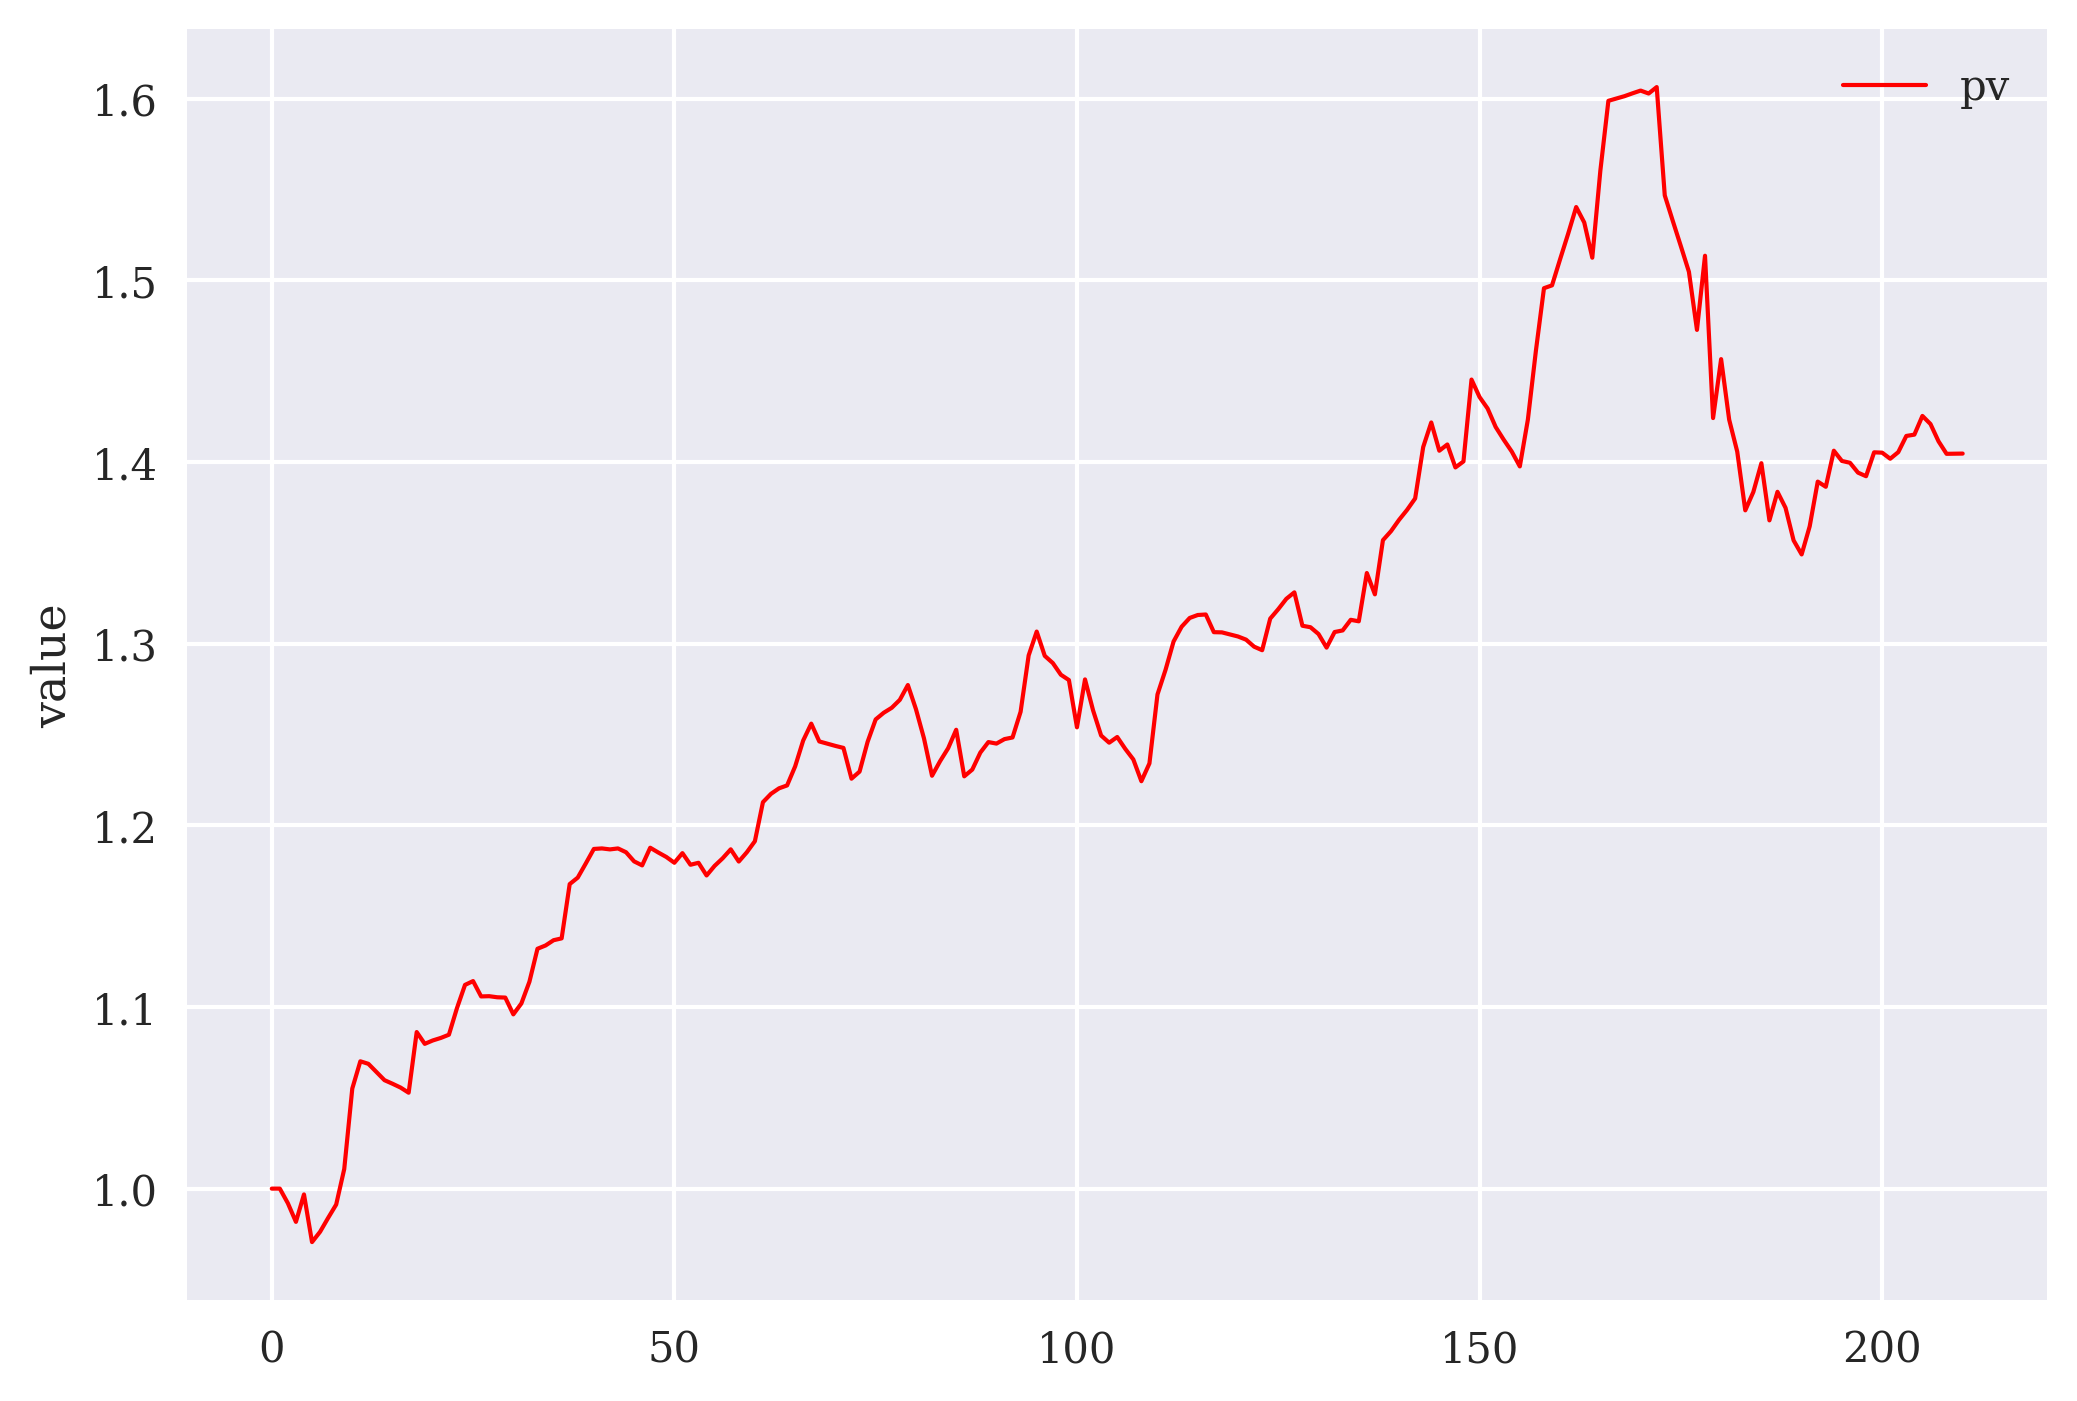

In [34]:
investing.portfolios[["pv"]].plot(style=['r-'], lw=1)
plt.ylabel('value');

In [35]:
alloc.mean()

AMZN         0.138315
BABA         0.325046
BBVA         0.221680
NVDA         0.069459
risk_free    0.245499
dtype: float64

In [36]:
alloc.std()

AMZN         0.197828
BABA         0.306844
BBVA         0.193423
NVDA         0.113869
risk_free    0.206952
dtype: float64

In [37]:
alloc.to_csv("data/_rl_budget_allocation.csv", index=False)

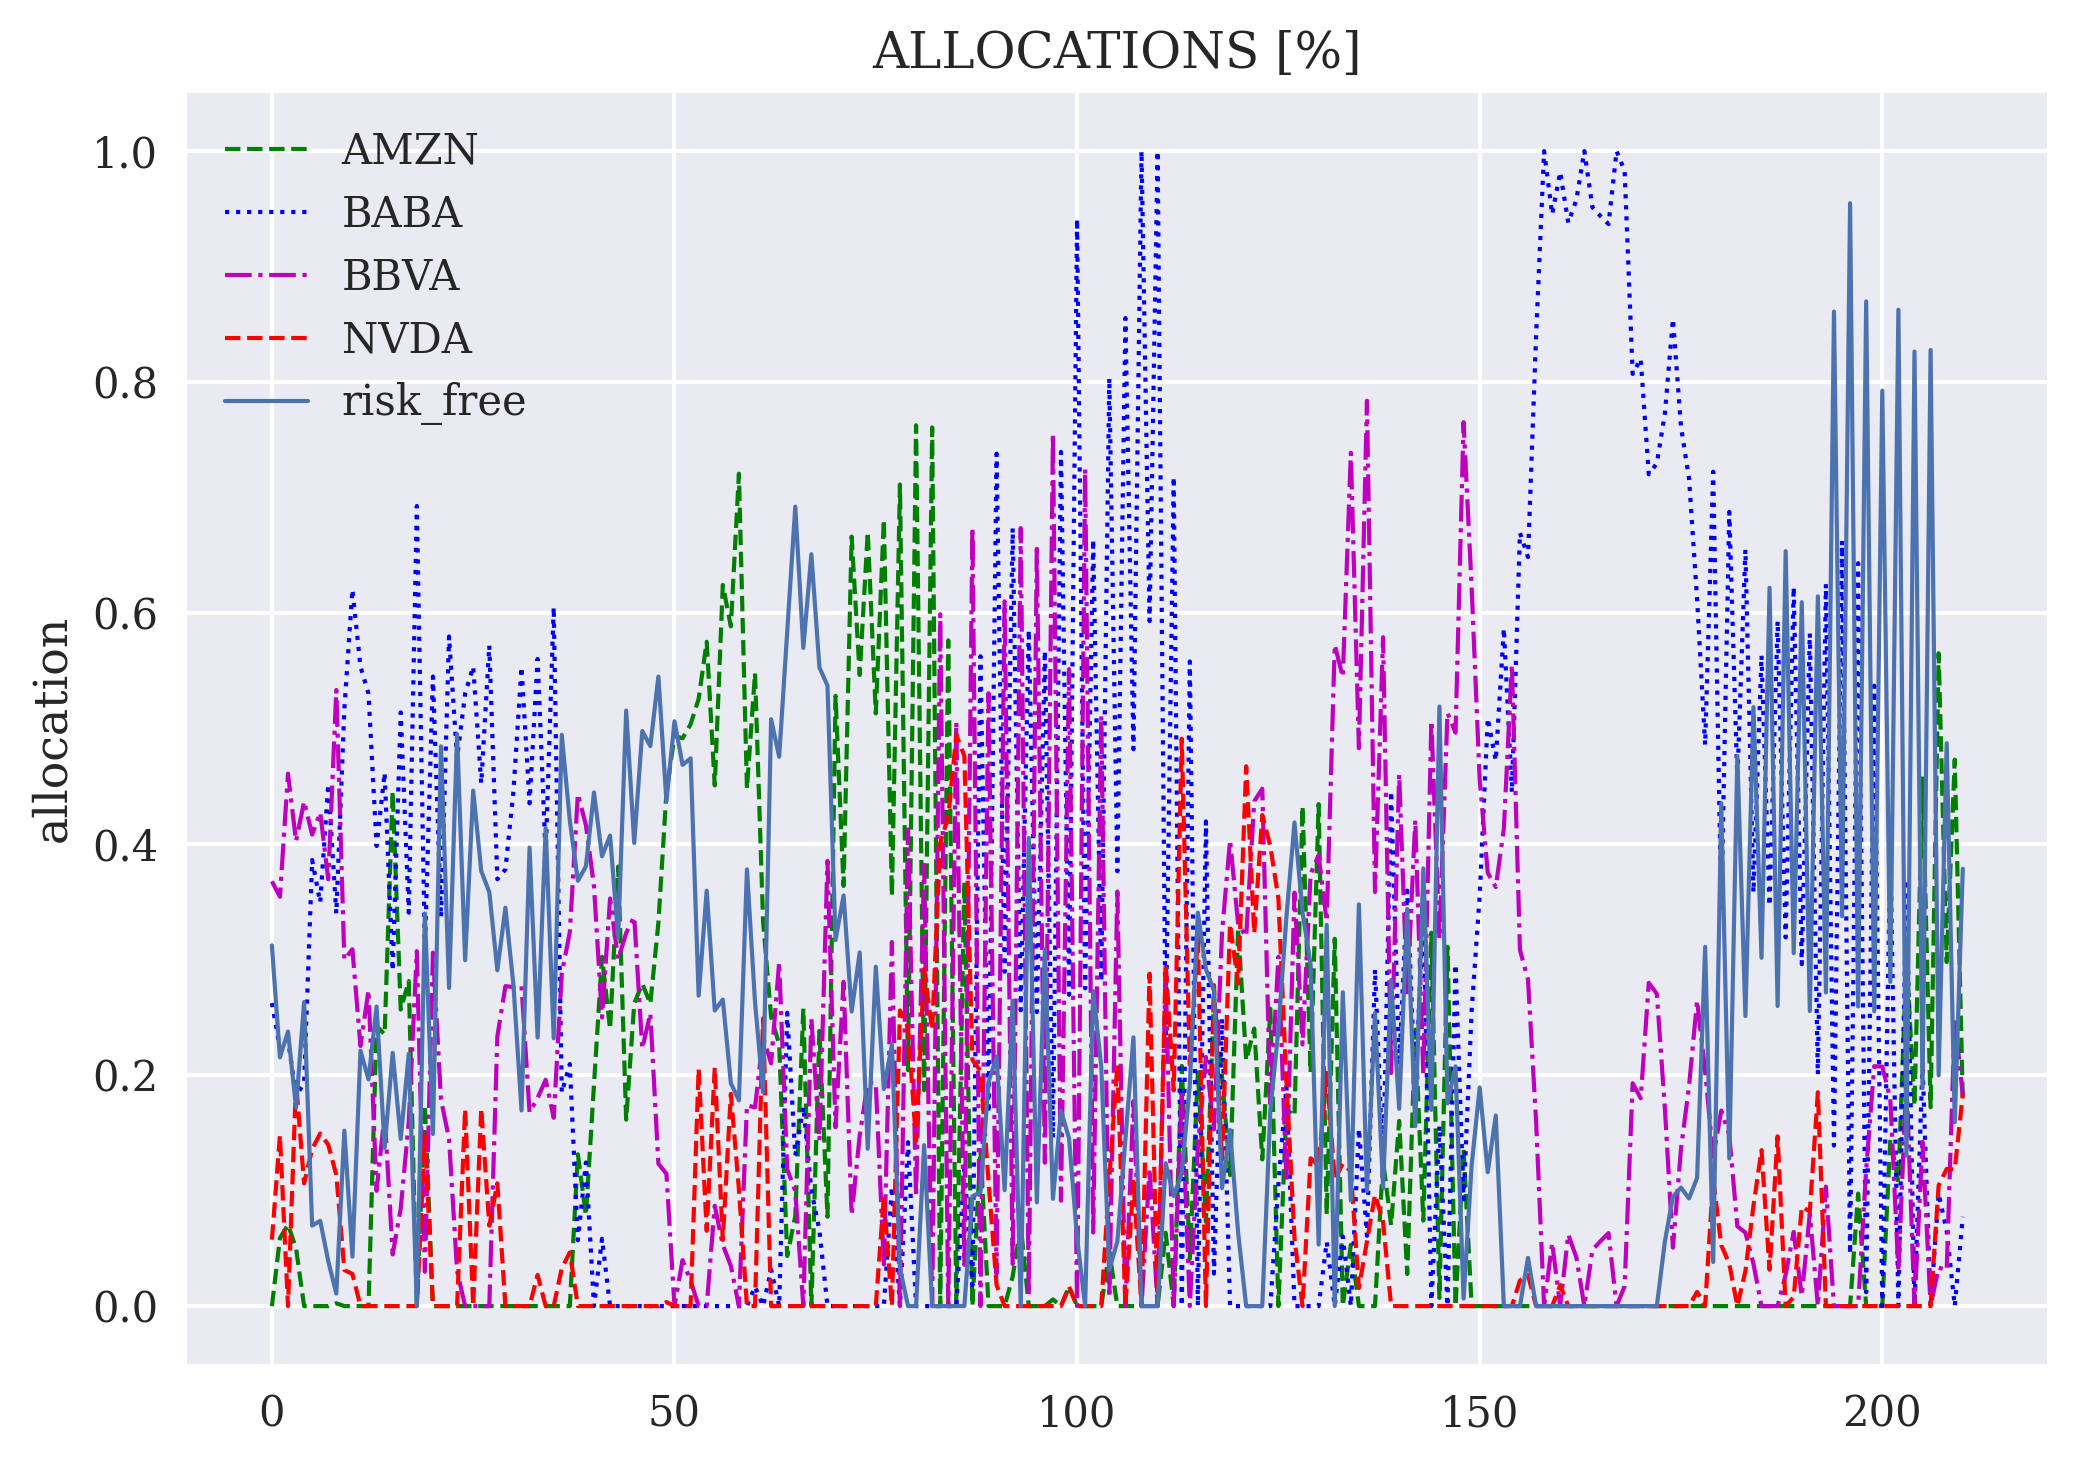

In [38]:
alloc.plot(title='ALLOCATIONS [%]', style=['g--', 'b:', 'm-.', 'r--',],lw=1, grid=True)
plt.ylabel('allocation');

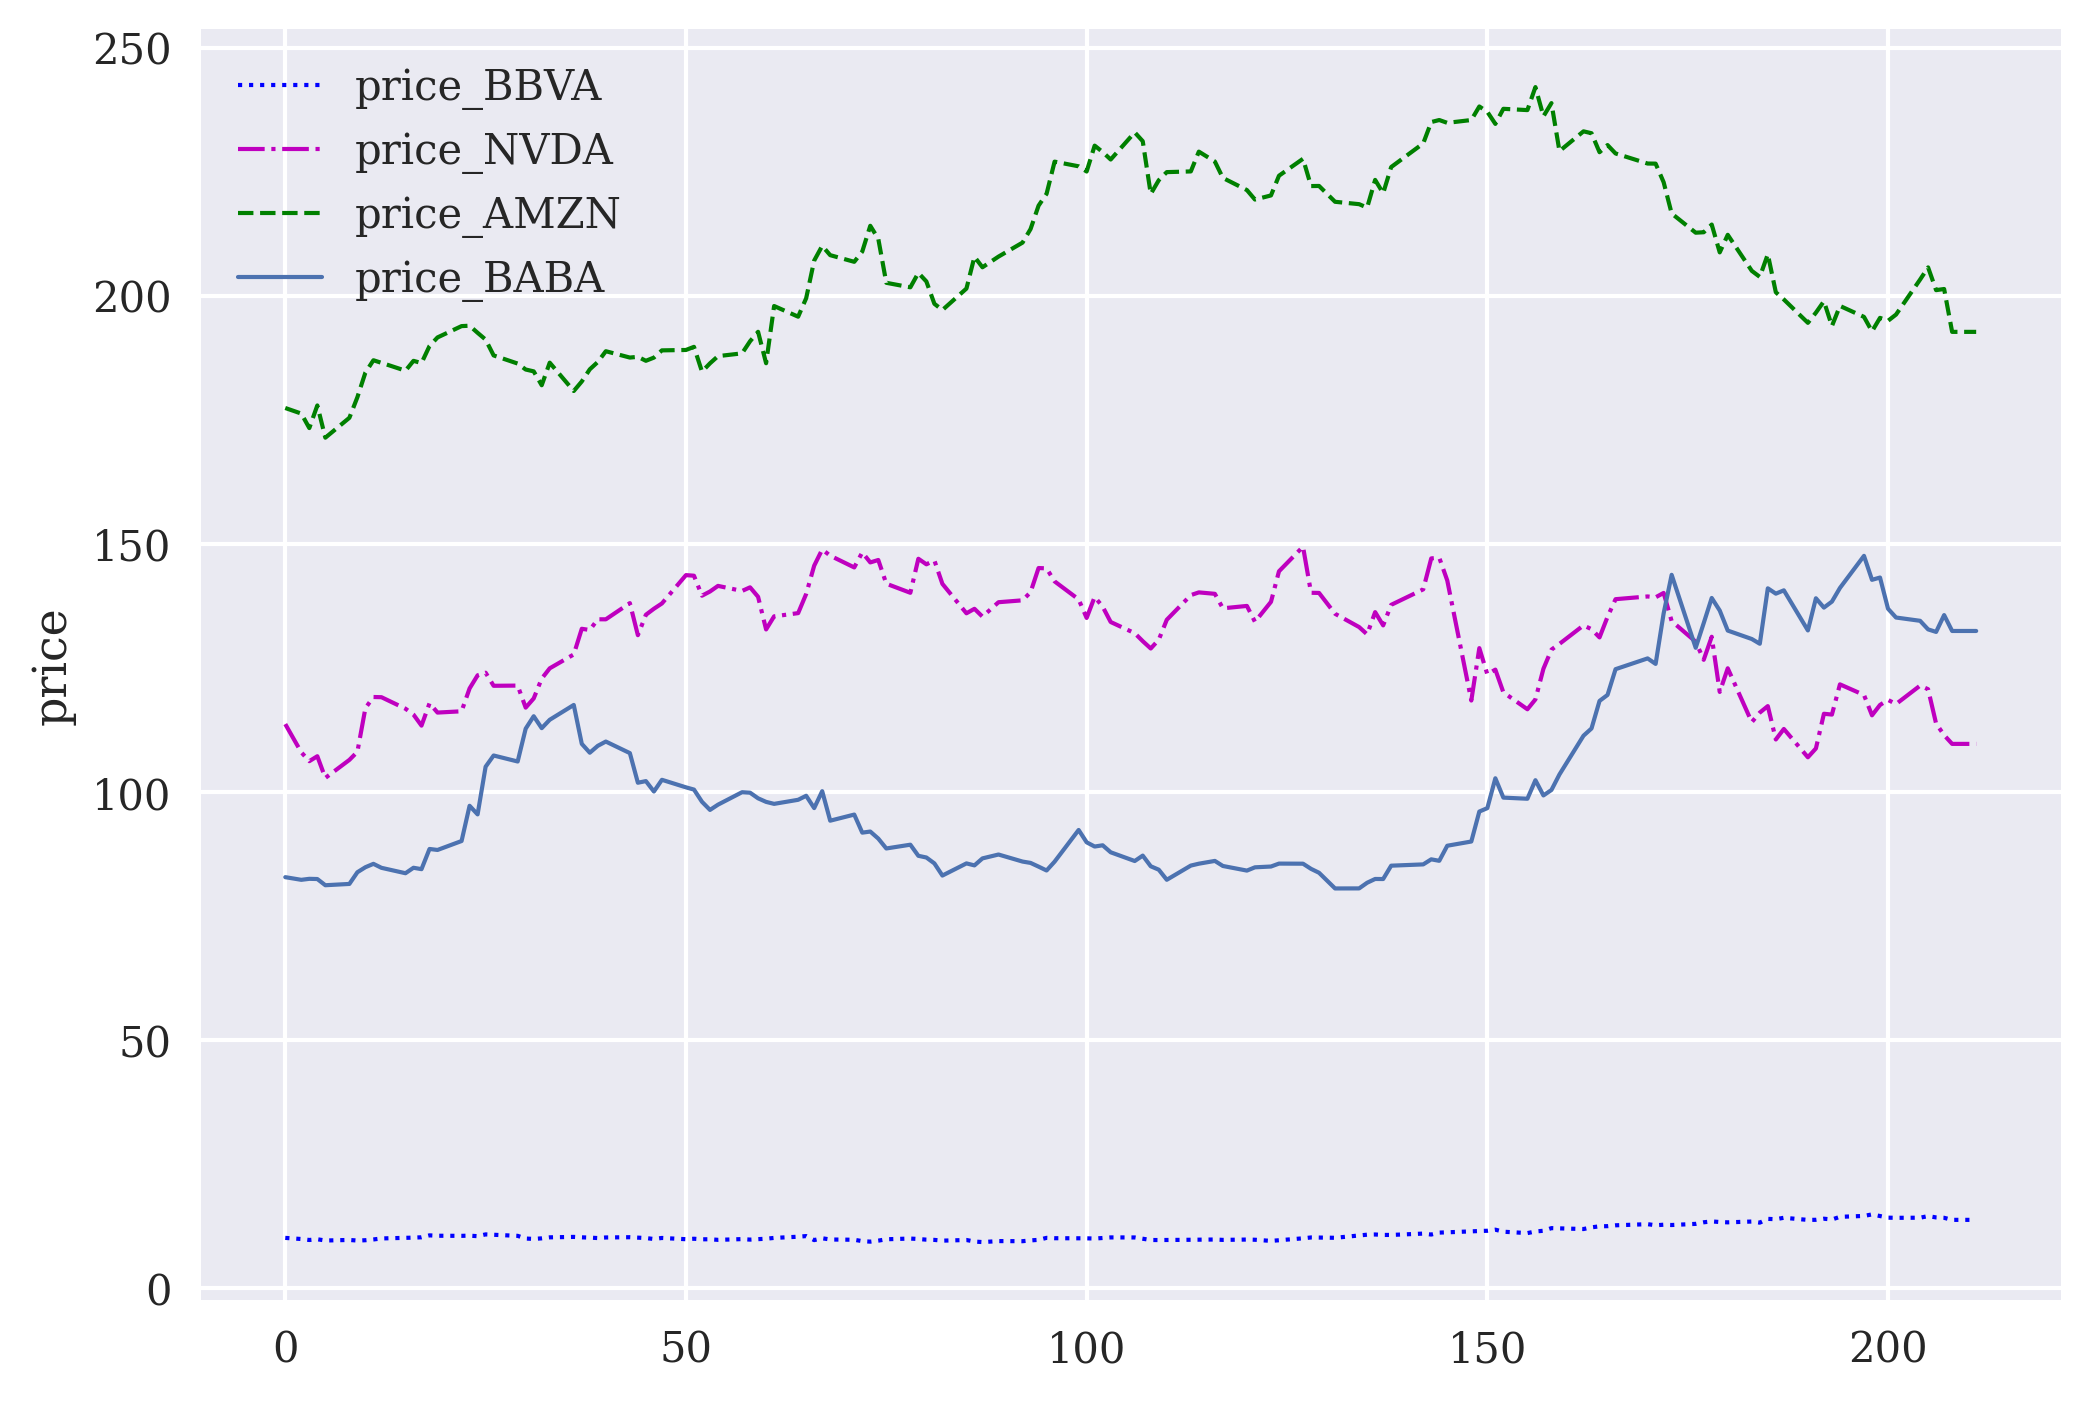

In [39]:
investing.data[investing.price_cols].plot(lw=1, style=[ 'b:', 'm-.', 'g--'])
plt.ylabel('price');

In [40]:
investing.data[investing.price_cols]

price_BBVA  price_NVDA  price_AMZN  price_BABA
0     10.094539  113.656990  177.375000   82.804996
1      9.980654  110.815189  176.812500   82.537497
2      9.866770  107.973389  176.250000   82.269997
3      9.672923  106.183830  173.330002   82.470001
4      9.818308  107.183586  177.889999   82.430000
..          ...         ...         ...         ...
207   14.140000  111.430000  201.360001  135.630005
208   13.730000  109.669998  192.720001  132.429993
209   13.730000  109.669998  192.720001  132.429993
210   13.730000  109.669998  192.720001  132.429993
211   13.730000  109.669998  192.720001  132.429993

[212 rows x 4 columns]

In [41]:
investing.data[investing.price_cols].to_csv("data/_stock_prices.csv", index=False)